# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [5]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

In [6]:
import sys
sys.path.append('/home/ubuntu/anaconda3/envs/carnd-term1/lib/python3.6/site-packages')
import cv2

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


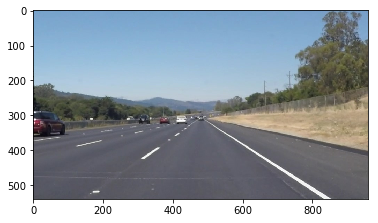

In [7]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [8]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image




def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [124]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

        

    right_lane_slopes=[]
    right_lane_intercepts=[]
    left_lane_slopes=[]
    left_lane_intercepts=[]
    y_down = img.shape[0]
    y_up = img.shape[0]*0.6
#     yrb = img.shape[0]
#     yrt = img.shape[0]*0.6
#     xlb = img.shape[1]*0.15
#     xlt = img.shape[1]*0.42
#     xrb = img.shape[1]*0.90
#     xrt = img.shape[1]*0.56
    y_bottom = img.shape[0]
    y_top = img.shape[0]
    right_x = []
    right_y = []
    left_x = []
    left_y = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            y_top = min(min(y1,y2),y_top)
            if(x2 != x1):
                slope = (float(y2-y1))/(x2-x1)
                intercept = y2 - (slope*x2)
            if(slope > 0):
                left_lane_slopes.append(slope)
                left_lane_intercepts.append(intercept)
                left_x += [x1,x2]
                left_y += [y1,y2]
#                 xlb = min(min(x1,x2),xlb)
#                 xlt = max(max(x1,x2),xlt)
            else :
                right_lane_slopes.append(slope)
                right_lane_intercepts.append(intercept)
                right_x += [x1,x2]
                right_y += [y1,y2]
#                 xrb = max(max(x1,x2),xrb)
#                 xrt = min(min(x1,x2),xrt)


#     print(xlb)
#     print(xlt)
#     print(xrb)
#     print(xrt)
#     print(img.shape[0])
#     print(img.shape[1])
    lls_avg = np.average(left_lane_slopes)
#     lli_avg = sum(left_lane_intercepts)/len(left_lane_intercepts)
    lli_avg = np.average(left_y) - (lls_avg * np.average(left_x))
    xlb = int((y_bottom-lli_avg)/lls_avg)
    xlt = int((y_top-lli_avg)/lls_avg)
#     print(np.mean(left_y))
#     print(np.mean(left_x))
#     print ("xlb=%d y_down=%d xlt=%d y_up=%d lls=%f lli=%f" %(xlb,y_down,xlt,y_up,lls_avg,lli_avg))
    rls_avg = np.average(right_lane_slopes)
    rli_avg = np.average(right_y) - (rls_avg * np.average(right_x))
    xrb = int((y_bottom-rli_avg)/rls_avg)
    xrt = int((y_top-rli_avg)/rls_avg)
#     print ("xrb=%d y_down=%d xrt=%d y_up=%d rls=%f rli=%f" %(xrb,y_down,xrt,y_up,rls_avg,rli_avg))
#     cv2.line(img, (x1, y1), (x2, y2), color, thickness)
#     print(xlb)
#     print(xlt)
#     print(xrb)
#     print(xrt)
#     print(y_top)
#     print(y_bottom)
#     print(lls_avg)
#     print(lli_avg)
#     print(rls_avg)
#     print(rli_avg)
    cv2.line(img, (xlb, y_bottom), (xlt, y_top), color, thickness)
    cv2.line(img, (xrb, y_bottom), (xrt, y_top), color, thickness)




## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [10]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [6]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

In [11]:
im1 = mpimg.imread('test_images/solidYellowLeft.jpg')

In [12]:
# plt.imshow(im1)
def detect_edges(im1):
    gr_im1 = grayscale(im1)
#     plt.imshow(gr_im1, cmap='gray')
    kernel_size = 5
    blur_gr_im1 = gaussian_blur(gr_im1,kernel_size)
#     plt.imshow(blur_gr_im1)
    low_thresh = 80
    high_thresh = 130
    edge_detected = canny(blur_gr_im1,low_thresh,high_thresh)
#     plt.imshow(edge_detected,cmap='Greys_r')
    return edge_detected

In [13]:
images=[]

for filename in os.listdir("test_images/"):
    image = cv2.imread(os.path.join("test_images/",filename))
    image=detect_edges(image)
    if image is not None:
        images.append(image)


In [14]:
init_img = []
i=0
for filename in os.listdir("test_images/"):
    org_img = mpimg.imread(os.path.join("test_images/",filename))
    init_img.append(org_img)
#     plt.figure()
#     plt.imshow(init_img[i])
    i+=1

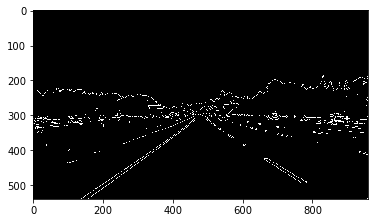

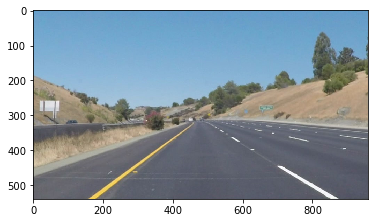

In [15]:
plt.figure()
plt.imshow(images[0],cmap='Greys_r')
# plt.figure()
# plt.imshow(images[1],cmap='Greys_r')
# plt.figure()
# plt.imshow(images[2],cmap='Greys_r')
# plt.figure()
# plt.imshow(images[3],cmap='Greys_r')
# plt.figure()
# plt.imshow(images[4],cmap='Greys_r')
# plt.figure()
# plt.imshow(images[5],cmap='Greys_r')
plt.figure()
plt.imshow(init_img[2])

In [88]:
def extrapolate_lanes(image):
    rho=1
    theta = np.pi/180
    threshold=30
    min_line_len =20
    max_line_gap = 20
#     imshape = images[0].shape
    imshape = image.shape
#     vertices = np.array([[(50,imshape[0]),(400, 350), (540, 325), (900,imshape[0])]], dtype=np.int32)
    vertices = np.array([[(130,540),(410, 350), (570, 350), (915,540)]], dtype=np.int32)
    lanes_img = region_of_interest(image,vertices)
    lanes_img = hough_lines(lanes_img,rho,theta,threshold,min_line_len,max_line_gap)
    return lanes_img
#     plt.imshow(lanes_img)
#     print(imshape)


In [36]:
def show_region(image):
    imshape=image.shape
    vertices = np.array([[(960,0),(0,500), (540, 325), (900,imshape[0])]], dtype=np.int32)
    lanes_img = region_of_interest(image,vertices)
    plt.imshow(weighted_img(image,lanes_img))

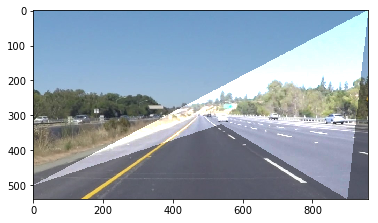

In [37]:
show_region(init_img[0])

In [17]:
plt.imshow(weighted_img(lanes_img,init_img[0]))

NameError: name 'lanes_img' is not defined

In [18]:
def lane_pipeline(image):
    canny_image = detect_edges(image)
    hough_image = extrapolate_lanes(canny_image)
    return weighted_img(hough_image,image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [91]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = lane_pipeline(image)
    return result

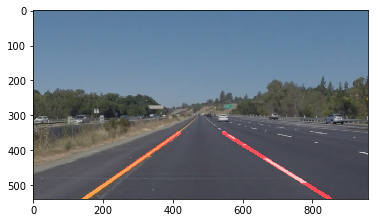

In [125]:
plt.imshow(process_image(init_img[0]))


Let's try the one with the solid white lane on the right first ...

In [126]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:11<00:00, 19.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 0 ns, sys: 2.07 s, total: 2.07 s
Wall time: 13.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [127]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [29]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:40<00:00, 16.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 6.32 s, sys: 684 ms, total: 7 s
Wall time: 41.9 s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [34]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[[354 682 354 431]]
[[625 449 625 421]]
[[407 487 407 360]]
[[445 567 445 379]]
[[554 493 554 422]]
[[583 480 583 419]]
[[459 558 459 368]]
[[406 680 406 582]]
[[505 525 505 379]]
[[397 681 397 589]]
[[477 544 477 362]]
[[498 530 498 366]]
[[339 628 372 697]]
[[429 677 429 377]]
[[446 567 446 379]]
[[286 518 338 432]]
[[396 490 396 359]]
[[570 482 570 421]]
[[450 564 450 377]]
[[449 378 470 550]]
[[511 521 511 367]]
[[395 490 395 358]]
[[314 645 323 684]]
[[295 516 376 377]]
[[474 431 519 410]]
[[448 476 468 362]]
[[346 624 379 682]]
[[432 676 546 670]]
[[198 684 312 663]]
[[460 557 474 362]]
[[370 682 404 584]]
[[603 668 790 668]]
[[490 673 498 631]]
[[603 461 603 437]]
[[294 684 294 658]]
[[509 522 509 367]]
[[322 639 369 622]]
[[391 491 398 359]]
[[421 678 421 362]]
[[474 547 495 426]]
[[574 700 574 669]]
[[400 489 400 359]]
[[184 682 243 686]]
[[410 486 479 379]]
[[342 683 346 431]]
[[571 481 571 421]]
[[550 495 550 423]]
[[581 480 620 418]]
[[514 519 615 418]]
[[358 502 358 431]]


[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 0/251 [00:00<?, ?it/s]

[[354 682 354 431]]
[[625 449 625 421]]
[[407 487 407 360]]
[[445 567 445 379]]
[[554 493 554 422]]
[[583 480 583 419]]
[[459 558 459 368]]
[[406 680 406 582]]
[[505 525 505 379]]
[[397 681 397 589]]
[[477 544 477 362]]
[[498 530 498 366]]
[[339 628 372 697]]
[[429 677 429 377]]
[[446 567 446 379]]
[[286 518 338 432]]
[[396 490 396 359]]
[[570 482 570 421]]
[[450 564 450 377]]
[[449 378 470 550]]
[[511 521 511 367]]
[[395 490 395 358]]
[[314 645 323 684]]
[[295 516 376 377]]
[[474 431 519 410]]
[[448 476 468 362]]
[[346 624 379 682]]
[[432 676 546 670]]
[[198 684 312 663]]
[[460 557 474 362]]
[[370 682 404 584]]
[[603 668 790 668]]
[[490 673 498 631]]
[[603 461 603 437]]
[[294 684 294 658]]
[[509 522 509 367]]
[[322 639 369 622]]
[[391 491 398 359]]
[[421 678 421 362]]
[[474 547 495 426]]
[[574 700 574 669]]
[[400 489 400 359]]
[[184 682 243 686]]
[[410 486 479 379]]
[[342 683 346 431]]
[[571 481 571 421]]
[[550 495 550 423]]
[[581 480 620 418]]
[[514 519 615 418]]
[[358 502 358 431]]


  0%|          | 1/251 [00:00<01:04,  3.85it/s]


[[460 376 476 366]]
[[484 365 595 465]]
[[389 434 456 367]]
[[444 415 476 469]]
[[205 685 309 665]]
[[569 477 572 422]]
[[257 526 419 488]]
[[409 593 425 677]]
[[475 546 484 530]]
[[441 431 485 529]]
[[296 657 330 650]]
[[380 613 435 676]]
[[391 605 469 673]]
[[420 362 432 480]]
[[606 459 612 435]]
[[317 643 352 683]]
[[565 425 572 476]]
[[316 643 339 644]]
[[427 364 469 363]]
[[411 579 428 579]]
[[530 508 530 424]]
[[472 431 502 369]]
[[316 684 387 596]]
[[515 457 553 423]]
[[410 435 439 380]]
[[470 361 564 481]]
[[524 455 549 423]]
[[522 507 531 427]]
[[384 371 424 428]]
[[340 627 422 597]]
[[340 628 368 682]]
[[595 466 595 420]]
[[383 437 440 380]]
[[506 379 518 516]]
[[213 685 295 658]]
[[263 680 292 684]]
[[355 589 387 595]]
[[468 471 478 426]]
[[512 423 582 480]]
[[456 377 474 395]]
[[348 589 378 601]]
[[565 484 577 424]]
[[525 455 560 425]]
[[380 600 434 595]]
[[369 682 402 597]]
[[600 459 613 418]]
[[499 686 528 671]]
[[327 441 350 501]]
[[386 596 426 677]]
[[576 423 610 456]]

  1%|          | 2/251 [00:00<01:09,  3.59it/s]


[[203 684 256 685]]
[[456 370 477 365]]
[[442 477 442 398]]
[[400 429 405 360]]
[[389 607 470 673]]
[[492 525 498 429]]
[[534 506 538 426]]
[[558 425 567 482]]
[[395 432 399 359]]
[[338 628 353 633]]
[[373 618 391 681]]
[[369 432 427 378]]
[[296 619 341 642]]
[[614 434 615 417]]
[[507 367 528 424]]
[[359 503 364 430]]
[[578 483 579 441]]
[[616 453 627 420]]
[[403 488 425 365]]
[[309 684 315 660]]
[[417 484 501 520]]
[[468 369 477 384]]
[[557 447 564 485]]
[[487 426 497 366]]
[[299 654 321 656]]
[[379 437 393 358]]
[[490 464 520 514]]
[[374 604 410 591]]
[[332 435 353 500]]
[[408 679 491 672]]
[[452 432 452 377]]
[[465 403 465 374]]
[[551 422 572 480]]
[[449 563 494 633]]
[[449 564 496 631]]
[[574 483 587 466]]
[[607 422 626 444]]
[[284 682 284 665]]
[[577 477 577 421]]
[[537 497 631 445]]
[[573 487 573 420]]
[[462 555 462 368]]
[[350 506 472 361]]
[[429 579 429 366]]
[[201 684 331 684]]
[[286 685 395 590]]
[[503 527 503 367]]
[[407 490 407 360]]
[[432 576 432 365]]
[[317 643 339 644]]

  1%|          | 3/251 [00:00<01:10,  3.50it/s]

[[384 369 402 360]]
[[336 630 355 632]]
[[387 493 450 562]]
[[406 360 411 379]]
[[449 367 469 371]]
[[590 468 591 423]]
[[539 423 558 484]]
[[252 527 317 441]]
[[360 439 395 370]]
[[482 466 500 372]]
[[304 517 426 367]]
[[385 437 389 496]]
[[341 436 368 497]]
[[213 670 248 685]]
[[377 499 388 370]]
[[317 644 341 642]]
[[419 487 453 376]]
[[640 668 656 667]]
[[565 480 584 419]]
[[424 434 468 361]]
[[452 432 474 377]]
[[463 476 471 431]]
[[445 433 468 551]]
[[297 519 378 603]]
[[314 441 356 504]]
[[536 426 549 496]]
[[527 512 543 451]]
[[533 507 537 427]]
[[459 427 483 532]]
[[340 628 376 616]]
[[570 487 578 424]]
[[411 580 436 573]]
[[404 433 414 488]]
[[223 661 286 664]]
[[398 377 433 366]]
[[294 659 316 660]]
[[413 378 430 366]]
[[325 435 364 502]]
[[335 506 407 583]]
[[327 680 382 599]]
[[404 381 423 366]]
[[615 453 617 420]]
[[224 660 309 664]]
[[214 665 304 668]]
[[309 648 380 681]]
[[322 441 365 502]]
[[503 672 520 671]]
[[555 492 561 445]]
[[201 673 331 673]]
[[525 424 529 454]]


  2%|▏         | 4/251 [00:01<01:09,  3.54it/s]


[[462 556 499 425]]
[[584 440 615 421]]
[[436 434 531 508]]
[[563 492 563 420]]
[[336 432 485 532]]
[[551 422 577 478]]
[[524 455 607 458]]
[[603 421 633 441]]
[[350 507 362 431]]
[[488 539 548 423]]
[[411 490 434 379]]
[[397 589 425 595]]
[[535 506 535 424]]
[[780 716 843 692]]
[[403 586 567 669]]
[[313 442 330 432]]
[[441 403 464 397]]
[[323 640 356 633]]
[[362 613 417 678]]
[[368 502 447 566]]
[[319 643 344 642]]
[[387 493 474 547]]
[[575 479 577 420]]
[[430 696 437 676]]
[[411 580 430 593]]
[[581 419 600 463]]
[[403 433 473 549]]
[[388 429 512 522]]
[[521 516 522 425]]
[[606 418 619 451]]
[[366 431 407 595]]
[[344 432 391 359]]
[[546 498 547 423]]
[[557 491 562 420]]
[[597 438 621 421]]
[[319 515 379 372]]
[[602 461 619 421]]
[[329 636 359 631]]
[[524 514 531 424]]
[[332 435 352 503]]
[[544 426 550 495]]
[[396 377 416 362]]
[[364 503 370 431]]
[[286 665 316 661]]
[[435 429 475 502]]
[[386 370 387 437]]
[[341 509 455 368]]
[[363 613 418 678]]
[[400 587 419 601]]
[[304 654 335 647]]

[[391 594 409 595]]
[[469 432 539 395]]
[[336 632 389 681]]
[[332 651 348 682]]
[[369 502 440 573]]
[[313 514 383 370]]
[[268 680 346 683]]
[[336 647 383 681]]
[[350 622 367 625]]
[[370 439 463 364]]
[[232 534 259 527]]
[[394 432 406 489]]
[[566 486 579 420]]
[[299 657 318 661]]
[[284 685 285 668]]
[[330 509 398 434]]
[[402 430 480 546]]
[[372 608 426 677]]
[[383 600 429 677]]
[[480 471 490 426]]
[[367 610 383 613]]
[[592 421 622 451]]
[[313 648 334 649]]
[[467 545 496 535]]
[[437 484 459 369]]
[[459 559 473 428]]
[[494 528 509 526]]
[[374 431 401 494]]
[[453 377 471 366]]
[[533 670 575 693]]
[[405 430 500 634]]
[[456 430 476 432]]
[[452 428 457 376]]
[[318 645 349 682]]
[[268 525 284 525]]
[[467 366 559 498]]
[[539 498 549 426]]
[[559 422 617 435]]
[[328 433 343 510]]
[[505 429 506 414]]
[[374 439 475 540]]
[[554 448 569 484]]
[[432 485 441 430]]
[[603 462 630 433]]
[[585 473 592 420]]
[[508 460 538 424]]
[[535 453 586 420]]
[[563 694 583 693]]
[[567 484 588 421]]
[[437 401 461 379]]


  2%|▏         | 5/251 [00:01<01:11,  3.46it/s]


[[577 478 581 424]]
[[379 681 410 582]]
[[333 438 362 500]]
[[327 510 345 436]]
[[440 479 524 515]]
[[228 686 291 664]]
[[380 435 458 478]]
[[300 521 326 433]]
[[565 445 575 474]]
[[499 685 570 700]]
[[369 609 409 679]]
[[532 424 560 485]]
[[302 655 322 658]]
[[357 617 373 620]]
[[521 428 524 508]]
[[365 503 395 374]]
[[437 413 467 373]]
[[477 472 492 430]]
[[317 516 430 366]]
[[447 378 476 366]]
[[280 522 308 519]]
[[490 539 520 457]]
[[400 430 400 377]]
[[426 582 477 468]]
[[590 465 645 441]]
[[465 555 485 470]]
[[535 507 568 444]]
[[584 424 617 454]]
[[420 678 439 675]]
[[404 489 405 433]]
[[504 429 548 492]]
[[415 431 468 366]]
[[329 637 355 682]]
[[575 421 593 424]]
[[278 673 300 674]]
[[305 671 361 682]]
[[485 466 502 368]]
[[282 685 282 669]]
[[583 420 617 409]]
[[528 505 565 425]]
[[231 686 271 677]]
[[589 421 598 438]]
[[411 375 490 368]]
[[324 683 373 697]]
[[342 441 380 495]]
[[388 497 416 579]]
[[536 453 554 426]]
[[480 427 482 470]]
[[473 469 545 500]]
[[396 430 444 482]]

  2%|▏         | 6/251 [00:01<01:10,  3.46it/s]


[[395 375 410 363]]
[[433 677 501 631]]
[[449 481 504 415]]
[[382 500 470 429]]
[[270 678 296 678]]
[[562 489 583 421]]
[[380 604 425 586]]
[[321 440 349 509]]
[[330 637 349 640]]
[[557 492 570 422]]
[[276 674 301 674]]
[[543 424 570 484]]
[[363 504 382 371]]
[[510 460 558 425]]
[[459 552 474 551]]
[[523 516 534 425]]
[[302 656 321 659]]
[[547 504 566 426]]
[[561 490 574 421]]
[[583 475 586 421]]
[[328 638 374 682]]
[[394 594 412 604]]
[[577 479 593 421]]
[[189 683 290 682]]
[[375 498 381 439]]
[[414 366 474 364]]
[[778 669 845 695]]
[[288 522 333 433]]
[[353 621 427 677]]
[[502 368 544 424]]
[[462 560 473 429]]
[[397 435 407 493]]
[[599 438 606 460]]
[[465 558 495 427]]
[[558 492 573 422]]
[[468 362 551 505]]
[[295 661 315 664]]
[[384 431 411 436]]
[[376 606 395 607]]
[[286 667 376 697]]
[[297 659 395 681]]
[[358 632 416 679]]
[[287 666 310 667]]
[[301 522 320 434]]
[[335 634 381 682]]
[[553 449 567 481]]
[[395 361 411 488]]
[[342 433 369 503]]
[[604 419 645 442]]
[[332 433 354 503]]

[[427 398 433 380]]
[[434 403 457 398]]
[[345 682 347 627]]
[[574 480 575 420]]
[[411 376 421 488]]
[[343 510 358 440]]
[[549 426 555 487]]
[[468 362 565 482]]
[[609 458 630 433]]
[[382 603 468 673]]
[[629 448 632 432]]
[[350 433 385 498]]
[[276 529 295 520]]
[[351 625 423 677]]
[[458 429 467 384]]
[[398 378 419 528]]
[[489 541 521 457]]
[[358 502 385 434]]
[[533 509 539 424]]
[[525 425 528 512]]
[[490 431 498 368]]
[[403 434 435 480]]
[[413 679 431 676]]
[[294 662 322 678]]
[[392 373 394 437]]
[[375 431 394 492]]
[[384 438 449 368]]
[[401 491 455 555]]
[[353 637 374 697]]
[[432 401 459 393]]
[[315 648 334 651]]
[[554 494 556 425]]
[[581 476 594 420]]
[[339 438 377 501]]
[[595 462 605 419]]
[[527 513 556 447]]
[[287 684 287 667]]
[[487 426 487 370]]
[[405 433 406 489]]
[[340 511 354 437]]
[[500 462 503 415]]
[[211 685 278 674]]
[[341 510 412 364]]
[[539 452 622 451]]
[[570 699 577 669]]
[[317 648 349 682]]
[[382 624 402 602]]
[[594 422 606 437]]
[[395 437 463 382]]
[[302 657 323 683]]


  3%|▎         | 7/251 [00:02<01:12,  3.36it/s]


[[525 456 537 510]]
[[421 382 483 536]]
[[409 586 429 584]]
[[384 431 461 379]]
[[318 646 337 649]]
[[528 424 544 501]]
[[373 435 412 487]]
[[269 679 295 684]]
[[313 649 325 673]]
[[342 631 356 682]]
[[499 368 534 508]]
[[452 479 469 428]]
[[365 436 432 413]]
[[465 475 495 425]]
[[379 606 419 591]]
[[313 650 328 671]]
[[621 447 642 439]]
[[507 460 516 521]]
[[315 649 378 682]]
[[442 378 456 478]]
[[425 432 460 378]]
[[289 526 320 442]]
[[610 454 616 409]]
[[479 548 479 431]]
[[418 435 449 559]]
[[571 482 572 443]]
[[448 560 466 557]]
[[579 477 580 424]]
[[302 522 316 440]]
[[844 693 855 670]]
[[297 684 350 648]]
[[376 697 384 681]]
[[375 608 418 592]]
[[324 515 374 431]]
[[585 472 587 420]]
[[265 532 292 525]]
[[360 682 408 679]]
[[605 456 608 419]]
[[555 493 559 422]]
[[508 518 523 425]]
[[576 458 585 420]]
[[440 379 504 368]]
[[411 363 414 429]]
[[288 667 303 672]]
[[441 378 526 514]]
[[521 516 544 450]]
[[447 675 502 684]]
[[428 432 486 370]]
[[392 597 413 595]]
[[427 379 433 435]]

  3%|▎         | 8/251 [00:02<01:11,  3.41it/s]


[[409 492 476 427]]
[[503 672 583 693]]
[[321 436 453 674]]
[[324 665 337 683]]
[[341 632 358 635]]
[[300 522 313 443]]
[[338 432 439 566]]
[[390 435 428 575]]
[[403 591 433 583]]
[[308 671 389 681]]
[[546 422 599 459]]
[[397 681 438 675]]
[[313 651 317 683]]
[[502 425 534 519]]
[[544 496 550 423]]
[[614 456 625 418]]
[[593 468 593 420]]
[[384 430 407 489]]
[[344 631 381 620]]
[[524 425 550 497]]
[[365 504 365 431]]
[[590 470 604 422]]
[[345 433 465 549]]
[[319 664 336 683]]
[[413 679 467 673]]
[[385 617 461 674]]
[[359 502 437 580]]
[[354 503 354 432]]
[[333 638 434 676]]
[[496 423 507 527]]
[[390 613 396 430]]
[[359 682 417 582]]
[[515 670 532 671]]
[[341 511 342 435]]
[[342 511 394 375]]
[[385 435 440 577]]
[[326 658 365 682]]
[[567 485 570 422]]
[[288 526 333 433]]
[[370 613 405 603]]
[[573 699 579 669]]
[[451 475 548 498]]
[[602 420 638 440]]
[[519 519 532 424]]
[[399 361 406 436]]
[[307 655 320 683]]
[[531 519 536 427]]
[[595 439 597 419]]
[[527 518 562 422]]
[[407 430 538 500]]

[[510 525 520 428]]
[[438 567 457 564]]
[[581 475 601 437]]
[[393 496 408 376]]
[[304 659 326 660]]
[[446 480 446 368]]
[[414 436 420 367]]
[[381 438 418 381]]
[[385 498 457 362]]
[[585 472 617 422]]
[[442 403 454 376]]
[[423 415 463 383]]
[[327 433 362 505]]
[[427 432 433 374]]
[[328 515 353 504]]
[[566 445 582 470]]
[[478 468 528 513]]
[[298 664 343 682]]
[[368 435 460 365]]
[[314 679 367 682]]
[[369 431 376 497]]
[[286 671 320 664]]
[[447 433 462 366]]
[[546 499 567 422]]
[[486 534 524 528]]
[[399 375 408 433]]
[[543 495 564 422]]
[[460 561 463 475]]
[[385 618 466 528]]
[[459 428 484 367]]
[[282 674 307 674]]
[[620 447 623 421]]
[[451 368 455 394]]
[[366 431 447 368]]
[[440 367 457 380]]
[[434 483 465 367]]
[[370 431 399 494]]
[[380 430 424 399]]
[[499 425 504 407]]
[[567 484 578 424]]
[[578 473 611 436]]
[[457 477 530 505]]


  4%|▎         | 9/251 [00:02<01:11,  3.40it/s]

[[316 518 316 439]]
[[413 490 413 364]]
[[566 486 566 422]]
[[567 699 567 669]]
[[617 667 757 667]]
[[260 685 403 606]]
[[264 685 378 611]]
[[579 700 579 669]]
[[384 681 384 606]]
[[275 530 396 611]]
[[844 694 844 670]]
[[494 538 494 368]]
[[477 550 477 426]]
[[330 570 451 369]]
[[262 685 332 643]]
[[429 378 532 510]]
[[486 543 486 367]]
[[487 431 502 424]]
[[495 537 495 368]]
[[536 453 626 419]]
[[409 491 409 366]]
[[438 567 643 439]]
[[564 461 616 417]]
[[526 515 526 425]]
[[421 488 470 428]]
[[318 683 425 576]]
[[533 424 553 490]]
[[246 685 358 640]]
[[480 548 480 369]]
[[400 494 490 371]]
[[488 367 519 513]]
[[440 578 440 367]]
[[297 684 297 666]]
[[418 488 420 369]]
[[297 524 336 433]]
[[411 679 412 586]]
[[318 436 373 439]]
[[527 514 527 425]]
[[425 577 599 699]]
[[427 486 431 367]]
[[604 409 613 456]]
[[401 593 416 596]]
[[375 431 515 515]]
[[456 362 482 547]]
[[313 519 393 361]]
[[435 483 435 367]]
[[428 375 518 514]]
[[457 433 496 414]]
[[389 497 389 374]]
[[581 476 581 424]]


  4%|▍         | 10/251 [00:02<01:10,  3.43it/s]

[[583 421 596 466]]
[[365 431 406 377]]
[[629 448 630 433]]
[[339 637 359 639]]
[[287 673 304 679]]
[[519 428 533 510]]
[[328 645 350 682]]
[[257 685 318 668]]
[[297 520 313 443]]
[[384 431 530 505]]
[[542 670 566 669]]
[[576 474 611 409]]
[[586 423 593 464]]
[[472 470 472 432]]
[[619 453 626 422]]
[[397 430 471 554]]
[[573 476 588 420]]
[[433 366 451 398]]
[[538 506 544 422]]
[[338 441 406 378]]
[[406 433 444 368]]
[[458 477 464 429]]
[[356 440 381 371]]
[[296 520 321 434]]
[[496 430 532 454]]
[[391 435 445 477]]
[[305 678 396 680]]
[[336 639 377 681]]
[[421 484 433 435]]
[[455 379 490 372]]
[[445 563 464 560]]
[[439 479 455 428]]
[[552 669 575 699]]
[[579 473 583 423]]
[[553 669 581 693]]
[[608 459 611 436]]
[[411 487 417 430]]
[[437 479 441 431]]
[[342 636 390 681]]
[[280 679 309 683]]
[[572 476 574 412]]
[[298 666 307 683]]
[[575 425 584 470]]
[[427 406 500 410]]
[[284 528 327 571]]
[[277 685 368 632]]
[[563 422 583 470]]
[[378 431 410 381]]
[[479 468 530 427]]
[[520 457 523 425]]


  4%|▍         | 11/251 [00:03<01:10,  3.42it/s]

[[472 555 472 366]]
[[428 485 428 366]]
[[380 681 380 371]]
[[846 693 846 669]]
[[486 544 486 367]]
[[406 679 406 590]]
[[447 573 447 369]]
[[517 522 517 425]]
[[420 379 539 506]]
[[331 683 331 643]]
[[601 410 616 454]]
[[341 636 357 641]]
[[443 576 443 368]]
[[545 501 545 423]]
[[322 650 341 653]]
[[546 500 569 409]]
[[216 685 221 547]]
[[523 517 523 393]]
[[582 475 619 416]]
[[618 668 674 667]]
[[562 489 569 410]]
[[345 441 436 367]]
[[217 685 217 543]]
[[339 638 355 642]]
[[574 481 615 412]]
[[390 681 390 361]]
[[382 607 398 610]]
[[505 531 509 426]]
[[358 682 483 672]]
[[344 682 344 634]]
[[295 685 298 667]]
[[503 532 505 426]]
[[617 454 633 432]]
[[555 422 588 471]]
[[480 549 483 366]]
[[520 520 520 390]]
[[604 461 608 409]]
[[418 488 418 379]]
[[473 554 473 367]]
[[402 493 402 379]]
[[367 439 440 368]]
[[533 510 535 424]]
[[508 529 513 425]]
[[202 684 308 684]]
[[357 440 461 362]]
[[541 504 560 423]]
[[294 526 350 504]]
[[364 620 416 678]]
[[379 438 465 363]]
[[301 524 344 432]]


  5%|▍         | 12/251 [00:03<01:09,  3.43it/s]


[[197 683 206 624]]
[[608 459 622 419]]
[[561 489 563 422]]
[[321 434 392 372]]
[[512 459 513 525]]
[[414 398 444 396]]
[[421 406 437 405]]
[[346 633 384 681]]
[[540 498 542 451]]
[[536 427 551 491]]
[[469 471 481 427]]
[[619 449 622 415]]
[[289 673 326 683]]
[[423 379 432 403]]
[[381 371 439 374]]
[[396 495 398 375]]
[[371 615 402 606]]
[[332 643 350 646]]
[[268 528 342 511]]
[[586 421 606 455]]
[[365 634 407 679]]
[[520 670 542 670]]
[[379 575 435 582]]
[[393 496 410 487]]
[[424 483 482 547]]
[[363 621 378 625]]
[[365 619 391 615]]
[[209 621 246 539]]
[[530 454 550 423]]
[[291 685 373 694]]
[[609 454 622 423]]
[[358 625 373 629]]
[[379 623 447 674]]
[[615 410 646 442]]
[[388 617 460 673]]
[[334 436 381 499]]
[[516 458 521 391]]
[[388 438 446 477]]
[[444 429 455 362]]
[[536 423 602 458]]
[[476 469 529 512]]
[[582 442 583 421]]
[[445 369 456 433]]
[[386 619 397 596]]
[[424 486 436 429]]
[[315 683 316 655]]
[[541 504 541 424]]
[[337 511 337 432]]
[[597 668 788 668]]
[[341 597 399 609]]

  5%|▌         | 13/251 [00:03<01:09,  3.42it/s]


[[327 646 344 683]]
[[428 588 439 568]]
[[382 431 399 489]]
[[577 693 582 669]]
[[452 478 476 427]]
[[236 686 305 680]]
[[373 431 495 633]]
[[587 700 594 669]]
[[592 418 607 437]]
[[389 376 405 364]]
[[330 441 398 378]]
[[503 532 546 381]]
[[370 502 396 490]]
[[416 411 547 499]]
[[314 519 321 433]]
[[362 621 392 614]]
[[319 652 339 654]]
[[436 479 474 553]]
[[615 455 625 434]]
[[428 485 442 393]]
[[426 432 457 384]]
[[367 431 427 366]]
[[404 605 460 674]]
[[599 439 623 422]]
[[543 502 547 422]]
[[366 682 366 618]]
[[301 523 439 676]]
[[343 432 360 505]]
[[434 484 543 379]]
[[382 373 407 366]]
[[396 494 421 366]]
[[278 525 395 375]]
[[328 514 351 432]]
[[415 584 461 674]]
[[397 598 435 676]]
[[398 610 458 674]]
[[478 468 518 428]]
[[451 479 530 424]]
[[565 425 571 483]]
[[433 403 434 434]]
[[534 509 538 424]]
[[339 432 361 504]]
[[293 525 375 626]]
[[309 520 326 433]]
[[333 509 357 434]]
[[403 492 427 377]]
[[391 378 396 437]]
[[466 471 521 519]]
[[477 367 484 425]]
[[462 674 500 633]]

[[592 414 617 435]]
[[781 719 813 669]]
[[410 588 434 597]]
[[478 540 496 425]]
[[387 434 463 561]]
[[586 423 599 459]]
[[448 675 463 673]]
[[264 685 269 639]]
[[376 430 543 494]]
[[586 440 612 409]]
[[589 440 614 422]]
[[412 411 515 514]]
[[492 540 521 423]]
[[183 682 219 686]]
[[594 412 613 435]]
[[321 650 325 684]]
[[405 379 543 495]]
[[755 668 784 719]]
[[349 630 384 620]]
[[281 635 293 669]]
[[291 671 306 678]]
[[538 423 568 412]]
[[519 424 543 501]]
[[370 430 382 493]]
[[621 447 646 441]]
[[480 467 523 427]]
[[495 529 512 525]]
[[502 687 511 671]]
[[427 366 442 393]]
[[525 424 531 510]]
[[539 497 543 468]]
[[572 700 587 700]]
[[455 361 479 426]]
[[416 435 435 375]]
[[371 438 448 380]]
[[375 438 376 499]]
[[356 501 360 431]]
[[365 436 446 368]]
[[408 414 438 482]]
[[437 367 580 471]]
[[372 682 444 675]]
[[365 620 384 631]]


  6%|▌         | 14/251 [00:04<01:11,  3.32it/s]

[[271 641 282 685]]
[[567 417 617 449]]
[[530 503 562 445]]
[[609 414 628 447]]
[[333 432 470 555]]
[[412 615 428 576]]
[[473 673 501 631]]
[[577 423 613 451]]
[[594 439 612 455]]
[[396 430 399 379]]
[[413 401 441 391]]
[[365 619 381 622]]
[[407 487 446 563]]
[[380 433 384 371]]
[[441 566 466 558]]
[[458 473 462 428]]
[[524 427 567 411]]
[[329 433 342 509]]
[[600 407 642 439]]
[[415 679 433 600]]
[[391 429 440 478]]
[[330 644 348 647]]
[[400 430 454 474]]
[[511 458 565 411]]
[[510 458 543 419]]
[[355 432 365 498]]
[[385 381 416 488]]
[[548 491 565 410]]
[[347 508 347 431]]
[[381 373 423 365]]
[[377 611 447 573]]
[[284 630 333 657]]
[[623 449 630 432]]
[[327 684 539 670]]
[[383 493 383 434]]
[[304 662 312 684]]
[[401 380 437 433]]
[[395 429 441 477]]
[[434 483 488 416]]
[[360 500 364 436]]
[[389 491 395 377]]
[[222 546 266 528]]
[[247 533 308 519]]
[[389 434 412 485]]
[[612 451 637 441]]
[[442 392 446 432]]
[[276 682 290 626]]
[[315 655 334 657]]
[[363 620 402 633]]
[[523 509 527 424]]


  6%|▌         | 15/251 [00:04<01:09,  3.41it/s]

[[401 429 489 541]]
[[567 487 590 413]]
[[320 667 372 696]]
[[411 407 444 432]]
[[370 616 405 623]]
[[418 486 443 429]]
[[570 420 573 485]]
[[551 425 561 488]]
[[276 685 305 678]]
[[264 685 315 671]]
[[593 439 622 418]]
[[516 456 561 409]]
[[334 641 378 681]]
[[434 482 442 368]]
[[376 612 398 626]]
[[339 509 411 402]]
[[499 534 499 461]]
[[319 438 437 569]]
[[573 420 594 465]]
[[337 510 385 378]]
[[367 437 489 532]]
[[384 635 422 579]]
[[612 451 614 418]]
[[322 649 353 643]]
[[319 652 421 677]]
[[433 676 498 630]]
[[378 610 412 598]]
[[530 421 531 510]]
[[601 437 610 452]]
[[339 637 360 638]]
[[337 655 357 657]]
[[541 419 596 459]]
[[582 423 598 459]]
[[429 483 496 425]]
[[627 447 634 431]]
[[450 369 539 471]]
[[551 447 612 412]]
[[335 506 382 369]]
[[400 435 479 371]]
[[326 647 347 648]]
[[620 451 620 421]]
[[501 523 538 422]]
[[557 417 558 490]]
[[480 425 504 521]]
[[355 438 384 492]]
[[583 440 596 464]]
[[457 472 467 426]]
[[567 444 590 467]]
[[596 407 635 441]]
[[429 575 572 699]]


  6%|▋         | 16/251 [00:04<01:08,  3.45it/s]


[[529 474 564 485]]
[[473 552 473 364]]
[[432 482 432 366]]
[[472 553 472 365]]
[[531 509 531 423]]
[[344 507 344 430]]
[[520 517 520 423]]
[[265 525 439 481]]
[[299 520 336 431]]
[[331 511 331 431]]
[[346 682 346 633]]
[[534 499 561 497]]
[[296 521 422 365]]
[[549 496 549 417]]
[[255 533 320 509]]
[[375 498 375 378]]
[[391 494 409 364]]
[[461 561 461 426]]
[[407 679 412 586]]
[[468 556 468 368]]
[[320 651 342 652]]
[[557 497 558 410]]
[[352 505 411 484]]
[[366 619 403 679]]
[[576 477 576 420]]
[[579 418 607 457]]
[[423 365 436 432]]
[[410 363 556 490]]
[[260 685 311 675]]
[[554 497 559 410]]
[[400 607 462 561]]
[[610 456 610 415]]
[[552 494 552 416]]
[[301 664 312 683]]
[[589 468 589 409]]
[[563 486 563 420]]
[[446 475 448 360]]
[[392 680 410 587]]
[[323 649 352 682]]
[[593 466 595 406]]
[[577 420 605 458]]
[[508 525 557 420]]
[[536 373 601 460]]
[[468 672 540 670]]
[[326 682 389 602]]
[[603 460 623 433]]
[[205 683 305 680]]
[[599 437 624 417]]
[[608 667 787 667]]
[[298 520 342 431]]

  7%|▋         | 17/251 [00:04<01:06,  3.49it/s]

[[407 431 409 371]]
[[473 672 502 632]]
[[323 512 340 431]]
[[388 432 434 373]]
[[365 634 444 674]]
[[602 460 618 418]]
[[539 450 550 490]]
[[398 680 413 678]]
[[540 496 551 416]]
[[422 402 428 433]]
[[415 483 480 416]]
[[439 427 453 364]]
[[437 367 453 431]]
[[373 694 416 678]]
[[476 550 489 425]]
[[561 414 592 418]]
[[524 423 560 412]]
[[339 431 386 436]]
[[510 516 528 421]]
[[339 504 348 430]]
[[548 497 557 423]]
[[560 411 594 409]]
[[495 461 516 426]]
[[475 467 485 425]]
[[368 633 390 602]]
[[392 433 421 365]]
[[369 617 448 674]]
[[405 404 434 395]]
[[374 434 404 377]]
[[421 592 428 574]]
[[555 497 600 461]]
[[512 456 534 374]]
[[553 497 562 420]]
[[600 437 625 421]]
[[503 459 519 423]]
[[399 396 430 395]]
[[570 476 583 418]]
[[230 535 253 533]]
[[577 475 587 422]]
[[476 539 509 525]]
[[450 474 534 500]]
[[504 528 538 421]]
[[558 489 592 407]]
[[428 374 452 364]]
[[544 421 591 462]]
[[399 413 422 376]]
[[352 434 382 492]]
[[450 427 515 456]]
[[450 431 482 421]]
[[398 435 410 485]]


  7%|▋         | 18/251 [00:05<01:06,  3.50it/s]


[[343 651 391 681]]
[[529 424 550 490]]
[[450 475 473 365]]
[[219 543 279 526]]
[[405 367 426 485]]
[[416 487 421 430]]
[[573 479 574 421]]
[[467 673 499 630]]
[[324 513 339 431]]
[[544 500 549 417]]
[[302 519 325 432]]
[[246 685 321 669]]
[[318 437 331 511]]
[[522 516 603 409]]
[[342 508 418 365]]
[[375 380 396 365]]
[[571 420 580 470]]
[[319 437 406 376]]
[[490 531 526 426]]
[[340 654 376 697]]
[[551 417 556 486]]
[[317 437 471 554]]
[[397 489 407 370]]
[[406 590 427 588]]
[[388 495 428 428]]
[[345 634 363 636]]
[[500 532 500 425]]
[[392 363 406 490]]
[[504 428 504 387]]
[[416 595 496 672]]
[[549 496 550 417]]
[[543 501 543 419]]
[[395 612 425 677]]
[[503 671 568 699]]
[[432 374 468 469]]
[[248 530 358 504]]
[[427 394 514 394]]
[[377 611 393 614]]
[[279 681 299 684]]
[[319 653 341 654]]
[[562 487 562 424]]
[[628 668 647 667]]
[[368 497 447 428]]
[[355 682 387 604]]
[[318 654 329 683]]
[[550 504 631 443]]
[[368 430 372 496]]
[[340 638 359 640]]
[[400 410 529 511]]
[[547 422 572 475]]

[[526 424 534 452]]
[[537 451 570 481]]
[[380 681 411 587]]
[[321 514 395 370]]
[[249 685 332 661]]
[[502 460 524 427]]
[[372 380 441 432]]
[[360 435 437 568]]
[[362 502 450 361]]
[[379 681 412 599]]
[[400 435 439 361]]
[[457 431 467 367]]
[[315 673 347 682]]
[[385 430 519 517]]
[[382 497 441 429]]
[[437 478 583 376]]
[[473 426 475 410]]
[[566 699 574 669]]
[[533 452 534 423]]
[[388 378 526 454]]
[[398 407 513 522]]
[[581 374 598 459]]
[[306 662 313 683]]
[[451 365 472 430]]
[[323 667 325 649]]
[[353 436 383 374]]
[[445 383 518 456]]
[[382 681 421 579]]
[[348 632 367 634]]
[[324 649 345 651]]
[[654 667 735 692]]
[[334 437 380 498]]
[[391 415 411 434]]
[[623 447 625 418]]
[[564 693 650 667]]
[[571 480 571 424]]
[[398 402 426 396]]
[[634 446 636 431]]
[[508 428 522 508]]
[[366 620 381 622]]
[[340 654 357 682]]
[[559 446 638 445]]
[[294 671 346 650]]
[[517 511 522 455]]
[[588 465 613 413]]
[[304 684 309 660]]
[[617 450 617 414]]
[[322 651 359 639]]
[[553 421 574 474]]
[[603 397 608 419]]


  8%|▊         | 19/251 [00:05<01:07,  3.45it/s]

[[218 543 244 546]]
[[376 380 410 434]]
[[522 422 558 484]]
[[399 492 412 434]]
[[591 669 607 668]]
[[406 369 411 402]]
[[359 438 414 373]]
[[526 427 554 487]]
[[416 582 494 633]]
[[580 470 591 407]]
[[554 448 582 423]]
[[548 496 569 444]]
[[320 669 361 682]]
[[281 680 341 683]]
[[445 361 469 430]]
[[324 667 351 682]]
[[568 425 578 476]]
[[318 511 341 432]]
[[378 498 388 379]]
[[520 427 586 382]]
[[414 403 418 373]]
[[463 471 519 518]]
[[397 401 434 368]]
[[588 469 619 419]]
[[556 447 592 408]]
[[492 672 496 630]]
[[325 683 325 648]]
[[559 489 559 346]]
[[471 554 471 366]]
[[552 494 552 412]]
[[417 484 417 366]]
[[222 538 396 494]]
[[722 668 757 668]]
[[601 462 601 396]]
[[378 379 544 500]]
[[462 561 462 425]]
[[511 525 511 425]]
[[407 487 416 366]]
[[604 461 604 397]]
[[628 449 628 422]]
[[558 490 558 346]]
[[279 685 430 572]]
[[328 512 328 433]]
[[301 520 405 366]]
[[545 500 545 419]]
[[360 500 363 432]]
[[561 488 593 401]]
[[620 453 620 415]]
[[586 408 619 453]]
[[436 675 671 667]]


  8%|▊         | 20/251 [00:05<01:05,  3.54it/s]

[[438 478 482 426]]
[[529 423 538 505]]
[[590 441 600 463]]
[[378 435 383 380]]
[[389 495 433 433]]
[[317 515 325 437]]
[[456 473 464 427]]
[[587 465 602 462]]
[[490 464 510 425]]
[[399 377 418 366]]
[[312 676 372 694]]
[[348 507 352 432]]
[[407 404 575 478]]
[[309 518 326 433]]
[[326 509 351 432]]
[[420 593 428 574]]
[[606 438 629 422]]
[[565 484 599 414]]
[[524 515 524 428]]
[[399 432 497 462]]
[[499 524 526 520]]
[[844 692 844 670]]
[[304 682 304 663]]
[[530 521 578 373]]
[[446 476 453 365]]
[[422 376 431 481]]
[[551 422 593 467]]
[[593 424 624 447]]
[[357 505 357 431]]
[[382 493 384 379]]
[[440 429 509 458]]
[[570 477 584 410]]
[[316 512 326 441]]
[[401 593 437 579]]
[[422 434 467 414]]
[[463 471 473 426]]
[[386 492 394 372]]
[[327 438 452 568]]
[[414 431 420 376]]
[[434 571 570 693]]
[[501 531 503 426]]
[[473 519 522 509]]
[[335 641 359 640]]
[[444 362 549 496]]
[[392 436 444 376]]
[[390 491 403 370]]
[[469 673 501 684]]
[[535 520 540 426]]
[[371 381 389 365]]
[[296 517 361 439]]


  8%|▊         | 21/251 [00:06<01:05,  3.49it/s]

[[620 452 620 419]]
[[458 563 458 426]]
[[593 471 593 389]]
[[842 692 842 668]]
[[499 685 499 425]]
[[486 542 486 426]]
[[467 556 467 365]]
[[616 454 616 408]]
[[353 505 353 432]]
[[416 484 416 366]]
[[377 680 377 609]]
[[622 451 622 419]]
[[573 478 573 371]]
[[345 507 345 432]]
[[501 686 501 425]]
[[332 682 332 641]]
[[597 464 597 396]]
[[510 524 510 425]]
[[457 563 457 366]]
[[498 542 498 425]]
[[303 683 303 662]]
[[557 489 557 354]]
[[484 544 484 426]]
[[477 549 477 427]]
[[404 679 404 590]]
[[295 683 295 668]]
[[714 666 714 593]]
[[375 696 375 611]]
[[432 583 432 369]]
[[549 495 549 421]]
[[595 465 595 387]]
[[431 583 431 368]]
[[519 518 519 425]]
[[395 596 429 573]]
[[455 565 455 366]]
[[512 523 512 424]]
[[592 471 592 401]]
[[500 686 500 425]]
[[394 490 394 369]]
[[558 423 570 480]]
[[503 425 537 503]]
[[585 471 585 408]]
[[520 517 520 424]]
[[424 481 424 367]]
[[367 498 367 431]]
[[453 566 453 427]]
[[481 465 579 377]]
[[460 561 460 367]]
[[341 439 414 366]]
[[560 487 560 359]]


  9%|▉         | 22/251 [00:06<01:04,  3.53it/s]


[[380 494 429 429]]
[[328 645 346 648]]
[[315 441 410 372]]
[[341 636 374 680]]
[[383 413 393 436]]
[[504 539 505 519]]
[[316 515 322 433]]
[[483 535 508 525]]
[[408 486 447 431]]
[[493 462 494 429]]
[[421 578 451 568]]
[[541 495 600 417]]
[[508 428 518 456]]
[[584 471 613 419]]
[[381 494 466 556]]
[[376 379 392 491]]
[[340 636 376 680]]
[[325 433 390 368]]
[[399 489 474 550]]
[[536 451 558 357]]
[[530 426 546 413]]
[[385 412 406 431]]
[[365 681 405 679]]
[[342 435 395 490]]
[[380 396 417 389]]
[[577 417 626 449]]
[[555 447 613 415]]
[[546 412 576 476]]
[[427 368 462 411]]
[[360 499 383 433]]
[[318 441 375 380]]
[[227 536 258 527]]
[[308 659 329 660]]
[[544 422 591 472]]
[[490 426 528 503]]
[[526 423 562 480]]
[[550 494 596 423]]
[[396 490 466 410]]
[[383 398 391 380]]
[[356 681 374 626]]
[[418 430 439 365]]
[[318 651 347 647]]
[[544 411 587 424]]
[[530 453 551 488]]
[[570 417 605 459]]
[[546 497 564 421]]
[[366 432 428 480]]
[[466 557 468 501]]
[[558 489 600 395]]
[[423 376 428 433]]

  9%|▉         | 23/251 [00:06<01:03,  3.62it/s]


[[608 459 609 437]]
[[514 428 539 503]]
[[428 480 447 428]]
[[412 435 455 366]]
[[494 537 528 427]]
[[528 419 572 372]]
[[319 651 330 683]]
[[610 458 618 423]]
[[390 372 437 375]]
[[452 474 573 376]]
[[621 453 623 423]]
[[490 558 497 426]]
[[596 397 597 464]]
[[421 578 436 580]]
[[576 379 583 469]]
[[329 440 435 372]]
[[357 432 464 559]]
[[414 484 459 367]]
[[618 450 621 420]]
[[520 424 526 513]]
[[288 673 312 673]]
[[367 617 397 610]]
[[512 523 515 425]]
[[293 684 297 667]]
[[510 426 556 490]]
[[555 355 572 479]]
[[318 652 319 668]]
[[579 700 607 699]]
[[415 367 418 434]]
[[372 381 403 365]]
[[384 494 428 429]]
[[320 514 325 433]]
[[387 366 468 557]]
[[376 496 459 552]]
[[399 489 443 428]]
[[611 457 613 406]]
[[498 461 516 520]]
[[456 427 467 548]]
[[476 556 501 426]]
[[343 682 346 632]]
[[418 580 433 582]]
[[402 435 435 365]]
[[539 426 556 491]]
[[323 648 340 652]]
[[351 682 355 626]]
[[523 515 534 423]]
[[838 694 852 670]]
[[394 599 421 591]]
[[323 649 344 682]]
[[563 446 569 481]]

 10%|▉         | 24/251 [00:06<01:02,  3.61it/s]


[[326 510 353 432]]
[[274 684 315 672]]
[[453 578 457 367]]
[[348 631 415 678]]
[[578 693 615 668]]
[[555 491 555 358]]
[[365 582 431 583]]
[[402 365 421 482]]
[[341 635 358 639]]
[[243 685 340 653]]
[[401 488 401 365]]
[[407 366 411 485]]
[[366 618 421 677]]
[[608 459 624 421]]
[[490 539 522 419]]
[[390 491 392 365]]
[[629 449 629 433]]
[[456 472 470 427]]
[[374 574 408 679]]
[[369 615 430 676]]
[[330 508 418 593]]
[[475 551 495 426]]
[[332 508 336 433]]
[[287 520 436 376]]
[[620 454 620 420]]
[[557 423 606 460]]
[[323 510 345 433]]
[[360 500 366 435]]
[[402 488 450 426]]
[[357 501 380 371]]
[[583 693 653 667]]
[[477 466 499 426]]
[[310 683 310 658]]
[[364 499 406 431]]
[[309 514 325 433]]
[[376 413 398 489]]
[[362 500 364 432]]
[[329 509 422 590]]
[[335 440 421 368]]
[[386 681 391 600]]
[[372 576 439 675]]
[[577 420 621 453]]
[[600 463 617 435]]
[[341 432 506 527]]
[[339 440 411 366]]
[[339 637 370 696]]
[[444 476 492 426]]
[[319 511 339 432]]
[[377 495 458 366]]
[[320 511 320 438]]

 10%|▉         | 25/251 [00:07<01:03,  3.58it/s]

[[430 584 433 605]]
[[321 604 392 680]]
[[394 598 434 604]]
[[558 425 580 474]]
[[459 368 481 426]]
[[473 467 492 429]]
[[627 449 632 426]]
[[494 462 506 423]]
[[320 437 403 487]]
[[379 406 397 431]]
[[347 503 432 361]]
[[410 587 438 579]]
[[333 601 357 624]]
[[414 584 436 604]]
[[378 407 395 402]]
[[508 458 534 424]]
[[535 669 593 699]]
[[369 437 395 403]]
[[376 410 389 435]]
[[315 440 394 371]]
[[587 405 600 423]]
[[493 535 498 460]]
[[409 527 483 544]]
[[596 424 619 435]]
[[611 457 618 422]]
[[484 533 500 530]]
[[605 420 620 434]]
[[406 392 486 386]]
[[468 468 476 426]]
[[243 531 283 521]]
[[587 403 605 419]]
[[375 380 389 365]]
[[453 427 455 472]]
[[436 477 439 432]]
[[323 437 338 431]]
[[330 437 463 549]]
[[585 374 619 422]]
[[577 481 578 407]]
[[437 675 499 684]]
[[521 508 544 450]]
[[338 599 378 680]]
[[387 680 430 675]]
[[351 642 352 681]]
[[424 480 549 346]]
[[302 663 341 650]]
[[589 394 593 466]]
[[616 450 640 444]]
[[364 498 407 434]]
[[390 601 419 592]]
[[404 430 471 467]]


 10%|█         | 26/251 [00:07<01:02,  3.62it/s]


[[501 521 527 511]]
[[594 466 599 415]]
[[311 514 404 604]]
[[344 650 351 682]]
[[314 655 327 683]]
[[512 419 517 518]]
[[533 424 546 491]]
[[359 499 360 438]]
[[331 643 428 676]]
[[368 414 386 435]]
[[579 669 599 668]]
[[253 685 263 638]]
[[373 613 400 608]]
[[630 448 631 426]]
[[357 500 357 435]]
[[587 420 634 446]]
[[296 684 296 667]]
[[518 333 543 341]]
[[611 457 615 420]]
[[437 578 442 563]]
[[446 560 467 556]]
[[595 466 596 416]]
[[361 637 403 680]]
[[522 456 535 422]]
[[520 456 535 413]]
[[348 646 373 681]]
[[524 513 566 373]]
[[348 503 439 577]]
[[319 651 326 683]]
[[184 681 204 684]]
[[386 374 472 551]]
[[514 519 516 420]]
[[322 437 464 548]]
[[276 524 389 363]]
[[333 641 337 683]]
[[598 464 603 412]]
[[399 431 434 478]]
[[515 329 547 353]]
[[275 685 307 677]]
[[384 377 418 433]]
[[528 454 542 423]]
[[372 400 430 372]]
[[454 367 480 466]]
[[492 528 501 426]]
[[305 516 344 432]]
[[327 509 412 430]]
[[552 487 553 423]]
[[489 426 524 506]]
[[258 646 317 683]]
[[262 640 277 685]]

 11%|█         | 27/251 [00:07<01:01,  3.64it/s]


[[351 432 357 503]]
[[593 466 610 423]]
[[362 502 429 382]]
[[377 498 407 366]]
[[525 511 541 423]]
[[478 545 499 425]]
[[523 513 530 407]]
[[382 680 386 602]]
[[616 454 618 419]]
[[472 551 472 427]]
[[342 651 347 631]]
[[326 646 422 677]]
[[319 651 339 654]]
[[467 469 559 367]]
[[334 439 411 367]]
[[568 416 609 454]]
[[522 513 565 373]]
[[451 408 639 444]]
[[476 466 479 427]]
[[315 654 396 680]]
[[385 372 403 366]]
[[840 691 840 669]]
[[277 523 325 433]]
[[305 486 395 597]]
[[391 680 397 594]]
[[483 542 491 393]]
[[352 627 367 632]]
[[465 469 473 426]]
[[592 467 595 419]]
[[407 375 509 331]]
[[835 691 835 668]]
[[541 493 570 486]]
[[423 480 432 428]]
[[411 487 421 377]]
[[443 475 543 343]]
[[581 420 612 453]]
[[512 424 535 504]]
[[832 691 832 668]]
[[583 471 589 416]]
[[350 505 369 400]]
[[307 480 394 364]]
[[626 450 636 433]]
[[449 410 452 565]]
[[399 607 400 592]]
[[355 641 368 615]]
[[316 670 375 694]]
[[608 455 612 420]]
[[308 659 340 653]]
[[343 507 347 432]]
[[501 529 505 424]]

 11%|█         | 28/251 [00:08<01:01,  3.64it/s]


[[426 573 458 561]]
[[441 427 448 409]]
[[356 417 393 493]]
[[484 430 520 420]]
[[387 495 436 420]]
[[383 431 406 485]]
[[539 500 544 424]]
[[466 431 541 353]]
[[308 588 326 437]]
[[221 539 289 523]]
[[382 431 400 487]]
[[375 431 424 480]]
[[338 505 344 433]]
[[586 394 607 419]]
[[414 678 496 633]]
[[341 634 361 636]]
[[376 497 461 559]]
[[410 597 426 677]]
[[595 465 595 423]]
[[479 466 490 426]]
[[253 685 280 679]]
[[491 426 506 459]]
[[368 406 442 475]]
[[437 432 529 413]]
[[429 361 447 410]]
[[345 438 354 500]]
[[391 365 475 430]]
[[581 376 597 424]]
[[529 427 575 364]]
[[379 497 463 556]]
[[382 496 438 565]]
[[347 646 349 629]]
[[312 655 332 657]]
[[571 475 586 419]]
[[394 365 396 431]]
[[602 458 607 437]]
[[366 409 387 431]]
[[534 497 580 389]]
[[242 686 278 681]]
[[367 432 400 395]]
[[527 408 531 453]]
[[515 428 604 406]]
[[502 428 505 387]]
[[362 433 364 410]]
[[561 481 566 425]]
[[396 609 404 589]]
[[447 674 505 671]]
[[588 469 590 441]]
[[575 406 634 446]]
[[484 532 521 456]]

 12%|█▏        | 29/251 [00:08<01:01,  3.63it/s]


[[578 443 611 422]]
[[538 452 613 419]]
[[212 685 326 661]]
[[401 486 540 347]]
[[311 517 363 405]]
[[287 673 315 683]]
[[595 461 597 420]]
[[517 424 575 476]]
[[464 469 474 430]]
[[319 509 344 507]]
[[338 683 344 631]]
[[327 643 353 640]]
[[408 434 411 367]]
[[443 475 493 419]]
[[494 532 509 425]]
[[479 465 541 498]]
[[312 655 321 683]]
[[437 564 467 553]]
[[402 430 440 476]]
[[357 682 375 609]]
[[315 511 434 364]]
[[322 439 387 364]]
[[519 514 551 365]]
[[357 502 444 570]]
[[366 496 540 670]]
[[315 440 376 497]]
[[491 425 553 496]]
[[430 580 436 565]]
[[401 590 409 679]]
[[324 439 356 397]]
[[518 422 533 338]]
[[519 427 539 352]]
[[598 438 602 406]]
[[477 466 577 366]]
[[368 495 391 365]]
[[359 682 365 630]]
[[366 615 403 602]]
[[507 459 571 475]]
[[317 651 339 650]]
[[512 428 540 499]]
[[561 374 577 365]]
[[430 478 432 428]]
[[593 467 605 416]]
[[395 594 410 597]]
[[524 455 573 380]]
[[488 538 496 424]]
[[365 405 373 431]]
[[425 677 495 633]]
[[305 518 326 439]]
[[500 529 534 339]]

 12%|█▏        | 30/251 [00:08<01:01,  3.61it/s]


[[510 426 596 466]]
[[586 471 589 424]]
[[437 477 443 425]]
[[436 477 494 421]]
[[383 431 466 554]]
[[294 666 302 684]]
[[308 656 325 661]]
[[433 579 444 559]]
[[333 505 360 406]]
[[268 684 283 675]]
[[571 699 651 667]]
[[306 684 318 649]]
[[313 652 335 653]]
[[251 685 346 645]]
[[332 506 332 434]]
[[491 535 507 419]]
[[420 576 446 569]]
[[341 434 473 549]]
[[547 505 582 422]]
[[323 683 327 642]]
[[304 677 310 655]]
[[536 424 587 470]]
[[351 437 468 542]]
[[485 540 549 365]]
[[394 488 400 367]]
[[563 485 578 419]]
[[297 682 303 660]]
[[607 460 607 420]]
[[421 481 510 520]]
[[500 529 501 504]]
[[532 500 560 378]]
[[604 407 627 450]]
[[250 685 407 612]]
[[540 505 552 367]]
[[512 520 575 366]]
[[307 513 322 434]]
[[404 485 442 422]]
[[356 437 382 369]]
[[516 517 583 391]]
[[447 674 501 687]]
[[519 457 576 408]]
[[469 468 472 428]]
[[333 638 352 640]]
[[339 438 439 366]]
[[295 521 396 366]]
[[599 464 618 420]]
[[376 607 408 679]]
[[588 470 593 421]]
[[410 434 444 408]]
[[381 492 440 419]]

 12%|█▏        | 31/251 [00:08<01:00,  3.62it/s]


[[526 379 564 389]]
[[342 632 382 635]]
[[358 406 369 437]]
[[565 700 578 669]]
[[597 403 621 449]]
[[495 532 509 429]]
[[379 493 444 560]]
[[619 450 622 421]]
[[601 439 618 428]]
[[518 515 518 408]]
[[435 478 458 429]]
[[315 667 342 683]]
[[592 422 597 465]]
[[352 433 426 366]]
[[623 427 628 446]]
[[449 567 464 470]]
[[554 376 572 374]]
[[554 449 583 425]]
[[340 633 388 612]]
[[567 477 568 446]]
[[492 426 535 498]]
[[388 436 396 488]]
[[322 435 470 551]]
[[400 603 466 674]]
[[350 641 350 626]]
[[509 459 558 488]]
[[367 682 376 697]]
[[359 634 367 614]]
[[432 478 447 432]]
[[601 417 612 437]]
[[488 672 502 687]]
[[499 634 549 670]]
[[574 414 577 385]]
[[402 486 479 534]]
[[329 439 372 494]]
[[392 372 428 366]]
[[315 440 399 367]]
[[557 418 598 417]]
[[355 409 382 492]]
[[302 661 304 676]]
[[570 446 570 370]]
[[450 477 464 428]]
[[311 653 331 656]]
[[383 433 385 374]]
[[556 412 595 462]]
[[515 458 536 510]]
[[512 426 563 353]]
[[416 430 426 362]]
[[447 474 512 513]]
[[476 467 491 422]]

 13%|█▎        | 32/251 [00:09<01:00,  3.59it/s]


[[472 430 569 372]]
[[312 651 330 683]]
[[415 430 487 529]]
[[320 645 337 682]]
[[624 451 624 421]]
[[500 686 526 670]]
[[336 635 366 681]]
[[444 475 468 385]]
[[381 602 423 585]]
[[780 717 819 669]]
[[551 449 647 442]]
[[527 519 599 424]]
[[587 471 602 424]]
[[323 683 323 660]]
[[347 501 363 433]]
[[569 406 596 407]]
[[424 572 586 699]]
[[308 672 309 653]]
[[324 643 343 645]]
[[498 426 517 457]]
[[449 474 572 378]]
[[556 490 560 388]]
[[349 500 349 411]]
[[614 456 622 427]]
[[502 630 588 699]]
[[386 372 430 580]]
[[567 699 575 669]]
[[573 479 585 424]]
[[590 422 604 462]]
[[502 526 512 410]]
[[591 421 602 458]]
[[409 484 503 526]]
[[568 477 580 422]]
[[336 682 338 632]]
[[590 699 597 668]]
[[780 716 827 669]]
[[337 503 397 431]]
[[483 532 489 426]]
[[327 683 329 640]]
[[619 419 625 447]]
[[523 335 559 354]]
[[288 684 290 667]]
[[367 612 410 595]]
[[422 429 512 519]]
[[547 427 552 357]]
[[377 605 446 674]]
[[442 475 532 506]]
[[344 434 424 362]]
[[381 436 433 414]]
[[548 423 560 487]]

 13%|█▎        | 33/251 [00:09<01:01,  3.52it/s]

[[565 699 565 669]]
[[469 550 469 390]]
[[542 499 542 369]]
[[590 700 590 668]]
[[499 529 499 427]]
[[479 543 479 427]]
[[321 683 321 644]]
[[414 483 414 362]]
[[515 518 515 424]]
[[333 683 333 635]]
[[435 574 435 430]]
[[290 683 290 665]]
[[431 578 431 366]]
[[401 490 401 368]]
[[571 481 571 384]]
[[446 567 446 429]]
[[434 575 434 367]]
[[375 697 375 605]]
[[497 672 497 427]]
[[539 501 539 364]]
[[413 483 413 362]]
[[374 494 374 433]]
[[592 473 592 402]]
[[577 699 577 669]]
[[455 560 455 427]]
[[622 452 622 419]]
[[552 492 552 342]]
[[581 475 581 419]]
[[625 451 625 420]]
[[362 682 362 615]]
[[564 485 564 352]]
[[381 432 430 567]]
[[424 544 460 555]]
[[355 682 355 619]]
[[559 488 559 355]]
[[423 481 468 427]]
[[475 537 494 545]]
[[812 669 848 669]]
[[589 668 632 668]]
[[474 547 474 427]]
[[340 630 359 632]]
[[470 549 470 391]]
[[388 490 428 433]]
[[582 474 582 420]]
[[390 490 390 367]]
[[438 477 440 430]]
[[504 410 574 478]]
[[458 558 458 427]]
[[555 490 555 349]]
[[490 545 506 411]]


 14%|█▎        | 34/251 [00:09<01:00,  3.60it/s]


[[522 340 562 370]]
[[593 421 607 437]]
[[421 481 428 424]]
[[342 411 393 436]]
[[494 463 511 429]]
[[309 653 342 645]]
[[532 424 535 362]]
[[503 684 546 670]]
[[371 608 396 604]]
[[447 556 494 631]]
[[601 438 604 423]]
[[295 662 304 682]]
[[579 425 588 441]]
[[594 467 596 421]]
[[573 426 578 477]]
[[311 650 331 652]]
[[528 670 580 693]]
[[421 574 495 632]]
[[385 491 387 366]]
[[344 682 344 627]]
[[492 425 536 502]]
[[447 475 510 521]]
[[549 409 550 450]]
[[600 459 612 427]]
[[573 445 583 425]]
[[602 463 606 426]]
[[608 428 624 425]]
[[402 598 413 579]]
[[416 362 482 430]]
[[522 341 603 394]]
[[290 516 399 491]]
[[541 428 575 473]]
[[566 411 623 452]]
[[576 444 577 477]]
[[473 547 494 542]]
[[558 483 558 379]]
[[562 423 572 386]]
[[562 486 562 356]]
[[588 413 615 455]]
[[586 468 598 424]]
[[572 445 593 404]]
[[595 418 619 427]]
[[318 509 334 504]]
[[487 465 495 424]]
[[357 682 357 618]]
[[562 487 562 352]]
[[618 455 618 418]]
[[469 562 469 394]]
[[431 676 573 669]]
[[396 681 396 369]]

 14%|█▍        | 35/251 [00:10<01:01,  3.52it/s]


[[326 656 329 637]]
[[596 467 601 422]]
[[438 478 444 430]]
[[623 453 624 421]]
[[433 565 449 564]]
[[573 446 581 418]]
[[621 453 622 427]]
[[582 417 588 472]]
[[403 598 488 672]]
[[614 423 627 451]]
[[552 408 628 450]]
[[323 641 343 643]]
[[554 369 561 449]]
[[542 373 560 370]]
[[296 515 392 378]]
[[463 472 555 492]]
[[370 622 391 626]]
[[548 384 570 388]]
[[550 351 632 449]]
[[460 473 474 432]]
[[499 428 536 498]]
[[386 610 470 673]]
[[309 651 331 652]]
[[534 425 576 479]]
[[315 647 393 681]]
[[289 683 290 665]]
[[625 452 631 437]]
[[564 448 565 395]]
[[390 495 448 428]]
[[462 432 507 525]]
[[333 506 407 583]]
[[288 683 288 667]]
[[340 630 362 682]]
[[342 629 375 697]]
[[339 630 400 681]]
[[495 672 570 700]]
[[569 694 579 669]]
[[566 700 592 669]]
[[592 697 606 668]]
[[545 410 578 478]]
[[351 501 418 363]]
[[629 450 631 425]]
[[372 607 379 633]]
[[380 493 454 424]]
[[418 416 526 510]]
[[543 424 602 464]]
[[308 653 327 655]]
[[551 408 600 464]]
[[377 379 411 363]]
[[383 492 429 431]]

 14%|█▍        | 36/251 [00:10<01:01,  3.49it/s]


[[545 331 597 425]]
[[549 388 584 423]]
[[423 572 454 582]]
[[584 414 635 444]]
[[557 450 557 371]]
[[439 572 439 424]]
[[598 699 598 668]]
[[450 565 450 424]]
[[555 492 555 342]]
[[410 489 410 362]]
[[586 473 586 404]]
[[391 494 391 368]]
[[409 679 409 581]]
[[349 505 349 434]]
[[561 488 561 348]]
[[402 424 521 514]]
[[484 541 484 423]]
[[517 516 517 372]]
[[556 491 556 350]]
[[596 393 624 452]]
[[616 456 616 420]]
[[513 519 518 373]]
[[479 545 479 428]]
[[375 697 375 604]]
[[543 341 608 459]]
[[370 499 370 433]]
[[228 686 420 609]]
[[481 544 481 428]]
[[597 466 597 394]]
[[300 684 326 602]]
[[357 502 419 364]]
[[587 472 587 377]]
[[357 616 445 675]]
[[502 686 502 632]]
[[341 683 341 627]]
[[590 700 634 667]]
[[591 400 592 469]]
[[483 672 556 670]]
[[619 421 621 453]]
[[620 454 621 428]]
[[527 510 535 352]]
[[613 457 614 417]]
[[373 697 373 606]]
[[360 502 365 433]]
[[563 700 563 669]]
[[576 483 576 422]]
[[201 684 283 685]]
[[459 558 459 429]]
[[445 480 455 425]]
[[415 421 596 466]]

 15%|█▍        | 37/251 [00:10<01:02,  3.43it/s]


[[379 497 423 431]]
[[363 612 415 605]]
[[402 491 437 428]]
[[329 510 380 379]]
[[329 506 397 590]]
[[231 532 386 681]]
[[323 512 324 436]]
[[416 484 471 539]]
[[325 639 374 697]]
[[466 673 482 673]]
[[297 675 298 657]]
[[596 467 621 421]]
[[321 683 321 601]]
[[525 426 567 484]]
[[376 437 418 409]]
[[568 401 584 401]]
[[512 512 532 367]]
[[500 687 500 633]]
[[314 662 330 683]]
[[618 421 624 448]]
[[552 451 594 422]]
[[417 487 494 525]]
[[304 669 405 680]]
[[331 437 365 496]]
[[521 376 553 368]]
[[530 508 602 420]]
[[349 622 384 681]]
[[387 368 411 362]]
[[550 420 622 452]]
[[500 520 524 512]]
[[510 460 590 470]]
[[377 603 397 620]]
[[580 426 601 420]]
[[318 509 399 369]]
[[346 502 392 432]]
[[518 509 527 426]]
[[527 361 548 496]]
[[297 515 374 381]]
[[365 611 396 602]]
[[360 438 374 498]]
[[383 379 388 436]]
[[383 612 448 675]]
[[279 670 312 606]]
[[431 433 448 424]]
[[500 430 563 487]]
[[504 427 518 458]]
[[509 424 577 483]]
[[413 678 499 630]]
[[411 592 416 577]]
[[483 423 486 469]]

 15%|█▌        | 38/251 [00:10<01:04,  3.32it/s]

[[365 438 401 488]]
[[350 439 386 495]]
[[601 438 635 437]]
[[562 448 587 425]]
[[457 390 542 386]]
[[532 350 551 428]]
[[591 470 599 421]]
[[372 495 407 435]]
[[517 376 535 374]]
[[553 427 599 460]]
[[368 609 390 620]]
[[550 406 553 389]]
[[535 498 605 423]]
[[372 383 409 377]]
[[538 423 542 345]]
[[593 441 595 421]]
[[490 428 555 491]]
[[349 439 360 502]]
[[374 682 375 697]]
[[505 331 514 426]]
[[391 377 466 384]]
[[491 414 496 464]]
[[560 420 567 397]]
[[507 424 520 508]]
[[496 430 528 509]]
[[471 426 521 457]]
[[529 423 534 454]]
[[490 469 506 430]]
[[556 491 556 349]]
[[400 600 406 584]]
[[540 409 554 391]]
[[554 407 555 347]]
[[585 442 585 417]]
[[548 425 555 486]]
[[545 376 550 411]]
[[483 431 492 414]]
[[351 504 351 434]]
[[302 684 302 654]]
[[556 491 556 345]]
[[344 683 344 625]]
[[322 683 322 640]]
[[391 494 391 368]]
[[462 555 462 382]]
[[539 502 539 406]]
[[531 507 531 352]]
[[352 500 486 672]]
[[408 489 408 362]]
[[511 520 511 371]]
[[575 479 575 422]]
[[605 461 605 398]]


 16%|█▌        | 39/251 [00:11<01:02,  3.38it/s]


[[384 495 441 430]]
[[421 486 423 419]]
[[452 432 494 532]]
[[427 481 513 519]]
[[508 342 552 345]]
[[749 707 833 693]]
[[368 432 512 512]]
[[347 433 375 494]]
[[385 495 405 430]]
[[447 555 468 424]]
[[260 524 282 523]]
[[345 505 407 384]]
[[405 435 509 522]]
[[577 478 597 420]]
[[364 501 393 436]]
[[608 459 618 425]]
[[564 486 569 426]]
[[269 522 361 433]]
[[525 423 570 481]]
[[606 423 615 455]]
[[519 509 565 421]]
[[373 494 438 561]]
[[354 618 373 620]]
[[267 677 331 663]]
[[338 507 386 436]]
[[318 658 326 683]]
[[612 422 637 446]]
[[310 515 380 431]]
[[549 423 571 445]]
[[312 514 329 435]]
[[304 668 358 682]]
[[377 378 475 472]]
[[315 513 446 675]]
[[470 548 481 467]]
[[366 500 414 429]]
[[614 456 628 436]]
[[593 428 615 427]]
[[505 334 547 338]]
[[464 475 555 381]]
[[583 693 655 667]]
[[507 423 566 480]]
[[353 503 359 433]]
[[404 490 424 420]]
[[373 697 450 675]]
[[303 653 321 683]]
[[420 486 429 424]]
[[606 438 624 428]]
[[623 452 634 437]]
[[297 658 347 682]]
[[466 425 524 511]]

 16%|█▌        | 40/251 [00:11<01:01,  3.43it/s]


[[355 433 443 568]]
[[264 523 385 368]]
[[365 501 401 433]]
[[526 511 529 353]]
[[400 492 443 430]]
[[359 502 389 431]]
[[279 670 282 685]]
[[596 439 613 427]]
[[302 517 321 435]]
[[295 519 331 434]]
[[304 653 316 683]]
[[506 425 610 459]]
[[349 433 440 559]]
[[513 520 553 381]]
[[455 432 469 550]]
[[566 700 580 669]]
[[613 457 616 426]]
[[544 670 577 693]]
[[264 686 298 674]]
[[389 495 393 369]]
[[362 433 431 576]]
[[400 382 590 382]]
[[569 483 579 370]]
[[349 505 404 420]]
[[579 477 592 421]]
[[377 497 502 343]]
[[369 500 410 429]]
[[609 455 611 403]]
[[345 506 354 433]]
[[488 425 533 506]]
[[501 528 592 427]]
[[375 432 528 510]]
[[499 463 606 399]]
[[335 504 548 670]]
[[488 466 490 341]]
[[557 449 613 421]]
[[415 484 421 420]]
[[444 568 483 431]]
[[275 685 389 611]]
[[485 431 519 516]]
[[470 539 485 539]]
[[564 486 567 423]]
[[548 451 590 421]]
[[373 499 404 430]]
[[326 440 395 369]]
[[343 439 460 556]]
[[376 437 403 416]]
[[488 529 497 426]]
[[279 523 409 362]]
[[292 678 298 657]]

 16%|█▋        | 41/251 [00:11<01:02,  3.37it/s]


[[408 491 411 430]]
[[358 631 361 682]]
[[262 682 374 695]]
[[512 426 549 342]]
[[521 347 552 347]]
[[357 503 410 581]]
[[341 504 400 420]]
[[390 378 402 488]]
[[382 599 421 585]]
[[371 438 458 549]]
[[570 694 588 669]]
[[428 481 521 515]]
[[544 390 592 386]]
[[573 480 586 424]]
[[398 493 398 370]]
[[358 682 380 601]]
[[331 648 351 637]]
[[408 434 501 521]]
[[369 501 438 430]]
[[386 492 468 551]]
[[602 700 607 669]]
[[482 428 512 356]]
[[329 636 348 641]]
[[582 471 583 399]]
[[345 503 397 413]]
[[306 652 308 684]]
[[597 426 597 466]]
[[583 470 591 424]]
[[298 657 315 662]]
[[354 682 383 611]]
[[588 382 606 461]]
[[596 467 606 400]]
[[522 429 547 421]]
[[395 490 406 434]]
[[400 363 441 434]]
[[296 658 313 663]]
[[595 669 617 668]]
[[317 684 392 592]]
[[360 614 410 592]]
[[378 437 390 491]]
[[622 419 637 446]]
[[493 431 502 370]]
[[254 686 309 667]]
[[413 489 414 435]]
[[609 459 609 402]]
[[613 457 613 439]]
[[522 458 554 500]]
[[569 483 572 400]]
[[446 476 490 341]]
[[582 422 583 474]]

 17%|█▋        | 42/251 [00:12<01:03,  3.30it/s]


[[293 660 319 683]]
[[377 499 400 406]]
[[472 470 547 395]]
[[328 636 420 678]]
[[372 433 459 548]]
[[363 503 364 435]]
[[455 561 462 429]]
[[331 511 401 384]]
[[391 495 508 356]]
[[467 552 467 429]]
[[375 432 416 577]]
[[447 476 457 428]]
[[300 655 319 659]]
[[373 500 373 378]]
[[496 425 513 514]]
[[406 487 408 425]]
[[418 488 421 428]]
[[340 435 353 505]]
[[608 460 616 429]]
[[290 680 290 663]]
[[342 508 347 434]]
[[437 479 445 430]]
[[563 389 568 484]]
[[476 537 493 534]]
[[367 502 393 370]]
[[382 377 469 541]]
[[494 353 552 349]]
[[476 339 532 326]]
[[469 427 479 544]]
[[371 497 444 568]]
[[399 371 516 511]]
[[523 335 577 366]]
[[432 484 438 434]]
[[380 494 386 378]]
[[534 407 594 467]]
[[330 635 367 624]]
[[466 553 466 429]]
[[240 686 339 644]]
[[431 578 431 431]]
[[370 682 388 608]]
[[395 494 412 432]]
[[489 537 489 428]]
[[350 621 374 619]]
[[505 345 540 339]]
[[327 637 347 683]]
[[595 700 681 667]]
[[287 664 307 667]]
[[533 670 585 700]]
[[523 333 546 337]]
[[385 434 502 529]]

[[488 358 528 361]]
[[429 580 432 431]]
[[292 661 341 683]]
[[360 683 365 611]]
[[316 516 337 437]]
[[464 430 530 517]]
[[484 514 526 513]]
[[347 624 362 628]]
[[443 431 485 541]]
[[463 556 470 427]]
[[556 493 561 390]]
[[475 339 539 331]]
[[430 579 585 700]]
[[625 448 648 443]]
[[550 497 554 388]]
[[826 670 842 693]]
[[342 509 412 592]]
[[568 700 576 669]]
[[355 506 472 673]]
[[347 508 498 334]]
[[295 660 299 685]]
[[282 668 287 685]]
[[467 426 473 550]]
[[546 386 590 382]]
[[298 674 300 656]]
[[441 434 523 381]]
[[327 637 348 638]]
[[594 427 601 392]]
[[575 480 575 365]]
[[505 427 562 488]]
[[465 472 490 352]]
[[490 341 599 394]]
[[466 429 537 514]]
[[374 432 389 497]]
[[392 593 415 590]]
[[523 424 587 472]]
[[383 599 410 593]]
[[372 497 454 563]]
[[381 601 407 595]]
[[518 371 550 350]]
[[349 503 389 414]]
[[593 469 593 398]]
[[569 371 609 403]]
[[494 425 542 502]]
[[381 499 487 336]]
[[471 471 502 427]]
[[324 514 349 434]]
[[302 515 315 441]]
[[289 523 373 378]]
[[372 432 388 497]]


 17%|█▋        | 43/251 [00:12<01:17,  2.69it/s]


[[313 512 332 436]]
[[419 484 505 528]]
[[223 540 245 535]]
[[464 433 525 514]]
[[330 512 400 429]]
[[466 472 497 525]]
[[385 378 392 435]]
[[502 345 536 328]]
[[567 370 595 468]]
[[280 670 309 666]]
[[523 421 539 498]]
[[533 514 533 327]]
[[551 495 558 389]]
[[403 493 437 574]]
[[396 384 404 363]]
[[402 587 447 568]]
[[508 358 525 359]]
[[377 435 424 487]]
[[483 426 530 514]]
[[384 436 477 547]]
[[572 399 596 431]]
[[523 411 531 429]]
[[327 441 391 370]]
[[361 500 414 579]]
[[490 428 500 368]]
[[573 427 589 396]]
[[264 681 336 646]]
[[543 337 551 427]]
[[558 406 559 389]]
[[581 398 596 463]]
[[518 430 539 368]]
[[336 436 385 369]]
[[579 473 580 401]]
[[572 427 587 396]]
[[493 672 508 672]]
[[604 423 606 440]]
[[502 463 546 493]]
[[570 398 585 469]]
[[388 432 396 409]]
[[452 476 454 390]]
[[543 414 546 389]]
[[286 524 325 436]]
[[497 370 514 367]]
[[331 508 359 439]]
[[546 428 554 403]]
[[494 431 506 462]]
[[383 494 430 569]]
[[482 432 546 494]]
[[567 427 586 400]]
[[186 682 271 676]]

 18%|█▊        | 44/251 [00:13<01:16,  2.72it/s]


[[590 441 631 445]]
[[520 406 568 407]]
[[620 454 623 439]]
[[277 671 363 627]]
[[354 620 408 595]]
[[588 467 605 403]]
[[318 644 352 683]]
[[622 449 623 426]]
[[566 426 591 394]]
[[215 686 294 676]]
[[432 481 445 434]]
[[390 496 401 433]]
[[347 683 354 619]]
[[311 665 315 646]]
[[335 632 384 681]]
[[601 463 620 429]]
[[599 469 602 422]]
[[518 427 542 343]]
[[598 440 622 430]]
[[584 431 592 394]]
[[217 686 274 674]]
[[342 627 394 605]]
[[555 423 579 397]]
[[324 640 385 612]]
[[542 453 568 416]]
[[532 362 565 367]]
[[320 441 391 370]]
[[522 429 537 337]]
[[422 487 447 568]]
[[544 425 549 339]]
[[353 620 392 607]]
[[576 444 576 399]]
[[588 441 609 429]]
[[552 450 555 422]]
[[354 634 371 696]]
[[534 422 534 392]]
[[567 397 571 422]]
[[522 418 541 340]]
[[579 478 579 379]]
[[534 508 534 337]]
[[574 482 574 393]]
[[550 497 550 411]]
[[383 499 383 369]]
[[501 531 501 355]]
[[231 539 349 509]]
[[315 646 330 683]]
[[516 521 516 379]]
[[493 537 493 366]]
[[599 466 599 400]]
[[531 510 531 339]]

 18%|█▊        | 45/251 [00:13<01:19,  2.60it/s]


[[367 438 416 580]]
[[521 360 618 428]]
[[332 636 376 682]]
[[567 427 585 422]]
[[605 441 630 425]]
[[529 404 569 410]]
[[556 493 604 422]]
[[587 394 615 420]]
[[480 673 501 684]]
[[471 543 502 531]]
[[336 633 379 682]]
[[548 387 580 381]]
[[286 667 322 658]]
[[278 672 309 667]]
[[532 326 535 392]]
[[407 488 416 436]]
[[529 457 590 394]]
[[327 683 371 696]]
[[517 380 541 504]]
[[338 435 348 504]]
[[290 663 291 679]]
[[529 330 536 414]]
[[341 506 349 434]]
[[356 619 371 623]]
[[342 435 373 502]]
[[552 401 561 490]]
[[297 659 353 682]]
[[608 460 619 427]]
[[518 382 567 371]]
[[512 379 582 401]]
[[306 516 322 436]]
[[532 393 571 391]]
[[567 403 573 422]]
[[581 432 588 398]]
[[291 663 293 684]]
[[580 430 614 421]]
[[404 489 457 552]]
[[371 433 373 378]]
[[341 441 381 414]]
[[537 500 571 373]]
[[600 423 628 451]]
[[459 433 580 379]]
[[499 431 512 411]]
[[399 490 448 558]]
[[547 494 592 432]]
[[514 426 529 405]]
[[452 414 480 336]]
[[330 637 346 640]]
[[424 574 446 570]]
[[566 486 566 402]]

 18%|█▊        | 46/251 [00:13<01:19,  2.59it/s]

[[335 441 373 378]]
[[609 460 616 430]]
[[513 430 523 459]]
[[323 442 382 495]]
[[568 391 619 440]]
[[426 547 471 553]]
[[531 457 541 417]]
[[529 512 546 415]]
[[507 378 530 363]]
[[450 434 528 387]]
[[528 513 537 427]]
[[287 667 324 683]]
[[418 486 445 430]]
[[548 425 559 398]]
[[574 477 591 399]]
[[514 431 540 423]]
[[528 423 537 387]]
[[506 420 528 418]]
[[385 382 396 363]]
[[500 370 503 464]]
[[606 459 610 431]]
[[456 475 463 434]]
[[600 424 602 464]]
[[548 428 559 399]]
[[526 458 570 479]]
[[503 342 525 330]]
[[506 421 541 418]]
[[382 411 446 482]]
[[285 522 373 497]]
[[605 463 619 427]]
[[508 411 533 412]]
[[366 425 392 364]]
[[519 408 548 411]]
[[450 477 480 547]]
[[569 393 584 394]]
[[540 429 573 400]]
[[390 493 432 547]]
[[536 455 545 428]]
[[505 464 525 508]]
[[579 478 579 374]]
[[467 568 467 430]]
[[501 532 501 343]]
[[490 540 490 351]]
[[529 512 529 327]]
[[491 540 491 351]]
[[471 568 471 347]]
[[323 683 323 644]]
[[548 499 548 401]]
[[599 466 599 401]]
[[487 349 580 477]]


 19%|█▊        | 47/251 [00:14<01:20,  2.53it/s]


[[740 718 761 668]]
[[332 653 373 697]]
[[496 414 500 532]]
[[546 452 574 387]]
[[563 700 596 697]]
[[324 442 395 363]]
[[494 407 500 431]]
[[462 474 477 541]]
[[593 399 628 429]]
[[503 369 578 401]]
[[511 671 528 671]]
[[423 484 429 432]]
[[464 433 472 471]]
[[366 682 366 628]]
[[499 371 523 361]]
[[588 398 607 462]]
[[331 509 381 429]]
[[520 340 550 405]]
[[399 566 428 483]]
[[515 427 533 335]]
[[472 428 487 468]]
[[376 429 389 371]]
[[597 467 609 427]]
[[589 442 600 419]]
[[593 469 606 427]]
[[540 399 557 402]]
[[234 686 324 660]]
[[581 393 603 460]]
[[582 471 596 393]]
[[485 432 528 507]]
[[476 474 539 499]]
[[533 429 571 396]]
[[528 418 530 393]]
[[325 659 397 681]]
[[389 599 465 564]]
[[512 427 532 393]]
[[444 482 460 562]]
[[498 431 506 412]]
[[402 494 413 436]]
[[355 502 394 564]]
[[483 425 505 463]]
[[530 456 537 429]]
[[591 393 594 464]]
[[364 617 403 603]]
[[506 431 542 395]]
[[540 428 549 385]]
[[557 449 572 388]]
[[493 431 540 400]]
[[358 428 376 435]]
[[527 408 531 328]]

 19%|█▉        | 48/251 [00:14<01:21,  2.49it/s]


[[311 654 332 655]]
[[470 430 491 407]]
[[449 481 459 434]]
[[313 652 355 639]]
[[580 393 582 471]]
[[505 378 561 366]]
[[517 410 520 426]]
[[551 451 629 448]]
[[306 523 391 438]]
[[584 475 602 404]]
[[534 509 554 396]]
[[519 331 535 333]]
[[436 418 454 480]]
[[205 685 303 676]]
[[421 436 465 350]]
[[270 526 379 608]]
[[319 649 342 683]]
[[450 481 451 431]]
[[366 430 377 409]]
[[485 469 573 483]]
[[362 505 383 371]]
[[532 511 570 400]]
[[475 366 547 428]]
[[464 367 465 346]]
[[519 390 524 429]]
[[586 443 589 399]]
[[279 676 306 684]]
[[535 509 544 425]]
[[421 433 441 483]]
[[475 433 492 467]]
[[341 511 399 594]]
[[491 467 497 417]]
[[341 507 356 507]]
[[459 553 476 550]]
[[520 459 584 481]]
[[432 486 494 359]]
[[492 415 499 372]]
[[407 434 416 490]]
[[570 387 571 447]]
[[488 673 566 700]]
[[580 444 602 431]]
[[586 473 588 421]]
[[309 516 321 440]]
[[416 594 503 687]]
[[301 661 346 683]]
[[564 427 577 401]]
[[501 409 508 428]]
[[359 506 389 435]]
[[373 424 487 534]]
[[413 433 478 471]]

 20%|█▉        | 49/251 [00:15<01:22,  2.45it/s]


[[387 602 406 602]]
[[499 465 519 513]]
[[559 397 576 485]]
[[313 610 343 633]]
[[561 448 643 442]]
[[601 465 602 427]]
[[531 396 558 396]]
[[606 427 610 460]]
[[348 438 389 366]]
[[486 414 530 415]]
[[390 363 415 436]]
[[431 431 461 552]]
[[542 401 549 498]]
[[740 716 762 668]]
[[513 389 518 410]]
[[286 528 309 614]]
[[315 609 393 599]]
[[387 498 397 434]]
[[555 402 577 482]]
[[497 373 554 362]]
[[355 429 372 410]]
[[494 420 555 417]]
[[336 652 337 636]]
[[384 604 401 614]]
[[461 433 489 468]]
[[336 438 402 357]]
[[416 436 421 488]]
[[274 679 336 683]]
[[522 330 532 404]]
[[389 494 392 435]]
[[330 641 345 646]]
[[502 524 537 402]]
[[374 498 375 436]]
[[572 669 597 699]]
[[264 685 314 669]]
[[361 506 386 365]]
[[544 496 571 429]]
[[507 401 560 490]]
[[450 477 464 427]]
[[493 428 520 459]]
[[553 427 555 403]]
[[443 367 503 338]]
[[495 409 503 424]]
[[346 432 390 497]]
[[356 507 427 431]]
[[332 640 332 656]]
[[428 431 525 516]]
[[523 393 529 426]]
[[359 622 419 678]]
[[621 455 631 437]]

 20%|█▉        | 50/251 [00:15<01:22,  2.45it/s]


[[393 611 477 561]]
[[378 500 458 563]]
[[429 432 441 483]]
[[318 439 386 366]]
[[543 503 543 386]]
[[367 617 403 680]]
[[514 524 514 333]]
[[432 435 495 529]]
[[571 489 578 393]]
[[320 438 349 509]]
[[333 640 350 642]]
[[434 582 452 434]]
[[483 354 498 337]]
[[553 495 553 359]]
[[368 682 396 596]]
[[248 648 324 661]]
[[211 549 235 543]]
[[571 422 593 470]]
[[213 685 239 685]]
[[370 682 375 625]]
[[432 427 455 476]]
[[357 502 499 379]]
[[229 659 278 678]]
[[316 442 346 510]]
[[458 433 493 467]]
[[322 648 363 682]]
[[240 653 242 685]]
[[342 683 349 644]]
[[352 642 438 675]]
[[571 378 584 474]]
[[535 502 537 385]]
[[384 618 469 673]]
[[505 428 505 399]]
[[296 682 297 664]]
[[516 671 569 700]]
[[540 414 541 387]]
[[616 458 622 430]]
[[517 430 517 375]]
[[593 699 598 669]]
[[571 393 615 431]]
[[359 682 375 694]]
[[591 466 597 429]]
[[629 423 633 450]]
[[200 683 277 679]]
[[536 385 540 454]]
[[456 555 466 474]]
[[459 351 498 535]]
[[358 637 387 681]]
[[562 388 563 448]]
[[484 359 575 375]]

 20%|██        | 51/251 [00:15<01:21,  2.45it/s]


[[403 592 453 675]]
[[436 435 514 392]]
[[340 507 363 439]]
[[568 700 634 668]]
[[612 460 612 427]]
[[350 508 365 436]]
[[293 668 294 684]]
[[522 416 586 474]]
[[353 627 371 629]]
[[346 505 376 435]]
[[248 537 280 529]]
[[519 376 588 393]]
[[553 363 567 493]]
[[596 464 616 427]]
[[386 498 386 435]]
[[359 623 426 677]]
[[494 405 507 430]]
[[242 686 295 668]]
[[367 503 369 436]]
[[462 561 569 389]]
[[462 364 478 358]]
[[239 686 295 667]]
[[474 472 543 330]]
[[506 387 532 456]]
[[587 469 587 392]]
[[370 616 394 612]]
[[559 486 573 424]]
[[272 686 297 683]]
[[346 632 400 681]]
[[477 365 546 340]]
[[519 341 557 423]]
[[517 348 556 353]]
[[519 330 543 343]]
[[321 649 336 683]]
[[490 429 564 396]]
[[591 699 628 668]]
[[415 490 418 436]]
[[519 329 557 352]]
[[379 622 445 675]]
[[621 423 623 450]]
[[455 480 550 498]]
[[520 340 543 344]]
[[432 435 476 358]]
[[616 453 634 449]]
[[371 614 433 601]]
[[529 429 542 395]]
[[427 586 450 588]]
[[497 465 505 387]]
[[553 496 588 399]]
[[467 345 545 343]]

 21%|██        | 52/251 [00:16<01:22,  2.42it/s]


[[477 403 590 471]]
[[424 588 449 674]]
[[330 441 406 492]]
[[317 683 320 649]]
[[438 567 457 564]]
[[405 493 434 355]]
[[500 391 565 402]]
[[316 651 332 683]]
[[485 428 500 352]]
[[466 404 502 431]]
[[425 362 465 346]]
[[472 472 486 373]]
[[301 521 335 433]]
[[378 500 381 435]]
[[336 653 350 682]]
[[468 425 487 431]]
[[469 403 474 429]]
[[550 357 578 433]]
[[608 461 609 427]]
[[608 444 636 436]]
[[447 378 485 373]]
[[381 606 411 598]]
[[581 392 594 444]]
[[384 494 438 568]]
[[543 452 633 446]]
[[607 462 611 431]]
[[490 408 570 478]]
[[524 457 586 416]]
[[271 526 314 442]]
[[334 441 353 433]]
[[538 327 557 449]]
[[302 521 362 436]]
[[324 646 343 649]]
[[387 602 412 619]]
[[375 439 437 579]]
[[341 682 346 645]]
[[506 379 551 362]]
[[376 610 428 676]]
[[342 633 357 637]]
[[309 519 327 434]]
[[324 683 328 659]]
[[444 479 501 532]]
[[602 464 602 428]]
[[507 462 525 379]]
[[371 439 388 497]]
[[506 386 572 393]]
[[536 381 591 467]]
[[344 632 360 636]]
[[431 482 435 431]]
[[446 347 474 432]]

 21%|██        | 53/251 [00:16<01:21,  2.44it/s]


[[395 492 413 433]]
[[364 436 427 355]]
[[626 430 627 452]]
[[315 513 405 591]]
[[349 629 377 623]]
[[386 432 432 483]]
[[597 444 619 431]]
[[577 446 614 423]]
[[380 439 444 575]]
[[336 683 353 627]]
[[450 357 474 362]]
[[472 427 590 472]]
[[320 649 342 683]]
[[459 341 508 345]]
[[339 637 371 697]]
[[286 526 322 442]]
[[627 423 642 446]]
[[621 668 650 668]]
[[212 548 306 516]]
[[363 504 492 350]]
[[551 451 562 401]]
[[280 686 295 684]]
[[361 621 373 652]]
[[426 576 465 559]]
[[529 456 547 418]]
[[480 548 480 371]]
[[512 502 553 495]]
[[527 354 528 398]]
[[338 637 369 656]]
[[604 444 625 430]]
[[532 511 532 402]]
[[491 429 552 504]]
[[300 664 334 683]]
[[419 366 459 342]]
[[320 442 350 504]]
[[403 434 463 551]]
[[490 432 583 399]]
[[487 429 580 477]]
[[537 424 554 383]]
[[406 433 411 488]]
[[334 438 347 508]]
[[335 639 368 659]]
[[497 634 564 670]]
[[579 478 589 423]]
[[357 440 419 361]]
[[414 585 501 631]]
[[392 493 427 576]]
[[485 536 485 407]]
[[434 482 471 546]]
[[396 433 422 489]]

 22%|██▏       | 54/251 [00:17<01:21,  2.41it/s]


[[376 696 412 678]]
[[598 466 613 422]]
[[502 343 540 351]]
[[335 638 354 640]]
[[549 385 592 470]]
[[506 519 521 517]]
[[319 682 323 646]]
[[302 515 326 435]]
[[345 432 491 530]]
[[500 508 510 391]]
[[527 428 541 406]]
[[600 395 619 451]]
[[363 498 500 357]]
[[299 663 301 679]]
[[466 400 472 426]]
[[549 497 551 380]]
[[327 658 352 681]]
[[322 646 348 644]]
[[469 431 575 480]]
[[287 671 309 672]]
[[499 394 539 509]]
[[458 404 469 425]]
[[358 621 447 674]]
[[418 385 433 355]]
[[240 684 247 715]]
[[390 600 448 674]]
[[517 425 538 416]]
[[624 440 629 425]]
[[508 364 535 354]]
[[349 428 424 487]]
[[237 533 260 531]]
[[531 454 567 425]]
[[290 669 291 684]]
[[629 450 630 428]]
[[515 514 573 391]]
[[281 675 318 665]]
[[500 348 555 374]]
[[420 489 422 430]]
[[593 699 600 668]]
[[517 410 521 379]]
[[612 454 621 425]]
[[373 500 450 356]]
[[311 654 339 682]]
[[189 681 242 717]]
[[409 599 449 674]]
[[348 667 349 643]]
[[484 360 524 350]]
[[596 463 602 393]]
[[450 406 492 348]]
[[468 338 485 427]]

 22%|██▏       | 55/251 [00:17<01:21,  2.42it/s]


[[431 355 474 429]]
[[568 485 569 426]]
[[411 488 492 538]]
[[323 647 376 696]]
[[425 435 459 363]]
[[503 356 606 459]]
[[551 491 553 367]]
[[409 432 477 550]]
[[337 652 386 680]]
[[339 651 407 679]]
[[264 684 309 673]]
[[538 374 550 491]]
[[312 513 342 436]]
[[455 402 525 514]]
[[378 434 482 546]]
[[459 348 497 430]]
[[337 510 339 420]]
[[459 475 542 360]]
[[501 375 557 377]]
[[299 516 340 423]]
[[443 434 477 541]]
[[574 693 580 669]]
[[416 435 489 532]]
[[314 512 397 357]]
[[514 515 535 517]]
[[578 479 582 417]]
[[308 514 341 433]]
[[306 515 325 433]]
[[393 611 462 673]]
[[462 358 546 381]]
[[590 404 598 463]]
[[549 435 579 429]]
[[244 717 248 685]]
[[374 501 451 568]]
[[335 507 363 433]]
[[378 623 419 677]]
[[614 458 615 419]]
[[299 521 331 433]]
[[441 565 471 554]]
[[327 514 460 355]]
[[483 471 538 401]]
[[399 356 485 431]]
[[506 363 529 355]]
[[464 473 544 387]]
[[609 461 610 431]]
[[487 542 531 352]]
[[492 393 524 514]]
[[365 499 447 561]]
[[408 363 432 345]]
[[321 516 329 440]]

 22%|██▏       | 56/251 [00:17<01:18,  2.48it/s]


[[400 433 428 487]]
[[513 341 515 408]]
[[599 445 602 461]]
[[300 681 333 682]]
[[228 537 247 531]]
[[380 434 385 499]]
[[408 351 454 567]]
[[361 433 450 570]]
[[309 518 321 439]]
[[515 338 573 482]]
[[436 434 453 348]]
[[361 621 444 675]]
[[401 357 402 384]]
[[507 375 517 524]]
[[353 508 453 354]]
[[572 483 593 429]]
[[458 554 458 359]]
[[533 346 559 491]]
[[333 641 360 682]]
[[382 434 392 497]]
[[549 449 555 493]]
[[224 686 325 663]]
[[348 509 422 578]]
[[573 478 588 445]]
[[277 523 295 524]]
[[365 618 382 621]]
[[553 363 620 439]]
[[314 654 336 655]]
[[631 429 637 448]]
[[283 675 353 682]]
[[368 504 441 565]]
[[387 603 406 680]]
[[317 438 364 505]]
[[510 356 519 524]]
[[512 516 512 350]]
[[539 453 550 365]]
[[223 544 299 517]]
[[525 456 531 374]]
[[577 398 578 479]]
[[531 381 642 440]]
[[567 486 608 423]]
[[514 340 530 347]]
[[308 519 321 434]]
[[320 511 429 349]]
[[303 662 321 666]]
[[388 433 410 488]]
[[537 506 555 394]]
[[364 619 406 602]]
[[433 486 457 374]]
[[306 660 309 684]]

 23%|██▎       | 57/251 [00:18<01:18,  2.47it/s]


[[379 622 434 675]]
[[623 419 630 450]]
[[334 512 383 433]]
[[489 371 518 365]]
[[395 597 418 593]]
[[489 380 597 467]]
[[299 665 320 666]]
[[356 435 383 499]]
[[427 404 492 353]]
[[554 669 601 696]]
[[538 448 547 363]]
[[386 617 446 535]]
[[455 400 468 416]]
[[424 353 544 372]]
[[518 428 530 381]]
[[527 511 552 435]]
[[376 610 422 590]]
[[520 428 573 391]]
[[367 499 450 569]]
[[394 492 401 436]]
[[346 436 412 379]]
[[443 538 478 539]]
[[481 672 501 686]]
[[414 491 418 435]]
[[481 382 520 510]]
[[567 485 581 445]]
[[402 605 487 671]]
[[450 536 450 360]]
[[456 478 527 378]]
[[541 501 558 426]]
[[505 357 526 505]]
[[474 431 481 409]]
[[430 349 494 341]]
[[307 675 310 657]]
[[377 610 432 675]]
[[225 536 273 523]]
[[319 651 336 655]]
[[442 485 531 425]]
[[312 655 332 657]]
[[325 646 358 637]]
[[603 430 608 461]]
[[496 389 523 388]]
[[365 618 416 677]]
[[449 364 453 432]]
[[489 531 505 528]]
[[575 446 583 422]]
[[478 431 505 416]]
[[412 431 491 352]]
[[325 433 349 504]]
[[333 640 349 644]]

 23%|██▎       | 58/251 [00:18<01:17,  2.48it/s]

[[565 700 611 668]]
[[357 624 374 627]]
[[443 431 444 361]]
[[477 375 503 417]]
[[568 423 568 448]]
[[288 526 310 520]]
[[467 349 568 392]]
[[471 337 541 371]]
[[324 434 393 360]]
[[426 406 472 338]]
[[508 519 514 349]]
[[282 678 323 683]]
[[540 431 541 457]]
[[434 428 434 346]]
[[351 628 369 631]]
[[420 406 479 353]]
[[260 533 297 524]]
[[472 385 477 414]]
[[424 405 454 426]]
[[446 362 477 469]]
[[307 660 315 683]]
[[459 403 486 429]]
[[495 373 501 421]]
[[290 672 315 672]]
[[215 546 279 530]]
[[476 550 520 344]]
[[449 427 471 429]]
[[429 406 483 339]]
[[511 517 520 345]]
[[457 426 523 392]]
[[608 457 629 451]]
[[425 402 433 417]]
[[534 337 553 339]]
[[529 504 553 489]]
[[469 546 508 347]]
[[424 381 550 342]]
[[448 481 493 528]]
[[549 498 559 399]]
[[515 429 529 384]]
[[478 549 494 552]]
[[562 398 566 487]]
[[564 700 596 668]]
[[359 439 485 534]]
[[385 496 468 546]]
[[368 500 373 434]]
[[470 343 515 350]]
[[535 449 542 363]]
[[524 358 543 362]]
[[473 429 540 367]]
[[513 405 538 431]]


 24%|██▎       | 59/251 [00:19<01:16,  2.50it/s]


[[370 499 447 571]]
[[414 435 440 478]]
[[462 472 462 373]]
[[420 401 435 430]]
[[323 647 360 637]]
[[419 377 420 485]]
[[412 403 493 528]]
[[496 346 498 421]]
[[396 375 477 337]]
[[391 681 447 674]]
[[415 378 431 354]]
[[591 393 625 422]]
[[399 367 412 487]]
[[328 644 358 682]]
[[587 392 599 424]]
[[577 400 579 429]]
[[606 442 624 430]]
[[392 569 414 584]]
[[506 429 506 346]]
[[471 347 473 431]]
[[512 523 512 360]]
[[397 430 430 485]]
[[497 347 544 360]]
[[449 559 473 569]]
[[560 490 560 391]]
[[320 667 339 683]]
[[325 512 340 437]]
[[449 476 450 402]]
[[233 535 277 529]]
[[325 435 349 505]]
[[308 516 347 440]]
[[286 685 307 677]]
[[425 434 426 400]]
[[366 500 388 572]]
[[609 423 613 455]]
[[557 392 563 484]]
[[453 567 490 392]]
[[456 474 456 392]]
[[390 493 442 564]]
[[602 465 606 419]]
[[485 466 576 392]]
[[489 427 490 372]]
[[420 431 447 476]]
[[407 350 413 435]]
[[296 519 338 437]]
[[424 399 474 340]]
[[342 440 378 497]]
[[436 414 442 433]]
[[331 642 347 682]]
[[526 427 556 344]]

 24%|██▍       | 60/251 [00:19<01:16,  2.48it/s]


[[570 484 572 430]]
[[365 585 369 614]]
[[390 493 407 371]]
[[351 505 364 585]]
[[335 440 428 347]]
[[332 657 377 682]]
[[407 405 428 360]]
[[371 438 404 370]]
[[610 419 623 454]]
[[419 580 501 631]]
[[578 447 617 421]]
[[329 643 351 683]]
[[500 462 500 340]]
[[381 500 387 433]]
[[344 632 362 635]]
[[404 432 425 486]]
[[468 432 468 360]]
[[491 341 602 464]]
[[344 511 417 592]]
[[354 439 379 496]]
[[346 436 349 416]]
[[410 586 501 684]]
[[511 374 513 522]]
[[346 595 377 610]]
[[571 483 572 398]]
[[333 656 404 680]]
[[287 672 361 682]]
[[494 464 565 487]]
[[338 653 355 682]]
[[617 420 626 452]]
[[403 590 473 673]]
[[424 431 425 352]]
[[327 645 351 643]]
[[562 391 564 488]]
[[551 496 551 392]]
[[362 501 408 587]]
[[487 466 553 490]]
[[484 431 484 352]]
[[507 429 507 342]]
[[465 432 465 345]]
[[400 605 468 673]]
[[234 536 256 536]]
[[420 484 468 555]]
[[483 417 483 370]]
[[431 484 431 358]]
[[618 421 623 438]]
[[516 368 598 462]]
[[263 529 348 595]]
[[331 683 331 642]]
[[524 451 525 419]]

 24%|██▍       | 61/251 [00:19<01:17,  2.46it/s]


[[541 497 541 427]]
[[459 473 513 514]]
[[305 615 322 664]]
[[322 512 396 368]]
[[309 613 360 620]]
[[565 482 566 422]]
[[413 485 437 373]]
[[318 684 319 649]]
[[581 700 605 697]]
[[372 612 404 602]]
[[236 686 312 672]]
[[299 517 320 440]]
[[395 402 411 486]]
[[420 487 502 522]]
[[290 627 332 683]]
[[403 420 443 477]]
[[391 436 433 480]]
[[517 458 517 329]]
[[396 369 420 353]]
[[325 645 335 683]]
[[339 683 414 624]]
[[524 459 533 430]]
[[588 392 608 442]]
[[377 433 395 495]]
[[328 511 334 437]]
[[460 432 460 358]]
[[428 434 523 508]]
[[493 463 519 427]]
[[407 376 407 413]]
[[413 435 475 468]]
[[302 662 333 683]]
[[527 453 527 362]]
[[459 371 466 397]]
[[424 426 424 369]]
[[466 471 469 428]]
[[529 360 533 437]]
[[339 439 438 566]]
[[402 400 404 374]]
[[559 391 563 449]]
[[437 363 445 406]]
[[433 419 440 392]]
[[402 373 484 336]]
[[328 643 329 659]]
[[481 347 482 430]]
[[353 435 380 499]]
[[547 498 547 393]]
[[365 438 417 580]]
[[306 614 312 655]]
[[491 427 491 412]]
[[566 397 585 474]]

 25%|██▍       | 62/251 [00:20<01:18,  2.42it/s]


[[223 685 235 654]]
[[477 379 507 518]]
[[422 433 422 390]]
[[286 521 327 436]]
[[343 630 398 624]]
[[438 481 438 393]]
[[371 610 388 612]]
[[417 413 419 429]]
[[386 496 386 400]]
[[319 511 330 436]]
[[321 436 417 353]]
[[322 645 327 682]]
[[388 399 456 472]]
[[224 685 225 659]]
[[341 435 424 573]]
[[560 489 574 390]]
[[411 582 501 632]]
[[546 450 572 373]]
[[498 333 536 346]]
[[331 439 351 510]]
[[352 639 377 681]]
[[434 478 570 390]]
[[309 514 324 436]]
[[571 486 615 407]]
[[704 666 707 715]]
[[217 668 230 685]]
[[275 679 313 683]]
[[370 436 394 374]]
[[395 493 400 364]]
[[344 629 371 625]]
[[479 535 497 364]]
[[347 627 353 665]]
[[301 517 349 434]]
[[599 443 624 428]]
[[613 457 615 421]]
[[389 399 409 430]]
[[319 647 320 663]]
[[352 624 369 681]]
[[450 566 513 347]]
[[513 426 516 378]]
[[331 655 335 682]]
[[500 427 507 343]]
[[602 463 616 425]]
[[385 427 408 485]]
[[240 654 275 684]]
[[443 572 443 376]]
[[354 509 430 580]]
[[587 471 603 418]]
[[327 509 355 433]]
[[426 480 426 366]]

 25%|██▌       | 63/251 [00:20<01:17,  2.41it/s]


[[435 390 447 479]]
[[301 517 325 437]]
[[309 515 426 370]]
[[340 633 355 636]]
[[352 624 404 680]]
[[570 374 633 429]]
[[295 519 335 436]]
[[391 494 391 367]]
[[430 570 442 591]]
[[380 618 397 681]]
[[529 512 573 391]]
[[486 384 529 329]]
[[586 473 611 422]]
[[318 649 342 674]]
[[502 362 528 454]]
[[513 516 522 455]]
[[577 479 584 391]]
[[375 495 448 568]]
[[399 604 413 581]]
[[537 431 538 397]]
[[595 469 622 430]]
[[572 483 577 392]]
[[427 434 428 391]]
[[486 340 493 463]]
[[551 391 561 485]]
[[317 512 333 439]]
[[502 529 508 376]]
[[332 436 361 499]]
[[395 490 482 544]]
[[454 372 464 431]]
[[393 608 491 672]]
[[399 416 426 366]]
[[438 430 438 379]]
[[423 486 486 533]]
[[327 437 411 361]]
[[490 464 535 428]]
[[394 494 395 411]]
[[433 402 436 433]]
[[544 392 558 436]]
[[547 391 587 469]]
[[279 524 328 521]]
[[380 498 524 354]]
[[466 431 466 343]]
[[403 488 405 350]]
[[581 476 602 419]]
[[602 428 611 456]]
[[306 657 409 680]]
[[428 378 432 479]]
[[305 657 324 660]]
[[334 512 406 587]]

 25%|██▌       | 64/251 [00:21<01:18,  2.39it/s]


[[304 684 305 656]]
[[352 505 431 569]]
[[359 619 377 621]]
[[561 496 561 390]]
[[499 685 529 670]]
[[568 373 592 470]]
[[411 484 411 360]]
[[543 391 545 499]]
[[335 438 356 504]]
[[573 476 582 390]]
[[321 662 321 645]]
[[534 507 537 336]]
[[372 697 432 676]]
[[293 664 343 674]]
[[527 512 536 341]]
[[626 421 638 445]]
[[620 454 630 424]]
[[436 352 549 497]]
[[552 390 556 496]]
[[355 622 372 625]]
[[627 421 642 442]]
[[578 699 654 667]]
[[374 498 374 382]]
[[328 641 346 643]]
[[376 427 523 515]]
[[307 672 307 655]]
[[319 646 361 660]]
[[324 509 329 436]]
[[328 640 354 637]]
[[622 442 639 434]]
[[354 622 382 681]]
[[469 543 472 376]]
[[296 662 300 684]]
[[514 521 534 331]]
[[459 475 501 370]]
[[448 478 448 341]]
[[515 348 549 361]]
[[547 435 567 390]]
[[387 393 389 435]]
[[283 671 336 683]]
[[333 506 349 506]]
[[341 438 366 500]]
[[599 418 608 461]]
[[316 649 359 662]]
[[355 621 373 623]]
[[464 556 484 558]]
[[460 342 474 425]]
[[299 661 303 684]]
[[420 577 607 699]]
[[331 653 363 658]]

 26%|██▌       | 65/251 [00:21<01:17,  2.41it/s]


[[322 514 335 435]]
[[597 463 600 421]]
[[618 456 632 428]]
[[355 500 465 574]]
[[332 439 359 499]]
[[571 483 571 391]]
[[347 627 396 680]]
[[349 434 457 562]]
[[328 436 359 503]]
[[225 537 258 534]]
[[340 631 376 681]]
[[362 503 368 386]]
[[321 436 355 503]]
[[348 506 474 673]]
[[333 435 459 561]]
[[436 481 444 384]]
[[198 683 230 685]]
[[531 510 531 340]]
[[604 464 604 418]]
[[424 433 424 360]]
[[480 546 480 348]]
[[506 333 516 520]]
[[485 534 485 352]]
[[587 473 590 420]]
[[321 644 439 675]]
[[357 434 454 563]]
[[275 676 307 683]]
[[414 487 420 373]]
[[222 538 258 541]]
[[350 501 420 576]]
[[488 540 488 350]]
[[498 335 528 506]]
[[318 510 341 434]]
[[375 386 379 436]]
[[359 434 377 493]]
[[363 433 444 479]]
[[492 538 492 336]]
[[379 497 392 393]]
[[383 602 450 674]]
[[332 637 350 639]]
[[530 511 530 330]]
[[598 467 601 422]]
[[418 578 502 630]]
[[540 391 544 502]]
[[310 512 334 510]]
[[468 673 503 685]]
[[610 444 626 437]]
[[537 506 537 396]]
[[246 685 296 684]]
[[304 657 371 694]]

 26%|██▋       | 66/251 [00:22<01:17,  2.38it/s]


[[499 509 528 513]]
[[406 490 406 361]]
[[470 673 490 673]]
[[570 694 587 700]]
[[295 663 316 665]]
[[356 636 391 681]]
[[374 609 424 598]]
[[305 657 344 683]]
[[288 669 310 669]]
[[479 434 568 402]]
[[300 521 318 437]]
[[392 363 477 354]]
[[444 572 455 367]]
[[576 476 580 420]]
[[314 516 327 436]]
[[242 686 297 685]]
[[286 670 295 685]]
[[509 527 509 354]]
[[305 673 331 683]]
[[444 348 501 533]]
[[518 330 521 511]]
[[555 391 557 494]]
[[367 614 387 681]]
[[546 510 554 391]]
[[424 600 451 675]]
[[497 510 533 504]]
[[426 485 436 383]]
[[326 642 362 664]]
[[478 471 534 432]]
[[316 440 434 580]]
[[221 686 373 651]]
[[504 531 504 332]]
[[217 686 331 654]]
[[356 621 414 679]]
[[618 457 630 423]]
[[376 607 389 681]]
[[411 584 432 581]]
[[413 375 417 487]]
[[374 622 394 681]]
[[477 540 492 539]]
[[327 439 389 495]]
[[310 653 578 700]]
[[445 361 465 431]]
[[349 626 364 658]]
[[519 330 629 423]]
[[553 453 620 419]]
[[453 566 487 349]]
[[341 509 423 588]]
[[418 348 468 547]]
[[349 502 394 390]]

 27%|██▋       | 67/251 [00:22<01:17,  2.37it/s]


[[379 607 394 609]]
[[415 581 446 572]]
[[556 369 570 484]]
[[196 683 301 676]]
[[335 635 391 680]]
[[341 631 407 679]]
[[398 360 413 348]]
[[543 502 551 389]]
[[350 625 416 608]]
[[328 640 374 681]]
[[349 434 362 392]]
[[378 497 477 370]]
[[431 432 505 374]]
[[485 426 571 390]]
[[374 432 482 536]]
[[311 683 311 652]]
[[344 629 367 628]]
[[319 439 476 541]]
[[393 493 393 382]]
[[829 669 855 670]]
[[372 410 384 492]]
[[347 628 366 629]]
[[405 490 405 373]]
[[340 633 389 680]]
[[356 621 360 682]]
[[294 516 323 435]]
[[694 667 711 667]]
[[482 515 535 509]]
[[306 672 324 683]]
[[343 630 385 635]]
[[557 493 561 390]]
[[386 601 466 673]]
[[490 531 493 337]]
[[354 623 441 675]]
[[284 685 284 670]]
[[601 423 603 464]]
[[444 362 495 441]]
[[557 458 611 423]]
[[312 517 339 435]]
[[488 541 529 396]]
[[334 438 470 544]]
[[454 556 473 344]]
[[562 485 571 421]]
[[372 611 387 681]]
[[448 431 505 403]]
[[450 569 567 402]]
[[358 396 397 358]]
[[351 625 369 627]]
[[497 535 547 390]]
[[562 390 597 468]]

 27%|██▋       | 68/251 [00:22<01:16,  2.39it/s]


[[348 629 387 681]]
[[372 613 460 674]]
[[290 685 291 667]]
[[558 494 567 391]]
[[603 433 619 427]]
[[377 377 388 495]]
[[335 436 445 563]]
[[530 513 543 391]]
[[355 624 396 632]]
[[402 488 404 361]]
[[369 414 443 565]]
[[570 486 584 388]]
[[465 560 465 340]]
[[628 452 631 426]]
[[393 399 438 579]]
[[564 392 571 485]]
[[346 630 363 633]]
[[493 540 493 343]]
[[523 527 539 398]]
[[329 440 361 391]]
[[506 531 506 399]]
[[302 684 302 660]]
[[494 539 494 340]]
[[425 485 427 363]]
[[359 621 391 635]]
[[539 456 624 419]]
[[561 492 561 399]]
[[617 458 624 420]]
[[345 423 369 500]]
[[366 616 392 612]]
[[375 499 450 571]]
[[309 513 394 598]]
[[318 515 331 439]]
[[605 465 627 423]]
[[306 514 346 409]]
[[274 527 327 436]]
[[300 684 300 661]]
[[565 391 575 483]]
[[481 548 481 336]]
[[490 341 605 464]]
[[569 699 576 669]]
[[337 505 355 505]]
[[582 388 588 475]]
[[320 514 353 412]]
[[579 693 603 700]]
[[352 626 441 675]]
[[295 517 329 436]]
[[315 515 334 436]]
[[621 446 639 436]]
[[357 622 378 622]]

 27%|██▋       | 69/251 [00:23<01:16,  2.37it/s]


[[365 618 380 622]]
[[329 643 371 696]]
[[608 446 608 423]]
[[571 485 577 420]]
[[476 344 478 443]]
[[531 670 567 699]]
[[417 582 451 570]]
[[406 486 468 397]]
[[618 426 639 446]]
[[575 420 588 474]]
[[408 489 431 372]]
[[294 684 296 666]]
[[428 676 500 629]]
[[307 517 319 440]]
[[483 537 499 535]]
[[225 535 299 520]]
[[487 535 505 424]]
[[320 649 375 694]]
[[292 668 343 677]]
[[573 420 583 477]]
[[422 433 502 387]]
[[839 669 854 669]]
[[544 503 544 390]]
[[631 425 644 445]]
[[463 352 490 359]]
[[420 482 433 377]]
[[615 455 616 414]]
[[489 542 556 431]]
[[356 431 476 551]]
[[453 355 630 426]]
[[526 420 554 496]]
[[393 370 439 568]]
[[564 437 580 421]]
[[348 414 356 433]]
[[618 457 628 422]]
[[279 677 323 663]]
[[336 638 353 641]]
[[337 439 343 412]]
[[368 385 394 489]]
[[381 395 454 568]]
[[226 685 317 668]]
[[324 682 324 646]]
[[518 413 530 513]]
[[404 591 426 588]]
[[402 351 403 366]]
[[423 578 509 538]]
[[416 584 497 633]]
[[428 587 498 424]]
[[397 596 424 590]]
[[429 432 442 358]]

 28%|██▊       | 70/251 [00:23<01:17,  2.34it/s]


[[252 685 312 674]]
[[381 609 438 675]]
[[342 414 362 499]]
[[387 618 469 673]]
[[389 604 434 676]]
[[385 606 417 597]]
[[593 468 598 418]]
[[339 638 394 614]]
[[615 460 618 412]]
[[379 610 462 673]]
[[407 431 408 370]]
[[482 472 499 425]]
[[489 444 489 351]]
[[322 437 327 512]]
[[594 472 603 409]]
[[337 437 343 508]]
[[398 493 398 381]]
[[439 569 465 562]]
[[555 492 555 372]]
[[404 435 462 393]]
[[295 669 317 670]]
[[550 440 551 369]]
[[336 641 345 682]]
[[278 685 300 682]]
[[522 420 529 515]]
[[380 390 500 382]]
[[472 673 502 633]]
[[469 558 484 551]]
[[547 391 596 470]]
[[353 628 376 681]]
[[316 654 338 655]]
[[625 451 646 447]]
[[324 513 346 410]]
[[308 518 336 418]]
[[401 595 436 583]]
[[396 598 435 583]]
[[300 665 304 684]]
[[405 435 497 369]]
[[384 497 460 354]]
[[347 632 386 620]]
[[362 438 478 337]]
[[426 548 484 554]]
[[623 456 640 436]]
[[481 550 481 350]]
[[330 683 332 644]]
[[471 547 495 553]]
[[314 656 403 680]]
[[344 634 364 636]]
[[514 526 516 414]]
[[380 498 456 557]]

 28%|██▊       | 71/251 [00:24<01:16,  2.34it/s]


[[409 491 413 369]]
[[307 662 374 682]]
[[591 669 607 668]]
[[568 391 572 486]]
[[296 685 296 670]]
[[407 491 535 363]]
[[620 448 641 436]]
[[313 658 328 664]]
[[338 657 358 682]]
[[591 399 626 448]]
[[316 512 330 437]]
[[453 560 478 553]]
[[630 430 631 450]]
[[518 419 535 464]]
[[326 438 472 548]]
[[386 681 391 377]]
[[336 511 343 416]]
[[464 360 477 544]]
[[373 500 449 345]]
[[338 640 381 625]]
[[388 620 467 673]]
[[291 523 325 438]]
[[455 559 472 558]]
[[443 343 540 363]]
[[286 677 362 682]]
[[208 685 304 682]]
[[440 482 532 514]]
[[302 516 320 438]]
[[392 379 514 519]]
[[570 483 574 452]]
[[380 371 411 490]]
[[458 368 466 572]]
[[628 448 628 422]]
[[465 673 502 684]]
[[475 475 562 391]]
[[294 671 375 682]]
[[360 398 475 546]]
[[376 385 456 474]]
[[349 404 356 505]]
[[406 491 406 349]]
[[623 456 623 423]]
[[250 530 266 531]]
[[304 665 313 684]]
[[315 441 392 495]]
[[418 488 420 355]]
[[395 566 435 585]]
[[325 509 336 436]]
[[481 542 498 539]]
[[539 392 564 492]]
[[374 392 497 403]]

 29%|██▊       | 72/251 [00:24<01:17,  2.32it/s]


[[414 490 427 368]]
[[303 683 303 666]]
[[314 441 352 506]]
[[683 711 754 667]]
[[619 458 636 437]]
[[342 419 439 482]]
[[319 655 321 671]]
[[379 498 467 422]]
[[396 601 446 593]]
[[523 520 534 392]]
[[427 345 493 356]]
[[282 521 447 362]]
[[450 575 457 357]]
[[319 515 325 437]]
[[464 673 501 686]]
[[347 503 363 503]]
[[343 410 365 502]]
[[498 538 515 418]]
[[493 352 509 531]]
[[439 350 474 446]]
[[344 439 348 407]]
[[351 632 366 637]]
[[615 432 629 449]]
[[278 522 296 522]]
[[613 414 645 448]]
[[563 418 573 486]]
[[409 591 438 584]]
[[353 502 365 394]]
[[378 377 468 470]]
[[506 464 566 390]]
[[431 368 439 467]]
[[563 390 590 451]]
[[345 598 397 614]]
[[356 408 448 480]]
[[480 362 494 444]]
[[345 596 393 617]]
[[445 481 546 369]]
[[588 481 618 449]]
[[376 615 392 618]]
[[371 434 446 398]]
[[626 454 633 437]]
[[419 485 512 528]]
[[323 652 395 680]]
[[462 433 615 420]]
[[253 685 320 672]]
[[363 499 443 579]]
[[614 428 616 460]]
[[460 353 478 433]]
[[384 609 404 609]]
[[396 432 425 484]]

 29%|██▉       | 73/251 [00:25<01:17,  2.30it/s]


[[309 515 362 406]]
[[624 419 636 437]]
[[387 498 399 356]]
[[361 435 369 502]]
[[344 640 376 681]]
[[332 649 346 683]]
[[613 412 636 450]]
[[462 448 464 430]]
[[451 352 520 524]]
[[385 610 401 613]]
[[619 454 629 431]]
[[224 542 264 532]]
[[347 508 430 364]]
[[475 338 492 342]]
[[339 510 391 359]]
[[330 513 490 353]]
[[294 631 353 682]]
[[323 654 329 683]]
[[467 552 493 544]]
[[323 683 398 630]]
[[318 658 326 683]]
[[383 611 417 601]]
[[313 518 348 420]]
[[356 439 379 429]]
[[406 365 469 561]]
[[407 350 416 485]]
[[583 480 583 426]]
[[388 498 445 427]]
[[385 433 407 497]]
[[311 662 345 655]]
[[320 516 324 438]]
[[365 625 425 677]]
[[381 627 430 676]]
[[518 525 559 418]]
[[357 630 357 646]]
[[340 510 361 402]]
[[343 640 359 682]]
[[438 343 457 345]]
[[455 347 459 474]]
[[579 483 582 434]]
[[457 344 490 346]]
[[336 645 347 683]]
[[605 467 606 425]]
[[378 615 411 605]]
[[341 413 351 507]]
[[354 632 384 681]]
[[456 473 468 414]]
[[333 648 367 682]]
[[571 427 573 486]]
[[427 580 451 575]]

 29%|██▉       | 74/251 [00:25<01:18,  2.27it/s]


[[401 360 457 570]]
[[339 506 420 599]]
[[515 444 516 527]]
[[582 425 587 477]]
[[559 439 592 407]]
[[325 683 341 672]]
[[426 581 442 582]]
[[602 699 607 668]]
[[472 471 552 391]]
[[620 457 624 420]]
[[517 433 540 509]]
[[304 520 336 435]]
[[591 425 613 458]]
[[473 559 507 423]]
[[453 477 456 420]]
[[529 392 550 503]]
[[618 454 640 449]]
[[616 451 640 436]]
[[357 631 372 636]]
[[371 697 394 604]]
[[409 607 503 686]]
[[588 477 597 425]]
[[471 560 474 406]]
[[470 561 491 429]]
[[336 646 344 679]]
[[440 675 498 630]]
[[366 624 453 674]]
[[518 518 522 396]]
[[620 419 631 438]]
[[377 379 379 500]]
[[620 418 623 456]]
[[370 681 370 622]]
[[358 438 390 365]]
[[377 697 442 675]]
[[508 467 544 397]]
[[314 517 332 425]]
[[546 440 559 423]]
[[361 682 362 627]]
[[374 497 453 573]]
[[312 663 358 682]]
[[500 686 509 671]]
[[218 675 258 685]]
[[364 626 382 628]]
[[321 511 328 429]]
[[614 461 614 418]]
[[569 693 639 667]]
[[341 510 358 432]]
[[347 639 382 681]]
[[348 508 382 369]]
[[317 516 356 413]]

 30%|██▉       | 75/251 [00:25<01:16,  2.31it/s]


[[334 648 354 650]]
[[329 514 399 451]]
[[474 549 499 438]]
[[565 493 567 427]]
[[326 655 380 681]]
[[348 638 372 637]]
[[583 426 590 476]]
[[551 503 551 391]]
[[560 457 646 451]]
[[583 481 600 425]]
[[308 515 317 438]]
[[504 424 513 531]]
[[538 426 591 475]]
[[515 521 519 401]]
[[416 590 559 669]]
[[679 709 712 667]]
[[601 465 609 412]]
[[320 436 500 539]]
[[274 528 339 427]]
[[623 417 651 450]]
[[539 368 548 498]]
[[301 673 371 695]]
[[433 346 488 549]]
[[316 661 354 682]]
[[383 500 488 366]]
[[392 451 449 578]]
[[536 440 545 424]]
[[403 354 418 348]]
[[444 476 488 384]]
[[564 493 574 437]]
[[428 480 441 427]]
[[332 667 352 635]]
[[373 502 373 434]]
[[405 429 526 520]]
[[486 672 595 699]]
[[500 433 512 531]]
[[387 386 426 377]]
[[397 361 438 343]]
[[294 677 321 683]]
[[359 630 389 624]]
[[606 466 614 425]]
[[585 480 596 408]]
[[611 424 614 457]]
[[363 628 371 697]]
[[418 478 466 565]]
[[607 668 679 711]]
[[407 355 455 562]]
[[473 550 477 427]]
[[401 433 467 553]]
[[433 577 454 574]]

 30%|███       | 76/251 [00:26<01:14,  2.34it/s]


[[274 530 383 432]]
[[482 384 535 368]]
[[380 392 482 387]]
[[352 500 367 505]]
[[331 515 351 435]]
[[292 525 317 439]]
[[612 464 616 418]]
[[560 694 598 700]]
[[388 611 413 679]]
[[604 469 605 415]]
[[353 435 363 503]]
[[444 478 447 422]]
[[620 425 641 452]]
[[294 679 363 682]]
[[407 455 421 427]]
[[491 548 491 421]]
[[495 545 539 392]]
[[464 558 470 436]]
[[615 461 632 439]]
[[399 456 478 414]]
[[472 552 515 403]]
[[331 432 357 504]]
[[321 513 322 437]]
[[398 497 398 356]]
[[465 404 529 392]]
[[327 656 365 682]]
[[346 516 350 441]]
[[322 513 343 519]]
[[297 677 323 677]]
[[332 515 339 436]]
[[339 663 373 697]]
[[598 446 626 424]]
[[337 509 377 385]]
[[464 410 481 409]]
[[328 430 408 399]]
[[594 409 621 441]]
[[341 645 366 643]]
[[640 437 649 452]]
[[313 666 374 697]]
[[407 597 433 591]]
[[482 399 539 397]]
[[365 628 422 678]]
[[301 523 336 437]]
[[482 341 597 473]]
[[486 476 519 401]]
[[437 676 495 631]]
[[383 452 389 493]]
[[417 493 472 430]]
[[480 411 504 477]]
[[331 652 334 683]]

 31%|███       | 77/251 [00:26<01:14,  2.35it/s]


[[379 502 409 444]]
[[390 428 515 522]]
[[367 682 404 601]]
[[592 475 598 426]]
[[481 556 481 358]]
[[453 565 484 554]]
[[315 664 325 682]]
[[339 646 357 682]]
[[357 633 403 680]]
[[286 522 307 522]]
[[421 483 435 419]]
[[343 494 359 507]]
[[405 359 407 487]]
[[426 677 501 630]]
[[595 474 627 423]]
[[371 623 387 626]]
[[562 505 627 454]]
[[432 351 451 567]]
[[494 546 494 418]]
[[390 421 405 445]]
[[513 531 549 418]]
[[527 671 557 693]]
[[465 476 484 399]]
[[583 455 601 445]]
[[515 504 633 438]]
[[352 638 389 681]]
[[221 539 251 537]]
[[324 676 343 683]]
[[268 527 368 434]]
[[367 434 405 497]]
[[340 455 409 483]]
[[521 425 530 519]]
[[309 668 346 658]]
[[359 494 389 444]]
[[350 639 385 681]]
[[330 496 338 513]]
[[420 443 496 536]]
[[330 515 331 436]]
[[615 417 643 452]]
[[345 435 346 494]]
[[433 443 433 420]]
[[417 591 441 586]]
[[316 664 326 682]]
[[391 457 458 573]]
[[409 596 500 672]]
[[580 455 627 428]]
[[324 658 341 683]]
[[304 672 328 673]]
[[317 519 396 425]]
[[593 430 612 462]]

 31%|███       | 78/251 [00:27<01:14,  2.32it/s]


[[464 569 464 405]]
[[344 644 378 635]]
[[431 582 448 581]]
[[501 542 501 433]]
[[490 541 492 418]]
[[592 436 592 476]]
[[446 432 476 561]]
[[294 465 333 515]]
[[334 515 334 436]]
[[316 516 391 396]]
[[600 472 600 416]]
[[350 640 368 643]]
[[553 513 553 388]]
[[588 479 588 402]]
[[293 705 376 697]]
[[457 494 490 420]]
[[303 502 324 518]]
[[579 485 579 399]]
[[378 504 427 403]]
[[386 397 475 357]]
[[292 527 311 444]]
[[473 563 473 338]]
[[298 677 388 681]]
[[670 712 708 667]]
[[362 632 419 678]]
[[314 667 336 667]]
[[367 387 407 457]]
[[270 533 377 422]]
[[293 526 308 451]]
[[437 433 438 493]]
[[606 468 607 427]]
[[423 485 424 436]]
[[355 636 376 695]]
[[336 436 431 594]]
[[454 578 457 404]]
[[293 681 311 684]]
[[549 513 549 391]]
[[577 700 587 669]]
[[295 466 422 589]]
[[427 485 434 417]]
[[619 459 628 424]]
[[561 492 563 431]]
[[386 615 499 686]]
[[594 426 595 474]]
[[432 581 448 582]]
[[608 421 628 440]]
[[310 464 321 437]]
[[312 450 526 671]]
[[551 390 612 443]]
[[591 699 597 669]]

 31%|███▏      | 79/251 [00:27<01:14,  2.31it/s]


[[593 475 596 419]]
[[607 465 607 417]]
[[501 433 510 535]]
[[512 671 543 671]]
[[231 553 370 423]]
[[493 547 493 425]]
[[498 672 498 433]]
[[299 466 320 520]]
[[331 516 379 396]]
[[331 655 409 702]]
[[474 673 501 633]]
[[566 700 643 668]]
[[372 438 393 501]]
[[375 377 499 542]]
[[567 493 568 427]]
[[273 685 383 641]]
[[283 525 321 436]]
[[227 539 263 535]]
[[403 416 411 488]]
[[554 502 554 421]]
[[622 456 634 430]]
[[607 699 612 668]]
[[605 468 605 417]]
[[393 681 401 604]]
[[585 481 586 401]]
[[444 414 512 533]]
[[575 700 584 669]]
[[488 552 488 419]]
[[313 501 328 516]]
[[496 546 504 400]]
[[274 531 278 507]]
[[614 417 619 458]]
[[425 424 489 550]]
[[425 497 428 408]]
[[382 618 419 605]]
[[364 631 381 634]]
[[303 524 364 427]]
[[416 594 444 586]]
[[571 699 580 669]]
[[304 465 363 418]]
[[266 533 269 508]]
[[302 457 312 521]]
[[508 536 508 398]]
[[285 528 328 436]]
[[589 478 597 434]]
[[628 423 630 455]]
[[580 700 588 669]]
[[590 457 635 430]]
[[578 485 579 405]]
[[275 531 305 451]]

 32%|███▏      | 80/251 [00:28<01:13,  2.31it/s]


[[288 510 318 518]]
[[471 393 573 488]]
[[563 421 639 436]]
[[394 492 394 436]]
[[337 515 337 435]]
[[374 506 376 375]]
[[287 684 345 662]]
[[296 504 317 519]]
[[366 387 467 556]]
[[550 498 567 492]]
[[399 605 425 600]]
[[417 592 442 587]]
[[547 506 555 427]]
[[450 580 450 411]]
[[604 416 619 431]]
[[356 637 378 637]]
[[272 532 291 466]]
[[431 490 475 420]]
[[350 507 350 433]]
[[600 417 616 441]]
[[376 622 424 601]]
[[467 567 504 417]]
[[365 630 404 616]]
[[269 533 309 452]]
[[303 456 342 514]]
[[355 638 397 681]]
[[576 693 584 669]]
[[409 498 415 417]]
[[493 537 509 535]]
[[489 549 494 417]]
[[455 576 455 402]]
[[319 681 326 658]]
[[470 377 585 406]]
[[324 660 340 666]]
[[579 484 614 427]]
[[348 643 442 675]]
[[383 617 398 621]]
[[536 515 536 399]]
[[321 518 354 418]]
[[602 416 621 440]]
[[404 602 434 593]]
[[302 523 365 429]]
[[473 403 573 487]]
[[425 491 471 386]]
[[595 473 601 417]]
[[306 465 454 576]]
[[541 389 553 502]]
[[227 544 232 529]]
[[219 541 236 542]]
[[427 585 448 581]]

 32%|███▏      | 81/251 [00:28<01:14,  2.28it/s]


[[498 424 579 478]]
[[375 695 391 681]]
[[370 697 406 680]]
[[433 496 472 394]]
[[338 651 359 652]]
[[307 674 334 672]]
[[469 358 523 366]]
[[392 508 402 436]]
[[430 697 459 674]]
[[301 525 308 452]]
[[566 700 575 669]]
[[427 586 446 584]]
[[518 362 553 503]]
[[273 517 279 501]]
[[592 475 602 416]]
[[487 542 514 532]]
[[348 644 385 681]]
[[317 667 330 683]]
[[509 425 528 514]]
[[311 523 316 451]]
[[366 504 372 379]]
[[533 517 545 428]]
[[449 675 496 631]]
[[333 654 409 680]]
[[380 620 398 622]]
[[347 644 398 681]]
[[454 539 528 521]]
[[656 710 751 707]]
[[375 498 377 429]]
[[272 517 276 502]]
[[255 540 261 518]]
[[467 381 582 405]]
[[296 526 307 452]]
[[378 622 501 687]]
[[336 506 336 422]]
[[425 489 426 432]]
[[242 541 339 500]]
[[346 645 371 643]]
[[629 457 636 436]]
[[598 471 598 417]]
[[346 439 347 514]]
[[376 623 391 627]]
[[437 590 450 675]]
[[286 528 286 501]]
[[374 381 441 576]]
[[585 480 585 426]]
[[365 631 427 697]]
[[478 559 478 366]]
[[539 354 638 456]]
[[522 468 574 426]]

 33%|███▎      | 82/251 [00:29<01:14,  2.28it/s]


[[281 531 290 470]]
[[383 432 472 564]]
[[307 684 328 677]]
[[323 662 405 680]]
[[297 469 299 518]]
[[528 390 589 477]]
[[604 417 616 441]]
[[827 687 845 670]]
[[524 390 567 492]]
[[327 430 580 403]]
[[495 441 503 555]]
[[299 457 301 518]]
[[283 531 293 470]]
[[396 517 396 433]]
[[418 416 437 415]]
[[599 416 643 457]]
[[365 631 448 675]]
[[347 644 399 680]]
[[596 416 617 458]]
[[509 535 515 361]]
[[304 518 304 452]]
[[410 598 433 594]]
[[601 421 611 460]]
[[458 575 486 427]]
[[397 432 466 568]]
[[332 545 337 440]]
[[463 571 487 436]]
[[370 428 373 515]]
[[352 640 377 638]]
[[395 504 510 424]]
[[613 417 622 458]]
[[235 543 242 518]]
[[575 407 584 481]]
[[403 603 418 606]]
[[328 544 372 380]]
[[367 498 392 505]]
[[414 424 436 676]]
[[355 638 408 679]]
[[514 671 570 693]]
[[378 621 395 624]]
[[530 390 532 517]]
[[380 620 403 618]]
[[297 681 333 683]]
[[449 513 566 392]]
[[273 533 273 518]]
[[327 544 342 434]]
[[608 463 609 424]]
[[327 660 342 683]]
[[303 684 329 676]]
[[569 491 576 426]]

 33%|███▎      | 83/251 [00:29<01:13,  2.29it/s]


[[308 522 313 442]]
[[284 523 374 430]]
[[393 612 412 612]]
[[356 431 450 582]]
[[346 512 384 437]]
[[461 379 521 365]]
[[460 355 532 352]]
[[576 426 623 482]]
[[415 595 430 597]]
[[218 686 261 686]]
[[464 571 464 355]]
[[492 425 512 512]]
[[487 553 489 440]]
[[370 435 465 570]]
[[283 533 283 513]]
[[564 397 633 429]]
[[247 542 251 521]]
[[391 426 425 588]]
[[344 648 425 677]]
[[340 650 374 642]]
[[505 424 521 526]]
[[607 700 611 669]]
[[238 544 242 519]]
[[290 471 294 531]]
[[339 651 354 658]]
[[359 527 445 431]]
[[349 432 501 634]]
[[229 547 248 520]]
[[253 541 259 522]]
[[605 465 605 419]]
[[629 482 633 437]]
[[311 522 314 442]]
[[301 531 311 445]]
[[553 503 577 426]]
[[313 670 339 669]]
[[382 506 497 545]]
[[333 656 365 649]]
[[539 514 540 438]]
[[416 415 461 573]]
[[414 508 458 427]]
[[538 671 599 700]]
[[596 700 602 669]]
[[544 509 550 440]]
[[233 545 244 519]]
[[395 610 419 606]]
[[245 525 427 677]]
[[470 566 470 362]]
[[324 525 324 435]]
[[614 460 626 428]]
[[330 675 330 658]]

[[240 545 248 521]]
[[301 460 420 592]]
[[400 606 455 600]]
[[361 636 378 639]]
[[270 545 270 521]]
[[501 424 503 539]]
[[334 655 356 656]]
[[601 699 602 668]]
[[374 536 457 426]]
[[331 657 409 679]]
[[319 519 468 673]]
[[408 615 432 416]]
[[588 699 614 668]]
[[355 518 461 361]]
[[291 535 291 472]]
[[583 481 583 421]]
[[584 699 616 668]]
[[438 410 460 573]]
[[323 663 345 664]]
[[598 699 599 668]]
[[629 459 640 435]]
[[840 670 855 670]]
[[619 411 638 459]]
[[405 400 504 393]]
[[547 670 569 669]]
[[466 569 466 420]]
[[612 461 612 404]]
[[314 452 570 699]]
[[458 513 530 520]]
[[338 516 463 391]]
[[293 535 294 472]]
[[598 422 601 467]]
[[429 515 482 546]]
[[457 349 516 532]]
[[391 442 495 546]]
[[248 543 290 471]]
[[587 699 589 669]]
[[636 459 638 435]]
[[295 530 404 680]]
[[552 511 565 402]]
[[222 538 263 540]]
[[224 537 237 579]]
[[387 513 391 418]]
[[369 629 388 631]]
[[621 439 624 421]]
[[406 403 463 386]]
[[317 445 460 388]]
[[587 477 598 417]]
[[459 341 568 491]]
[[311 525 330 537]]


 33%|███▎      | 84/251 [00:29<01:14,  2.23it/s]

[[483 556 483 420]]
[[372 524 372 431]]
[[456 577 456 364]]
[[526 523 526 387]]
[[390 680 390 436]]
[[409 679 409 415]]
[[433 675 433 412]]
[[623 462 623 422]]
[[373 525 373 431]]
[[376 696 376 431]]
[[436 675 436 408]]
[[511 544 511 361]]
[[364 521 364 428]]
[[575 487 575 407]]
[[369 524 369 432]]
[[492 549 492 402]]
[[501 686 501 424]]
[[584 479 584 416]]
[[400 680 400 426]]
[[480 558 480 418]]
[[396 680 396 435]]
[[549 519 549 427]]
[[382 681 382 427]]
[[504 544 504 357]]
[[368 524 368 431]]
[[370 681 387 436]]
[[453 580 453 341]]
[[543 520 543 427]]
[[512 543 512 361]]
[[510 544 510 362]]
[[583 480 583 416]]
[[470 566 470 363]]
[[418 678 418 421]]
[[539 519 539 427]]
[[487 553 487 411]]
[[544 520 544 427]]
[[313 683 313 443]]
[[377 696 377 431]]
[[344 548 344 435]]
[[528 522 528 384]]
[[301 684 301 454]]
[[293 684 293 637]]
[[617 462 617 409]]
[[375 696 375 431]]
[[438 675 438 407]]
[[446 585 446 393]]
[[753 668 807 668]]
[[460 574 460 382]]
[[465 570 465 420]]
[[432 676 432 413]]


 34%|███▍      | 85/251 [00:30<01:11,  2.31it/s]


[[596 471 596 420]]
[[169 601 229 530]]
[[447 584 447 393]]
[[370 629 385 633]]
[[276 545 276 524]]
[[294 683 298 459]]
[[340 651 369 646]]
[[256 684 358 655]]
[[579 484 579 426]]
[[379 681 379 431]]
[[414 678 414 432]]
[[568 518 568 407]]
[[212 562 219 544]]
[[404 679 404 404]]
[[489 551 489 398]]
[[555 519 555 427]]
[[600 468 601 418]]
[[439 675 439 406]]
[[536 515 536 428]]
[[331 544 331 434]]
[[525 524 525 389]]
[[573 488 573 400]]
[[648 708 733 667]]
[[322 664 344 666]]
[[356 639 395 626]]
[[391 680 391 442]]
[[588 476 588 411]]
[[275 545 289 473]]
[[537 514 537 428]]
[[224 538 235 559]]
[[541 520 541 427]]
[[582 699 658 667]]
[[295 683 299 459]]
[[246 716 250 685]]
[[476 561 476 414]]
[[370 432 371 524]]
[[383 619 403 620]]
[[274 545 284 474]]
[[615 462 633 436]]
[[329 678 329 659]]
[[468 568 468 362]]
[[628 421 635 436]]
[[488 552 488 397]]
[[591 475 591 416]]
[[492 671 580 669]]
[[309 675 309 454]]
[[232 539 233 559]]
[[341 548 343 434]]
[[198 683 259 685]]
[[246 542 253 526]]

 34%|███▍      | 86/251 [00:30<01:12,  2.26it/s]


[[541 530 541 381]]
[[261 538 264 553]]
[[514 533 524 390]]
[[279 560 279 524]]
[[329 661 359 682]]
[[338 470 414 431]]
[[352 644 371 646]]
[[342 652 391 681]]
[[317 445 415 425]]
[[283 523 290 560]]
[[613 464 626 422]]
[[227 536 257 566]]
[[614 495 637 436]]
[[328 459 364 432]]
[[848 693 848 670]]
[[370 432 459 542]]
[[311 445 325 523]]
[[320 435 339 424]]
[[227 561 359 429]]
[[574 426 578 491]]
[[238 560 253 529]]
[[469 417 506 536]]
[[313 674 342 683]]
[[508 360 511 535]]
[[334 556 361 432]]
[[287 684 374 644]]
[[246 547 249 530]]
[[600 700 603 669]]
[[359 560 415 421]]
[[597 470 602 429]]
[[267 559 268 526]]
[[312 519 373 560]]
[[284 523 293 561]]
[[620 494 634 437]]
[[310 471 429 599]]
[[514 525 514 390]]
[[253 537 316 561]]
[[518 423 568 492]]
[[240 686 240 670]]
[[455 423 464 447]]
[[817 669 834 669]]
[[593 700 594 669]]
[[336 657 356 658]]
[[300 472 407 701]]
[[277 525 287 560]]
[[619 494 632 426]]
[[294 473 359 428]]
[[331 660 352 661]]
[[373 697 448 675]]
[[238 536 253 566]]

 35%|███▍      | 87/251 [00:31<01:13,  2.24it/s]


[[558 401 571 496]]
[[231 578 233 538]]
[[515 542 515 360]]
[[508 471 536 469]]
[[332 579 397 432]]
[[520 542 534 379]]
[[242 584 242 534]]
[[365 412 454 382]]
[[403 582 536 542]]
[[197 582 200 565]]
[[289 574 308 448]]
[[561 405 572 496]]
[[206 558 279 582]]
[[527 429 530 514]]
[[222 539 236 584]]
[[364 411 454 383]]
[[398 610 414 612]]
[[595 471 595 424]]
[[352 644 371 647]]
[[562 409 621 422]]
[[588 476 588 426]]
[[581 496 581 411]]
[[250 569 251 532]]
[[466 364 518 352]]
[[219 577 239 535]]
[[489 426 501 671]]
[[586 410 627 463]]
[[536 427 550 506]]
[[375 627 392 630]]
[[287 529 288 574]]
[[205 570 222 585]]
[[527 542 611 466]]
[[335 546 429 600]]
[[366 579 502 543]]
[[302 576 312 443]]
[[610 466 611 409]]
[[319 441 361 407]]
[[479 561 482 396]]
[[601 467 620 427]]
[[236 543 247 569]]
[[446 575 446 427]]
[[315 673 342 682]]
[[361 681 379 437]]
[[247 543 410 616]]
[[238 543 266 595]]
[[585 410 586 478]]
[[578 668 614 668]]
[[615 441 616 423]]
[[328 430 348 665]]
[[498 391 510 535]]

 35%|███▌      | 88/251 [00:31<01:12,  2.24it/s]


[[606 444 606 411]]
[[451 601 515 558]]
[[560 499 563 399]]
[[243 574 244 542]]
[[303 684 307 471]]
[[323 684 323 668]]
[[185 587 196 607]]
[[474 422 508 550]]
[[531 428 535 556]]
[[251 604 262 540]]
[[404 622 404 433]]
[[424 677 424 412]]
[[214 575 231 542]]
[[361 657 361 433]]
[[230 547 277 685]]
[[323 575 325 430]]
[[525 558 525 430]]
[[188 606 196 567]]
[[201 590 201 572]]
[[335 659 398 663]]
[[219 685 219 544]]
[[594 425 605 444]]
[[462 427 474 567]]
[[583 669 611 668]]
[[221 589 221 544]]
[[582 699 608 699]]
[[345 670 345 430]]
[[521 558 523 436]]
[[194 592 223 544]]
[[566 502 570 427]]
[[547 429 549 507]]
[[458 579 458 421]]
[[322 669 337 676]]
[[292 592 292 474]]
[[633 466 640 436]]
[[328 683 332 449]]
[[580 483 594 420]]
[[441 675 441 428]]
[[206 609 207 572]]
[[497 558 521 389]]
[[377 697 377 432]]
[[446 348 516 358]]
[[618 469 624 422]]
[[181 608 212 548]]
[[502 391 521 529]]
[[626 668 653 667]]
[[602 425 616 469]]
[[683 667 701 667]]
[[390 618 411 617]]
[[170 596 257 607]]

 35%|███▌      | 89/251 [00:32<01:10,  2.29it/s]


[[587 477 587 419]]
[[277 685 277 482]]
[[464 673 464 365]]
[[617 470 617 409]]
[[229 685 229 545]]
[[543 583 543 429]]
[[385 428 387 524]]
[[274 685 274 483]]
[[482 578 482 422]]
[[382 524 382 437]]
[[511 577 511 351]]
[[585 479 585 420]]
[[332 681 332 434]]
[[356 681 356 433]]
[[342 673 342 430]]
[[267 685 267 544]]
[[441 675 441 427]]
[[216 685 216 555]]
[[605 444 609 424]]
[[363 682 363 428]]
[[495 672 495 359]]
[[423 677 423 409]]
[[327 683 327 434]]
[[246 685 246 543]]
[[448 674 448 377]]
[[419 678 419 413]]
[[202 629 202 562]]
[[498 672 498 357]]
[[220 685 220 555]]
[[299 684 299 460]]
[[170 618 191 629]]
[[466 673 466 416]]
[[463 673 463 364]]
[[521 584 521 424]]
[[378 523 378 437]]
[[515 670 515 390]]
[[496 672 496 359]]
[[334 679 334 430]]
[[603 404 621 440]]
[[528 670 528 378]]
[[302 684 302 460]]
[[251 685 251 543]]
[[581 482 581 411]]
[[599 699 599 668]]
[[365 681 365 429]]
[[390 523 390 419]]
[[162 630 166 608]]
[[630 469 633 437]]
[[316 684 316 441]]
[[231 685 231 545]]

 36%|███▌      | 90/251 [00:32<01:09,  2.31it/s]


[[408 679 408 421]]
[[167 678 167 599]]
[[462 673 462 365]]
[[213 684 213 558]]
[[558 516 558 398]]
[[452 674 452 420]]
[[400 680 400 428]]
[[602 474 602 393]]
[[449 674 449 421]]
[[224 685 224 551]]
[[336 531 336 430]]
[[327 683 327 434]]
[[495 671 495 390]]
[[271 684 271 542]]
[[226 685 226 551]]
[[521 670 521 430]]
[[281 684 281 475]]
[[239 685 239 550]]
[[240 685 240 549]]
[[530 523 530 422]]
[[151 677 151 612]]
[[416 678 416 413]]
[[406 679 406 421]]
[[333 542 333 429]]
[[474 672 474 424]]
[[567 515 567 428]]
[[343 682 343 433]]
[[276 684 276 484]]
[[254 685 254 546]]
[[456 673 456 418]]
[[435 675 435 394]]
[[325 683 325 434]]
[[250 685 250 547]]
[[594 474 594 418]]
[[252 685 252 546]]
[[295 683 295 462]]
[[227 685 227 551]]
[[264 684 264 543]]
[[317 683 317 437]]
[[265 684 265 543]]
[[569 507 569 417]]
[[436 675 436 432]]
[[523 670 523 429]]
[[473 672 473 425]]
[[396 680 396 433]]
[[460 673 460 363]]
[[575 507 576 420]]
[[532 522 532 423]]
[[422 677 422 407]]
[[248 685 248 547]]

 36%|███▋      | 91/251 [00:32<01:07,  2.35it/s]


[[574 487 574 420]]
[[358 672 358 433]]
[[417 678 417 408]]
[[483 672 483 354]]
[[375 696 375 428]]
[[251 685 251 549]]
[[472 570 472 424]]
[[539 583 603 424]]
[[346 682 346 433]]
[[467 573 467 434]]
[[320 683 320 434]]
[[416 678 416 409]]
[[124 674 124 648]]
[[243 685 243 561]]
[[572 488 572 427]]
[[494 672 494 356]]
[[188 681 188 578]]
[[298 684 298 463]]
[[600 476 606 411]]
[[315 684 315 440]]
[[336 681 336 434]]
[[610 486 615 407]]
[[293 684 293 463]]
[[446 675 446 427]]
[[172 679 172 595]]
[[585 487 585 420]]
[[354 682 354 429]]
[[455 674 455 427]]
[[264 684 264 547]]
[[310 683 310 453]]
[[137 676 137 648]]
[[394 680 394 428]]
[[435 676 435 428]]
[[450 674 450 427]]
[[451 674 451 434]]
[[438 675 438 363]]
[[311 682 311 445]]
[[343 682 343 433]]
[[312 684 312 445]]
[[189 682 189 578]]
[[530 583 530 423]]
[[393 680 393 427]]
[[601 411 609 486]]
[[296 684 296 463]]
[[836 692 836 669]]
[[561 669 561 357]]
[[183 681 183 583]]
[[300 684 300 462]]
[[373 697 373 432]]
[[541 583 541 331]]

[[495 575 500 427]]
[[307 452 435 372]]
[[834 693 834 669]]
[[200 683 200 565]]
[[821 686 821 669]]
[[243 685 245 555]]
[[439 420 530 670]]
[[168 673 168 603]]
[[437 396 561 489]]
[[614 580 637 494]]
[[196 682 196 580]]
[[234 685 234 558]]
[[431 676 431 427]]
[[490 672 530 610]]
[[198 682 198 566]]
[[178 673 178 588]]
[[176 673 176 588]]
[[462 673 462 434]]
[[458 580 458 434]]
[[618 413 623 430]]
[[306 683 337 433]]
[[187 681 187 578]]
[[479 426 522 671]]
[[375 626 412 618]]
[[153 672 153 618]]
[[434 345 591 447]]
[[554 669 582 583]]
[[377 419 407 415]]
[[236 685 236 558]]
[[340 682 344 433]]
[[449 674 449 432]]
[[268 494 278 684]]
[[104 666 144 673]]
[[427 676 427 395]]
[[117 666 138 629]]
[[275 486 281 659]]
[[404 679 404 422]]
[[214 684 214 564]]
[[563 422 600 445]]
[[492 610 492 390]]
[[524 527 529 423]]
[[288 684 288 473]]
[[195 682 195 580]]
[[420 650 469 616]]
[[160 673 160 618]]
[[154 672 154 618]]
[[181 673 181 587]]
[[182 672 182 587]]
[[343 682 422 633]]
[[358 681 358 418]]


 37%|███▋      | 92/251 [00:33<01:11,  2.22it/s]


[[335 532 477 564]]
[[422 609 425 426]]
[[366 681 370 427]]
[[422 542 515 555]]
[[486 616 498 393]]
[[563 420 583 491]]
[[319 675 343 674]]
[[555 405 563 522]]
[[467 410 522 534]]
[[410 679 410 433]]
[[482 448 500 575]]
[[307 462 307 485]]
[[543 534 543 428]]
[[323 673 339 449]]
[[496 390 527 505]]
[[522 549 522 429]]
[[121 649 136 668]]
[[552 458 554 518]]
[[397 680 471 616]]
[[584 449 584 425]]
[[274 621 274 486]]
[[417 406 420 598]]
[[372 626 372 428]]
[[465 434 475 557]]
[[467 433 470 454]]
[[483 616 485 490]]
[[373 681 373 453]]
[[269 493 329 435]]
[[578 517 579 408]]
[[485 559 527 436]]
[[341 658 368 654]]
[[330 472 335 433]]
[[333 579 407 622]]
[[586 598 610 581]]
[[303 585 371 636]]
[[518 549 518 375]]
[[525 430 525 380]]
[[369 681 397 661]]
[[559 522 622 439]]
[[409 621 409 426]]
[[166 665 166 602]]
[[552 407 561 583]]
[[300 683 316 451]]
[[500 483 507 434]]
[[299 486 339 659]]
[[467 425 499 538]]
[[275 603 397 631]]
[[267 660 267 580]]
[[491 441 496 507]]
[[261 629 261 603]]

 37%|███▋      | 93/251 [00:33<01:11,  2.21it/s]


[[539 428 540 528]]
[[607 481 621 422]]
[[229 651 282 489]]
[[329 683 329 433]]
[[150 659 150 624]]
[[573 699 580 669]]
[[298 472 310 637]]
[[562 532 562 414]]
[[305 637 305 452]]
[[160 627 226 686]]
[[271 551 273 685]]
[[573 423 579 511]]
[[592 383 608 399]]
[[591 425 615 480]]
[[208 571 210 685]]
[[188 682 188 574]]
[[585 510 585 425]]
[[512 528 515 427]]
[[354 682 354 418]]
[[212 568 247 651]]
[[405 625 413 406]]
[[380 433 412 615]]
[[392 640 392 421]]
[[272 551 289 604]]
[[569 410 574 505]]
[[141 624 145 651]]
[[194 683 194 572]]
[[820 687 850 670]]
[[173 660 173 593]]
[[241 650 251 579]]
[[419 678 419 400]]
[[233 650 242 564]]
[[453 585 453 434]]
[[407 622 414 435]]
[[223 564 235 650]]
[[276 549 299 629]]
[[161 613 215 652]]
[[497 574 497 428]]
[[601 481 614 426]]
[[261 559 265 685]]
[[531 432 539 528]]
[[282 670 299 477]]
[[495 390 535 596]]
[[418 614 418 404]]
[[592 414 595 446]]
[[182 681 182 582]]
[[549 527 549 406]]
[[310 683 310 451]]
[[537 532 537 391]]
[[565 699 572 669]]

 37%|███▋      | 94/251 [00:34<01:11,  2.20it/s]


[[467 673 467 421]]
[[615 483 616 408]]
[[144 676 144 630]]
[[411 621 411 404]]
[[495 672 495 349]]
[[322 433 370 404]]
[[445 578 462 577]]
[[420 677 420 396]]
[[621 713 621 668]]
[[174 589 176 680]]
[[183 626 230 686]]
[[261 685 261 559]]
[[493 672 493 346]]
[[635 475 636 436]]
[[515 563 515 374]]
[[538 547 538 376]]
[[519 563 519 374]]
[[406 679 406 408]]
[[351 682 351 417]]
[[427 677 427 345]]
[[624 419 626 437]]
[[125 674 125 646]]
[[539 547 539 401]]
[[544 544 544 426]]
[[142 670 154 627]]
[[321 676 321 436]]
[[526 562 554 543]]
[[382 681 382 426]]
[[211 685 211 594]]
[[251 685 251 559]]
[[567 426 569 543]]
[[172 627 191 681]]
[[333 674 333 433]]
[[133 676 133 632]]
[[469 673 469 348]]
[[839 669 845 692]]
[[258 685 258 559]]
[[301 461 323 673]]
[[524 562 524 429]]
[[186 681 186 578]]
[[136 676 136 631]]
[[496 672 496 426]]
[[500 686 500 422]]
[[119 674 119 646]]
[[462 673 462 423]]
[[440 528 442 433]]
[[134 646 138 676]]
[[401 680 401 412]]
[[431 676 431 351]]
[[304 684 315 465]]

[[421 427 488 450]]
[[424 609 424 346]]
[[259 558 328 683]]
[[552 357 624 437]]
[[530 390 595 487]]
[[383 681 383 425]]
[[201 646 260 685]]
[[466 673 466 421]]
[[257 685 257 558]]
[[200 582 298 684]]
[[379 648 379 430]]
[[258 558 269 685]]
[[391 680 391 420]]
[[358 682 358 428]]
[[397 680 397 413]]
[[178 680 180 582]]
[[158 678 171 596]]
[[187 681 222 568]]
[[179 680 188 579]]
[[167 679 181 582]]
[[519 671 519 390]]
[[512 374 585 516]]
[[289 469 304 684]]
[[374 697 374 436]]
[[317 683 317 439]]
[[152 670 250 685]]
[[176 643 260 668]]
[[434 419 443 675]]
[[447 675 569 558]]
[[488 584 488 431]]
[[225 685 233 564]]
[[221 568 278 685]]
[[273 685 296 461]]
[[634 511 641 436]]
[[564 700 571 669]]
[[526 389 577 558]]
[[418 678 418 396]]
[[390 680 390 420]]
[[497 633 497 421]]
[[571 425 590 516]]
[[574 558 639 436]]
[[195 683 234 563]]
[[220 568 229 685]]
[[602 410 661 512]]
[[204 684 225 567]]
[[238 685 238 563]]
[[393 635 393 410]]
[[442 675 446 437]]
[[407 679 407 405]]
[[378 649 378 426]]


 38%|███▊      | 95/251 [00:34<01:11,  2.17it/s]


[[539 559 547 417]]
[[292 549 311 551]]
[[295 461 299 573]]
[[371 639 371 521]]
[[539 405 593 415]]
[[280 482 329 573]]
[[210 582 260 656]]
[[417 678 417 394]]
[[542 578 542 347]]
[[238 598 238 563]]
[[364 682 364 431]]
[[515 584 515 389]]
[[237 598 470 500]]
[[372 596 456 580]]
[[477 673 477 432]]
[[316 476 422 377]]
[[305 702 305 459]]
[[408 679 408 403]]
[[409 679 409 403]]
[[385 681 395 412]]
[[343 612 494 591]]
[[370 682 460 346]]
[[598 491 598 394]]
[[551 440 616 409]]
[[313 683 313 445]]
[[486 672 512 369]]
[[619 520 619 412]]
[[103 673 218 570]]
[[509 671 509 377]]
[[402 680 402 405]]
[[324 684 324 433]]
[[460 587 464 349]]
[[412 679 412 395]]
[[443 675 443 434]]
[[458 587 458 411]]
[[292 596 292 469]]
[[353 682 353 428]]
[[339 476 551 338]]
[[327 684 346 415]]
[[430 676 434 418]]
[[334 683 348 416]]
[[522 584 522 385]]
[[249 598 249 561]]
[[293 704 540 398]]
[[348 528 511 600]]
[[263 598 363 417]]
[[538 579 538 392]]
[[230 598 230 568]]
[[569 699 570 669]]
[[382 420 611 490]]

 38%|███▊      | 96/251 [00:35<01:15,  2.06it/s]


[[563 418 592 513]]
[[438 596 441 424]]
[[570 699 577 669]]
[[295 596 421 349]]
[[298 479 514 584]]
[[540 405 558 438]]
[[368 639 386 641]]
[[551 427 573 527]]
[[319 543 406 613]]
[[279 585 281 477]]
[[295 546 333 557]]
[[599 699 637 601]]
[[623 418 636 482]]
[[299 563 400 614]]
[[530 710 553 670]]
[[190 585 197 600]]
[[357 647 381 646]]
[[565 539 617 416]]
[[333 433 393 417]]
[[480 422 493 672]]
[[340 662 362 661]]
[[350 416 426 376]]
[[532 713 587 699]]
[[211 580 233 598]]
[[470 673 513 631]]
[[473 425 528 584]]
[[343 616 440 434]]
[[591 430 642 481]]
[[422 372 473 613]]
[[191 604 195 581]]
[[267 585 267 558]]
[[111 670 181 583]]
[[392 421 519 528]]
[[502 687 515 671]]
[[498 586 572 538]]
[[414 395 520 671]]
[[133 641 240 718]]
[[518 432 579 493]]
[[293 563 344 587]]
[[493 431 501 586]]
[[404 433 411 619]]
[[349 432 368 656]]
[[321 676 371 697]]
[[268 558 273 485]]
[[570 425 578 449]]
[[173 632 173 591]]
[[307 589 307 459]]
[[377 437 513 532]]
[[192 584 199 600]]
[[340 536 415 601]]

 39%|███▊      | 97/251 [00:35<01:11,  2.14it/s]


[[609 486 609 405]]
[[289 684 289 468]]
[[202 683 202 580]]
[[312 683 312 446]]
[[450 674 450 363]]
[[381 684 381 420]]
[[418 678 418 349]]
[[278 684 278 483]]
[[241 685 241 564]]
[[320 678 320 438]]
[[318 679 318 438]]
[[349 690 349 442]]
[[298 684 298 460]]
[[483 672 483 431]]
[[539 670 539 346]]
[[529 670 529 401]]
[[274 684 274 484]]
[[486 672 486 431]]
[[625 485 625 421]]
[[499 685 499 371]]
[[389 684 389 414]]
[[196 683 196 580]]
[[170 679 170 594]]
[[431 676 431 418]]
[[525 670 525 417]]
[[641 667 641 589]]
[[574 537 574 424]]
[[173 680 173 594]]
[[174 680 174 588]]
[[260 685 260 556]]
[[261 685 261 556]]
[[199 683 199 580]]
[[238 685 238 565]]
[[295 684 295 468]]
[[386 684 386 411]]
[[495 671 495 344]]
[[428 676 428 419]]
[[536 670 536 395]]
[[629 485 629 437]]
[[336 664 336 417]]
[[610 486 610 405]]
[[523 670 523 387]]
[[392 683 392 411]]
[[282 684 282 476]]
[[396 683 396 407]]
[[584 526 584 378]]
[[250 685 250 561]]
[[339 682 339 416]]
[[283 684 283 473]]
[[672 588 685 667]]

 39%|███▉      | 98/251 [00:36<01:10,  2.16it/s]


[[602 443 602 398]]
[[381 682 381 411]]
[[443 675 443 362]]
[[338 681 338 433]]
[[394 681 394 407]]
[[532 365 586 381]]
[[506 672 506 389]]
[[178 688 180 587]]
[[582 412 588 447]]
[[372 697 372 430]]
[[518 389 628 438]]
[[594 445 594 394]]
[[219 688 219 573]]
[[466 674 466 434]]
[[517 422 566 504]]
[[204 688 204 580]]
[[347 674 347 428]]
[[633 668 633 601]]
[[294 667 294 464]]
[[326 684 326 434]]
[[205 688 205 577]]
[[599 444 599 400]]
[[303 667 303 464]]
[[481 433 485 673]]
[[325 684 325 434]]
[[304 667 304 451]]
[[589 570 589 407]]
[[183 687 183 586]]
[[609 490 609 406]]
[[519 671 519 388]]
[[441 676 441 360]]
[[615 490 615 415]]
[[104 675 145 620]]
[[409 702 409 396]]
[[587 700 588 669]]
[[567 552 569 419]]
[[211 688 211 575]]
[[298 666 298 461]]
[[352 669 352 405]]
[[137 688 137 650]]
[[612 490 612 406]]
[[492 673 492 432]]
[[297 667 297 461]]
[[257 686 257 560]]
[[574 572 574 394]]
[[176 688 179 587]]
[[507 430 547 562]]
[[378 682 378 420]]
[[345 675 345 438]]
[[344 676 344 438]]

[[378 514 522 522]]
[[355 645 375 646]]
[[731 715 802 669]]
[[616 557 636 493]]
[[178 686 178 587]]
[[112 676 166 687]]
[[324 671 348 671]]
[[283 485 296 460]]
[[346 424 510 386]]
[[212 576 373 684]]
[[509 384 611 409]]
[[323 672 349 670]]
[[560 454 560 426]]
[[192 583 206 631]]
[[241 615 284 474]]
[[349 407 414 348]]
[[573 393 595 428]]
[[311 539 475 608]]
[[388 407 531 515]]
[[342 656 366 654]]
[[765 668 850 670]]
[[304 460 336 686]]
[[386 620 486 601]]
[[323 673 352 667]]
[[415 373 544 511]]
[[317 441 387 410]]
[[345 654 440 675]]
[[401 399 528 517]]
[[265 557 353 683]]
[[370 684 370 422]]
[[618 415 657 499]]
[[472 634 550 545]]
[[435 676 536 594]]
[[510 383 580 383]]
[[267 557 287 668]]
[[175 686 272 488]]
[[338 597 448 584]]
[[410 679 554 596]]
[[412 393 540 545]]
[[345 536 483 560]]
[[375 419 521 671]]
[[523 402 600 398]]
[[610 558 672 491]]
[[257 558 270 598]]
[[563 433 591 445]]
[[486 431 569 550]]
[[220 631 221 572]]
[[176 686 176 588]]
[[737 668 753 668]]
[[329 439 418 639]]


 39%|███▉      | 99/251 [00:36<01:14,  2.03it/s]


[[319 457 387 635]]
[[320 626 486 514]]
[[324 463 521 596]]
[[416 644 452 437]]
[[346 532 417 566]]
[[369 430 557 670]]
[[247 563 259 614]]
[[384 412 441 448]]
[[534 595 559 418]]
[[514 583 515 548]]
[[296 472 388 619]]
[[455 534 505 535]]
[[547 416 556 543]]
[[509 513 524 520]]
[[481 435 499 539]]
[[478 673 551 597]]
[[486 607 498 473]]
[[224 631 224 576]]
[[491 371 570 550]]
[[216 574 257 657]]
[[322 554 457 635]]
[[219 572 273 614]]
[[523 547 536 599]]
[[291 587 314 555]]
[[290 587 448 398]]
[[254 560 283 669]]
[[327 669 345 673]]
[[412 380 536 545]]
[[352 668 394 429]]
[[509 564 605 441]]
[[283 549 289 565]]
[[635 437 662 500]]
[[437 454 449 398]]
[[407 603 428 600]]
[[319 612 348 531]]
[[305 460 447 396]]
[[326 439 440 614]]
[[206 620 209 593]]
[[530 341 546 338]]
[[326 445 402 608]]
[[364 620 518 512]]
[[275 555 282 615]]
[[329 532 344 532]]
[[479 607 483 423]]
[[512 439 549 506]]
[[359 643 416 640]]
[[365 638 386 636]]
[[412 371 475 440]]
[[580 434 581 412]]
[[435 448 467 673]]

 40%|███▉      | 100/251 [00:37<01:14,  2.03it/s]


[[567 699 584 669]]
[[525 338 560 669]]
[[299 684 299 467]]
[[283 684 283 484]]
[[370 681 370 419]]
[[309 680 309 448]]
[[314 674 314 444]]
[[256 574 298 684]]
[[483 430 491 545]]
[[271 684 271 486]]
[[337 683 414 651]]
[[598 499 620 420]]
[[372 681 372 420]]
[[365 682 365 424]]
[[324 667 324 433]]
[[622 668 650 667]]
[[261 685 261 556]]
[[230 685 234 572]]
[[599 699 613 668]]
[[467 341 550 456]]
[[484 428 546 517]]
[[518 670 679 497]]
[[389 681 389 403]]
[[418 678 418 418]]
[[628 421 683 497]]
[[496 423 514 445]]
[[521 390 550 436]]
[[559 408 566 515]]
[[158 634 206 684]]
[[248 600 253 560]]
[[368 682 368 420]]
[[504 671 621 420]]
[[287 684 287 483]]
[[244 685 244 562]]
[[580 699 593 668]]
[[526 338 531 630]]
[[502 671 522 631]]
[[448 675 528 561]]
[[404 680 404 394]]
[[525 671 558 626]]
[[196 653 215 574]]
[[320 671 320 439]]
[[307 681 307 448]]
[[455 644 455 423]]
[[624 498 641 436]]
[[321 670 321 433]]
[[394 680 394 402]]
[[477 338 528 341]]
[[252 561 256 685]]
[[381 681 381 410]]

[[455 562 475 558]]
[[302 685 302 459]]
[[261 684 261 554]]
[[389 614 410 612]]
[[152 678 152 618]]
[[688 514 706 514]]
[[254 685 254 557]]
[[229 640 229 567]]
[[274 549 280 600]]
[[316 685 416 651]]
[[819 669 835 669]]
[[597 506 610 414]]
[[186 682 186 583]]
[[371 407 438 392]]
[[216 685 216 572]]
[[208 580 335 676]]
[[497 424 562 524]]
[[587 700 596 669]]
[[602 505 617 421]]
[[106 675 153 610]]
[[249 572 365 650]]
[[374 412 393 627]]
[[151 678 151 618]]
[[501 673 501 396]]
[[132 676 132 648]]
[[556 408 560 437]]
[[320 443 391 629]]
[[577 670 595 603]]
[[351 663 351 433]]
[[226 641 227 567]]
[[533 671 596 398]]
[[572 424 600 505]]
[[276 549 281 599]]
[[237 637 237 563]]
[[188 682 188 583]]
[[567 699 605 700]]
[[608 505 624 421]]
[[440 405 606 603]]
[[281 560 371 628]]
[[111 675 133 631]]
[[581 522 590 392]]
[[149 677 149 619]]
[[456 532 497 540]]
[[405 619 405 369]]
[[215 685 215 572]]
[[497 634 568 524]]
[[311 543 370 645]]
[[100 674 135 631]]
[[580 523 583 423]]
[[107 667 150 678]]


 40%|████      | 101/251 [00:37<01:16,  1.97it/s]


[[378 647 385 434]]
[[370 620 495 529]]
[[604 410 625 504]]
[[174 624 174 590]]
[[484 586 518 390]]
[[626 504 628 437]]
[[279 540 346 666]]
[[557 454 557 425]]
[[278 487 387 426]]
[[412 420 481 448]]
[[582 409 592 425]]
[[453 455 455 433]]
[[322 443 393 619]]
[[444 399 458 599]]
[[583 407 585 434]]
[[303 546 350 663]]
[[520 529 531 578]]
[[130 648 137 631]]
[[597 714 673 668]]
[[368 631 368 420]]
[[282 631 311 677]]
[[320 462 436 493]]
[[142 655 146 630]]
[[497 426 527 463]]
[[455 486 484 476]]
[[322 458 356 471]]
[[531 433 548 457]]
[[425 453 425 414]]
[[517 466 526 340]]
[[345 649 377 648]]
[[317 671 355 433]]
[[598 425 598 408]]
[[553 671 602 603]]
[[329 443 363 428]]
[[257 635 258 556]]
[[326 663 344 667]]
[[321 668 343 669]]
[[555 429 559 454]]
[[486 429 512 468]]
[[466 432 481 449]]
[[140 656 148 630]]
[[374 419 416 456]]
[[440 534 487 548]]
[[457 592 459 560]]
[[365 592 374 619]]
[[426 460 426 414]]
[[342 460 497 626]]
[[416 619 416 418]]
[[313 600 313 443]]
[[370 409 394 403]]

 41%|████      | 102/251 [00:38<01:15,  1.96it/s]


[[535 460 535 435]]
[[548 534 579 423]]
[[300 539 396 626]]
[[161 606 246 670]]
[[285 544 299 701]]
[[346 691 365 682]]
[[288 483 375 640]]
[[611 511 634 429]]
[[333 694 350 682]]
[[520 352 618 437]]
[[488 430 521 537]]
[[504 469 504 402]]
[[193 681 219 575]]
[[382 510 495 393]]
[[325 442 462 565]]
[[465 435 520 538]]
[[359 652 364 558]]
[[197 576 222 653]]
[[439 434 504 716]]
[[160 606 225 625]]
[[283 558 313 671]]
[[571 402 590 401]]
[[247 558 260 667]]
[[356 433 424 586]]
[[583 446 590 395]]
[[370 412 497 383]]
[[514 389 519 538]]
[[212 601 224 566]]
[[449 341 469 339]]
[[312 672 318 697]]
[[373 558 499 671]]
[[544 457 544 426]]
[[484 366 586 512]]
[[501 540 526 433]]
[[595 512 627 437]]
[[327 660 345 665]]
[[461 432 482 605]]
[[301 539 449 565]]
[[359 439 368 458]]
[[378 404 381 619]]
[[462 542 466 610]]
[[183 680 212 571]]
[[293 541 320 681]]
[[588 512 623 420]]
[[235 554 329 694]]
[[309 447 401 367]]
[[576 699 591 669]]
[[543 458 546 425]]
[[461 422 480 447]]
[[478 431 486 548]]

[[332 674 332 580]]
[[480 432 519 466]]
[[514 388 604 407]]
[[323 662 362 649]]
[[491 554 491 418]]
[[593 383 680 522]]
[[298 540 429 593]]
[[306 676 339 442]]
[[331 656 394 681]]
[[138 670 158 607]]
[[470 562 470 364]]
[[334 612 484 389]]
[[631 540 653 517]]
[[615 439 627 421]]
[[364 630 517 671]]
[[497 554 497 344]]
[[572 450 583 391]]
[[270 550 285 472]]
[[435 676 435 397]]
[[532 462 532 332]]
[[592 383 597 543]]
[[236 577 242 560]]
[[583 526 608 440]]
[[457 571 457 433]]
[[244 577 291 467]]
[[333 654 354 655]]
[[337 428 427 677]]
[[290 543 422 599]]
[[555 548 579 521]]
[[128 672 152 614]]
[[551 456 571 371]]
[[607 543 634 519]]
[[572 699 587 669]]
[[573 435 579 369]]
[[547 457 547 426]]
[[220 585 224 566]]
[[140 670 196 577]]
[[349 690 364 688]]
[[498 713 551 670]]
[[458 437 531 549]]
[[603 668 790 668]]
[[347 643 382 631]]
[[517 551 517 337]]
[[616 541 628 519]]
[[480 556 485 390]]
[[273 578 273 484]]
[[490 717 509 672]]
[[317 579 334 435]]
[[454 437 458 570]]
[[422 417 427 459]]


 41%|████      | 103/251 [00:38<01:14,  2.00it/s]

[[353 468 355 433]]
[[576 409 594 419]]
[[393 458 405 420]]
[[408 430 445 489]]
[[378 464 378 435]]
[[597 426 604 411]]
[[302 539 339 437]]
[[374 439 410 594]]
[[552 456 552 426]]
[[525 464 526 443]]
[[358 471 364 411]]
[[319 473 323 435]]
[[430 459 430 424]]
[[364 471 390 431]]
[[343 646 362 648]]
[[537 460 542 430]]
[[482 449 485 422]]
[[481 450 481 367]]
[[562 394 566 425]]
[[347 463 354 434]]
[[413 451 413 425]]
[[455 437 458 485]]
[[332 438 368 470]]
[[455 434 486 476]]
[[576 430 578 408]]
[[571 373 617 414]]
[[358 420 369 465]]
[[422 460 422 435]]
[[489 475 489 380]]
[[474 572 474 390]]
[[322 679 322 435]]
[[464 484 464 362]]
[[309 684 309 448]]
[[493 474 493 401]]
[[509 567 509 335]]
[[661 550 661 533]]
[[450 488 453 434]]
[[373 697 373 404]]
[[439 423 441 491]]
[[470 482 490 399]]
[[582 559 582 391]]
[[359 650 359 410]]
[[498 473 498 390]]
[[439 585 442 425]]
[[180 602 180 587]]
[[430 592 430 395]]
[[331 682 331 428]]
[[417 602 417 432]]
[[597 443 597 405]]
[[564 452 564 373]]


 41%|████▏     | 104/251 [00:39<01:11,  2.05it/s]


[[435 493 437 422]]
[[511 348 523 443]]
[[312 594 405 612]]
[[426 436 434 459]]
[[394 620 402 600]]
[[411 446 411 425]]
[[313 469 313 448]]
[[570 373 594 426]]
[[525 671 564 669]]
[[587 446 607 417]]
[[581 447 581 391]]
[[405 503 488 397]]
[[441 424 456 574]]
[[465 450 487 374]]
[[406 503 406 418]]
[[376 403 382 511]]
[[336 435 336 461]]
[[406 596 431 590]]
[[690 547 707 528]]
[[296 470 374 513]]
[[622 439 625 422]]
[[518 466 537 416]]
[[656 534 658 551]]
[[580 391 585 429]]
[[487 385 543 459]]
[[682 532 715 528]]
[[573 537 630 529]]
[[342 474 342 434]]
[[227 603 230 564]]
[[386 429 388 462]]
[[344 460 344 434]]
[[198 602 199 575]]
[[619 555 636 529]]
[[349 640 368 642]]
[[400 602 418 600]]
[[466 441 477 479]]
[[495 417 530 440]]
[[479 423 537 461]]
[[317 475 317 439]]
[[545 458 548 436]]
[[559 393 560 438]]
[[620 414 632 439]]
[[487 384 508 385]]
[[393 620 395 605]]
[[677 549 724 544]]
[[505 470 505 390]]
[[531 462 533 428]]
[[396 431 398 458]]
[[588 406 621 415]]
[[384 394 411 501]]

 42%|████▏     | 105/251 [00:39<01:10,  2.08it/s]


[[363 472 369 404]]
[[374 403 386 439]]
[[702 563 703 547]]
[[603 576 633 542]]
[[707 563 730 535]]
[[546 410 563 453]]
[[346 442 371 470]]
[[541 460 563 409]]
[[345 435 362 472]]
[[626 573 626 541]]
[[382 395 386 510]]
[[530 463 537 421]]
[[366 626 389 624]]
[[429 399 434 453]]
[[181 581 205 573]]
[[638 571 639 539]]
[[327 428 381 511]]
[[313 465 377 513]]
[[522 328 579 435]]
[[572 451 584 414]]
[[339 435 364 517]]
[[535 443 536 419]]
[[510 334 525 329]]
[[618 574 654 538]]
[[656 569 691 541]]
[[331 435 345 642]]
[[506 358 559 380]]
[[382 601 397 618]]
[[396 422 407 463]]
[[551 582 571 546]]
[[306 671 334 668]]
[[353 636 373 637]]
[[487 450 488 402]]
[[571 405 644 441]]
[[379 397 542 460]]
[[364 433 395 507]]
[[616 441 635 434]]
[[599 443 601 424]]
[[688 565 704 564]]
[[294 684 294 468]]
[[433 494 436 428]]
[[273 603 290 468]]
[[665 568 685 538]]
[[395 384 468 370]]
[[282 483 360 604]]
[[465 422 487 477]]
[[568 580 592 545]]
[[535 419 539 442]]
[[631 572 632 542]]
[[388 601 413 607]]

[[358 411 376 513]]
[[420 499 427 428]]
[[290 685 435 614]]
[[413 501 417 422]]
[[350 434 356 473]]
[[465 455 465 358]]
[[185 681 294 467]]
[[494 400 500 473]]
[[453 434 458 486]]
[[331 653 349 670]]
[[390 367 454 488]]
[[605 442 607 415]]
[[496 389 503 472]]
[[415 620 435 627]]
[[327 436 356 520]]
[[448 456 448 435]]
[[563 433 585 375]]
[[564 609 602 559]]
[[508 470 510 431]]
[[265 551 284 472]]
[[713 584 751 562]]
[[576 435 577 391]]
[[385 510 387 368]]
[[728 563 749 556]]
[[226 686 229 650]]
[[132 676 215 638]]
[[538 612 566 561]]
[[499 332 573 451]]
[[712 584 745 551]]
[[430 608 489 616]]
[[537 612 567 558]]
[[568 437 568 366]]
[[674 551 691 587]]
[[381 512 381 396]]
[[300 639 375 651]]
[[227 564 264 552]]
[[556 427 564 453]]
[[578 449 598 417]]
[[216 639 219 685]]
[[483 478 483 400]]
[[266 685 266 639]]
[[730 559 735 581]]
[[311 668 343 675]]
[[307 476 341 525]]
[[523 615 553 568]]
[[649 593 702 555]]
[[349 641 359 665]]
[[741 580 743 550]]
[[359 632 399 630]]
[[537 461 537 428]]


 42%|████▏     | 106/251 [00:40<01:10,  2.07it/s]


[[481 535 481 401]]
[[493 474 493 389]]
[[742 667 742 572]]
[[699 667 699 570]]
[[472 481 472 375]]
[[378 512 378 396]]
[[576 713 576 579]]
[[346 522 346 417]]
[[624 440 624 421]]
[[390 507 390 420]]
[[747 667 747 553]]
[[619 667 619 627]]
[[563 452 563 403]]
[[364 671 364 429]]
[[635 667 635 583]]
[[377 512 377 395]]
[[445 489 445 434]]
[[566 451 566 364]]
[[733 667 733 572]]
[[581 447 581 395]]
[[469 482 469 396]]
[[542 459 542 409]]
[[628 667 628 617]]
[[344 523 344 418]]
[[522 465 522 389]]
[[313 534 313 444]]
[[578 448 578 394]]
[[592 699 592 579]]
[[567 699 567 579]]
[[440 675 440 589]]
[[491 474 491 388]]
[[600 442 600 415]]
[[418 499 418 426]]
[[387 509 387 370]]
[[345 523 345 418]]
[[420 661 441 675]]
[[769 667 769 581]]
[[570 363 608 441]]
[[461 484 461 369]]
[[389 508 389 421]]
[[304 480 348 410]]
[[354 520 354 410]]
[[510 469 510 430]]
[[492 474 492 388]]
[[589 445 589 405]]
[[627 667 688 573]]
[[609 668 609 629]]
[[507 671 507 601]]
[[326 529 339 421]]
[[582 447 582 373]]

 43%|████▎     | 107/251 [00:40<01:10,  2.03it/s]

[[428 676 470 717]]
[[698 579 714 539]]
[[325 443 360 470]]
[[538 460 555 405]]
[[385 647 489 654]]
[[546 457 634 440]]
[[457 367 499 350]]
[[772 667 793 668]]
[[308 464 370 514]]
[[481 672 509 647]]
[[753 604 785 667]]
[[620 415 637 440]]
[[423 460 423 421]]
[[434 493 436 426]]
[[337 463 402 504]]
[[680 620 694 568]]
[[273 487 348 522]]
[[473 383 474 431]]
[[293 541 297 466]]
[[374 662 403 680]]
[[480 478 480 401]]
[[367 586 434 601]]
[[325 473 331 435]]
[[518 391 527 428]]
[[444 490 458 389]]
[[460 437 502 471]]
[[384 385 468 366]]
[[712 611 751 563]]
[[665 667 666 582]]
[[668 622 669 580]]
[[483 404 577 396]]
[[673 621 688 574]]
[[578 710 659 667]]
[[328 435 361 469]]
[[383 443 388 508]]
[[706 612 753 558]]
[[462 433 467 451]]
[[528 670 561 639]]
[[667 622 672 589]]
[[499 472 500 431]]
[[704 613 708 572]]
[[750 605 761 580]]
[[692 667 715 539]]
[[388 466 407 418]]
[[588 699 597 632]]
[[561 453 561 372]]
[[544 439 546 334]]
[[607 414 617 441]]
[[523 465 532 431]]
[[368 655 391 652]]


 43%|████▎     | 108/251 [00:41<01:09,  2.06it/s]


[[715 652 762 570]]
[[754 610 782 600]]
[[768 668 804 631]]
[[793 669 793 628]]
[[736 648 783 607]]
[[523 428 524 464]]
[[605 442 605 414]]
[[349 521 351 408]]
[[440 458 442 363]]
[[492 474 494 431]]
[[402 622 420 622]]
[[550 380 567 451]]
[[769 668 772 584]]
[[507 469 507 388]]
[[378 511 387 420]]
[[277 546 314 444]]
[[549 456 562 362]]
[[293 704 375 697]]
[[567 699 602 700]]
[[464 547 464 418]]
[[556 368 562 453]]
[[553 656 572 606]]
[[704 667 709 595]]
[[607 414 610 441]]
[[447 361 492 334]]
[[358 518 403 417]]
[[481 478 481 386]]
[[577 448 577 393]]
[[588 411 643 438]]
[[479 478 479 391]]
[[647 605 655 668]]
[[727 668 785 608]]
[[638 655 660 664]]
[[584 433 584 405]]
[[555 455 623 416]]
[[687 667 699 590]]
[[733 668 733 648]]
[[501 471 501 431]]
[[663 667 687 588]]
[[467 453 467 382]]
[[750 668 775 590]]
[[652 668 694 589]]
[[235 686 264 686]]
[[554 656 568 606]]
[[381 383 492 336]]
[[643 654 644 604]]
[[756 643 773 584]]
[[640 604 642 655]]
[[492 339 553 370]]
[[262 551 278 486]]

 43%|████▎     | 109/251 [00:41<01:07,  2.11it/s]


[[335 475 394 433]]
[[689 633 689 614]]
[[407 447 441 359]]
[[576 447 576 404]]
[[402 503 412 436]]
[[234 665 239 686]]
[[524 463 564 359]]
[[637 650 655 572]]
[[229 668 288 685]]
[[363 515 488 350]]
[[676 660 685 627]]
[[327 442 351 471]]
[[431 570 442 422]]
[[360 428 374 512]]
[[472 479 472 401]]
[[584 445 584 403]]
[[346 473 350 426]]
[[402 462 489 347]]
[[321 465 389 507]]
[[317 531 317 438]]
[[699 648 806 629]]
[[551 455 579 373]]
[[407 501 420 429]]
[[291 685 352 666]]
[[502 686 520 636]]
[[633 638 658 627]]
[[343 657 354 682]]
[[563 451 567 387]]
[[338 661 382 671]]
[[408 365 431 435]]
[[476 478 479 377]]
[[515 643 554 651]]
[[777 649 781 594]]
[[497 472 504 428]]
[[657 652 672 635]]
[[486 660 535 643]]
[[370 434 447 558]]
[[504 647 590 668]]
[[381 510 548 365]]
[[489 434 510 468]]
[[571 715 736 572]]
[[652 626 658 652]]
[[611 441 614 415]]
[[352 682 438 605]]
[[524 419 533 460]]
[[504 413 516 443]]
[[772 641 776 592]]
[[586 403 600 503]]
[[560 402 563 435]]
[[486 380 555 368]]

 44%|████▍     | 110/251 [00:42<01:04,  2.19it/s]

[[366 515 366 425]]
[[406 501 416 427]]
[[777 718 840 692]]
[[562 359 564 451]]
[[498 685 499 641]]
[[327 429 388 465]]
[[355 436 393 463]]
[[462 483 462 398]]
[[594 510 594 414]]
[[517 466 525 421]]
[[308 448 382 510]]
[[283 683 311 680]]
[[544 426 556 453]]
[[372 696 518 646]]
[[306 458 337 474]]
[[402 437 416 498]]
[[292 477 298 459]]
[[545 425 549 456]]
[[163 679 178 680]]
[[482 477 482 335]]
[[438 436 455 454]]
[[508 351 609 442]]
[[397 434 440 490]]
[[521 388 550 455]]
[[501 684 563 564]]
[[356 429 371 514]]
[[622 416 628 434]]
[[466 482 479 431]]
[[393 681 425 641]]
[[460 484 473 387]]
[[620 441 621 416]]
[[506 352 575 386]]
[[468 481 485 345]]
[[377 387 430 358]]
[[458 484 458 395]]
[[450 418 468 452]]
[[374 467 380 419]]
[[396 438 404 502]]
[[355 519 361 432]]
[[610 586 647 588]]
[[564 715 577 699]]
[[598 510 632 430]]
[[369 681 407 642]]
[[614 415 626 434]]
[[570 449 570 391]]
[[406 459 411 437]]
[[567 435 567 413]]
[[400 454 401 437]]
[[615 441 615 414]]
[[342 683 392 643]]


 44%|████▍     | 111/251 [00:42<01:00,  2.30it/s]


[[433 353 440 489]]
[[559 356 577 368]]
[[355 429 364 467]]
[[396 463 399 436]]
[[354 435 362 468]]
[[464 481 464 388]]
[[606 413 618 434]]
[[540 457 540 362]]
[[422 372 442 488]]
[[503 353 527 441]]
[[498 446 503 386]]
[[445 487 445 371]]
[[462 482 462 387]]
[[309 532 309 447]]
[[359 434 371 466]]
[[416 497 416 425]]
[[473 449 477 430]]
[[299 499 371 512]]
[[519 426 530 460]]
[[349 625 386 598]]
[[559 451 559 360]]
[[367 513 380 425]]
[[339 523 339 425]]
[[449 486 449 372]]
[[531 425 548 455]]
[[306 533 330 445]]
[[574 605 579 588]]
[[377 418 396 440]]
[[288 486 289 467]]
[[378 463 385 433]]
[[429 677 454 648]]
[[398 429 412 460]]
[[492 429 493 446]]
[[577 602 592 605]]
[[516 655 576 588]]
[[576 432 577 398]]
[[591 442 593 413]]
[[598 389 602 441]]
[[306 455 352 518]]
[[375 510 394 404]]
[[177 607 204 567]]
[[588 443 609 413]]
[[382 465 386 433]]
[[507 644 590 700]]
[[564 699 597 699]]
[[390 454 399 423]]
[[330 526 335 432]]
[[452 485 452 393]]
[[280 483 304 534]]
[[573 605 580 588]]

 45%|████▍     | 112/251 [00:42<00:58,  2.36it/s]


[[313 451 335 469]]
[[491 425 508 441]]
[[260 516 319 526]]
[[312 645 388 680]]
[[609 439 615 409]]
[[608 665 624 667]]
[[248 591 382 681]]
[[510 464 514 382]]
[[575 363 623 416]]
[[429 489 429 414]]
[[837 692 853 669]]
[[261 499 320 525]]
[[339 437 348 453]]
[[309 452 323 467]]
[[316 451 363 511]]
[[407 496 407 423]]
[[572 401 637 435]]
[[339 428 341 448]]
[[304 531 311 452]]
[[251 516 261 497]]
[[432 488 432 414]]
[[302 462 391 502]]
[[582 524 602 410]]
[[481 473 481 369]]
[[469 476 469 359]]
[[585 419 585 400]]
[[523 612 576 639]]
[[556 449 556 352]]
[[272 541 294 463]]
[[336 682 358 682]]
[[366 427 374 463]]
[[250 685 295 659]]
[[352 428 356 513]]
[[499 683 559 638]]
[[425 490 425 348]]
[[311 646 314 683]]
[[354 455 354 428]]
[[756 658 756 579]]
[[515 382 523 438]]
[[487 471 487 426]]
[[582 420 582 400]]
[[455 481 455 382]]
[[315 442 321 471]]
[[495 468 501 425]]
[[313 457 318 472]]
[[507 465 507 414]]
[[410 495 410 422]]
[[369 427 387 503]]
[[682 664 729 580]]
[[417 456 417 350]]

 45%|████▌     | 113/251 [00:43<00:55,  2.49it/s]


[[488 380 492 440]]
[[304 527 308 456]]
[[583 416 596 386]]
[[354 452 355 433]]
[[379 453 380 427]]
[[434 450 434 412]]
[[508 415 512 435]]
[[390 450 395 434]]
[[504 439 504 413]]
[[549 348 566 422]]
[[228 682 300 648]]
[[321 435 339 454]]
[[288 705 307 701]]
[[494 423 499 440]]
[[300 456 301 471]]
[[426 487 426 412]]
[[493 426 529 455]]
[[406 427 415 491]]
[[457 444 468 474]]
[[564 699 567 660]]
[[363 462 364 413]]
[[409 455 409 424]]
[[379 503 384 431]]
[[352 464 353 418]]
[[422 489 453 445]]
[[473 365 486 434]]
[[351 433 351 460]]
[[613 430 617 411]]
[[324 430 325 467]]
[[415 412 416 453]]
[[361 433 366 451]]
[[346 423 356 449]]
[[363 413 370 443]]
[[449 392 518 382]]
[[403 495 403 444]]
[[336 466 336 421]]
[[485 424 488 439]]
[[595 385 607 438]]
[[501 684 510 643]]
[[370 411 373 432]]
[[757 594 774 594]]
[[476 472 494 403]]
[[575 428 599 408]]
[[500 523 500 426]]
[[561 445 563 382]]
[[236 549 257 542]]
[[449 391 494 430]]
[[515 413 577 425]]
[[518 458 525 354]]
[[309 470 310 453]]

 45%|████▌     | 114/251 [00:43<00:54,  2.53it/s]

[[646 665 658 629]]
[[485 439 485 373]]
[[392 428 393 443]]
[[515 357 567 358]]
[[454 370 474 441]]
[[358 455 378 422]]
[[426 409 493 432]]
[[321 628 361 614]]
[[511 435 513 407]]
[[430 379 476 438]]
[[441 376 531 365]]
[[302 454 338 420]]
[[504 432 563 357]]
[[430 415 451 445]]
[[515 359 525 454]]
[[316 467 321 433]]
[[456 423 463 442]]
[[439 387 471 438]]
[[800 639 821 634]]
[[331 428 345 449]]
[[341 426 343 463]]
[[559 443 615 436]]
[[379 457 389 432]]
[[308 456 508 387]]
[[294 703 370 695]]
[[524 433 536 355]]
[[470 471 473 422]]
[[586 436 595 413]]
[[255 541 287 470]]
[[503 436 504 410]]
[[172 679 249 684]]
[[523 454 540 393]]
[[411 413 430 439]]
[[556 444 637 436]]
[[542 392 551 411]]
[[405 410 430 442]]
[[399 438 400 422]]
[[385 498 394 428]]
[[793 636 812 633]]
[[421 359 422 426]]
[[581 410 581 395]]
[[510 458 540 406]]
[[513 432 564 369]]
[[451 385 587 437]]
[[430 361 440 446]]
[[533 349 548 348]]
[[291 470 348 419]]
[[365 430 371 455]]
[[345 423 368 504]]
[[412 448 414 409]]


 46%|████▌     | 115/251 [00:43<00:52,  2.60it/s]

[[388 589 388 421]]
[[360 517 360 427]]
[[537 459 537 349]]
[[378 597 378 429]]
[[519 465 519 333]]
[[327 528 327 432]]
[[511 361 564 422]]
[[348 521 348 435]]
[[317 531 317 439]]
[[471 481 471 351]]
[[526 463 526 335]]
[[547 456 547 418]]
[[400 353 536 459]]
[[581 447 581 405]]
[[456 485 456 404]]
[[298 538 298 459]]
[[448 577 448 377]]
[[533 460 533 401]]
[[338 687 345 620]]
[[392 506 446 379]]
[[ 93 678 146 681]]
[[296 481 307 449]]
[[559 452 559 347]]
[[457 485 457 433]]
[[247 555 299 537]]
[[550 455 550 385]]
[[301 650 310 688]]
[[520 465 520 332]]
[[395 585 395 420]]
[[494 541 494 385]]
[[286 479 309 534]]
[[534 460 534 349]]
[[338 475 449 379]]
[[415 499 418 436]]
[[487 538 502 542]]
[[567 450 567 355]]
[[476 383 531 433]]
[[359 517 359 434]]
[[499 542 536 352]]
[[607 413 627 446]]
[[414 499 417 436]]
[[607 445 609 414]]
[[271 688 295 689]]
[[429 535 429 424]]
[[522 464 539 391]]
[[476 342 554 454]]
[[556 347 620 445]]
[[296 689 415 683]]
[[433 533 433 356]]
[[566 450 566 353]]


 46%|████▌     | 116/251 [00:44<00:52,  2.56it/s]

[[500 385 508 444]]
[[573 448 576 404]]
[[340 474 352 434]]
[[584 447 592 382]]
[[383 594 386 421]]
[[419 436 458 573]]
[[249 554 271 486]]
[[430 535 439 367]]
[[623 445 625 420]]
[[370 440 375 512]]
[[418 535 444 372]]
[[369 686 407 684]]
[[495 541 495 385]]
[[628 446 631 431]]
[[497 385 501 470]]
[[484 541 492 385]]
[[342 622 370 700]]
[[297 652 300 707]]
[[418 460 420 436]]
[[397 420 407 501]]
[[543 353 572 448]]
[[574 448 621 418]]
[[620 437 620 413]]
[[294 482 301 459]]
[[436 492 500 421]]
[[443 438 461 484]]
[[602 446 605 415]]
[[352 438 377 511]]
[[451 451 454 433]]
[[367 441 374 512]]
[[328 439 384 593]]
[[299 707 377 700]]
[[454 402 455 454]]
[[397 505 416 440]]
[[274 485 400 354]]
[[426 535 428 435]]
[[600 446 603 417]]
[[633 445 636 430]]
[[617 417 630 440]]
[[462 483 473 422]]
[[310 534 390 588]]
[[624 420 626 446]]
[[619 414 629 446]]
[[482 477 483 430]]
[[309 464 364 606]]
[[280 544 280 480]]
[[474 480 477 342]]
[[381 510 381 428]]
[[529 366 562 363]]
[[318 478 329 432]]


 47%|████▋     | 117/251 [00:44<00:53,  2.53it/s]

[[523 329 560 352]]
[[378 511 402 362]]
[[561 410 573 448]]
[[394 421 400 463]]
[[355 471 355 426]]
[[394 548 398 428]]
[[582 447 585 416]]
[[484 388 570 448]]
[[406 603 465 553]]
[[321 530 359 441]]
[[317 445 324 529]]
[[459 436 461 452]]
[[516 466 516 329]]
[[547 455 563 425]]
[[318 436 366 515]]
[[529 351 560 358]]
[[625 446 626 430]]
[[460 354 523 463]]
[[379 511 379 421]]
[[432 438 442 490]]
[[565 450 567 404]]
[[497 471 508 350]]
[[542 438 561 357]]
[[490 447 505 354]]
[[365 432 368 515]]
[[287 471 315 532]]
[[472 421 500 470]]
[[411 425 411 448]]
[[231 561 290 470]]
[[305 468 427 599]]
[[507 444 525 360]]
[[313 445 348 521]]
[[584 411 585 447]]
[[267 549 288 479]]
[[728 638 746 639]]
[[508 468 539 414]]
[[453 441 481 477]]
[[510 338 554 365]]
[[564 450 576 415]]
[[425 458 430 354]]
[[330 430 369 457]]
[[610 445 610 414]]
[[259 687 275 683]]
[[410 603 477 556]]
[[480 448 490 381]]
[[478 478 493 385]]
[[303 468 326 528]]
[[432 366 470 348]]
[[576 447 587 416]]
[[331 432 363 516]]


 47%|████▋     | 118/251 [00:45<00:53,  2.47it/s]

[[405 505 405 440]]
[[575 451 590 418]]
[[612 450 613 415]]
[[380 513 381 432]]
[[418 463 418 388]]
[[280 488 286 471]]
[[298 485 299 469]]
[[550 458 550 346]]
[[541 461 541 422]]
[[598 450 615 436]]
[[514 447 514 337]]
[[384 424 406 505]]
[[280 662 349 684]]
[[339 439 376 468]]
[[373 424 381 469]]
[[431 398 461 487]]
[[596 450 628 421]]
[[548 458 548 347]]
[[452 436 459 488]]
[[289 674 301 704]]
[[359 633 376 630]]
[[342 526 342 438]]
[[468 435 490 477]]
[[295 469 372 564]]
[[571 452 594 418]]
[[309 483 316 440]]
[[385 425 404 462]]
[[241 560 273 485]]
[[524 354 525 444]]
[[620 450 620 415]]
[[303 539 317 439]]
[[369 425 385 512]]
[[530 464 530 350]]
[[605 450 606 417]]
[[324 451 365 518]]
[[604 450 604 417]]
[[606 450 630 434]]
[[356 521 359 434]]
[[305 483 308 447]]
[[598 418 599 450]]
[[324 439 370 533]]
[[528 465 528 348]]
[[457 354 472 438]]
[[284 660 356 683]]
[[605 416 643 441]]
[[556 439 556 346]]
[[478 481 478 390]]
[[278 488 285 471]]
[[579 451 616 420]]
[[572 452 572 407]]


 47%|████▋     | 119/251 [00:45<00:52,  2.54it/s]


[[337 445 345 475]]
[[372 409 378 514]]
[[395 431 411 502]]
[[482 479 512 351]]
[[374 423 403 505]]
[[566 406 567 422]]
[[567 699 606 699]]
[[594 700 674 668]]
[[505 471 505 331]]
[[417 389 460 486]]
[[507 419 528 464]]
[[276 487 336 527]]
[[451 361 551 377]]
[[624 450 627 433]]
[[307 448 342 525]]
[[315 534 335 545]]
[[543 343 584 451]]
[[263 552 269 489]]
[[293 655 360 683]]
[[375 405 395 507]]
[[310 536 311 447]]
[[410 503 453 378]]
[[601 417 613 449]]
[[320 532 417 602]]
[[456 435 509 470]]
[[511 332 553 359]]
[[445 491 455 427]]
[[536 461 536 420]]
[[399 440 404 504]]
[[291 474 312 443]]
[[385 468 389 365]]
[[616 440 618 418]]
[[349 433 359 469]]
[[323 446 381 513]]
[[312 481 317 438]]
[[408 602 434 605]]
[[567 452 586 417]]
[[367 517 369 423]]
[[273 548 284 477]]
[[371 467 372 423]]
[[585 451 609 415]]
[[589 417 599 450]]
[[258 553 272 488]]
[[429 496 429 365]]
[[386 468 390 431]]
[[307 537 344 544]]
[[418 500 418 367]]
[[414 463 414 388]]
[[473 388 482 441]]
[[295 681 303 703]]

 48%|████▊     | 120/251 [00:46<00:54,  2.41it/s]

[[404 502 404 368]]
[[342 681 394 639]]
[[583 450 611 415]]
[[508 468 508 348]]
[[451 381 511 467]]
[[269 667 284 683]]
[[557 411 558 452]]
[[295 557 297 465]]
[[317 448 349 472]]
[[502 470 502 353]]
[[363 469 364 421]]
[[607 413 625 449]]
[[609 449 621 433]]
[[457 432 460 483]]
[[357 518 360 427]]
[[526 462 526 347]]
[[367 514 376 430]]
[[276 484 292 702]]
[[300 683 373 634]]
[[329 527 345 422]]
[[596 450 596 416]]
[[300 464 365 515]]
[[304 464 349 520]]
[[588 450 588 415]]
[[572 451 572 405]]
[[531 461 533 373]]
[[475 449 476 386]]
[[417 498 417 371]]
[[429 438 442 455]]
[[191 572 211 566]]
[[340 431 376 511]]
[[272 609 321 682]]
[[560 452 560 412]]
[[599 450 600 414]]
[[370 513 370 403]]
[[337 524 337 431]]
[[497 670 522 670]]
[[569 698 578 668]]
[[549 455 575 416]]
[[591 415 595 450]]
[[343 461 351 421]]
[[570 451 573 405]]
[[410 396 463 449]]
[[226 561 344 410]]
[[429 494 440 434]]
[[286 473 351 520]]
[[579 451 579 417]]
[[300 557 302 467]]
[[342 431 378 466]]
[[456 425 459 484]]


 48%|████▊     | 121/251 [00:46<00:52,  2.46it/s]


[[194 672 195 647]]
[[372 379 399 356]]
[[391 507 391 380]]
[[338 473 338 421]]
[[341 523 341 421]]
[[603 440 619 419]]
[[371 697 410 680]]
[[461 389 480 442]]
[[419 402 430 457]]
[[284 656 288 706]]
[[180 676 180 648]]
[[520 519 582 392]]
[[193 683 199 647]]
[[465 424 486 475]]
[[452 486 455 433]]
[[435 456 439 434]]
[[600 440 600 419]]
[[376 511 382 392]]
[[284 542 311 444]]
[[602 451 622 433]]
[[508 468 531 419]]
[[490 474 499 345]]
[[770 669 792 632]]
[[198 647 204 663]]
[[272 546 294 462]]
[[434 346 561 375]]
[[306 449 357 517]]
[[522 436 530 418]]
[[181 676 181 655]]
[[344 472 344 421]]
[[314 477 314 462]]
[[542 340 592 451]]
[[538 459 576 417]]
[[556 453 572 408]]
[[527 442 543 439]]
[[421 436 422 459]]
[[116 675 206 651]]
[[515 520 539 422]]
[[266 685 267 667]]
[[534 460 601 415]]
[[554 454 554 411]]
[[500 386 518 442]]
[[288 540 291 481]]
[[368 514 368 430]]
[[379 392 398 447]]
[[479 478 540 372]]
[[483 353 532 373]]
[[322 476 323 438]]
[[615 447 627 432]]
[[353 519 353 421]]

 49%|████▊     | 122/251 [00:46<00:52,  2.45it/s]

[[344 518 349 423]]
[[506 333 539 351]]
[[486 418 486 444]]
[[561 450 569 367]]
[[467 448 492 339]]
[[293 477 349 516]]
[[560 450 561 401]]
[[478 417 481 445]]
[[495 381 538 416]]
[[422 432 447 450]]
[[430 434 433 453]]
[[521 343 573 450]]
[[565 450 586 412]]
[[425 386 497 355]]
[[583 449 591 413]]
[[626 442 633 427]]
[[576 449 583 412]]
[[511 389 588 449]]
[[598 449 615 430]]
[[599 437 619 411]]
[[188 597 195 567]]
[[503 438 507 331]]
[[236 685 278 707]]
[[342 519 345 427]]
[[493 425 500 526]]
[[557 450 558 368]]
[[566 450 582 412]]
[[404 443 406 387]]
[[389 680 430 695]]
[[619 448 630 428]]
[[615 409 644 449]]
[[322 437 330 455]]
[[393 391 434 488]]
[[609 448 619 430]]
[[385 381 401 372]]
[[378 507 534 334]]
[[352 467 352 425]]
[[582 449 589 411]]
[[324 433 331 463]]
[[415 436 505 526]]
[[595 449 604 411]]
[[396 460 396 357]]
[[281 539 281 475]]
[[391 460 392 358]]
[[298 702 332 682]]
[[458 481 458 383]]
[[320 443 349 467]]
[[393 449 416 494]]
[[581 449 587 412]]
[[384 505 384 379]]


 49%|████▉     | 123/251 [00:47<00:54,  2.37it/s]


[[600 449 604 413]]
[[296 532 313 443]]
[[369 394 393 375]]
[[533 456 533 327]]
[[591 450 601 418]]
[[583 450 588 435]]
[[292 533 312 443]]
[[604 437 609 409]]
[[574 450 586 411]]
[[371 438 385 503]]
[[369 455 381 504]]
[[578 412 581 450]]
[[409 432 410 453]]
[[325 470 326 438]]
[[592 412 597 450]]
[[453 384 494 468]]
[[325 523 378 378]]
[[564 450 572 414]]
[[561 419 563 401]]
[[488 336 490 469]]
[[511 338 556 450]]
[[507 389 512 423]]
[[496 536 496 396]]
[[308 529 346 423]]
[[554 418 554 401]]
[[313 468 390 501]]
[[451 417 468 446]]
[[594 450 618 414]]
[[436 422 451 482]]
[[418 376 447 483]]
[[330 466 332 426]]
[[406 496 408 432]]
[[503 332 541 342]]
[[369 395 388 383]]
[[449 421 456 446]]
[[389 372 413 371]]
[[365 435 369 462]]
[[571 450 581 412]]
[[318 525 319 439]]
[[492 469 492 336]]
[[356 446 624 417]]
[[377 680 393 681]]
[[412 453 418 431]]
[[507 382 524 386]]
[[390 404 523 376]]
[[484 471 484 341]]
[[614 417 630 443]]
[[309 471 377 506]]
[[409 453 411 435]]
[[546 452 564 414]]

 49%|████▉     | 124/251 [00:47<00:52,  2.44it/s]


[[351 515 359 426]]
[[464 553 464 428]]
[[342 438 360 465]]
[[522 459 530 415]]
[[513 462 513 362]]
[[351 437 370 464]]
[[441 486 441 381]]
[[360 512 371 382]]
[[300 460 341 468]]
[[544 453 544 434]]
[[623 451 623 418]]
[[305 531 325 439]]
[[590 438 595 413]]
[[285 478 302 532]]
[[579 412 582 452]]
[[624 418 638 452]]
[[590 451 608 410]]
[[334 438 352 467]]
[[322 435 350 516]]
[[519 460 519 329]]
[[415 494 415 397]]
[[394 501 395 434]]
[[559 452 559 402]]
[[554 402 557 419]]
[[301 472 383 505]]
[[414 494 423 387]]
[[324 526 330 439]]
[[426 491 426 387]]
[[522 438 522 329]]
[[329 439 337 520]]
[[585 412 586 439]]
[[609 451 609 410]]
[[413 399 438 452]]
[[565 452 576 412]]
[[620 418 632 452]]
[[406 497 406 366]]
[[419 358 430 453]]
[[554 409 566 452]]
[[576 452 580 412]]
[[319 526 321 435]]
[[373 508 383 438]]
[[591 451 605 432]]
[[314 464 335 521]]
[[625 668 642 668]]
[[532 415 588 451]]
[[608 451 608 414]]
[[530 457 531 415]]
[[570 452 617 418]]
[[562 452 563 402]]
[[470 552 470 427]]

 50%|████▉     | 125/251 [00:48<00:51,  2.46it/s]


[[255 571 255 546]]
[[448 447 453 419]]
[[478 346 505 337]]
[[436 387 445 570]]
[[379 434 415 494]]
[[333 424 363 463]]
[[436 422 470 445]]
[[365 392 475 392]]
[[257 571 334 437]]
[[ 95 673 144 676]]
[[344 437 347 463]]
[[547 453 549 409]]
[[312 443 328 470]]
[[360 464 367 439]]
[[253 547 294 462]]
[[525 458 525 337]]
[[376 388 405 367]]
[[392 459 392 433]]
[[331 466 337 437]]
[[406 423 438 486]]
[[844 709 860 710]]
[[614 448 622 429]]
[[372 696 426 677]]
[[379 505 382 444]]
[[531 337 624 417]]
[[485 471 494 387]]
[[462 478 472 426]]
[[546 420 554 401]]
[[586 452 614 438]]
[[466 446 470 338]]
[[424 388 486 470]]
[[410 455 413 431]]
[[322 467 343 517]]
[[405 400 571 386]]
[[288 537 297 460]]
[[369 435 376 458]]
[[568 453 584 413]]
[[286 537 360 435]]
[[302 531 324 438]]
[[582 452 614 410]]
[[497 377 502 438]]
[[301 531 317 442]]
[[395 433 405 457]]
[[613 452 631 444]]
[[350 466 350 426]]
[[394 436 425 490]]
[[530 338 584 439]]
[[449 383 458 445]]
[[184 681 286 684]]
[[259 545 260 572]]

 50%|█████     | 126/251 [00:48<00:52,  2.40it/s]


[[246 553 397 380]]
[[585 454 586 412]]
[[283 708 370 682]]
[[510 463 511 423]]
[[563 444 572 382]]
[[384 371 464 478]]
[[361 512 361 436]]
[[333 521 350 440]]
[[400 425 416 456]]
[[299 472 346 517]]
[[583 454 585 413]]
[[397 433 473 475]]
[[521 437 523 417]]
[[313 473 318 439]]
[[388 444 395 364]]
[[439 486 443 383]]
[[488 390 541 455]]
[[748 707 755 647]]
[[479 473 479 401]]
[[393 433 419 446]]
[[314 473 336 520]]
[[161 679 190 600]]
[[628 454 628 428]]
[[448 483 452 428]]
[[359 465 365 439]]
[[329 455 353 466]]
[[174 681 195 597]]
[[507 354 617 410]]
[[619 454 622 418]]
[[586 454 587 412]]
[[368 435 453 482]]
[[548 455 565 414]]
[[267 686 406 424]]
[[500 363 519 460]]
[[337 438 360 465]]
[[614 454 616 411]]
[[605 411 617 440]]
[[520 344 571 455]]
[[394 596 425 594]]
[[564 455 569 387]]
[[435 488 437 383]]
[[617 409 640 445]]
[[594 452 594 418]]
[[384 370 466 383]]
[[495 333 547 455]]
[[323 468 405 498]]
[[311 473 316 439]]
[[550 455 552 402]]
[[549 455 559 414]]
[[567 455 574 420]]

 51%|█████     | 127/251 [00:48<00:52,  2.38it/s]

[[239 686 248 631]]
[[479 473 493 362]]
[[530 457 532 417]]
[[338 519 343 437]]
[[495 442 497 340]]
[[452 428 470 446]]
[[475 399 478 473]]
[[631 456 636 435]]
[[259 664 283 664]]
[[386 378 525 459]]
[[415 431 419 452]]
[[390 379 502 357]]
[[339 468 340 437]]
[[442 485 442 429]]
[[535 457 535 362]]
[[210 562 391 368]]
[[403 498 403 424]]
[[248 672 311 702]]
[[431 430 451 482]]
[[372 508 379 425]]
[[316 526 319 443]]
[[387 415 414 456]]
[[562 448 572 413]]
[[367 510 462 339]]
[[463 351 494 335]]
[[624 418 652 456]]
[[269 623 273 671]]
[[447 389 468 476]]
[[434 433 440 486]]
[[314 472 337 428]]
[[459 480 490 417]]
[[537 365 547 457]]
[[ 95 673 248 686]]
[[622 456 628 429]]
[[360 436 380 458]]
[[353 631 377 624]]
[[481 472 502 424]]
[[305 530 338 428]]
[[344 467 347 437]]
[[337 465 383 371]]
[[321 442 346 467]]
[[480 386 486 470]]
[[255 668 276 669]]
[[817 669 836 669]]
[[339 519 352 436]]
[[835 670 842 692]]
[[367 630 383 627]]
[[514 462 536 364]]
[[410 441 438 486]]
[[584 440 585 413]]


 51%|█████     | 128/251 [00:49<00:52,  2.35it/s]

[[586 457 590 412]]
[[412 386 517 462]]
[[221 559 403 371]]
[[397 425 447 485]]
[[479 542 522 416]]
[[537 460 537 422]]
[[175 669 302 703]]
[[544 403 554 459]]
[[536 460 553 409]]
[[339 438 363 512]]
[[585 412 591 458]]
[[514 463 570 383]]
[[552 459 569 391]]
[[483 542 483 369]]
[[291 535 293 473]]
[[455 364 495 354]]
[[623 416 646 459]]
[[545 460 557 415]]
[[571 459 599 416]]
[[533 459 536 363]]
[[593 458 617 409]]
[[212 685 212 561]]
[[415 423 443 486]]
[[495 697 566 700]]
[[434 403 439 451]]
[[543 460 555 346]]
[[363 436 380 462]]
[[503 344 558 353]]
[[566 459 571 414]]
[[609 450 622 416]]
[[458 366 558 459]]
[[494 469 535 367]]
[[314 451 362 512]]
[[413 388 417 494]]
[[623 459 626 419]]
[[289 471 304 475]]
[[315 444 391 503]]
[[208 685 301 685]]
[[168 679 233 686]]
[[352 462 380 423]]
[[371 435 422 492]]
[[395 434 405 498]]
[[532 459 615 411]]
[[487 434 517 332]]
[[363 440 459 480]]
[[281 539 284 475]]
[[118 675 169 673]]
[[302 676 358 683]]
[[547 459 557 406]]
[[621 459 629 430]]


 51%|█████▏    | 129/251 [00:49<00:49,  2.44it/s]


[[313 444 316 528]]
[[605 460 623 419]]
[[581 460 581 418]]
[[449 403 465 402]]
[[305 466 460 562]]
[[305 532 365 431]]
[[292 536 292 474]]
[[585 415 626 461]]
[[450 347 505 426]]
[[607 412 635 461]]
[[437 488 496 418]]
[[378 508 390 434]]
[[398 456 417 385]]
[[331 523 334 438]]
[[342 469 346 438]]
[[332 439 335 470]]
[[613 460 616 408]]
[[620 461 629 442]]
[[586 458 601 413]]
[[461 449 503 362]]
[[295 705 354 683]]
[[449 348 528 362]]
[[532 462 538 406]]
[[210 685 289 706]]
[[240 687 290 705]]
[[498 468 507 418]]
[[446 485 485 419]]
[[380 507 384 438]]
[[312 459 313 474]]
[[307 563 307 454]]
[[422 493 481 420]]
[[367 430 397 501]]
[[626 419 643 438]]
[[320 527 320 440]]
[[585 458 589 412]]
[[321 472 331 439]]
[[543 461 559 418]]
[[481 446 488 426]]
[[526 424 536 357]]
[[494 361 505 466]]
[[534 462 537 357]]
[[630 461 632 430]]
[[614 460 629 449]]
[[594 454 614 420]]
[[311 530 311 444]]
[[359 425 413 452]]
[[587 460 607 448]]
[[303 475 304 454]]
[[616 461 622 431]]
[[466 449 498 419]]

 52%|█████▏    | 130/251 [00:50<00:50,  2.41it/s]


[[347 468 349 432]]
[[443 433 443 342]]
[[517 463 553 405]]
[[501 333 620 452]]
[[555 449 564 414]]
[[319 452 381 506]]
[[339 470 339 438]]
[[819 668 836 669]]
[[597 699 679 666]]
[[356 440 396 455]]
[[584 461 620 431]]
[[426 677 506 659]]
[[358 514 372 424]]
[[625 463 640 438]]
[[379 681 397 681]]
[[422 435 425 455]]
[[577 449 585 416]]
[[364 512 377 435]]
[[348 517 359 436]]
[[428 431 429 490]]
[[293 468 366 512]]
[[469 448 484 422]]
[[622 463 623 419]]
[[483 335 501 332]]
[[374 696 399 681]]
[[564 462 565 414]]
[[460 428 461 449]]
[[340 442 397 501]]
[[280 540 289 477]]
[[309 474 327 439]]
[[557 463 571 414]]
[[482 350 515 437]]
[[420 678 452 696]]
[[430 385 431 440]]
[[537 463 553 415]]
[[331 439 341 460]]
[[505 466 534 356]]
[[605 412 619 462]]
[[426 431 427 454]]
[[263 546 356 431]]
[[278 541 286 478]]
[[400 433 401 500]]
[[363 463 363 431]]
[[530 464 530 356]]
[[438 452 438 356]]
[[254 686 281 684]]
[[313 444 317 528]]
[[382 369 391 503]]
[[384 434 393 460]]
[[511 464 546 342]]

 52%|█████▏    | 131/251 [00:50<00:49,  2.43it/s]


[[368 513 373 420]]
[[347 470 359 433]]
[[192 684 256 681]]
[[578 464 606 415]]
[[364 433 416 497]]
[[588 466 599 414]]
[[447 486 518 368]]
[[506 468 536 405]]
[[522 468 550 418]]
[[458 483 509 422]]
[[267 673 289 706]]
[[456 697 523 672]]
[[486 336 622 467]]
[[499 470 520 422]]
[[466 363 508 468]]
[[606 466 613 415]]
[[343 621 371 609]]
[[405 501 415 389]]
[[632 453 634 431]]
[[276 482 309 533]]
[[504 468 514 419]]
[[308 645 330 648]]
[[623 446 632 431]]
[[579 418 593 457]]
[[555 453 567 416]]
[[614 450 621 421]]
[[261 549 292 469]]
[[285 661 348 684]]
[[533 421 540 405]]
[[365 433 388 506]]
[[598 422 605 446]]
[[291 539 377 599]]
[[358 433 366 467]]
[[516 427 548 347]]
[[391 436 404 457]]
[[302 456 315 476]]
[[543 467 565 416]]
[[405 457 406 424]]
[[283 541 301 456]]
[[545 467 551 418]]
[[400 389 513 468]]
[[470 479 470 356]]
[[185 614 261 678]]
[[358 442 386 507]]
[[235 646 291 658]]
[[358 516 375 421]]
[[371 512 381 464]]
[[462 481 486 428]]
[[516 468 544 413]]
[[440 348 502 469]]

 53%|█████▎    | 132/251 [00:50<00:49,  2.41it/s]


[[558 468 569 415]]
[[380 508 389 381]]
[[246 553 327 653]]
[[472 477 472 360]]
[[504 474 535 404]]
[[310 445 327 472]]
[[309 643 428 677]]
[[618 447 621 420]]
[[395 434 459 481]]
[[540 412 584 463]]
[[367 512 386 380]]
[[551 468 574 417]]
[[585 414 586 462]]
[[611 409 612 468]]
[[393 384 482 336]]
[[302 477 371 601]]
[[316 529 366 436]]
[[410 426 447 485]]
[[610 410 636 430]]
[[488 473 526 355]]
[[603 455 604 413]]
[[404 451 421 494]]
[[241 686 284 660]]
[[820 669 850 709]]
[[132 676 232 686]]
[[478 337 545 332]]
[[365 425 398 457]]
[[320 528 329 443]]
[[345 427 353 464]]
[[497 474 517 424]]
[[342 426 439 405]]
[[342 430 364 513]]
[[303 646 328 653]]
[[313 641 336 649]]
[[285 658 296 704]]
[[450 484 453 377]]
[[482 474 517 420]]
[[574 467 596 421]]
[[393 503 401 434]]
[[406 446 437 488]]
[[424 493 426 389]]
[[358 515 363 425]]
[[455 483 455 364]]
[[368 465 370 436]]
[[323 527 352 432]]
[[385 462 425 346]]
[[602 467 612 414]]
[[291 471 331 524]]
[[333 626 352 614]]
[[417 386 433 490]]

 53%|█████▎    | 133/251 [00:51<00:48,  2.43it/s]


[[553 453 554 416]]
[[622 444 626 419]]
[[630 469 642 438]]
[[294 534 297 460]]
[[374 434 390 459]]
[[297 533 323 438]]
[[432 389 492 471]]
[[509 418 538 470]]
[[285 537 286 473]]
[[337 683 425 614]]
[[363 464 367 434]]
[[333 437 358 465]]
[[317 453 367 510]]
[[438 381 465 385]]
[[419 354 527 470]]
[[307 530 354 430]]
[[591 413 638 439]]
[[410 434 436 487]]
[[557 469 558 414]]
[[606 469 632 429]]
[[525 423 538 402]]
[[494 470 516 419]]
[[421 455 488 422]]
[[508 424 524 470]]
[[362 435 411 495]]
[[588 414 605 469]]
[[322 438 345 466]]
[[465 478 476 351]]
[[578 413 584 468]]
[[596 469 617 419]]
[[579 468 585 417]]
[[366 510 380 437]]
[[398 425 451 417]]
[[593 415 604 446]]
[[399 396 463 478]]
[[356 465 369 438]]
[[289 536 294 471]]
[[610 450 614 412]]
[[398 385 453 481]]
[[602 469 624 419]]
[[421 361 425 490]]
[[459 345 497 419]]
[[423 355 480 473]]
[[414 391 449 384]]
[[551 453 551 414]]
[[357 438 379 458]]
[[336 520 360 397]]
[[454 350 465 375]]
[[560 422 584 462]]
[[453 382 495 470]]

 53%|█████▎    | 134/251 [00:51<00:48,  2.41it/s]

[[604 412 609 472]]
[[386 392 419 455]]
[[525 346 661 473]]
[[393 597 482 602]]
[[625 473 625 419]]
[[356 428 397 499]]
[[340 467 385 382]]
[[428 489 502 360]]
[[580 454 617 431]]
[[435 370 443 431]]
[[311 637 383 658]]
[[600 411 607 472]]
[[561 469 561 414]]
[[378 386 440 389]]
[[441 353 452 427]]
[[533 454 562 414]]
[[447 483 488 420]]
[[538 454 573 412]]
[[377 383 410 362]]
[[380 433 410 456]]
[[302 643 360 682]]
[[555 454 562 421]]
[[487 473 582 412]]
[[217 683 311 703]]
[[310 472 325 436]]
[[381 432 406 457]]
[[495 474 503 360]]
[[608 472 619 442]]
[[483 337 505 419]]
[[536 454 547 415]]
[[376 436 389 455]]
[[476 337 536 472]]
[[535 423 543 402]]
[[194 683 273 662]]
[[529 355 531 329]]
[[384 503 406 400]]
[[473 474 473 352]]
[[596 472 603 416]]
[[531 356 538 325]]
[[318 449 438 486]]
[[243 665 269 665]]
[[509 473 521 420]]
[[311 702 377 662]]
[[532 357 534 326]]
[[534 357 602 447]]
[[626 473 628 429]]
[[557 422 580 464]]
[[541 454 571 416]]
[[515 473 541 402]]
[[372 696 404 680]]


 54%|█████▍    | 135/251 [00:52<00:47,  2.42it/s]


[[372 382 399 362]]
[[561 419 608 475]]
[[471 337 508 476]]
[[355 512 482 361]]
[[383 460 393 373]]
[[476 476 476 364]]
[[323 461 346 465]]
[[357 421 426 413]]
[[324 435 345 515]]
[[434 486 439 347]]
[[498 357 593 474]]
[[298 531 339 430]]
[[507 518 514 419]]
[[436 344 533 327]]
[[441 345 450 382]]
[[347 434 361 510]]
[[582 419 612 408]]
[[356 402 385 378]]
[[611 475 642 437]]
[[466 476 543 402]]
[[385 369 402 354]]
[[618 476 625 418]]
[[552 421 569 412]]
[[370 696 446 639]]
[[385 367 435 375]]
[[486 422 487 358]]
[[820 668 836 692]]
[[375 432 392 458]]
[[237 684 294 703]]
[[294 469 332 520]]
[[279 538 329 429]]
[[281 475 301 454]]
[[530 355 615 476]]
[[376 696 448 674]]
[[319 436 329 464]]
[[380 504 492 356]]
[[555 669 581 693]]
[[475 438 511 418]]
[[571 455 605 409]]
[[318 440 329 468]]
[[835 692 842 669]]
[[551 474 551 415]]
[[194 682 268 664]]
[[438 675 441 639]]
[[357 463 365 433]]
[[599 475 610 431]]
[[320 524 396 354]]
[[499 685 521 670]]
[[471 475 494 357]]
[[632 428 670 478]]

 54%|█████▍    | 136/251 [00:52<00:47,  2.40it/s]

[[465 482 480 421]]
[[294 534 299 456]]
[[431 345 482 359]]
[[561 415 567 479]]
[[343 431 373 464]]
[[483 482 576 419]]
[[320 471 329 441]]
[[169 680 254 676]]
[[227 686 266 668]]
[[284 707 285 655]]
[[517 481 529 425]]
[[469 364 486 528]]
[[411 370 439 372]]
[[439 487 446 346]]
[[570 694 602 670]]
[[534 459 555 416]]
[[408 457 408 370]]
[[429 490 504 420]]
[[585 415 601 455]]
[[585 463 605 415]]
[[146 677 162 679]]
[[354 462 360 424]]
[[317 455 389 503]]
[[334 464 337 432]]
[[415 359 437 356]]
[[513 342 650 484]]
[[574 419 581 481]]
[[215 685 307 641]]
[[376 438 386 461]]
[[393 425 486 532]]
[[456 482 537 417]]
[[563 414 572 479]]
[[390 408 420 400]]
[[422 393 472 482]]
[[597 413 669 485]]
[[361 512 486 358]]
[[544 671 561 670]]
[[428 447 453 425]]
[[547 479 560 415]]
[[413 363 462 372]]
[[594 481 597 451]]
[[265 668 285 707]]
[[292 704 292 651]]
[[343 425 392 415]]
[[368 465 368 434]]
[[358 446 361 466]]
[[570 479 592 414]]
[[592 481 604 409]]
[[407 371 557 480]]
[[576 479 639 438]]


 55%|█████▍    | 137/251 [00:53<00:45,  2.49it/s]


[[461 488 495 426]]
[[815 670 843 670]]
[[396 502 451 352]]
[[413 452 435 426]]
[[375 397 404 430]]
[[364 436 367 511]]
[[524 358 529 331]]
[[399 369 441 370]]
[[597 487 628 421]]
[[431 349 540 484]]
[[489 487 560 416]]
[[449 487 483 423]]
[[491 487 496 426]]
[[334 433 357 468]]
[[443 350 451 384]]
[[587 418 599 487]]
[[627 483 633 432]]
[[537 485 565 417]]
[[370 392 410 395]]
[[570 484 581 417]]
[[378 410 416 402]]
[[565 484 583 417]]
[[661 480 681 480]]
[[518 462 531 486]]
[[444 487 491 422]]
[[387 505 439 345]]
[[615 412 640 484]]
[[512 486 514 424]]
[[297 466 322 434]]
[[433 391 453 355]]
[[339 438 344 519]]
[[343 519 353 437]]
[[524 424 545 481]]
[[521 358 644 490]]
[[355 515 387 431]]
[[396 379 397 457]]
[[503 486 505 463]]
[[567 420 588 462]]
[[379 434 445 343]]
[[307 531 308 465]]
[[372 430 391 461]]
[[583 486 617 413]]
[[450 487 485 355]]
[[642 484 644 441]]
[[490 487 575 418]]
[[579 423 596 416]]
[[618 487 632 432]]
[[604 488 617 435]]
[[384 397 470 546]]
[[402 361 417 348]]

 55%|█████▍    | 138/251 [00:53<00:45,  2.50it/s]


[[588 494 621 466]]
[[607 465 610 424]]
[[439 351 464 358]]
[[358 431 373 462]]
[[420 428 421 347]]
[[334 440 366 467]]
[[561 490 561 426]]
[[356 438 367 467]]
[[297 536 297 474]]
[[543 465 557 418]]
[[578 418 584 468]]
[[552 422 554 483]]
[[485 493 523 407]]
[[287 474 356 517]]
[[527 492 545 424]]
[[504 332 527 331]]
[[359 449 364 464]]
[[520 429 532 490]]
[[373 697 390 682]]
[[358 410 374 408]]
[[577 492 607 418]]
[[601 419 660 492]]
[[598 493 612 414]]
[[423 347 438 391]]
[[619 494 632 443]]
[[526 330 550 336]]
[[331 474 340 439]]
[[544 424 566 476]]
[[249 678 375 696]]
[[573 419 574 492]]
[[365 467 367 398]]
[[503 493 504 470]]
[[376 388 385 456]]
[[306 533 310 445]]
[[470 493 473 344]]
[[617 493 624 423]]
[[460 424 474 344]]
[[425 428 426 370]]
[[430 360 433 391]]
[[504 337 592 425]]
[[304 455 327 474]]
[[445 559 475 428]]
[[436 387 448 565]]
[[426 428 442 387]]
[[445 495 466 426]]
[[581 418 610 495]]
[[582 417 611 495]]
[[325 475 338 439]]
[[526 425 529 333]]
[[539 490 541 427]]

 55%|█████▌    | 139/251 [00:53<00:45,  2.48it/s]

[[432 391 433 361]]
[[597 501 628 424]]
[[555 469 569 420]]
[[598 414 640 444]]
[[580 493 589 418]]
[[539 497 550 418]]
[[384 437 385 398]]
[[571 496 589 492]]
[[561 694 571 671]]
[[562 480 562 423]]
[[471 425 516 361]]
[[359 394 373 466]]
[[315 531 342 422]]
[[391 391 419 446]]
[[567 694 579 671]]
[[331 441 401 514]]
[[110 676 272 687]]
[[616 496 626 420]]
[[528 492 528 416]]
[[334 525 335 440]]
[[508 498 509 427]]
[[453 500 453 357]]
[[222 687 306 704]]
[[308 534 324 441]]
[[311 446 325 474]]
[[367 394 416 397]]
[[499 499 499 425]]
[[498 499 504 427]]
[[393 506 417 458]]
[[460 501 559 421]]
[[576 694 583 671]]
[[352 684 376 697]]
[[476 429 481 499]]
[[484 498 497 424]]
[[540 497 557 420]]
[[342 428 358 465]]
[[315 446 359 464]]
[[497 334 546 337]]
[[290 624 297 705]]
[[478 498 524 407]]
[[555 496 577 420]]
[[601 501 640 434]]
[[562 694 599 700]]
[[619 451 624 420]]
[[284 686 299 705]]
[[298 464 362 516]]
[[459 501 478 425]]
[[604 501 645 443]]
[[351 457 351 408]]
[[363 516 367 441]]


 56%|█████▌    | 140/251 [00:54<00:45,  2.45it/s]

[[374 511 411 373]]
[[331 473 341 438]]
[[549 486 567 419]]
[[385 522 393 506]]
[[321 529 323 436]]
[[606 506 606 424]]
[[339 468 348 441]]
[[383 373 409 359]]
[[413 373 508 331]]
[[285 707 364 683]]
[[680 512 689 493]]
[[587 417 622 500]]
[[525 502 551 423]]
[[459 507 473 429]]
[[595 417 642 443]]
[[341 468 346 442]]
[[672 511 679 493]]
[[681 512 691 493]]
[[429 506 520 415]]
[[380 522 412 459]]
[[570 418 600 459]]
[[319 436 338 430]]
[[471 549 471 337]]
[[281 546 292 479]]
[[446 429 458 346]]
[[327 473 341 442]]
[[434 493 443 392]]
[[366 521 454 424]]
[[305 478 339 523]]
[[383 394 403 460]]
[[366 609 426 678]]
[[514 499 540 422]]
[[456 345 521 329]]
[[430 362 457 426]]
[[512 502 536 452]]
[[503 427 506 504]]
[[369 437 406 349]]
[[556 503 605 438]]
[[568 422 575 458]]
[[539 424 548 487]]
[[553 503 600 439]]
[[398 426 434 387]]
[[589 507 626 420]]
[[678 512 694 502]]
[[601 507 641 440]]
[[624 423 702 503]]
[[289 475 309 533]]
[[677 512 703 503]]
[[390 522 406 506]]
[[627 423 644 510]]


 56%|█████▌    | 141/251 [00:54<00:44,  2.48it/s]


[[284 708 298 651]]
[[419 388 487 511]]
[[414 500 441 393]]
[[598 515 600 455]]
[[304 478 374 523]]
[[305 653 308 703]]
[[430 392 431 353]]
[[304 535 308 460]]
[[417 394 461 340]]
[[268 547 291 476]]
[[327 439 384 515]]
[[562 511 642 444]]
[[460 342 528 336]]
[[511 427 586 516]]
[[444 566 481 426]]
[[477 511 479 425]]
[[392 429 504 332]]
[[543 511 543 419]]
[[465 512 472 479]]
[[564 427 615 515]]
[[193 684 238 685]]
[[606 515 629 448]]
[[609 515 609 415]]
[[619 571 696 511]]
[[390 427 404 515]]
[[298 479 349 532]]
[[272 662 323 658]]
[[376 421 389 516]]
[[414 514 520 408]]
[[381 422 416 514]]
[[550 449 555 483]]
[[347 532 361 517]]
[[555 511 620 425]]
[[328 441 344 522]]
[[301 657 326 685]]
[[270 546 320 444]]
[[569 477 570 418]]
[[616 425 631 435]]
[[513 511 522 407]]
[[462 430 521 362]]
[[434 394 437 348]]
[[593 508 625 436]]
[[576 419 587 508]]
[[143 678 161 680]]
[[510 512 519 408]]
[[508 512 553 493]]
[[376 393 409 515]]
[[613 515 636 435]]
[[570 512 590 419]]
[[273 545 399 372]]

 57%|█████▋    | 142/251 [00:55<00:43,  2.48it/s]


[[322 432 346 465]]
[[554 449 613 595]]
[[323 436 348 440]]
[[657 531 667 508]]
[[522 456 540 419]]
[[523 497 562 420]]
[[323 432 346 466]]
[[376 394 457 343]]
[[546 519 588 422]]
[[446 520 482 425]]
[[268 547 299 457]]
[[447 519 466 428]]
[[370 697 426 679]]
[[359 524 376 525]]
[[404 398 406 352]]
[[287 540 327 545]]
[[492 431 516 505]]
[[488 431 523 412]]
[[694 531 696 505]]
[[546 427 561 420]]
[[406 363 493 342]]
[[329 527 399 400]]
[[402 399 404 350]]
[[458 340 474 340]]
[[579 525 614 416]]
[[577 576 594 524]]
[[509 509 527 421]]
[[448 521 451 426]]
[[341 430 376 436]]
[[407 356 458 342]]
[[620 416 649 517]]
[[517 477 548 427]]
[[376 427 377 442]]
[[508 430 531 420]]
[[456 521 456 482]]
[[370 456 398 432]]
[[430 526 448 425]]
[[562 520 576 444]]
[[593 524 637 434]]
[[414 392 421 354]]
[[606 415 628 435]]
[[427 526 459 543]]
[[424 500 471 520]]
[[404 505 431 387]]
[[345 455 399 519]]
[[267 547 289 479]]
[[572 426 641 517]]
[[570 418 579 467]]
[[517 429 538 419]]
[[683 531 706 523]]

 57%|█████▋    | 143/251 [00:55<00:44,  2.45it/s]


[[511 502 544 522]]
[[279 707 360 614]]
[[511 479 630 534]]
[[549 606 604 533]]
[[388 431 418 389]]
[[279 652 349 683]]
[[199 683 290 704]]
[[698 542 709 511]]
[[708 511 722 534]]
[[347 470 427 427]]
[[392 508 489 520]]
[[283 540 311 550]]
[[665 542 667 519]]
[[564 693 639 668]]
[[291 704 351 612]]
[[259 548 343 467]]
[[570 535 597 421]]
[[692 543 700 522]]
[[409 386 447 484]]
[[587 699 610 668]]
[[379 387 689 532]]
[[551 338 574 555]]
[[532 528 534 417]]
[[412 386 426 432]]
[[481 480 492 513]]
[[604 453 620 415]]
[[388 396 419 386]]
[[493 511 537 528]]
[[521 405 589 464]]
[[498 514 537 426]]
[[256 549 293 561]]
[[648 538 670 514]]
[[532 648 549 621]]
[[345 438 369 426]]
[[274 656 345 683]]
[[801 668 855 671]]
[[679 541 690 512]]
[[418 533 436 386]]
[[371 390 455 342]]
[[459 430 493 479]]
[[666 541 670 520]]
[[647 668 662 668]]
[[536 336 637 526]]
[[487 430 522 418]]
[[377 391 431 353]]
[[556 448 600 458]]
[[646 539 664 514]]
[[662 542 685 512]]
[[485 427 514 406]]
[[484 483 519 425]]

 57%|█████▋    | 144/251 [00:55<00:45,  2.35it/s]

[[203 645 292 705]]
[[242 583 336 684]]
[[571 418 634 447]]
[[381 550 426 427]]
[[384 543 522 423]]
[[558 550 588 536]]
[[421 358 435 427]]
[[540 337 613 548]]
[[505 413 605 458]]
[[426 353 457 543]]
[[459 543 538 511]]
[[410 544 558 420]]
[[589 549 624 420]]
[[350 526 355 428]]
[[424 354 451 432]]
[[203 581 221 583]]
[[695 522 705 545]]
[[669 558 679 523]]
[[463 674 530 643]]
[[562 694 584 692]]
[[385 433 406 387]]
[[469 674 526 664]]
[[301 477 302 457]]
[[375 543 375 517]]
[[198 684 208 567]]
[[554 418 639 538]]
[[421 387 426 431]]
[[699 559 712 521]]
[[531 542 626 420]]
[[514 542 547 419]]
[[395 520 401 585]]
[[490 673 544 644]]
[[344 437 344 421]]
[[448 540 450 428]]
[[325 438 385 543]]
[[672 558 715 521]]
[[249 554 263 570]]
[[602 545 620 526]]
[[244 583 253 552]]
[[406 489 430 353]]
[[234 583 239 557]]
[[367 553 369 518]]
[[386 388 408 543]]
[[526 668 542 641]]
[[330 425 385 389]]
[[211 566 273 484]]
[[464 433 467 346]]
[[674 558 685 523]]
[[547 548 659 525]]
[[501 539 552 511]]


[[593 700 645 668]]
[[295 566 465 428]]
[[400 561 400 534]]
[[367 429 386 560]]
[[694 579 694 534]]
[[394 494 431 560]]
[[571 568 580 551]]
[[343 570 358 525]]
[[376 390 454 557]]
[[564 568 580 418]]
[[585 700 642 668]]
[[725 532 845 670]]
[[521 560 521 410]]
[[627 566 635 539]]
[[334 441 431 392]]
[[726 557 804 669]]
[[117 675 205 685]]
[[574 568 589 552]]
[[255 572 280 552]]
[[388 560 480 424]]
[[518 522 590 423]]
[[566 693 579 669]]
[[827 669 855 670]]
[[382 554 504 409]]
[[219 569 234 573]]
[[462 434 469 563]]
[[360 560 371 542]]
[[433 561 441 531]]
[[728 533 810 669]]
[[701 579 703 538]]
[[333 571 341 530]]
[[423 556 431 491]]
[[613 567 618 539]]
[[329 426 424 556]]
[[331 684 376 697]]
[[374 558 407 498]]
[[306 559 407 566]]
[[649 538 656 596]]
[[567 633 608 549]]
[[628 668 663 537]]
[[403 389 451 557]]
[[184 578 306 560]]
[[638 570 640 554]]
[[698 579 702 533]]
[[692 550 696 534]]
[[459 556 465 424]]
[[719 580 719 532]]
[[453 557 454 531]]
[[546 561 622 452]]
[[661 573 704 533]]


 58%|█████▊    | 145/251 [00:56<00:46,  2.26it/s]


[[418 493 480 555]]
[[327 442 343 429]]
[[574 466 575 419]]
[[510 551 510 428]]
[[559 693 581 700]]
[[509 559 509 415]]
[[715 580 727 533]]
[[587 700 604 699]]
[[458 538 463 490]]
[[603 460 617 418]]
[[472 500 474 531]]
[[549 422 566 475]]
[[572 568 587 556]]
[[469 536 486 563]]
[[542 493 566 448]]
[[513 672 549 632]]
[[304 702 373 694]]
[[472 527 511 559]]
[[588 420 633 445]]
[[545 521 562 427]]
[[571 427 594 459]]
[[700 539 712 557]]
[[692 546 703 561]]
[[421 493 477 433]]
[[414 531 440 561]]
[[477 490 480 530]]
[[494 522 495 489]]
[[354 532 391 560]]
[[496 468 504 494]]
[[569 552 627 569]]
[[685 574 702 546]]
[[485 527 485 500]]
[[369 591 369 503]]
[[499 582 499 430]]
[[410 584 410 390]]
[[626 453 626 422]]
[[405 583 405 365]]
[[297 704 297 546]]
[[169 680 169 599]]
[[649 669 649 555]]
[[507 582 507 336]]
[[569 700 569 419]]
[[771 669 771 580]]
[[542 595 542 338]]
[[468 597 468 343]]
[[712 668 712 548]]
[[491 596 491 431]]
[[490 596 490 431]]
[[538 589 538 340]]
[[708 668 708 549]]

 58%|█████▊    | 146/251 [00:56<00:49,  2.12it/s]


[[625 423 644 443]]
[[291 596 293 547]]
[[587 422 595 465]]
[[528 646 581 586]]
[[312 684 371 695]]
[[295 704 309 544]]
[[632 595 632 576]]
[[476 596 478 496]]
[[646 597 705 549]]
[[671 602 672 553]]
[[421 578 519 533]]
[[572 420 622 594]]
[[323 446 332 431]]
[[304 684 331 684]]
[[667 669 755 610]]
[[636 595 644 556]]
[[615 669 625 554]]
[[433 555 436 582]]
[[296 582 301 549]]
[[673 668 673 553]]
[[515 591 563 532]]
[[424 389 493 344]]
[[705 668 768 611]]
[[716 668 792 611]]
[[580 700 638 669]]
[[341 537 353 582]]
[[150 678 223 591]]
[[174 593 199 608]]
[[518 584 536 572]]
[[563 670 596 569]]
[[590 670 623 555]]
[[447 497 456 598]]
[[575 693 632 553]]
[[493 334 512 335]]
[[404 569 421 568]]
[[582 471 582 421]]
[[736 625 736 547]]
[[307 594 309 553]]
[[449 497 463 597]]
[[334 559 336 580]]
[[397 545 411 498]]
[[194 597 250 599]]
[[377 436 421 389]]
[[546 488 546 424]]
[[324 446 330 429]]
[[296 555 314 581]]
[[756 563 843 670]]
[[641 556 647 668]]
[[592 591 613 555]]
[[624 450 645 446]]

[[442 676 442 437]]
[[222 573 318 684]]
[[732 564 801 659]]
[[528 627 528 339]]
[[489 673 489 431]]
[[281 554 330 616]]
[[656 573 667 668]]
[[578 700 580 608]]
[[751 563 798 607]]
[[670 668 701 568]]
[[663 668 693 569]]
[[369 440 375 391]]
[[638 575 672 578]]
[[362 682 378 391]]
[[543 670 571 583]]
[[615 457 615 423]]
[[655 573 675 668]]
[[274 616 274 557]]
[[706 668 721 565]]
[[394 681 394 389]]
[[244 594 256 561]]
[[468 674 468 428]]
[[612 669 612 578]]
[[566 481 610 427]]
[[408 680 408 362]]
[[746 668 746 563]]
[[244 572 273 616]]
[[551 421 611 455]]
[[305 582 311 553]]
[[575 700 596 591]]
[[399 395 467 342]]
[[716 668 723 565]]
[[239 594 242 566]]
[[620 669 670 571]]
[[295 609 295 551]]
[[648 668 670 574]]
[[293 610 293 551]]
[[726 668 731 564]]
[[782 669 782 590]]
[[637 668 645 574]]
[[405 390 580 472]]
[[601 418 624 438]]
[[263 609 269 563]]
[[359 683 389 432]]
[[267 609 273 557]]
[[536 494 536 339]]
[[391 682 391 391]]
[[709 668 721 568]]
[[646 668 646 574]]
[[257 561 352 683]]


 59%|█████▊    | 147/251 [00:57<00:53,  1.94it/s]


[[219 594 230 610]]
[[693 635 720 565]]
[[407 616 449 596]]
[[593 466 596 428]]
[[610 624 614 577]]
[[729 668 749 606]]
[[492 467 577 474]]
[[194 580 202 618]]
[[713 566 781 592]]
[[736 648 753 605]]
[[426 631 426 437]]
[[612 458 620 439]]
[[411 502 415 616]]
[[304 550 332 615]]
[[567 693 715 586]]
[[227 594 227 570]]
[[301 582 301 550]]
[[482 659 482 431]]
[[774 607 781 590]]
[[225 686 280 563]]
[[805 657 830 652]]
[[534 615 570 596]]
[[355 561 428 502]]
[[248 566 278 612]]
[[323 445 341 589]]
[[658 633 728 586]]
[[573 611 590 699]]
[[492 673 573 425]]
[[623 623 641 578]]
[[566 615 573 596]]
[[673 574 691 635]]
[[627 669 664 572]]
[[285 553 341 607]]
[[111 674 139 625]]
[[318 539 379 611]]
[[580 693 596 612]]
[[282 612 283 553]]
[[822 658 824 636]]
[[780 589 847 663]]
[[564 700 625 580]]
[[245 566 247 593]]
[[271 569 321 621]]
[[544 616 555 596]]
[[523 618 549 588]]
[[762 604 765 669]]
[[420 569 430 428]]
[[467 629 467 433]]
[[562 670 577 616]]
[[390 595 390 399]]
[[529 339 534 476]]

[[584 470 584 415]]
[[469 666 469 427]]
[[207 651 207 580]]
[[330 647 330 432]]
[[436 645 436 434]]
[[720 646 720 588]]
[[285 641 285 549]]
[[177 680 177 588]]
[[552 489 552 340]]
[[595 699 595 621]]
[[362 657 362 391]]
[[382 665 382 391]]
[[542 660 542 629]]
[[758 657 758 582]]
[[565 663 578 621]]
[[288 640 288 549]]
[[237 718 237 570]]
[[684 594 697 631]]
[[517 661 517 337]]
[[492 662 492 430]]
[[316 650 316 517]]
[[307 651 307 518]]
[[459 667 459 346]]
[[493 661 493 430]]
[[558 662 558 611]]
[[688 612 688 593]]
[[348 645 348 511]]
[[452 666 452 433]]
[[341 645 341 511]]
[[740 656 740 586]]
[[463 666 463 345]]
[[748 657 748 584]]
[[479 651 479 431]]
[[235 685 235 570]]
[[556 486 559 420]]
[[456 667 456 425]]
[[142 676 142 626]]
[[344 646 344 511]]
[[551 489 551 341]]
[[575 428 607 418]]
[[610 667 610 603]]
[[714 630 714 589]]
[[695 631 695 592]]
[[156 677 156 626]]
[[173 679 173 589]]
[[510 657 510 332]]
[[337 647 337 512]]
[[713 631 713 589]]
[[396 646 396 524]]
[[660 642 660 597]]


 59%|█████▉    | 148/251 [00:58<00:54,  1.89it/s]


[[667 642 667 595]]
[[756 657 769 586]]
[[305 648 305 519]]
[[734 586 735 643]]
[[766 655 766 582]]
[[151 677 154 626]]
[[687 593 699 632]]
[[665 642 665 595]]
[[184 681 184 587]]
[[263 657 263 571]]
[[213 654 213 578]]
[[126 675 126 642]]
[[657 597 661 634]]
[[592 427 602 461]]
[[574 420 616 453]]
[[570 692 575 651]]
[[167 679 167 606]]
[[630 601 640 643]]
[[762 656 762 582]]
[[586 699 588 636]]
[[562 663 564 628]]
[[726 645 726 587]]
[[627 644 630 605]]
[[603 441 637 435]]
[[570 627 575 699]]
[[770 581 809 643]]
[[706 631 706 590]]
[[248 715 248 568]]
[[537 663 537 617]]
[[360 657 360 394]]
[[146 676 146 626]]
[[373 696 373 391]]
[[268 649 268 570]]
[[127 658 135 675]]
[[118 674 118 658]]
[[647 643 648 598]]
[[191 682 191 587]]
[[732 644 732 587]]
[[716 630 716 588]]
[[355 655 355 434]]
[[671 642 671 594]]
[[649 602 661 642]]
[[603 418 647 445]]
[[765 582 799 622]]
[[571 698 579 662]]
[[175 679 175 589]]
[[751 657 781 640]]
[[144 676 144 626]]
[[618 647 619 607]]
[[597 699 597 612]]

[[519 671 565 584]]
[[443 514 501 521]]
[[670 666 670 630]]
[[764 667 787 610]]
[[488 432 509 524]]
[[534 671 544 586]]
[[673 668 692 627]]
[[219 687 236 569]]
[[610 460 610 424]]
[[559 487 559 423]]
[[189 682 265 533]]
[[450 675 454 427]]
[[180 682 180 593]]
[[360 392 370 697]]
[[575 476 575 420]]
[[233 687 233 571]]
[[342 681 342 436]]
[[161 605 240 669]]
[[162 679 162 605]]
[[502 672 548 586]]
[[554 666 570 584]]
[[606 669 606 640]]
[[201 684 240 583]]
[[529 671 641 635]]
[[749 658 779 612]]
[[261 538 378 677]]
[[406 661 406 366]]
[[571 478 573 420]]
[[212 685 212 593]]
[[228 677 228 584]]
[[179 681 179 594]]
[[235 687 243 590]]
[[592 429 600 464]]
[[443 674 443 435]]
[[609 461 612 423]]
[[671 667 671 630]]
[[287 531 372 678]]
[[329 437 391 390]]
[[543 653 556 585]]
[[645 658 650 634]]
[[593 700 593 643]]
[[430 677 430 436]]
[[576 700 578 666]]
[[723 637 724 622]]
[[464 674 464 344]]
[[624 455 624 423]]
[[717 659 717 622]]
[[236 570 340 681]]
[[176 681 176 594]]
[[527 671 576 583]]


 59%|█████▉    | 149/251 [00:58<00:56,  1.80it/s]


[[621 669 624 638]]
[[582 418 598 444]]
[[532 431 536 490]]
[[239 596 289 654]]
[[653 668 781 621]]
[[112 661 136 677]]
[[350 636 350 435]]
[[312 521 327 630]]
[[592 469 600 419]]
[[752 657 754 622]]
[[371 638 374 533]]
[[375 533 379 639]]
[[698 664 700 626]]
[[145 641 145 620]]
[[526 501 544 424]]
[[609 640 613 661]]
[[393 580 393 391]]
[[496 524 496 410]]
[[194 683 194 588]]
[[187 593 191 682]]
[[680 628 684 649]]
[[585 667 603 641]]
[[568 421 594 466]]
[[599 669 603 648]]
[[170 680 170 595]]
[[680 648 686 664]]
[[501 464 512 509]]
[[633 661 633 643]]
[[499 516 501 419]]
[[322 439 371 419]]
[[275 626 284 658]]
[[340 618 340 443]]
[[573 700 625 638]]
[[651 634 651 651]]
[[680 641 684 661]]
[[454 599 454 478]]
[[485 469 488 529]]
[[277 596 292 607]]
[[716 658 732 620]]
[[504 363 534 484]]
[[644 658 645 641]]
[[183 648 185 593]]
[[659 661 662 632]]
[[623 426 646 446]]
[[450 599 452 478]]
[[117 662 188 682]]
[[762 656 784 611]]
[[585 467 591 429]]
[[231 584 242 685]]
[[364 679 364 589]]

[[314 527 399 681]]
[[261 685 261 591]]
[[588 699 612 668]]
[[436 426 487 532]]
[[210 685 210 637]]
[[373 524 397 546]]
[[380 524 508 671]]
[[583 471 605 423]]
[[174 592 206 685]]
[[560 484 600 419]]
[[240 678 250 537]]
[[528 338 534 500]]
[[295 596 342 621]]
[[363 402 388 389]]
[[504 518 504 362]]
[[780 717 808 663]]
[[471 673 501 631]]
[[161 610 178 589]]
[[345 438 388 393]]
[[599 699 604 668]]
[[286 685 286 529]]
[[178 680 181 587]]
[[343 634 375 614]]
[[320 526 379 681]]
[[168 678 168 610]]
[[440 532 453 548]]
[[230 678 272 530]]
[[578 473 579 417]]
[[505 334 557 486]]
[[548 491 585 427]]
[[224 637 250 679]]
[[570 693 570 669]]
[[460 674 496 630]]
[[443 556 461 428]]
[[584 699 589 668]]
[[228 678 229 637]]
[[375 524 507 671]]
[[395 524 436 561]]
[[322 526 359 599]]
[[476 434 514 506]]
[[317 527 348 634]]
[[333 443 363 425]]
[[335 683 432 610]]
[[377 681 453 630]]
[[216 685 216 637]]
[[130 642 202 684]]
[[596 465 599 442]]
[[146 628 157 610]]
[[173 679 173 592]]
[[250 635 276 664]]


 60%|█████▉    | 150/251 [00:59<00:55,  1.82it/s]


[[154 678 181 640]]
[[396 546 396 392]]
[[397 539 415 575]]
[[511 486 511 422]]
[[363 614 363 597]]
[[320 547 322 596]]
[[254 590 268 530]]
[[319 617 341 622]]
[[164 610 171 593]]
[[344 438 410 388]]
[[283 646 283 536]]
[[450 433 528 458]]
[[389 524 403 545]]
[[415 678 499 685]]
[[451 430 507 516]]
[[466 425 507 461]]
[[325 626 325 611]]
[[454 484 478 535]]
[[397 632 443 609]]
[[566 693 572 669]]
[[359 434 436 482]]
[[264 634 275 651]]
[[797 665 813 661]]
[[388 681 463 609]]
[[527 504 534 429]]
[[453 428 471 523]]
[[416 534 438 609]]
[[236 590 322 636]]
[[464 429 495 418]]
[[587 470 604 422]]
[[384 614 454 531]]
[[230 637 291 685]]
[[388 440 419 427]]
[[419 539 420 522]]
[[284 637 284 533]]
[[412 567 412 533]]
[[343 680 343 533]]
[[436 561 436 433]]
[[511 527 511 335]]
[[253 685 253 649]]
[[468 544 468 431]]
[[489 526 489 408]]
[[472 543 472 430]]
[[629 451 629 424]]
[[364 680 364 533]]
[[579 472 579 415]]
[[225 683 225 605]]
[[294 684 294 535]]
[[400 678 400 531]]
[[320 682 320 534]]

 60%|██████    | 151/251 [00:59<00:53,  1.87it/s]


[[369 533 501 629]]
[[222 659 248 685]]
[[619 455 620 420]]
[[586 668 613 667]]
[[455 543 455 432]]
[[456 347 499 520]]
[[220 605 250 547]]
[[170 616 212 554]]
[[474 541 541 425]]
[[268 537 279 661]]
[[214 685 314 548]]
[[222 683 250 679]]
[[296 637 342 680]]
[[357 542 471 673]]
[[331 437 391 388]]
[[593 465 612 421]]
[[309 534 331 629]]
[[331 582 392 584]]
[[536 421 540 482]]
[[753 667 769 667]]
[[495 463 567 478]]
[[426 542 435 558]]
[[301 638 301 535]]
[[271 555 278 537]]
[[299 654 299 535]]
[[291 641 335 681]]
[[309 563 360 611]]
[[193 620 227 679]]
[[238 672 239 657]]
[[375 433 427 483]]
[[358 533 389 582]]
[[556 485 558 419]]
[[449 427 454 487]]
[[319 548 333 628]]
[[407 387 417 563]]
[[206 555 235 679]]
[[481 467 483 531]]
[[321 534 372 591]]
[[358 441 415 426]]
[[410 577 443 342]]
[[467 542 533 422]]
[[485 431 545 493]]
[[214 606 221 684]]
[[503 361 540 339]]
[[378 429 475 544]]
[[374 533 395 558]]
[[478 342 484 432]]
[[221 680 226 659]]
[[504 332 543 340]]
[[282 561 293 684]]

 61%|██████    | 152/251 [01:00<00:50,  1.97it/s]


[[459 549 459 425]]
[[271 548 355 614]]
[[301 636 316 640]]
[[353 562 358 612]]
[[503 519 503 332]]
[[388 559 412 575]]
[[356 420 467 548]]
[[492 546 492 408]]
[[433 563 433 434]]
[[406 581 406 388]]
[[615 457 615 422]]
[[465 548 479 429]]
[[596 466 600 427]]
[[469 548 469 431]]
[[264 660 297 547]]
[[204 647 204 557]]
[[536 537 559 422]]
[[533 426 549 490]]
[[229 686 229 552]]
[[619 456 623 425]]
[[495 546 495 334]]
[[231 671 249 683]]
[[322 441 353 426]]
[[481 541 481 343]]
[[471 431 476 535]]
[[545 487 551 421]]
[[202 582 202 564]]
[[284 648 311 547]]
[[250 584 252 549]]
[[564 481 583 428]]
[[267 633 304 647]]
[[255 665 281 663]]
[[590 419 617 439]]
[[451 560 458 425]]
[[280 548 337 614]]
[[219 675 219 552]]
[[223 583 233 551]]
[[346 443 373 431]]
[[339 546 387 636]]
[[444 560 444 426]]
[[518 504 542 422]]
[[609 460 609 422]]
[[246 549 258 663]]
[[104 674 121 676]]
[[221 645 249 668]]
[[353 545 400 574]]
[[597 465 619 421]]
[[356 442 375 428]]
[[237 551 239 583]]
[[303 547 324 635]]

[[402 679 419 434]]
[[164 608 253 685]]
[[523 421 538 490]]
[[533 499 533 336]]
[[606 461 620 437]]
[[486 413 502 411]]
[[231 608 237 582]]
[[349 557 432 676]]
[[478 672 532 336]]
[[259 684 259 557]]
[[293 578 353 681]]
[[293 560 321 683]]
[[368 396 490 671]]
[[264 657 286 658]]
[[324 682 333 580]]
[[233 685 252 562]]
[[258 684 258 557]]
[[385 387 389 591]]
[[286 683 326 552]]
[[327 682 327 552]]
[[547 490 554 419]]
[[621 454 623 420]]
[[332 558 350 681]]
[[467 673 499 629]]
[[418 578 430 433]]
[[280 684 282 561]]
[[307 643 330 558]]
[[237 608 253 562]]
[[210 609 210 563]]
[[342 433 503 512]]
[[217 609 218 544]]
[[325 682 336 557]]
[[570 477 572 418]]
[[344 557 375 694]]
[[536 338 554 486]]
[[444 674 469 430]]
[[549 488 553 420]]
[[349 615 401 435]]
[[280 561 347 606]]
[[284 561 395 680]]
[[307 556 329 581]]
[[476 426 518 505]]
[[471 672 471 429]]
[[295 560 352 681]]
[[542 493 542 336]]
[[809 668 829 669]]
[[196 676 196 588]]
[[464 673 464 431]]
[[231 685 233 562]]
[[315 444 349 424]]


 61%|██████    | 153/251 [01:00<00:49,  1.99it/s]


[[347 579 381 596]]
[[360 572 361 599]]
[[224 584 236 541]]
[[291 654 292 578]]
[[308 553 325 632]]
[[515 510 519 429]]
[[224 578 229 562]]
[[252 606 252 581]]
[[375 680 375 603]]
[[365 389 414 357]]
[[589 416 590 467]]
[[603 462 603 440]]
[[584 470 585 427]]
[[300 577 337 623]]
[[303 556 303 578]]
[[571 419 575 478]]
[[324 555 352 613]]
[[216 609 223 542]]
[[490 465 508 515]]
[[310 582 339 622]]
[[557 424 562 476]]
[[596 422 598 464]]
[[246 606 332 615]]
[[321 558 348 616]]
[[428 575 428 433]]
[[400 386 408 431]]
[[581 445 615 424]]
[[372 437 372 392]]
[[402 597 406 577]]
[[568 419 576 470]]
[[280 648 280 592]]
[[477 432 514 460]]
[[480 514 482 421]]
[[406 597 413 573]]
[[546 486 548 428]]
[[310 578 345 606]]
[[588 418 592 467]]
[[387 436 415 485]]
[[267 606 267 576]]
[[312 556 319 602]]
[[275 605 286 650]]
[[343 607 362 607]]
[[378 386 412 437]]
[[584 427 606 440]]
[[227 583 235 562]]
[[378 603 401 679]]
[[285 591 285 561]]
[[497 360 515 426]]
[[312 628 319 552]]
[[417 485 440 497]]

 61%|██████▏   | 154/251 [01:01<00:50,  1.94it/s]


[[196 642 253 678]]
[[272 570 320 683]]
[[458 504 497 521]]
[[617 420 624 436]]
[[429 676 449 674]]
[[293 639 323 633]]
[[610 459 626 424]]
[[567 482 578 427]]
[[600 460 613 420]]
[[275 684 277 570]]
[[228 580 301 702]]
[[202 582 247 666]]
[[618 420 625 449]]
[[220 601 229 678]]
[[421 597 438 429]]
[[597 441 603 421]]
[[576 693 605 668]]
[[577 474 579 427]]
[[442 427 501 495]]
[[263 672 263 571]]
[[184 681 191 582]]
[[523 419 546 491]]
[[359 508 369 391]]
[[200 602 298 649]]
[[456 340 554 485]]
[[413 566 451 581]]
[[587 469 590 416]]
[[565 480 570 418]]
[[408 569 426 567]]
[[414 597 414 434]]
[[325 574 336 624]]
[[575 475 577 445]]
[[226 681 229 596]]
[[334 574 364 600]]
[[519 337 623 453]]
[[179 680 200 582]]
[[308 642 308 564]]
[[165 643 171 607]]
[[469 539 483 407]]
[[341 574 363 608]]
[[432 555 586 582]]
[[410 353 422 430]]
[[246 667 267 669]]
[[343 574 379 604]]
[[399 584 437 628]]
[[416 598 431 432]]
[[610 421 624 453]]
[[122 646 165 678]]
[[225 580 306 683]]
[[155 644 225 681]]

[[390 362 409 349]]
[[621 421 638 444]]
[[572 474 599 418]]
[[318 441 337 426]]
[[235 591 312 683]]
[[517 421 529 498]]
[[168 678 169 605]]
[[538 493 542 415]]
[[569 476 591 423]]
[[155 676 155 627]]
[[533 496 544 416]]
[[319 683 329 606]]
[[805 667 827 667]]
[[360 435 454 529]]
[[518 418 557 482]]
[[239 590 310 642]]
[[392 618 411 432]]
[[159 626 180 665]]
[[254 580 258 684]]
[[288 683 288 641]]
[[320 441 339 429]]
[[590 466 593 418]]
[[570 413 579 470]]
[[346 607 401 617]]
[[251 584 339 633]]
[[150 676 153 632]]
[[465 597 495 404]]
[[493 357 511 510]]
[[324 509 397 617]]
[[383 584 406 593]]
[[273 665 274 650]]
[[326 606 366 624]]
[[193 666 194 594]]
[[596 463 601 418]]
[[443 429 513 504]]
[[192 666 193 594]]
[[383 507 390 433]]
[[432 423 526 494]]
[[480 405 583 469]]
[[245 668 302 683]]
[[349 502 417 570]]
[[528 498 539 418]]
[[238 673 243 599]]
[[333 606 376 623]]
[[547 487 566 416]]
[[479 429 542 490]]
[[439 430 450 593]]
[[422 607 422 426]]
[[353 436 462 542]]
[[364 389 510 597]]


 62%|██████▏   | 155/251 [01:01<00:47,  2.00it/s]

[[182 641 182 598]]
[[467 541 467 421]]
[[497 520 497 360]]
[[156 675 156 621]]
[[480 531 480 406]]
[[491 526 491 359]]
[[386 680 386 385]]
[[636 448 636 433]]
[[381 680 381 386]]
[[443 674 443 431]]
[[576 427 596 466]]
[[539 494 539 333]]
[[331 515 331 428]]
[[515 336 589 469]]
[[394 428 505 515]]
[[549 489 549 335]]
[[178 641 178 598]]
[[382 680 382 386]]
[[451 632 532 640]]
[[370 680 370 386]]
[[183 641 183 598]]
[[513 510 513 336]]
[[403 581 403 434]]
[[484 672 484 633]]
[[428 427 535 496]]
[[496 521 496 333]]
[[484 529 494 333]]
[[595 442 611 459]]
[[448 674 448 344]]
[[530 670 531 639]]
[[531 336 625 452]]
[[475 534 475 340]]
[[446 674 446 348]]
[[510 671 510 633]]
[[541 493 541 332]]
[[194 681 194 598]]
[[179 641 179 598]]
[[570 478 570 413]]
[[552 487 552 339]]
[[482 530 484 406]]
[[405 575 405 352]]
[[205 683 231 682]]
[[361 681 361 433]]
[[336 682 510 423]]
[[445 674 445 423]]
[[548 489 548 334]]
[[617 456 617 419]]
[[395 586 544 420]]
[[325 509 512 671]]
[[613 458 613 405]]


 62%|██████▏   | 156/251 [01:02<00:48,  1.97it/s]


[[465 421 469 510]]
[[271 683 274 643]]
[[453 673 454 628]]
[[129 644 150 621]]
[[254 663 255 683]]
[[493 672 539 644]]
[[447 674 456 426]]
[[352 409 411 484]]
[[234 718 236 674]]
[[505 671 527 636]]
[[463 628 562 670]]
[[163 621 173 666]]
[[170 623 191 681]]
[[329 442 372 591]]
[[389 515 430 424]]
[[442 542 488 408]]
[[451 430 489 524]]
[[778 719 825 669]]
[[391 434 425 519]]
[[463 471 542 492]]
[[351 502 439 627]]
[[503 462 585 415]]
[[307 630 312 682]]
[[305 644 313 682]]
[[348 616 413 677]]
[[289 683 296 638]]
[[149 642 207 629]]
[[469 422 473 536]]
[[419 535 507 633]]
[[604 462 614 406]]
[[397 428 469 539]]
[[401 581 481 633]]
[[355 397 372 386]]
[[306 644 308 629]]
[[526 502 543 420]]
[[384 584 464 632]]
[[505 516 509 461]]
[[147 646 151 625]]
[[197 606 202 629]]
[[355 602 396 679]]
[[609 459 615 424]]
[[482 633 552 669]]
[[577 474 586 416]]
[[615 420 648 443]]
[[407 436 455 539]]
[[611 455 619 424]]
[[453 428 499 463]]
[[525 421 532 493]]
[[308 523 380 595]]
[[253 683 254 643]]

 63%|██████▎   | 157/251 [01:02<00:44,  2.12it/s]


[[331 435 389 427]]
[[440 427 465 535]]
[[390 549 437 427]]
[[516 459 522 336]]
[[411 548 426 559]]
[[329 684 349 683]]
[[349 606 415 679]]
[[523 421 529 456]]
[[418 556 456 531]]
[[401 513 448 552]]
[[610 455 625 452]]
[[616 416 636 432]]
[[571 427 604 458]]
[[408 485 457 539]]
[[594 421 624 449]]
[[281 648 315 640]]
[[486 528 486 411]]
[[277 650 310 643]]
[[448 342 472 535]]
[[425 559 427 425]]
[[458 427 479 416]]
[[581 426 619 454]]
[[403 513 502 421]]
[[289 685 297 639]]
[[324 516 400 575]]
[[501 334 543 332]]
[[484 431 509 420]]
[[477 673 503 685]]
[[483 423 500 426]]
[[588 469 612 420]]
[[582 426 600 459]]
[[393 588 394 549]]
[[358 434 456 539]]
[[475 420 567 475]]
[[309 630 389 591]]
[[567 479 617 413]]
[[257 686 258 663]]
[[532 424 575 475]]
[[475 527 479 406]]
[[467 471 564 481]]
[[411 513 430 564]]
[[428 558 459 424]]
[[261 536 341 622]]
[[515 459 520 421]]
[[498 463 529 419]]
[[526 420 572 477]]
[[344 525 349 502]]
[[483 524 489 466]]
[[495 515 500 429]]
[[315 627 347 617]]

 63%|██████▎   | 158/251 [01:03<00:42,  2.21it/s]


[[284 597 319 631]]
[[489 670 523 669]]
[[623 432 624 449]]
[[457 542 457 419]]
[[276 521 357 680]]
[[506 504 512 416]]
[[412 541 426 561]]
[[286 515 357 606]]
[[606 417 619 448]]
[[315 506 369 573]]
[[334 501 341 433]]
[[216 682 249 676]]
[[516 424 528 492]]
[[566 476 567 444]]
[[221 679 334 681]]
[[354 429 434 539]]
[[583 469 614 420]]
[[321 597 394 678]]
[[539 495 539 416]]
[[334 433 339 500]]
[[353 496 367 574]]
[[405 485 405 351]]
[[512 506 528 424]]
[[262 521 327 431]]
[[355 495 382 583]]
[[262 595 339 681]]
[[581 410 609 417]]
[[546 482 551 420]]
[[239 683 295 512]]
[[407 423 421 556]]
[[258 656 279 657]]
[[561 479 575 423]]
[[549 413 604 458]]
[[325 503 373 572]]
[[345 498 355 429]]
[[329 437 383 381]]
[[274 683 274 529]]
[[304 509 340 681]]
[[271 596 352 680]]
[[264 652 283 654]]
[[258 670 287 682]]
[[285 597 320 619]]
[[262 683 312 520]]
[[279 596 318 619]]
[[389 538 421 565]]
[[291 513 297 682]]
[[628 431 633 446]]
[[381 517 426 562]]
[[288 638 318 631]]
[[362 435 424 563]]

 63%|██████▎   | 159/251 [01:03<00:40,  2.26it/s]

[[324 615 330 598]]
[[246 685 262 653]]
[[494 422 522 499]]
[[367 490 382 421]]
[[624 449 635 429]]
[[615 415 619 432]]
[[491 461 519 496]]
[[299 509 331 430]]
[[623 446 624 419]]
[[439 552 459 424]]
[[507 416 560 479]]
[[511 506 550 415]]
[[236 527 335 620]]
[[235 680 275 594]]
[[359 424 424 536]]
[[293 543 328 501]]
[[338 598 354 607]]
[[554 413 558 481]]
[[555 478 557 445]]
[[360 420 371 489]]
[[312 622 363 687]]
[[305 598 336 612]]
[[596 417 610 455]]
[[291 635 335 682]]
[[276 529 336 598]]
[[360 423 410 479]]
[[341 498 386 556]]
[[317 580 366 600]]
[[216 681 250 685]]
[[583 417 609 412]]
[[578 471 599 417]]
[[388 556 413 428]]
[[257 685 264 651]]
[[262 520 263 542]]
[[269 594 311 622]]
[[486 515 488 420]]
[[575 699 619 667]]
[[330 501 331 433]]
[[389 488 392 429]]
[[462 471 473 522]]
[[435 419 500 512]]
[[399 486 402 571]]
[[304 584 363 601]]
[[612 415 632 442]]
[[411 561 415 528]]
[[425 430 439 472]]
[[499 415 501 506]]
[[532 413 556 477]]
[[267 594 331 622]]
[[614 419 635 444]]


 64%|██████▎   | 160/251 [01:03<00:40,  2.26it/s]

[[611 417 614 452]]
[[227 557 228 540]]
[[542 412 588 465]]
[[537 419 546 481]]
[[332 682 338 574]]
[[501 670 587 698]]
[[223 557 360 681]]
[[246 522 403 573]]
[[459 423 474 520]]
[[442 418 491 510]]
[[217 557 220 541]]
[[411 559 427 558]]
[[240 596 355 426]]
[[416 476 417 421]]
[[500 686 509 670]]
[[382 548 454 539]]
[[577 699 585 667]]
[[226 557 227 540]]
[[463 533 503 418]]
[[226 673 251 672]]
[[313 503 362 600]]
[[206 683 226 684]]
[[512 331 515 506]]
[[256 654 268 546]]
[[573 421 595 461]]
[[247 660 276 655]]
[[512 416 528 490]]
[[430 422 460 467]]
[[235 593 248 521]]
[[401 539 409 568]]
[[337 574 398 679]]
[[588 420 644 439]]
[[253 593 256 684]]
[[530 419 568 475]]
[[264 607 335 617]]
[[527 415 531 449]]
[[439 417 464 466]]
[[284 625 304 636]]
[[518 413 559 479]]
[[301 507 332 608]]
[[308 622 324 624]]
[[352 497 424 540]]
[[397 539 419 563]]
[[283 546 368 572]]
[[317 502 342 597]]
[[266 556 335 616]]
[[376 539 376 420]]
[[240 557 340 430]]
[[319 435 338 614]]
[[277 513 332 620]]


 64%|██████▍   | 161/251 [01:04<00:39,  2.29it/s]


[[287 636 304 638]]
[[319 628 319 600]]
[[346 566 436 552]]
[[429 419 529 497]]
[[255 598 339 432]]
[[162 679 183 580]]
[[591 465 596 394]]
[[290 635 306 637]]
[[552 413 567 473]]
[[321 628 322 600]]
[[573 475 573 411]]
[[342 501 354 434]]
[[237 676 362 431]]
[[147 677 158 653]]
[[288 511 384 586]]
[[408 480 415 424]]
[[426 558 426 419]]
[[462 428 462 402]]
[[596 417 607 457]]
[[463 535 463 402]]
[[601 413 613 454]]
[[474 529 474 401]]
[[523 500 523 328]]
[[294 644 294 509]]
[[589 466 589 440]]
[[607 416 643 441]]
[[314 619 330 622]]
[[356 497 397 405]]
[[583 423 590 466]]
[[571 476 578 420]]
[[460 537 486 423]]
[[276 598 276 515]]
[[180 679 187 647]]
[[371 595 371 422]]
[[334 504 356 431]]
[[390 429 508 333]]
[[291 646 336 435]]
[[314 632 321 600]]
[[241 598 272 659]]
[[392 557 408 569]]
[[152 678 160 652]]
[[553 413 590 462]]
[[533 495 533 417]]
[[309 600 316 630]]
[[290 568 343 613]]
[[563 421 585 468]]
[[176 679 184 647]]
[[257 669 281 513]]
[[425 559 425 419]]
[[563 475 566 412]]

 65%|██████▍   | 162/251 [01:04<00:38,  2.33it/s]


[[585 468 603 418]]
[[580 419 602 459]]
[[343 425 349 609]]
[[373 488 459 537]]
[[293 631 309 635]]
[[405 571 418 419]]
[[416 430 489 514]]
[[289 698 289 634]]
[[470 532 470 402]]
[[257 653 273 697]]
[[418 564 423 419]]
[[504 512 539 415]]
[[235 667 263 665]]
[[252 686 252 656]]
[[441 549 441 426]]
[[521 328 564 480]]
[[356 492 429 421]]
[[250 657 257 686]]
[[344 422 431 476]]
[[603 459 604 412]]
[[251 686 253 671]]
[[217 678 242 678]]
[[275 642 295 644]]
[[560 481 569 420]]
[[261 699 282 685]]
[[375 430 445 547]]
[[469 532 469 402]]
[[508 510 518 425]]
[[387 407 411 558]]
[[320 614 380 685]]
[[240 686 242 663]]
[[593 464 593 416]]
[[486 418 491 519]]
[[407 422 431 547]]
[[520 503 523 415]]
[[556 484 556 410]]
[[591 418 604 459]]
[[297 629 384 681]]
[[390 570 406 571]]
[[386 573 419 563]]
[[349 494 440 369]]
[[383 429 432 545]]
[[387 486 460 537]]
[[557 483 563 411]]
[[712 719 736 693]]
[[259 653 293 697]]
[[600 400 628 448]]
[[294 515 346 422]]
[[555 421 584 464]]
[[263 650 283 652]]

 65%|██████▍   | 163/251 [01:05<00:37,  2.37it/s]


[[429 479 501 416]]
[[460 411 475 521]]
[[506 510 514 416]]
[[627 447 630 429]]
[[537 493 537 327]]
[[564 479 564 420]]
[[400 573 491 422]]
[[554 485 579 418]]
[[621 447 623 416]]
[[391 484 396 427]]
[[428 428 447 379]]
[[170 678 298 639]]
[[502 416 505 511]]
[[392 484 415 429]]
[[289 631 343 610]]
[[337 496 353 430]]
[[430 426 472 530]]
[[623 449 624 419]]
[[354 433 532 326]]
[[419 533 423 421]]
[[347 430 375 488]]
[[315 502 376 577]]
[[381 574 408 569]]
[[617 452 617 412]]
[[549 412 598 461]]
[[258 523 275 519]]
[[401 482 432 545]]
[[573 413 577 472]]
[[567 420 578 471]]
[[268 644 298 638]]
[[353 492 356 430]]
[[378 405 497 628]]
[[606 453 606 410]]
[[328 499 340 421]]
[[469 539 469 400]]
[[404 419 406 481]]
[[302 623 346 608]]
[[601 460 611 410]]
[[504 511 508 332]]
[[488 521 528 416]]
[[542 491 542 331]]
[[520 502 546 340]]
[[207 682 311 631]]
[[573 474 575 419]]
[[456 540 456 401]]
[[374 431 447 385]]
[[367 490 412 418]]
[[834 669 852 669]]
[[619 451 619 412]]
[[385 486 385 406]]

 65%|██████▌   | 164/251 [01:05<00:35,  2.48it/s]


[[273 643 310 634]]
[[444 383 450 431]]
[[384 490 468 529]]
[[512 512 518 420]]
[[597 466 603 420]]
[[376 499 388 431]]
[[359 592 388 585]]
[[346 437 370 411]]
[[293 631 315 631]]
[[333 427 432 559]]
[[339 603 384 588]]
[[603 463 619 416]]
[[421 482 505 516]]
[[426 553 446 550]]
[[469 404 528 503]]
[[341 500 350 434]]
[[615 457 626 434]]
[[599 408 619 414]]
[[253 671 257 653]]
[[453 428 521 506]]
[[547 488 573 422]]
[[491 334 507 514]]
[[311 620 383 589]]
[[242 662 263 664]]
[[598 406 599 465]]
[[353 595 446 559]]
[[372 584 396 580]]
[[472 535 472 420]]
[[361 496 384 435]]
[[468 414 469 430]]
[[412 561 429 560]]
[[448 428 492 523]]
[[584 421 587 471]]
[[391 489 407 423]]
[[386 490 391 426]]
[[378 496 469 537]]
[[382 435 387 405]]
[[621 454 627 434]]
[[608 460 609 414]]
[[346 434 354 497]]
[[249 658 250 673]]
[[577 445 621 422]]
[[601 419 604 462]]
[[575 415 618 455]]
[[424 416 479 524]]
[[398 487 432 370]]
[[429 415 459 339]]
[[456 340 540 491]]
[[278 641 293 645]]
[[341 437 501 518]]

 66%|██████▌   | 165/251 [01:05<00:34,  2.49it/s]


[[227 687 235 669]]
[[406 488 484 531]]
[[476 428 495 524]]
[[585 470 587 420]]
[[280 517 323 437]]
[[395 427 429 555]]
[[618 457 621 436]]
[[486 467 571 481]]
[[395 490 488 528]]
[[462 544 498 337]]
[[291 514 316 441]]
[[577 423 598 467]]
[[525 421 583 471]]
[[354 500 428 564]]
[[283 516 359 505]]
[[347 576 359 595]]
[[586 417 604 460]]
[[619 457 620 437]]
[[367 435 392 491]]
[[389 436 448 543]]
[[453 479 482 532]]
[[394 491 466 541]]
[[275 659 278 643]]
[[550 488 567 484]]
[[375 495 402 426]]
[[567 419 594 465]]
[[415 562 416 582]]
[[508 335 540 340]]
[[554 491 556 429]]
[[550 494 604 414]]
[[411 582 411 565]]
[[578 481 583 426]]
[[414 486 487 522]]
[[534 430 537 496]]
[[520 505 575 423]]
[[525 502 542 341]]
[[480 424 526 501]]
[[495 431 495 337]]
[[381 411 456 478]]
[[415 485 431 434]]
[[415 432 456 407]]
[[333 611 368 601]]
[[345 576 360 605]]
[[396 490 435 560]]
[[267 665 268 649]]
[[331 433 379 583]]
[[347 575 371 589]]
[[426 565 426 486]]
[[601 466 607 417]]
[[438 434 449 410]]

 66%|██████▌   | 166/251 [01:06<00:33,  2.53it/s]


[[486 423 526 459]]
[[335 506 409 427]]
[[238 668 261 669]]
[[610 414 635 435]]
[[292 637 304 602]]
[[267 665 269 650]]
[[599 464 616 425]]
[[339 505 345 433]]
[[424 372 430 346]]
[[492 338 515 330]]
[[402 430 457 548]]
[[515 425 518 461]]
[[515 461 532 500]]
[[599 468 610 415]]
[[448 434 448 408]]
[[342 440 455 542]]
[[627 455 627 425]]
[[241 682 242 666]]
[[423 433 444 479]]
[[440 550 482 429]]
[[265 667 270 650]]
[[307 627 310 597]]
[[476 429 520 512]]
[[355 502 374 431]]
[[569 420 584 446]]
[[618 438 618 414]]
[[436 485 436 435]]
[[375 437 375 412]]
[[406 437 419 377]]
[[497 465 533 418]]
[[312 625 329 627]]
[[294 635 301 601]]
[[444 408 445 428]]
[[338 506 355 433]]
[[226 676 249 677]]
[[404 437 416 377]]
[[352 601 374 607]]
[[485 336 508 333]]
[[545 428 583 476]]
[[380 612 381 584]]
[[531 332 550 336]]
[[487 432 501 464]]
[[622 457 622 418]]
[[615 460 619 415]]
[[410 488 485 526]]
[[511 462 512 517]]
[[373 497 429 566]]
[[532 457 542 419]]
[[560 426 581 477]]
[[558 491 562 415]]

 67%|██████▋   | 167/251 [01:06<00:33,  2.49it/s]


[[477 364 482 430]]
[[422 373 485 337]]
[[248 543 257 527]]
[[323 633 366 683]]
[[547 428 592 473]]
[[253 663 305 652]]
[[291 640 324 654]]
[[397 492 486 534]]
[[517 670 533 671]]
[[370 503 380 587]]
[[308 643 361 683]]
[[299 648 316 648]]
[[259 674 268 654]]
[[547 494 555 428]]
[[597 470 614 423]]
[[502 526 542 421]]
[[532 508 547 423]]
[[600 421 610 464]]
[[488 423 560 490]]
[[238 671 274 665]]
[[393 435 396 497]]
[[348 510 378 589]]
[[475 425 510 464]]
[[399 496 469 545]]
[[526 419 562 490]]
[[493 425 539 498]]
[[460 476 483 424]]
[[362 431 380 436]]
[[233 540 253 541]]
[[297 636 326 650]]
[[362 413 393 497]]
[[378 439 387 495]]
[[489 338 510 334]]
[[482 434 499 520]]
[[497 521 512 520]]
[[370 593 399 587]]
[[553 422 556 489]]
[[378 497 382 427]]
[[371 439 372 413]]
[[542 428 557 493]]
[[443 436 444 419]]
[[362 432 370 499]]
[[444 433 479 471]]
[[481 470 495 529]]
[[523 329 603 467]]
[[530 503 549 428]]
[[297 518 349 438]]
[[394 438 451 408]]
[[292 519 343 441]]
[[370 428 391 498]]

 67%|██████▋   | 168/251 [01:07<00:34,  2.42it/s]

[[415 678 501 630]]
[[249 685 251 665]]
[[568 699 576 668]]
[[281 684 281 648]]
[[315 443 370 504]]
[[477 365 534 344]]
[[382 431 387 495]]
[[448 408 452 432]]
[[273 525 333 439]]
[[424 350 450 343]]
[[320 683 323 623]]
[[393 436 394 498]]
[[363 413 374 499]]
[[441 482 490 339]]
[[541 419 583 474]]
[[318 513 367 430]]
[[570 451 580 476]]
[[297 638 313 683]]
[[481 424 513 464]]
[[283 684 286 645]]
[[376 696 408 679]]
[[329 619 422 677]]
[[338 430 486 537]]
[[234 675 250 685]]
[[436 675 502 631]]
[[290 642 377 696]]
[[328 682 329 620]]
[[403 491 422 434]]
[[306 516 339 434]]
[[604 467 609 441]]
[[321 512 336 514]]
[[540 422 556 428]]
[[379 428 384 496]]
[[226 681 278 665]]
[[502 424 534 507]]
[[597 696 602 668]]
[[273 652 349 682]]
[[423 574 463 435]]
[[373 593 396 591]]
[[481 336 533 508]]
[[458 673 502 632]]
[[491 526 510 522]]
[[475 363 478 534]]
[[246 684 247 668]]
[[334 514 398 680]]
[[609 415 610 460]]
[[315 628 344 682]]
[[553 419 568 487]]
[[437 409 526 332]]
[[471 431 479 471]]


 67%|██████▋   | 169/251 [01:07<00:33,  2.42it/s]


[[541 422 566 453]]
[[334 620 351 623]]
[[383 591 398 594]]
[[577 484 612 417]]
[[311 647 343 683]]
[[575 485 610 429]]
[[556 422 584 430]]
[[341 435 350 507]]
[[356 510 366 431]]
[[324 514 387 600]]
[[486 540 486 340]]
[[475 538 497 533]]
[[575 420 631 455]]
[[283 666 293 684]]
[[325 638 335 683]]
[[538 430 565 491]]
[[269 659 288 663]]
[[286 684 288 648]]
[[317 630 344 627]]
[[442 410 551 501]]
[[419 489 426 436]]
[[487 433 529 512]]
[[346 613 364 615]]
[[507 526 550 430]]
[[540 458 609 442]]
[[312 647 354 682]]
[[448 414 521 518]]
[[452 420 481 543]]
[[373 697 390 681]]
[[330 635 379 681]]
[[342 615 357 618]]
[[348 612 365 614]]
[[602 470 620 428]]
[[433 411 472 540]]
[[325 445 353 416]]
[[305 519 353 433]]
[[596 699 601 668]]
[[501 684 520 671]]
[[189 682 222 686]]
[[330 622 346 626]]
[[399 498 416 437]]
[[301 640 340 683]]
[[338 440 348 508]]
[[319 629 381 681]]
[[359 682 365 613]]
[[495 339 576 450]]
[[388 501 393 429]]
[[573 420 584 480]]
[[462 673 497 630]]
[[462 437 479 426]]

 68%|██████▊   | 170/251 [01:07<00:33,  2.42it/s]


[[292 650 316 683]]
[[568 453 647 449]]
[[468 434 489 533]]
[[200 684 278 674]]
[[216 545 385 503]]
[[277 659 323 683]]
[[835 692 839 669]]
[[322 522 371 433]]
[[329 446 352 417]]
[[276 660 279 685]]
[[416 492 442 411]]
[[509 433 567 491]]
[[581 483 598 423]]
[[320 647 344 683]]
[[236 684 256 686]]
[[547 458 638 453]]
[[475 427 491 539]]
[[362 436 465 555]]
[[388 435 429 578]]
[[408 422 460 559]]
[[832 669 850 670]]
[[531 514 545 422]]
[[494 337 529 347]]
[[602 419 618 423]]
[[568 699 578 669]]
[[601 472 615 442]]
[[251 675 275 685]]
[[557 497 563 432]]
[[523 671 544 670]]
[[429 417 445 569]]
[[512 422 537 504]]
[[293 529 326 443]]
[[537 340 634 455]]
[[476 338 504 332]]
[[585 699 592 669]]
[[569 490 586 410]]
[[463 365 589 478]]
[[546 426 574 487]]
[[357 508 422 583]]
[[421 491 497 427]]
[[515 332 547 337]]
[[521 334 536 505]]
[[536 504 550 431]]
[[421 441 485 543]]
[[318 683 380 598]]
[[542 506 560 427]]
[[375 502 380 435]]
[[462 439 484 427]]
[[534 425 561 495]]
[[599 469 611 418]]

 68%|██████▊   | 171/251 [01:08<00:34,  2.34it/s]


[[301 651 325 683]]
[[301 684 308 646]]
[[550 503 600 419]]
[[332 516 440 675]]
[[504 534 504 423]]
[[379 604 420 678]]
[[441 442 464 429]]
[[440 576 484 432]]
[[542 339 558 345]]
[[484 343 593 478]]
[[371 697 431 676]]
[[377 443 458 563]]
[[305 530 380 437]]
[[298 531 394 442]]
[[310 683 324 636]]
[[336 515 493 672]]
[[329 633 345 637]]
[[511 435 574 484]]
[[493 439 499 537]]
[[393 445 425 416]]
[[399 499 400 441]]
[[419 352 528 339]]
[[308 450 455 565]]
[[279 663 287 684]]
[[301 531 345 436]]
[[418 355 508 333]]
[[456 565 480 429]]
[[487 545 495 429]]
[[429 490 470 555]]
[[499 684 538 670]]
[[559 670 599 700]]
[[302 650 329 683]]
[[507 532 511 425]]
[[594 699 598 669]]
[[370 608 401 680]]
[[486 343 540 518]]
[[621 425 631 458]]
[[460 553 478 551]]
[[383 445 391 501]]
[[381 504 472 546]]
[[396 441 419 493]]
[[255 686 280 679]]
[[393 595 422 587]]
[[586 424 609 469]]
[[280 684 282 662]]
[[313 449 341 418]]
[[286 674 374 682]]
[[379 615 410 679]]
[[300 665 366 682]]
[[476 437 478 477]]

 69%|██████▊   | 172/251 [01:08<00:34,  2.31it/s]

[[585 700 592 669]]
[[371 695 371 611]]
[[429 434 512 529]]
[[620 463 637 438]]
[[308 530 340 419]]
[[448 488 472 428]]
[[521 522 543 423]]
[[359 618 388 612]]
[[348 517 418 592]]
[[326 639 343 642]]
[[289 676 363 682]]
[[531 428 570 486]]
[[418 493 436 412]]
[[400 498 413 441]]
[[409 496 414 441]]
[[420 439 436 430]]
[[430 574 575 700]]
[[575 488 581 428]]
[[469 558 481 342]]
[[252 684 284 685]]
[[356 620 375 621]]
[[528 671 595 700]]
[[311 528 311 449]]
[[580 485 585 423]]
[[591 700 643 668]]
[[293 659 315 660]]
[[482 343 509 331]]
[[584 423 628 459]]
[[343 629 376 697]]
[[339 631 374 697]]
[[322 642 351 682]]
[[460 365 498 531]]
[[297 532 361 434]]
[[391 442 455 567]]
[[638 454 638 438]]
[[590 420 617 424]]
[[599 419 615 461]]
[[305 450 446 675]]
[[492 542 496 424]]
[[549 505 558 424]]
[[508 438 528 337]]
[[410 414 444 347]]
[[348 441 434 676]]
[[586 700 593 669]]
[[590 421 646 450]]
[[320 526 349 441]]
[[343 448 364 437]]
[[524 526 529 426]]
[[425 490 425 413]]
[[585 450 593 421]]


 69%|██████▉   | 173/251 [01:09<00:32,  2.37it/s]

[[390 442 439 410]]
[[343 512 405 588]]
[[288 662 296 684]]
[[608 465 624 426]]
[[358 630 431 676]]
[[252 536 272 537]]
[[611 463 611 421]]
[[319 658 336 682]]
[[589 477 595 417]]
[[485 545 504 422]]
[[388 503 410 349]]
[[443 573 443 343]]
[[500 422 502 533]]
[[393 439 426 584]]
[[494 470 503 422]]
[[347 510 367 434]]
[[318 644 412 678]]
[[516 530 523 423]]
[[326 520 451 674]]
[[441 343 528 515]]
[[272 538 333 437]]
[[335 517 404 377]]
[[326 446 342 414]]
[[307 650 334 682]]
[[499 686 513 670]]
[[329 515 403 409]]
[[533 512 580 419]]
[[340 629 357 632]]
[[572 482 573 400]]
[[323 654 327 638]]
[[511 344 537 350]]
[[217 685 342 642]]
[[359 511 362 434]]
[[319 518 346 438]]
[[535 433 578 479]]
[[579 482 591 418]]
[[312 444 343 515]]
[[420 493 548 340]]
[[577 449 624 420]]
[[458 553 476 551]]
[[450 433 489 534]]
[[295 530 310 447]]
[[351 438 404 493]]
[[379 616 434 675]]
[[371 696 420 677]]
[[418 411 518 522]]
[[457 438 473 425]]
[[556 497 566 426]]
[[364 509 431 581]]
[[343 627 367 624]]


 69%|██████▉   | 174/251 [01:09<00:32,  2.35it/s]


[[506 420 515 523]]
[[539 507 539 423]]
[[629 452 638 432]]
[[537 670 555 670]]
[[323 435 419 589]]
[[598 414 636 445]]
[[486 542 528 420]]
[[451 567 451 425]]
[[398 498 403 436]]
[[344 509 395 434]]
[[560 424 586 472]]
[[270 676 374 694]]
[[192 683 293 676]]
[[396 435 414 408]]
[[438 576 438 424]]
[[577 482 617 418]]
[[496 543 496 419]]
[[323 515 385 438]]
[[278 670 336 683]]
[[583 478 591 419]]
[[341 510 428 583]]
[[599 469 623 424]]
[[584 416 621 456]]
[[512 525 512 429]]
[[292 684 301 655]]
[[536 508 537 417]]
[[344 440 352 507]]
[[583 420 620 457]]
[[620 418 638 444]]
[[379 375 434 579]]
[[312 684 324 640]]
[[400 492 406 436]]
[[348 508 352 440]]
[[474 424 509 526]]
[[479 538 502 543]]
[[350 508 350 428]]
[[284 685 288 663]]
[[435 483 459 424]]
[[559 493 604 413]]
[[594 471 628 423]]
[[364 503 366 432]]
[[364 682 365 614]]
[[443 426 450 567]]
[[280 668 302 684]]
[[517 515 545 336]]
[[304 521 333 441]]
[[619 453 631 433]]
[[504 522 524 517]]
[[303 684 303 654]]
[[328 514 370 427]]

[[519 339 537 347]]
[[398 589 423 584]]
[[319 518 402 409]]
[[326 516 408 595]]
[[521 426 528 511]]
[[529 511 576 405]]
[[626 451 635 430]]
[[284 665 287 684]]
[[491 429 576 480]]
[[484 672 499 684]]
[[475 429 532 508]]
[[316 439 484 552]]
[[314 520 338 438]]
[[504 521 544 346]]
[[459 559 459 359]]
[[377 501 520 337]]
[[412 490 418 405]]
[[306 650 319 683]]
[[344 639 369 681]]
[[494 465 571 415]]
[[510 340 544 334]]
[[629 450 629 431]]
[[604 699 609 668]]
[[332 647 498 685]]
[[303 523 320 434]]
[[242 685 353 633]]
[[616 456 616 416]]
[[612 454 640 444]]
[[551 496 577 406]]
[[347 637 393 680]]
[[340 507 424 550]]
[[284 524 326 434]]
[[332 648 370 681]]
[[575 480 587 413]]
[[382 494 399 406]]
[[291 660 376 696]]
[[399 490 472 541]]
[[434 565 449 566]]
[[339 628 372 681]]
[[559 491 569 394]]
[[526 506 555 421]]
[[357 617 412 678]]
[[576 403 600 465]]
[[340 438 394 404]]
[[404 488 417 404]]
[[384 599 411 593]]
[[267 677 285 684]]
[[359 615 392 606]]
[[336 644 377 681]]
[[304 523 354 430]]


 70%|██████▉   | 175/251 [01:10<00:33,  2.28it/s]


[[479 554 479 537]]
[[422 488 446 567]]
[[576 444 576 414]]
[[572 425 588 475]]
[[580 478 583 442]]
[[488 429 525 413]]
[[414 556 464 473]]
[[387 597 417 588]]
[[526 457 533 414]]
[[420 432 437 422]]
[[363 440 391 401]]
[[417 436 461 474]]
[[493 429 507 461]]
[[409 437 415 416]]
[[303 668 307 650]]
[[568 416 608 436]]
[[572 445 572 399]]
[[408 487 413 410]]
[[421 584 421 402]]
[[681 666 854 669]]
[[446 566 446 419]]
[[423 583 423 402]]
[[603 462 603 410]]
[[594 468 594 409]]
[[448 673 662 666]]
[[468 551 474 428]]
[[850 709 850 669]]
[[450 571 457 357]]
[[346 503 346 429]]
[[493 534 497 418]]
[[390 680 390 433]]
[[611 457 612 414]]
[[380 680 380 600]]
[[539 452 590 409]]
[[467 552 473 428]]
[[571 698 571 668]]
[[542 501 542 332]]
[[577 478 578 413]]
[[481 543 543 415]]
[[260 685 314 660]]
[[416 677 598 696]]
[[495 533 506 336]]
[[620 452 623 419]]
[[301 517 363 425]]
[[338 425 419 585]]
[[575 479 575 402]]
[[563 487 571 397]]
[[545 499 545 334]]
[[385 680 385 433]]
[[509 523 509 339]]

 70%|███████   | 176/251 [01:10<00:32,  2.33it/s]


[[592 422 607 435]]
[[595 462 636 445]]
[[501 465 521 428]]
[[394 489 426 569]]
[[409 415 436 483]]
[[556 448 567 413]]
[[345 503 352 436]]
[[340 436 369 501]]
[[388 571 393 592]]
[[425 406 450 479]]
[[500 416 505 464]]
[[596 467 600 421]]
[[307 683 307 650]]
[[535 506 535 330]]
[[537 505 537 331]]
[[350 682 350 429]]
[[506 526 506 338]]
[[359 505 359 428]]
[[416 678 416 577]]
[[533 329 603 462]]
[[422 677 422 403]]
[[585 474 585 412]]
[[379 681 379 601]]
[[417 678 417 576]]
[[454 562 454 357]]
[[455 561 455 357]]
[[621 453 621 415]]
[[347 682 347 429]]
[[497 533 497 416]]
[[403 492 403 404]]
[[510 523 510 330]]
[[570 483 574 414]]
[[545 499 545 331]]
[[388 497 444 420]]
[[590 471 590 409]]
[[302 516 327 433]]
[[577 479 577 415]]
[[299 684 299 655]]
[[432 676 432 421]]
[[332 683 332 633]]
[[457 560 457 359]]
[[701 667 840 669]]
[[541 502 541 334]]
[[567 699 569 669]]
[[426 677 426 422]]
[[631 430 636 445]]
[[403 680 405 584]]
[[280 684 280 668]]
[[559 490 572 402]]
[[487 540 487 419]]

 71%|███████   | 177/251 [01:11<00:32,  2.26it/s]


[[367 502 449 566]]
[[314 512 386 681]]
[[456 474 479 416]]
[[409 491 409 403]]
[[539 344 610 458]]
[[531 508 548 426]]
[[346 624 384 681]]
[[488 538 488 419]]
[[502 427 504 528]]
[[609 415 620 454]]
[[486 532 486 418]]
[[276 671 297 684]]
[[552 426 578 473]]
[[327 430 408 410]]
[[401 426 458 474]]
[[587 419 625 446]]
[[466 476 528 424]]
[[304 516 345 436]]
[[464 429 482 470]]
[[410 582 430 595]]
[[329 635 345 639]]
[[341 627 390 681]]
[[588 417 605 461]]
[[594 463 606 415]]
[[401 493 480 417]]
[[514 459 515 417]]
[[437 425 480 544]]
[[564 424 608 460]]
[[595 468 601 415]]
[[376 435 382 493]]
[[495 430 502 465]]
[[344 593 398 680]]
[[606 461 622 419]]
[[443 481 443 419]]
[[831 692 842 670]]
[[360 615 419 592]]
[[465 546 474 415]]
[[342 595 385 610]]
[[427 482 427 420]]
[[352 634 352 429]]
[[608 421 617 450]]
[[557 421 571 443]]
[[385 493 453 430]]
[[383 437 402 404]]
[[613 415 622 448]]
[[538 345 591 465]]
[[627 446 635 429]]
[[830 692 852 670]]
[[561 424 586 468]]
[[472 428 493 535]]

 71%|███████   | 178/251 [01:11<00:31,  2.32it/s]

[[423 486 431 421]]
[[480 544 497 426]]
[[522 508 572 414]]
[[553 448 636 445]]
[[587 439 603 461]]
[[374 437 380 396]]
[[515 421 544 500]]
[[286 664 305 667]]
[[477 431 552 494]]
[[440 675 495 632]]
[[509 524 582 411]]
[[346 625 420 677]]
[[327 440 353 426]]
[[275 672 381 681]]
[[331 437 362 498]]
[[339 629 397 680]]
[[282 684 297 620]]
[[483 542 493 430]]
[[617 455 625 418]]
[[306 666 373 697]]
[[517 412 588 467]]
[[456 429 497 532]]
[[562 693 577 692]]
[[532 426 539 452]]
[[482 672 499 684]]
[[329 426 420 402]]
[[298 673 299 619]]
[[399 403 453 356]]
[[618 420 633 442]]
[[450 383 510 523]]
[[579 414 584 474]]
[[550 449 571 482]]
[[567 485 578 412]]
[[544 426 578 418]]
[[506 526 572 403]]
[[322 509 340 432]]
[[467 470 482 417]]
[[345 682 356 617]]
[[383 433 399 494]]
[[616 451 617 420]]
[[746 667 828 693]]
[[441 561 474 417]]
[[401 587 426 582]]
[[482 543 539 415]]
[[386 597 391 628]]
[[535 415 603 457]]
[[294 516 317 438]]
[[279 669 367 681]]
[[383 493 391 431]]
[[302 621 407 679]]


 71%|███████▏  | 179/251 [01:11<00:31,  2.28it/s]

[[290 664 406 701]]
[[324 441 373 397]]
[[584 441 586 474]]
[[464 673 497 630]]
[[525 514 525 345]]
[[403 436 464 417]]
[[344 428 452 566]]
[[406 598 424 677]]
[[379 395 451 357]]
[[395 414 452 480]]
[[360 439 418 413]]
[[398 436 421 421]]
[[615 452 644 442]]
[[428 435 443 426]]
[[318 438 380 500]]
[[554 414 563 395]]
[[524 515 526 415]]
[[208 672 282 685]]
[[377 438 446 569]]
[[324 509 348 429]]
[[502 417 554 494]]
[[365 499 415 422]]
[[300 684 301 656]]
[[623 420 628 450]]
[[427 572 446 570]]
[[559 448 592 423]]
[[405 493 419 421]]
[[384 601 399 603]]
[[468 673 499 630]]
[[398 424 424 487]]
[[365 613 401 602]]
[[549 670 603 700]]
[[554 489 571 486]]
[[501 687 566 669]]
[[204 674 250 685]]
[[521 333 571 489]]
[[503 339 537 343]]
[[425 487 508 526]]
[[581 700 587 669]]
[[480 420 500 532]]
[[421 488 507 526]]
[[457 478 461 417]]
[[435 435 454 479]]
[[242 686 332 650]]
[[386 433 398 490]]
[[573 443 638 441]]
[[484 534 484 420]]
[[316 645 336 683]]
[[436 567 453 565]]
[[578 424 589 472]]


 72%|███████▏  | 180/251 [01:12<00:30,  2.36it/s]


[[430 581 435 431]]
[[371 697 458 674]]
[[381 682 485 672]]
[[327 639 385 681]]
[[570 700 598 699]]
[[290 681 293 662]]
[[551 491 555 415]]
[[298 516 348 429]]
[[318 511 492 337]]
[[308 514 354 436]]
[[512 523 512 414]]
[[505 462 562 397]]
[[368 436 385 494]]
[[319 442 369 397]]
[[365 500 566 694]]
[[399 437 418 420]]
[[340 427 378 496]]
[[370 611 444 675]]
[[461 477 490 418]]
[[387 437 401 404]]
[[392 428 398 490]]
[[415 486 421 433]]
[[448 431 473 474]]
[[316 662 334 683]]
[[288 665 312 684]]
[[604 416 646 442]]
[[334 507 372 435]]
[[519 519 549 415]]
[[387 599 408 597]]
[[550 415 634 447]]
[[406 403 412 436]]
[[446 431 472 474]]
[[364 439 399 404]]
[[532 504 565 401]]
[[369 436 440 574]]
[[401 427 404 489]]
[[591 411 636 446]]
[[489 466 492 428]]
[[375 497 419 422]]
[[324 641 358 632]]
[[312 665 319 683]]
[[535 423 603 464]]
[[564 670 581 669]]
[[575 424 610 416]]
[[439 479 533 509]]
[[487 419 489 540]]
[[585 475 599 422]]
[[623 453 625 432]]
[[446 559 467 555]]
[[540 505 593 410]]

 72%|███████▏  | 181/251 [01:12<00:30,  2.30it/s]


[[387 413 458 560]]
[[397 494 409 432]]
[[338 632 420 677]]
[[383 498 398 402]]
[[502 335 572 478]]
[[358 435 374 500]]
[[371 609 424 585]]
[[621 415 624 451]]
[[513 670 670 667]]
[[426 431 449 557]]
[[585 409 588 472]]
[[479 419 483 542]]
[[298 659 330 682]]
[[349 503 349 428]]
[[344 509 423 585]]
[[613 457 614 415]]
[[556 447 599 415]]
[[437 564 440 478]]
[[495 425 500 462]]
[[343 509 404 600]]
[[546 414 573 477]]
[[337 632 360 632]]
[[619 454 628 430]]
[[450 556 453 478]]
[[609 459 609 415]]
[[357 500 444 570]]
[[591 470 633 429]]
[[621 453 632 429]]
[[537 329 543 501]]
[[492 426 520 517]]
[[425 486 428 431]]
[[449 357 526 507]]
[[387 410 407 405]]
[[330 429 426 572]]
[[608 460 608 415]]
[[405 411 504 521]]
[[230 685 261 683]]
[[602 463 617 415]]
[[344 628 358 682]]
[[330 653 338 682]]
[[379 424 396 490]]
[[341 505 362 435]]
[[394 402 426 481]]
[[466 471 481 536]]
[[231 533 272 522]]
[[622 448 622 415]]
[[356 501 449 566]]
[[291 663 349 682]]
[[330 637 353 636]]
[[617 419 620 453]]

 73%|███████▎  | 182/251 [01:13<00:29,  2.35it/s]


[[576 693 581 669]]
[[342 630 377 682]]
[[432 569 460 560]]
[[372 428 456 553]]
[[352 638 376 695]]
[[585 475 587 410]]
[[418 484 418 432]]
[[602 700 643 668]]
[[311 514 339 429]]
[[289 519 329 425]]
[[320 511 340 437]]
[[429 485 445 422]]
[[583 410 596 468]]
[[464 548 500 463]]
[[363 615 443 675]]
[[501 532 558 420]]
[[517 521 517 343]]
[[570 485 613 416]]
[[391 597 482 673]]
[[328 430 481 545]]
[[362 617 438 676]]
[[425 677 498 630]]
[[582 477 608 435]]
[[573 483 603 416]]
[[550 505 556 394]]
[[428 572 447 570]]
[[401 590 450 675]]
[[341 429 378 495]]
[[317 684 325 641]]
[[334 437 339 506]]
[[489 466 556 418]]
[[428 482 534 508]]
[[410 428 413 490]]
[[457 563 476 428]]
[[507 505 545 501]]
[[509 429 551 505]]
[[346 627 389 611]]
[[322 511 327 433]]
[[313 513 335 437]]
[[322 438 438 576]]
[[446 571 467 421]]
[[317 438 399 419]]
[[501 685 536 671]]
[[584 475 585 411]]
[[577 693 585 669]]
[[351 439 397 403]]
[[326 510 326 430]]
[[319 512 348 439]]
[[503 522 529 415]]
[[331 637 381 617]]

 73%|███████▎  | 183/251 [01:13<00:29,  2.31it/s]


[[376 503 379 403]]
[[592 470 593 416]]
[[587 700 593 668]]
[[579 700 585 669]]
[[189 682 246 685]]
[[522 457 603 416]]
[[387 436 439 391]]
[[596 467 618 410]]
[[588 700 648 667]]
[[397 413 445 358]]
[[333 636 358 682]]
[[509 424 512 523]]
[[318 647 346 683]]
[[562 404 640 444]]
[[474 469 513 340]]
[[841 710 870 710]]
[[391 681 406 587]]
[[203 684 310 669]]
[[425 486 426 421]]
[[370 497 433 569]]
[[429 485 495 417]]
[[512 424 518 339]]
[[524 516 544 414]]
[[427 485 432 420]]
[[361 433 381 494]]
[[459 473 499 335]]
[[335 512 335 429]]
[[465 557 526 413]]
[[517 458 550 416]]
[[526 417 543 451]]
[[370 611 422 677]]
[[591 439 613 457]]
[[350 624 367 627]]
[[448 479 460 429]]
[[266 686 295 679]]
[[572 410 606 461]]
[[371 503 371 424]]
[[495 507 568 486]]
[[437 482 456 421]]
[[251 685 343 676]]
[[321 515 366 424]]
[[470 428 560 491]]
[[310 513 385 406]]
[[537 415 586 473]]
[[416 488 425 419]]
[[472 420 526 514]]
[[424 418 437 566]]
[[485 429 521 342]]
[[216 685 344 643]]
[[326 641 361 682]]

 73%|███████▎  | 184/251 [01:14<00:28,  2.37it/s]


[[406 487 408 433]]
[[531 329 537 507]]
[[336 440 376 403]]
[[587 668 628 668]]
[[601 467 606 416]]
[[322 645 372 697]]
[[419 488 420 420]]
[[428 422 472 552]]
[[598 466 600 416]]
[[345 629 418 678]]
[[380 499 454 555]]
[[340 647 344 682]]
[[372 414 399 408]]
[[341 511 394 432]]
[[354 623 382 618]]
[[404 492 554 395]]
[[305 656 324 659]]
[[371 502 424 423]]
[[370 612 387 614]]
[[454 478 524 329]]
[[357 436 466 557]]
[[372 497 456 563]]
[[477 417 486 543]]
[[306 655 344 645]]
[[486 417 518 521]]
[[359 500 445 572]]
[[429 676 499 685]]
[[426 574 446 571]]
[[784 668 801 668]]
[[428 485 439 378]]
[[432 581 553 669]]
[[386 615 404 588]]
[[620 416 639 441]]
[[333 507 336 426]]
[[418 426 491 539]]
[[543 503 544 426]]
[[623 452 626 419]]
[[298 661 311 683]]
[[626 451 632 429]]
[[361 618 395 608]]
[[319 517 344 425]]
[[519 419 533 520]]
[[582 477 582 411]]
[[414 594 437 566]]
[[490 540 557 420]]
[[318 517 348 425]]
[[619 451 631 429]]
[[491 336 555 495]]
[[446 422 489 540]]
[[478 469 506 529]]

 74%|███████▎  | 185/251 [01:14<00:28,  2.33it/s]

[[313 652 353 682]]
[[298 523 330 425]]
[[338 635 354 638]]
[[319 683 319 648]]
[[391 598 408 600]]
[[374 496 424 422]]
[[388 493 390 402]]
[[520 415 558 450]]
[[489 337 544 330]]
[[591 417 613 458]]
[[294 525 332 425]]
[[582 412 623 449]]
[[330 683 355 673]]
[[335 683 347 628]]
[[259 685 315 668]]
[[598 700 601 669]]
[[328 509 412 585]]
[[855 671 870 710]]
[[330 641 345 646]]
[[575 411 591 467]]
[[472 544 492 540]]
[[558 494 618 414]]
[[433 481 438 422]]
[[610 412 637 446]]
[[349 682 370 613]]
[[467 476 480 416]]
[[460 419 494 539]]
[[319 518 347 421]]
[[443 423 522 518]]
[[437 480 494 419]]
[[288 669 376 682]]
[[475 552 489 417]]
[[384 603 399 606]]
[[271 685 358 670]]
[[356 501 414 421]]
[[313 519 314 441]]
[[340 511 414 420]]
[[319 438 478 549]]
[[356 622 386 681]]
[[512 416 556 495]]
[[364 503 400 423]]
[[596 417 630 450]]
[[285 521 326 430]]
[[284 672 308 673]]
[[444 675 500 630]]
[[577 481 589 417]]
[[294 665 326 659]]
[[467 548 471 424]]
[[291 684 298 663]]
[[341 683 357 671]]


[[431 485 489 418]]
[[364 499 433 582]]
[[438 483 532 326]]
[[341 509 417 582]]
[[313 513 333 437]]
[[396 423 403 492]]
[[339 509 374 402]]
[[436 541 501 543]]
[[437 483 439 422]]
[[318 438 359 427]]
[[501 686 510 670]]
[[496 417 562 491]]
[[314 513 327 428]]
[[428 574 457 565]]
[[537 456 599 416]]
[[448 572 461 427]]
[[342 504 391 408]]
[[841 709 871 709]]
[[585 474 597 416]]
[[385 497 391 407]]
[[346 503 364 504]]
[[517 522 517 341]]
[[433 484 436 422]]
[[370 613 421 622]]
[[558 420 605 462]]
[[463 421 487 544]]
[[340 436 466 558]]
[[543 504 543 426]]
[[313 652 335 653]]
[[582 471 644 442]]
[[414 584 447 573]]
[[471 418 574 482]]
[[514 420 544 503]]
[[333 507 362 412]]
[[437 434 460 421]]
[[361 499 475 552]]
[[381 619 425 617]]
[[298 517 333 421]]
[[577 411 625 448]]
[[289 684 289 669]]
[[328 437 425 576]]
[[377 438 492 334]]
[[373 696 413 678]]
[[405 435 411 490]]
[[468 548 511 424]]
[[277 677 299 680]]
[[473 417 545 503]]
[[470 419 496 429]]
[[501 462 520 414]]
[[594 416 625 447]]


 74%|███████▍  | 186/251 [01:14<00:28,  2.29it/s]

[[483 561 483 336]]
[[349 509 349 416]]
[[431 487 431 378]]
[[436 584 436 433]]
[[509 531 509 340]]
[[417 679 417 424]]
[[426 677 426 382]]
[[373 404 470 559]]
[[441 675 541 670]]
[[393 681 394 601]]
[[556 497 556 423]]
[[551 501 551 401]]
[[320 683 320 651]]
[[605 697 605 669]]
[[589 474 604 414]]
[[403 431 478 561]]
[[220 541 237 544]]
[[365 408 429 577]]
[[449 483 459 424]]
[[437 583 437 433]]
[[407 680 429 433]]
[[702 667 855 670]]
[[301 684 301 664]]
[[354 682 354 628]]
[[412 679 412 425]]
[[505 340 524 520]]
[[315 684 315 655]]
[[558 496 558 422]]
[[411 679 411 431]]
[[517 525 526 419]]
[[598 469 614 412]]
[[377 501 379 404]]
[[356 627 371 631]]
[[330 443 343 410]]
[[441 580 449 423]]
[[367 620 406 680]]
[[592 477 592 419]]
[[519 417 549 502]]
[[475 560 522 418]]
[[334 642 353 644]]
[[354 441 387 415]]
[[330 516 332 440]]
[[328 646 336 683]]
[[519 524 528 419]]
[[495 418 514 527]]
[[239 536 314 514]]
[[531 671 587 669]]
[[318 518 489 334]]
[[299 519 398 427]]
[[433 433 471 558]]


 75%|███████▍  | 187/251 [01:15<00:27,  2.33it/s]

[[567 700 571 670]]
[[518 421 544 506]]
[[468 474 493 428]]
[[492 467 584 414]]
[[385 681 386 607]]
[[516 518 533 514]]
[[404 495 440 433]]
[[348 632 370 632]]
[[496 531 515 526]]
[[350 509 383 407]]
[[487 428 495 541]]
[[461 428 565 490]]
[[406 593 421 423]]
[[451 482 452 424]]
[[321 512 321 440]]
[[324 518 375 404]]
[[607 464 624 421]]
[[576 413 594 477]]
[[462 422 494 542]]
[[515 417 602 467]]
[[334 439 448 574]]
[[283 676 309 676]]
[[335 439 347 506]]
[[596 419 614 460]]
[[431 575 456 569]]
[[525 418 554 493]]
[[351 439 375 426]]
[[378 501 415 425]]
[[360 624 378 626]]
[[601 700 652 668]]
[[354 415 365 505]]
[[539 453 645 440]]
[[207 685 277 686]]
[[354 434 381 411]]
[[355 627 380 682]]
[[317 443 380 404]]
[[484 337 507 336]]
[[452 482 495 633]]
[[376 502 427 381]]
[[462 427 464 563]]
[[604 697 643 668]]
[[327 516 420 423]]
[[464 422 530 516]]
[[539 509 565 423]]
[[510 529 531 423]]
[[368 505 454 422]]
[[314 520 323 431]]
[[500 388 507 427]]
[[333 443 382 404]]
[[476 472 546 423]]


[[340 443 340 420]]
[[603 467 626 421]]
[[199 684 314 676]]
[[312 522 395 427]]
[[325 652 373 682]]
[[484 469 508 419]]
[[358 412 379 408]]
[[499 386 582 479]]
[[313 522 346 431]]
[[416 492 424 425]]
[[433 487 445 423]]
[[400 496 405 428]]
[[371 619 425 677]]
[[406 436 423 424]]
[[431 677 502 633]]
[[373 441 392 426]]
[[279 532 345 426]]
[[322 441 473 673]]
[[597 697 602 669]]
[[605 465 621 418]]
[[564 492 588 425]]
[[321 654 343 683]]
[[600 469 600 391]]
[[468 562 468 420]]
[[499 385 644 441]]
[[607 464 613 413]]
[[413 489 504 528]]
[[442 485 447 424]]
[[498 531 498 386]]
[[447 480 481 336]]
[[301 668 329 665]]
[[502 422 576 484]]
[[221 542 251 533]]
[[599 416 629 452]]
[[553 407 566 491]]
[[350 633 368 636]]
[[281 681 310 679]]
[[411 494 481 419]]
[[421 491 432 433]]
[[338 424 375 404]]
[[426 489 428 425]]
[[561 415 585 473]]
[[347 511 428 592]]
[[525 520 542 396]]
[[469 562 471 421]]
[[492 418 506 464]]
[[389 606 465 579]]
[[597 471 606 413]]
[[513 462 540 428]]
[[483 339 532 326]]


 75%|███████▍  | 188/251 [01:15<00:27,  2.26it/s]


[[341 443 371 505]]
[[368 429 376 405]]
[[365 425 379 404]]
[[324 652 341 655]]
[[453 578 463 432]]
[[432 437 466 420]]
[[436 422 492 388]]
[[550 403 598 418]]
[[540 424 548 400]]
[[365 426 366 506]]
[[520 429 541 424]]
[[564 417 608 419]]
[[596 424 612 436]]
[[416 600 498 630]]
[[505 418 564 451]]
[[322 654 347 682]]
[[426 676 426 581]]
[[355 509 355 405]]
[[587 483 587 418]]
[[600 468 600 391]]
[[336 682 336 602]]
[[323 683 323 653]]
[[346 638 400 680]]
[[430 578 474 558]]
[[476 556 488 389]]
[[509 532 509 418]]
[[586 483 586 419]]
[[269 534 314 441]]
[[315 444 329 429]]
[[397 425 442 582]]
[[623 417 638 447]]
[[484 551 500 417]]
[[344 638 360 642]]
[[508 533 546 399]]
[[456 673 641 667]]
[[541 509 583 413]]
[[320 518 425 378]]
[[447 435 479 420]]
[[222 541 240 535]]
[[576 483 584 419]]
[[559 495 561 359]]
[[357 507 357 405]]
[[284 529 356 405]]
[[373 403 635 449]]
[[579 481 588 418]]
[[359 507 527 327]]
[[354 509 354 405]]
[[419 422 449 577]]
[[356 508 361 404]]
[[371 619 412 604]]

 75%|███████▌  | 189/251 [01:16<00:27,  2.26it/s]


[[567 446 585 477]]
[[362 626 428 676]]
[[449 566 480 553]]
[[359 429 444 480]]
[[449 565 470 561]]
[[506 467 510 523]]
[[518 517 570 415]]
[[300 684 316 683]]
[[510 418 512 522]]
[[353 411 375 407]]
[[429 429 464 474]]
[[569 413 585 424]]
[[328 610 388 621]]
[[232 538 254 539]]
[[520 516 520 459]]
[[465 421 516 464]]
[[377 616 429 676]]
[[539 427 573 480]]
[[358 507 398 424]]
[[599 438 627 452]]
[[341 599 388 607]]
[[334 646 353 647]]
[[368 622 383 625]]
[[551 427 568 489]]
[[353 509 385 426]]
[[320 441 375 409]]
[[504 418 528 456]]
[[317 514 376 433]]
[[539 509 589 418]]
[[333 662 346 682]]
[[407 490 455 422]]
[[407 494 408 435]]
[[273 532 331 606]]
[[527 460 530 424]]
[[360 412 375 410]]
[[392 439 416 422]]
[[464 431 504 463]]
[[593 473 597 420]]
[[569 426 609 458]]
[[384 681 414 590]]
[[342 655 375 681]]
[[429 435 463 475]]
[[483 469 488 432]]
[[499 684 514 670]]
[[412 603 421 677]]
[[425 594 433 609]]
[[491 431 496 466]]
[[631 430 637 448]]
[[552 453 562 487]]
[[346 601 360 627]]

 76%|███████▌  | 190/251 [01:16<00:27,  2.26it/s]

[[340 429 419 599]]
[[309 682 311 663]]
[[476 336 509 342]]
[[505 463 542 422]]
[[345 430 468 562]]
[[551 670 601 697]]
[[406 428 471 550]]
[[558 422 621 455]]
[[591 474 594 413]]
[[448 479 448 421]]
[[569 700 579 669]]
[[545 506 558 413]]
[[479 421 487 540]]
[[371 440 384 423]]
[[335 647 394 681]]
[[369 622 404 611]]
[[357 507 378 437]]
[[352 405 379 436]]
[[335 439 356 416]]
[[598 438 623 420]]
[[574 480 587 421]]
[[241 611 261 530]]
[[611 461 619 412]]
[[348 407 418 386]]
[[832 670 854 670]]
[[536 505 557 413]]
[[402 599 417 601]]
[[562 414 570 482]]
[[602 467 606 412]]
[[383 642 419 678]]
[[416 589 431 591]]
[[311 521 382 436]]
[[596 470 608 414]]
[[384 611 424 677]]
[[443 480 450 434]]
[[338 644 368 682]]
[[499 422 562 492]]
[[263 645 345 655]]
[[366 624 383 627]]
[[527 518 535 423]]
[[363 671 381 656]]
[[519 417 621 456]]
[[536 428 550 495]]
[[264 644 310 684]]
[[349 405 417 384]]
[[370 621 423 678]]
[[374 618 393 681]]
[[316 660 369 668]]
[[412 434 504 536]]
[[407 596 425 595]]


 76%|███████▌  | 191/251 [01:17<00:27,  2.18it/s]


[[392 619 441 675]]
[[516 526 548 420]]
[[477 419 483 550]]
[[382 499 383 434]]
[[321 657 345 682]]
[[471 471 474 419]]
[[356 631 447 674]]
[[357 506 393 421]]
[[372 697 417 678]]
[[604 464 633 427]]
[[606 699 610 668]]
[[355 507 378 435]]
[[350 636 376 681]]
[[323 435 340 440]]
[[349 504 436 420]]
[[492 543 496 338]]
[[357 631 380 629]]
[[597 410 626 447]]
[[591 411 607 462]]
[[352 634 440 675]]
[[387 494 428 420]]
[[572 699 580 669]]
[[398 426 451 574]]
[[458 478 537 421]]
[[350 407 375 438]]
[[367 623 390 620]]
[[596 469 607 415]]
[[295 684 331 666]]
[[285 685 324 671]]
[[577 412 586 470]]
[[519 422 556 490]]
[[483 417 508 464]]
[[411 435 411 420]]
[[563 693 570 669]]
[[452 479 461 431]]
[[609 415 627 446]]
[[436 480 488 420]]
[[304 684 305 667]]
[[386 498 472 548]]
[[505 534 505 416]]
[[414 590 439 584]]
[[528 422 598 467]]
[[345 414 370 408]]
[[549 452 599 410]]
[[600 466 603 411]]
[[368 503 370 423]]
[[594 699 599 668]]
[[476 546 478 430]]
[[452 563 457 417]]
[[592 471 608 415]]

 76%|███████▋  | 192/251 [01:17<00:26,  2.24it/s]


[[491 469 535 422]]
[[415 602 472 673]]
[[423 488 450 421]]
[[338 512 358 402]]
[[348 427 369 436]]
[[296 519 319 518]]
[[558 354 582 478]]
[[581 479 602 421]]
[[537 510 561 413]]
[[345 511 407 422]]
[[361 628 382 628]]
[[434 485 435 422]]
[[388 495 416 423]]
[[350 636 393 681]]
[[562 349 600 467]]
[[378 501 410 429]]
[[426 488 472 419]]
[[499 687 561 670]]
[[251 686 346 655]]
[[376 502 378 425]]
[[456 475 460 429]]
[[420 678 495 631]]
[[384 681 396 603]]
[[386 495 421 420]]
[[339 441 365 415]]
[[367 625 414 679]]
[[325 516 333 438]]
[[551 670 602 697]]
[[588 475 590 411]]
[[453 417 493 468]]
[[531 671 578 700]]
[[588 411 625 430]]
[[493 339 557 344]]
[[312 515 391 424]]
[[328 511 376 425]]
[[355 508 414 387]]
[[322 517 326 435]]
[[329 515 341 416]]
[[471 559 495 425]]
[[530 422 534 505]]
[[395 492 411 432]]
[[493 338 586 471]]
[[449 477 468 417]]
[[444 478 451 421]]
[[357 502 408 423]]
[[579 700 586 669]]
[[448 566 470 561]]
[[388 610 406 609]]
[[487 418 535 512]]
[[612 455 612 416]]

 77%|███████▋  | 193/251 [01:18<00:25,  2.26it/s]


[[272 543 275 525]]
[[606 416 607 462]]
[[581 413 586 476]]
[[380 616 407 680]]
[[317 661 338 663]]
[[452 575 464 554]]
[[400 490 423 422]]
[[404 493 404 423]]
[[414 490 425 423]]
[[402 490 409 421]]
[[342 440 357 401]]
[[523 513 539 399]]
[[490 672 593 697]]
[[603 420 628 450]]
[[533 421 613 458]]
[[459 569 469 421]]
[[338 513 365 424]]
[[417 489 443 421]]
[[421 488 437 418]]
[[484 551 484 418]]
[[596 391 613 455]]
[[548 502 556 413]]
[[345 640 361 645]]
[[401 490 402 420]]
[[428 482 446 421]]
[[444 569 478 555]]
[[523 459 550 421]]
[[331 514 369 425]]
[[549 501 568 411]]
[[388 609 412 606]]
[[478 415 489 537]]
[[290 685 331 668]]
[[577 482 593 389]]
[[353 415 360 433]]
[[361 506 369 434]]
[[460 474 464 421]]
[[401 600 503 686]]
[[608 416 631 445]]
[[420 489 427 431]]
[[361 629 381 630]]
[[594 669 609 669]]
[[352 635 369 639]]
[[549 421 562 487]]
[[334 508 373 421]]
[[392 493 393 423]]
[[335 513 337 416]]
[[319 442 348 510]]
[[493 544 493 339]]
[[614 454 616 415]]
[[376 618 394 620]]

 77%|███████▋  | 194/251 [01:18<00:24,  2.32it/s]


[[463 472 467 430]]
[[371 636 407 679]]
[[549 414 610 420]]
[[461 567 497 338]]
[[559 424 592 413]]
[[548 413 578 481]]
[[297 518 360 413]]
[[506 533 595 416]]
[[429 482 500 413]]
[[448 476 530 507]]
[[612 409 631 444]]
[[549 506 613 415]]
[[611 455 627 451]]
[[402 598 448 578]]
[[315 683 318 660]]
[[339 644 365 642]]
[[441 478 443 420]]
[[509 522 509 337]]
[[370 498 437 421]]
[[501 537 508 332]]
[[442 420 444 478]]
[[225 555 242 533]]
[[394 491 478 418]]
[[512 427 539 401]]
[[336 423 432 577]]
[[205 684 318 678]]
[[614 453 630 449]]
[[567 410 623 453]]
[[435 432 464 416]]
[[504 526 521 521]]
[[339 432 415 485]]
[[488 414 491 477]]
[[401 599 419 600]]
[[312 682 312 664]]
[[304 516 327 437]]
[[332 650 431 676]]
[[514 457 554 353]]
[[345 641 439 675]]
[[488 464 582 478]]
[[455 474 475 473]]
[[451 674 501 632]]
[[327 654 341 682]]
[[294 677 321 676]]
[[445 432 562 492]]
[[418 677 502 684]]
[[357 681 398 601]]
[[345 640 377 632]]
[[347 505 357 421]]
[[299 673 401 680]]
[[331 650 332 667]]

 78%|███████▊  | 195/251 [01:18<00:23,  2.34it/s]

[[353 683 442 570]]
[[469 474 470 418]]
[[543 670 595 700]]
[[403 489 479 425]]
[[346 683 349 638]]
[[533 513 537 402]]
[[521 459 592 391]]
[[591 472 591 389]]
[[626 452 629 428]]
[[472 425 518 524]]
[[314 684 321 658]]
[[431 677 502 631]]
[[384 681 387 611]]
[[354 502 363 425]]
[[499 416 521 521]]
[[595 465 604 420]]
[[592 472 593 391]]
[[606 463 614 408]]
[[344 426 470 561]]
[[311 515 495 337]]
[[370 427 442 582]]
[[514 527 522 422]]
[[584 477 600 395]]
[[355 633 429 677]]
[[556 496 556 346]]
[[337 508 384 426]]
[[295 519 340 414]]
[[437 587 441 572]]
[[578 441 581 411]]
[[343 642 398 681]]
[[215 547 247 539]]
[[368 682 377 617]]
[[465 553 480 553]]
[[367 625 382 629]]
[[523 519 523 422]]
[[384 494 406 422]]
[[566 694 573 669]]
[[425 429 482 541]]
[[551 351 622 430]]
[[569 412 581 479]]
[[611 408 619 455]]
[[480 467 505 336]]
[[415 490 428 418]]
[[436 427 498 539]]
[[355 634 408 680]]
[[528 457 558 421]]
[[336 647 355 649]]
[[549 411 576 477]]
[[220 540 287 521]]
[[501 687 575 669]]


 78%|███████▊  | 196/251 [01:19<00:23,  2.38it/s]


[[436 478 542 327]]
[[570 485 571 411]]
[[383 611 398 615]]
[[312 663 334 665]]
[[295 675 316 682]]
[[592 415 637 443]]
[[617 455 626 427]]
[[388 491 399 426]]
[[494 540 507 421]]
[[324 432 441 582]]
[[545 669 598 698]]
[[552 446 581 421]]
[[346 410 369 436]]
[[514 525 521 421]]
[[355 423 384 492]]
[[591 471 601 415]]
[[454 572 454 415]]
[[435 573 465 563]]
[[372 696 390 679]]
[[490 544 490 423]]
[[318 511 327 432]]
[[476 554 476 424]]
[[559 415 584 476]]
[[563 409 568 487]]
[[415 588 560 668]]
[[540 420 547 501]]
[[516 421 518 523]]
[[346 408 367 433]]
[[331 649 353 650]]
[[545 503 545 331]]
[[356 500 388 417]]
[[438 482 441 416]]
[[596 468 611 406]]
[[448 430 497 358]]
[[561 668 577 668]]
[[491 542 491 418]]
[[595 468 605 411]]
[[428 480 430 419]]
[[347 502 351 422]]
[[534 503 561 492]]
[[323 510 344 424]]
[[468 473 481 413]]
[[598 414 635 444]]
[[316 512 333 438]]
[[365 624 398 616]]
[[343 424 363 498]]
[[374 693 390 607]]
[[374 696 392 679]]
[[299 703 300 683]]
[[494 417 501 527]]

 78%|███████▊  | 197/251 [01:19<00:22,  2.43it/s]


[[317 660 339 662]]
[[518 426 556 411]]
[[496 465 528 421]]
[[477 470 495 424]]
[[321 524 334 425]]
[[315 680 331 682]]
[[348 638 364 643]]
[[350 682 356 648]]
[[529 452 617 456]]
[[323 525 363 420]]
[[472 425 495 541]]
[[497 465 556 410]]
[[598 416 638 444]]
[[457 533 516 525]]
[[398 429 405 488]]
[[544 498 559 494]]
[[438 482 438 417]]
[[311 520 349 434]]
[[391 606 432 589]]
[[361 499 375 422]]
[[364 437 414 419]]
[[351 502 383 422]]
[[631 427 641 443]]
[[279 523 327 429]]
[[364 681 371 621]]
[[381 494 381 421]]
[[363 499 494 359]]
[[365 498 439 583]]
[[376 436 402 420]]
[[256 529 283 522]]
[[311 513 372 422]]
[[546 425 575 417]]
[[385 610 411 605]]
[[446 480 492 414]]
[[357 500 414 421]]
[[369 497 394 428]]
[[571 485 580 414]]
[[536 421 540 507]]
[[189 681 210 684]]
[[528 396 538 509]]
[[339 506 422 583]]
[[600 461 615 458]]
[[579 413 588 473]]
[[299 517 398 616]]
[[556 446 557 411]]
[[350 502 368 425]]
[[410 486 410 422]]
[[399 600 437 585]]
[[378 495 438 572]]
[[502 535 544 412]]

 79%|███████▉  | 198/251 [01:20<00:21,  2.44it/s]


[[568 488 596 421]]
[[596 417 622 453]]
[[427 486 429 417]]
[[584 418 598 468]]
[[427 433 432 417]]
[[401 435 427 423]]
[[480 466 524 422]]
[[314 513 319 440]]
[[542 507 552 411]]
[[365 437 381 421]]
[[422 584 446 578]]
[[432 480 436 419]]
[[351 636 368 640]]
[[606 420 633 443]]
[[534 513 549 340]]
[[487 425 546 503]]
[[578 481 583 388]]
[[615 458 618 415]]
[[540 509 568 416]]
[[536 331 551 338]]
[[253 685 323 676]]
[[325 510 424 418]]
[[360 629 378 632]]
[[627 451 630 428]]
[[377 617 411 606]]
[[528 517 554 421]]
[[296 518 345 425]]
[[526 427 583 478]]
[[311 665 333 668]]
[[351 503 385 423]]
[[328 509 346 430]]
[[370 623 434 676]]
[[323 510 352 426]]
[[484 550 499 423]]
[[414 491 430 417]]
[[350 503 379 420]]
[[449 416 504 535]]
[[380 681 491 672]]
[[510 462 551 369]]
[[320 659 343 660]]
[[400 494 449 427]]
[[451 419 468 551]]
[[306 515 343 425]]
[[450 674 565 700]]
[[436 483 453 420]]
[[430 485 432 423]]
[[414 419 415 490]]
[[331 508 335 423]]
[[344 641 363 644]]
[[519 423 529 457]]

 79%|███████▉  | 199/251 [01:20<00:21,  2.45it/s]


[[583 700 610 668]]
[[598 416 625 451]]
[[364 627 419 677]]
[[420 418 443 581]]
[[303 516 350 424]]
[[374 502 379 424]]
[[594 476 600 417]]
[[297 677 324 683]]
[[689 667 707 667]]
[[403 424 445 579]]
[[572 693 581 668]]
[[828 668 855 670]]
[[427 418 499 538]]
[[274 524 315 440]]
[[337 507 574 692]]
[[236 685 337 664]]
[[322 511 381 429]]
[[561 413 565 490]]
[[351 636 371 637]]
[[439 482 462 383]]
[[581 693 586 668]]
[[547 504 560 412]]
[[429 499 516 392]]
[[429 580 447 578]]
[[517 460 537 422]]
[[568 488 568 413]]
[[555 411 621 450]]
[[498 540 500 424]]
[[278 523 325 431]]
[[378 501 450 576]]
[[459 476 471 430]]
[[507 533 539 422]]
[[309 514 344 417]]
[[578 476 578 418]]
[[584 477 617 413]]
[[514 457 531 422]]
[[421 586 572 669]]
[[302 684 323 676]]
[[482 566 501 428]]
[[405 568 440 584]]
[[246 685 360 646]]
[[368 639 416 678]]
[[324 437 338 507]]
[[582 389 590 469]]
[[429 592 436 574]]
[[618 456 621 418]]
[[377 617 422 677]]
[[456 560 478 554]]
[[595 476 609 410]]
[[326 431 353 421]]

 80%|███████▉  | 200/251 [01:20<00:20,  2.46it/s]


[[537 414 555 499]]
[[524 424 544 500]]
[[496 429 503 529]]
[[617 458 618 410]]
[[510 424 513 530]]
[[363 593 459 571]]
[[483 430 535 507]]
[[556 497 568 419]]
[[332 441 460 569]]
[[394 422 411 492]]
[[568 424 615 458]]
[[318 438 355 508]]
[[508 533 517 394]]
[[544 412 616 416]]
[[445 481 449 421]]
[[561 494 565 416]]
[[378 437 400 419]]
[[329 511 384 423]]
[[597 697 621 669]]
[[374 621 390 624]]
[[411 421 417 485]]
[[490 430 505 536]]
[[330 516 363 424]]
[[396 496 459 423]]
[[459 432 480 416]]
[[530 329 614 459]]
[[603 466 617 409]]
[[433 578 460 590]]
[[545 335 573 481]]
[[552 501 552 413]]
[[375 503 388 421]]
[[309 685 312 666]]
[[506 416 590 474]]
[[609 462 626 419]]
[[314 664 361 667]]
[[501 530 516 528]]
[[223 686 321 678]]
[[336 648 356 650]]
[[425 425 478 557]]
[[456 417 527 519]]
[[369 624 386 627]]
[[286 522 353 426]]
[[361 428 391 498]]
[[373 622 422 678]]
[[452 421 485 551]]
[[193 568 222 540]]
[[431 485 436 424]]
[[455 417 530 517]]
[[374 583 422 599]]
[[333 651 352 653]]

 80%|████████  | 201/251 [01:21<00:20,  2.44it/s]


[[544 450 579 418]]
[[496 428 578 388]]
[[527 422 529 516]]
[[388 512 543 340]]
[[386 498 443 420]]
[[620 450 622 418]]
[[371 502 467 564]]
[[378 617 423 677]]
[[342 682 342 643]]
[[608 409 642 438]]
[[472 560 490 389]]
[[590 417 591 473]]
[[503 537 561 418]]
[[353 635 396 619]]
[[360 631 377 681]]
[[377 619 392 622]]
[[405 597 461 674]]
[[531 414 553 418]]
[[350 503 396 420]]
[[362 500 393 418]]
[[380 499 413 422]]
[[323 617 396 681]]
[[502 423 587 481]]
[[389 610 458 674]]
[[308 622 328 610]]
[[608 462 608 406]]
[[405 598 443 583]]
[[446 431 466 418]]
[[598 412 641 439]]
[[519 400 584 393]]
[[195 683 292 685]]
[[605 464 606 409]]
[[392 435 528 329]]
[[536 512 542 339]]
[[423 585 453 574]]
[[317 620 380 631]]
[[577 418 583 484]]
[[329 429 366 499]]
[[352 682 425 621]]
[[353 651 360 682]]
[[372 622 409 679]]
[[321 615 417 678]]
[[430 423 432 478]]
[[404 599 446 675]]
[[419 420 450 474]]
[[545 498 550 411]]
[[328 515 350 427]]
[[322 658 408 679]]
[[377 421 386 510]]
[[331 651 394 681]]

 80%|████████  | 202/251 [01:21<00:20,  2.43it/s]

[[255 653 384 680]]
[[450 478 460 415]]
[[489 428 499 460]]
[[565 418 613 458]]
[[354 682 374 665]]
[[485 424 499 540]]
[[322 509 332 431]]
[[319 510 343 425]]
[[382 615 409 679]]
[[567 488 607 409]]
[[423 421 477 556]]
[[376 422 409 490]]
[[443 420 455 562]]
[[386 611 402 614]]
[[584 700 649 667]]
[[358 433 373 419]]
[[427 484 510 392]]
[[307 520 329 426]]
[[561 493 561 418]]
[[230 685 236 664]]
[[500 424 560 493]]
[[372 622 387 625]]
[[419 481 512 521]]
[[459 427 538 365]]
[[605 463 614 415]]
[[424 433 488 392]]
[[337 646 357 666]]
[[237 685 238 663]]
[[572 418 590 473]]
[[459 475 509 423]]
[[231 685 350 653]]
[[564 418 572 484]]
[[342 660 350 682]]
[[431 483 450 382]]
[[392 497 445 431]]
[[155 636 234 685]]
[[341 505 382 420]]
[[189 682 223 685]]
[[554 415 563 491]]
[[597 469 618 410]]
[[361 505 417 418]]
[[460 475 468 426]]
[[442 420 551 494]]
[[489 392 525 519]]
[[316 663 328 682]]
[[549 501 549 411]]
[[339 645 359 647]]
[[349 638 375 662]]
[[443 674 481 672]]
[[517 401 521 423]]


 81%|████████  | 203/251 [01:22<00:19,  2.45it/s]

[[502 463 539 370]]
[[600 408 620 414]]
[[394 494 412 418]]
[[406 422 410 489]]
[[300 674 319 683]]
[[302 517 360 424]]
[[512 399 518 517]]
[[317 663 422 678]]
[[423 485 450 422]]
[[422 481 435 420]]
[[540 508 548 415]]
[[436 481 440 428]]
[[459 471 466 426]]
[[309 514 317 440]]
[[498 540 537 338]]
[[406 490 427 418]]
[[351 637 390 623]]
[[475 470 475 426]]
[[390 495 395 423]]
[[370 623 403 629]]
[[504 527 547 413]]
[[558 494 609 415]]
[[410 594 451 577]]
[[446 387 554 491]]
[[576 418 617 454]]
[[399 434 482 390]]
[[336 438 346 422]]
[[625 418 641 441]]
[[371 504 377 424]]
[[605 404 627 448]]
[[321 511 340 423]]
[[328 654 407 680]]
[[267 533 365 420]]
[[348 639 368 640]]
[[383 614 411 679]]
[[356 649 366 682]]
[[345 642 369 682]]
[[390 435 414 421]]
[[425 583 564 670]]
[[355 506 403 423]]
[[593 420 604 464]]
[[438 420 441 480]]
[[331 652 372 697]]
[[498 464 529 414]]
[[345 504 436 588]]
[[366 503 417 421]]
[[536 418 587 475]]
[[389 423 399 487]]
[[323 432 339 511]]
[[500 463 516 406]]


 81%|████████▏ | 204/251 [01:22<00:19,  2.47it/s]

[[539 411 568 487]]
[[432 578 455 574]]
[[343 643 368 641]]
[[357 504 362 432]]
[[332 512 332 422]]
[[615 418 624 449]]
[[359 504 362 424]]
[[561 418 610 458]]
[[533 410 549 446]]
[[572 422 588 473]]
[[353 635 355 650]]
[[318 661 363 681]]
[[445 674 499 629]]
[[456 475 459 426]]
[[327 655 387 680]]
[[329 508 376 423]]
[[397 434 414 421]]
[[403 599 448 579]]
[[377 498 385 423]]
[[340 645 362 646]]
[[325 656 356 650]]
[[523 411 565 497]]
[[487 466 543 424]]
[[573 417 594 469]]
[[311 519 353 421]]
[[318 439 337 419]]
[[474 466 531 331]]
[[494 423 544 504]]
[[349 638 436 675]]
[[556 418 586 474]]
[[355 634 358 649]]
[[385 428 387 489]]
[[362 503 394 422]]
[[455 475 477 429]]
[[432 591 436 575]]
[[424 484 424 417]]
[[405 424 421 485]]
[[585 411 602 464]]
[[251 528 369 501]]
[[570 388 627 447]]
[[614 451 641 441]]
[[310 667 372 694]]
[[520 422 593 470]]
[[582 416 642 440]]
[[327 515 360 433]]
[[422 428 427 479]]
[[331 438 440 573]]
[[367 501 379 423]]
[[447 478 447 421]]
[[460 426 528 509]]


 82%|████████▏ | 205/251 [01:22<00:18,  2.45it/s]

[[449 478 470 431]]
[[425 429 503 537]]
[[475 471 518 329]]
[[362 431 402 492]]
[[334 651 347 683]]
[[493 544 525 339]]
[[251 531 252 557]]
[[599 467 616 415]]
[[346 508 373 425]]
[[595 700 599 669]]
[[523 671 605 697]]
[[480 545 487 417]]
[[322 517 375 425]]
[[458 476 465 417]]
[[360 437 404 419]]
[[331 427 358 437]]
[[380 618 422 678]]
[[366 628 393 623]]
[[819 669 856 671]]
[[394 622 461 674]]
[[404 491 413 430]]
[[556 504 571 392]]
[[333 439 377 499]]
[[529 517 575 419]]
[[452 477 455 428]]
[[333 653 375 695]]
[[337 423 463 568]]
[[434 427 481 544]]
[[454 472 510 403]]
[[485 468 536 347]]
[[247 532 286 527]]
[[355 437 365 422]]
[[327 656 348 683]]
[[359 505 386 423]]
[[616 456 617 415]]
[[323 509 343 422]]
[[401 435 410 489]]
[[363 426 505 398]]
[[323 677 387 681]]
[[324 509 393 424]]
[[313 513 346 432]]
[[376 697 496 633]]
[[491 467 521 413]]
[[547 497 554 420]]
[[343 645 363 647]]
[[301 516 344 423]]
[[555 424 593 471]]
[[269 525 292 525]]
[[369 430 378 499]]
[[471 472 483 425]]


 82%|████████▏ | 206/251 [01:23<00:17,  2.50it/s]


[[564 424 598 463]]
[[390 495 392 424]]
[[375 424 395 489]]
[[379 620 430 677]]
[[621 448 640 443]]
[[358 505 358 421]]
[[364 430 367 496]]
[[509 419 608 461]]
[[518 428 540 420]]
[[342 509 352 438]]
[[433 676 588 701]]
[[391 610 417 605]]
[[362 633 380 635]]
[[379 498 462 558]]
[[330 506 330 426]]
[[294 682 407 680]]
[[294 685 352 657]]
[[321 662 370 695]]
[[395 432 416 488]]
[[347 643 372 697]]
[[521 523 565 388]]
[[323 515 379 426]]
[[461 416 506 672]]
[[348 438 360 421]]
[[446 569 491 546]]
[[567 424 621 453]]
[[208 685 329 675]]
[[578 482 613 415]]
[[402 616 473 673]]
[[436 482 440 423]]
[[362 632 377 637]]
[[325 659 354 655]]
[[422 486 423 422]]
[[345 508 436 383]]
[[542 508 571 419]]
[[537 412 605 416]]
[[452 675 495 633]]
[[382 617 409 612]]
[[363 503 363 430]]
[[237 535 257 537]]
[[356 499 429 595]]
[[539 426 614 457]]
[[382 498 529 366]]
[[566 484 586 477]]
[[318 665 375 682]]
[[487 430 501 372]]
[[469 564 476 426]]
[[372 431 394 489]]
[[537 451 561 419]]
[[584 412 629 444]]

 82%|████████▏ | 207/251 [01:23<00:17,  2.50it/s]


[[579 413 629 445]]
[[313 670 339 668]]
[[337 683 337 651]]
[[563 700 571 669]]
[[429 434 458 417]]
[[395 419 482 544]]
[[340 429 456 573]]
[[619 454 626 429]]
[[518 526 518 414]]
[[363 431 402 492]]
[[577 669 621 590]]
[[606 468 634 442]]
[[589 470 596 409]]
[[591 473 592 418]]
[[392 423 544 518]]
[[496 425 572 487]]
[[398 605 418 604]]
[[377 636 383 681]]
[[575 693 581 669]]
[[358 499 414 422]]
[[313 669 367 682]]
[[538 521 543 426]]
[[357 431 511 531]]
[[507 459 528 416]]
[[338 504 353 422]]
[[373 641 411 679]]
[[254 528 307 520]]
[[355 638 372 641]]
[[392 436 413 421]]
[[364 631 375 682]]
[[391 436 412 419]]
[[421 588 450 579]]
[[413 435 527 367]]
[[256 536 276 531]]
[[389 432 481 554]]
[[221 539 269 531]]
[[841 710 867 710]]
[[455 432 506 407]]
[[483 416 500 540]]
[[497 371 624 447]]
[[404 435 470 394]]
[[458 418 538 504]]
[[556 492 563 424]]
[[586 411 642 438]]
[[498 466 521 416]]
[[337 427 363 498]]
[[531 671 604 697]]
[[321 433 349 508]]
[[595 470 610 432]]
[[404 486 520 353]]

 83%|████████▎ | 208/251 [01:24<00:17,  2.49it/s]


[[374 697 404 615]]
[[414 488 435 424]]
[[320 664 352 658]]
[[385 425 545 507]]
[[557 492 557 420]]
[[390 490 466 393]]
[[409 435 498 634]]
[[253 527 273 530]]
[[319 436 466 555]]
[[363 632 418 678]]
[[223 537 241 541]]
[[318 517 409 419]]
[[311 519 340 429]]
[[577 441 642 439]]
[[385 498 503 409]]
[[407 435 431 420]]
[[371 697 392 681]]
[[516 351 548 504]]
[[218 686 326 679]]
[[295 683 371 695]]
[[405 491 423 419]]
[[360 634 377 636]]
[[397 607 500 687]]
[[472 562 477 547]]
[[430 583 461 570]]
[[446 430 448 475]]
[[531 531 535 417]]
[[313 669 319 684]]
[[311 671 334 671]]
[[433 483 443 430]]
[[321 440 337 511]]
[[619 451 625 430]]
[[501 417 543 507]]
[[277 529 347 425]]
[[495 534 510 533]]
[[382 682 476 673]]
[[236 532 257 536]]
[[503 430 539 416]]
[[480 431 568 490]]
[[449 568 478 558]]
[[344 432 354 500]]
[[619 455 632 429]]
[[600 697 604 669]]
[[358 505 365 425]]
[[390 420 452 566]]
[[339 649 360 651]]
[[316 667 349 683]]
[[356 637 380 682]]
[[399 423 404 486]]
[[304 676 321 682]]

 83%|████████▎ | 209/251 [01:24<00:16,  2.49it/s]


[[500 629 576 700]]
[[540 511 540 451]]
[[522 671 597 699]]
[[484 553 497 401]]
[[523 341 639 439]]
[[587 419 593 467]]
[[374 624 391 627]]
[[473 562 498 402]]
[[508 416 533 509]]
[[425 586 452 578]]
[[389 614 410 612]]
[[463 419 567 484]]
[[325 515 353 529]]
[[328 514 354 432]]
[[392 611 474 673]]
[[357 653 376 681]]
[[353 639 373 641]]
[[358 636 427 677]]
[[419 421 452 577]]
[[408 431 458 476]]
[[394 609 441 587]]
[[306 675 335 672]]
[[342 510 410 423]]
[[499 686 526 671]]
[[401 436 417 487]]
[[515 671 566 699]]
[[238 539 281 528]]
[[394 494 433 434]]
[[383 498 457 419]]
[[341 510 379 425]]
[[420 418 421 434]]
[[469 554 487 551]]
[[485 424 502 461]]
[[551 496 563 393]]
[[406 600 425 600]]
[[454 477 465 432]]
[[532 516 534 420]]
[[539 451 539 426]]
[[436 676 501 629]]
[[566 417 617 455]]
[[421 375 433 478]]
[[349 642 369 644]]
[[587 476 599 410]]
[[295 516 330 426]]
[[516 351 548 504]]
[[566 485 581 481]]
[[519 340 525 521]]
[[339 429 371 501]]
[[622 452 629 429]]
[[358 438 384 420]]

 84%|████████▎ | 210/251 [01:24<00:16,  2.45it/s]

[[375 426 384 500]]
[[355 639 358 682]]
[[390 614 469 674]]
[[315 684 330 677]]
[[371 426 390 496]]
[[464 475 469 432]]
[[468 674 496 634]]
[[304 678 357 682]]
[[420 487 430 424]]
[[371 697 444 675]]
[[366 648 384 681]]
[[451 479 457 420]]
[[623 452 626 430]]
[[480 557 523 371]]
[[601 392 628 450]]
[[426 586 454 578]]
[[292 685 331 676]]
[[304 521 318 441]]
[[395 489 449 418]]
[[368 496 387 497]]
[[438 676 501 634]]
[[423 588 449 582]]
[[523 524 525 424]]
[[455 433 503 557]]
[[387 681 402 604]]
[[367 630 407 679]]
[[423 416 452 479]]
[[396 420 400 493]]
[[372 627 430 677]]
[[345 503 359 424]]
[[489 540 492 556]]
[[345 437 506 537]]
[[342 650 361 652]]
[[283 528 354 426]]
[[369 646 403 680]]
[[514 417 542 503]]
[[531 415 593 467]]
[[619 454 620 415]]
[[446 419 468 432]]
[[607 417 633 446]]
[[437 479 437 431]]
[[380 621 395 625]]
[[561 393 593 476]]
[[394 610 410 613]]
[[332 513 354 432]]
[[305 521 320 436]]
[[317 669 344 666]]
[[356 638 372 643]]
[[354 507 403 432]]
[[489 465 508 414]]


 84%|████████▍ | 211/251 [01:25<00:16,  2.48it/s]


[[440 482 449 430]]
[[462 573 471 554]]
[[477 550 496 546]]
[[248 539 275 523]]
[[545 450 587 411]]
[[379 622 408 616]]
[[548 507 563 415]]
[[333 656 356 657]]
[[380 622 466 674]]
[[343 427 408 486]]
[[285 520 338 428]]
[[594 700 641 669]]
[[461 428 512 533]]
[[602 410 609 460]]
[[511 348 554 496]]
[[309 674 337 672]]
[[469 580 472 423]]
[[368 502 413 420]]
[[458 390 495 463]]
[[342 511 383 434]]
[[373 502 418 432]]
[[324 663 330 684]]
[[607 458 611 418]]
[[426 588 441 589]]
[[473 576 488 398]]
[[324 684 347 678]]
[[368 631 385 634]]
[[537 515 545 421]]
[[521 456 613 459]]
[[332 684 339 652]]
[[335 655 409 680]]
[[453 479 500 419]]
[[366 427 370 502]]
[[264 534 321 439]]
[[398 572 456 565]]
[[311 673 345 675]]
[[623 448 642 442]]
[[554 375 624 419]]
[[554 418 627 451]]
[[332 428 357 423]]
[[376 421 410 436]]
[[345 664 499 686]]
[[573 419 576 484]]
[[496 417 511 334]]
[[574 487 578 420]]
[[557 422 599 467]]
[[333 506 334 424]]
[[303 680 347 676]]
[[431 597 493 673]]
[[419 488 489 418]]

 84%|████████▍ | 212/251 [01:25<00:15,  2.50it/s]


[[379 620 425 600]]
[[331 439 448 605]]
[[309 673 333 673]]
[[384 495 417 424]]
[[525 412 528 520]]
[[586 475 600 392]]
[[587 420 589 480]]
[[277 519 292 523]]
[[598 466 608 414]]
[[613 456 623 417]]
[[415 424 474 551]]
[[388 494 451 419]]
[[578 481 590 416]]
[[372 499 451 578]]
[[436 429 474 560]]
[[333 439 452 567]]
[[322 432 355 504]]
[[341 508 354 434]]
[[336 653 388 680]]
[[224 542 276 529]]
[[457 416 492 547]]
[[424 481 428 433]]
[[549 504 562 413]]
[[583 437 621 417]]
[[346 602 419 605]]
[[442 573 464 569]]
[[399 431 422 485]]
[[346 507 364 424]]
[[344 606 407 614]]
[[350 642 360 681]]
[[566 490 566 395]]
[[395 492 401 422]]
[[359 636 374 641]]
[[436 422 469 565]]
[[369 424 472 551]]
[[310 672 335 682]]
[[339 668 431 676]]
[[316 516 325 433]]
[[440 476 446 419]]
[[357 595 407 613]]
[[446 571 464 568]]
[[348 601 395 623]]
[[396 492 398 430]]
[[495 341 582 417]]
[[524 412 593 464]]
[[562 693 582 692]]
[[380 620 398 622]]
[[348 644 368 646]]
[[468 468 473 417]]
[[364 501 452 577]]

 85%|████████▍ | 213/251 [01:26<00:15,  2.51it/s]


[[493 342 512 427]]
[[391 613 413 611]]
[[299 521 348 424]]
[[523 420 589 468]]
[[419 431 420 486]]
[[439 481 441 420]]
[[527 453 561 353]]
[[322 515 413 414]]
[[201 671 273 685]]
[[275 686 346 665]]
[[345 432 441 481]]
[[502 532 521 455]]
[[562 694 577 693]]
[[360 654 380 682]]
[[582 485 642 437]]
[[612 409 624 429]]
[[551 424 562 395]]
[[269 523 292 524]]
[[350 661 362 683]]
[[391 628 419 679]]
[[420 591 450 582]]
[[488 427 553 502]]
[[348 664 360 683]]
[[610 459 617 418]]
[[404 436 425 423]]
[[361 637 374 683]]
[[409 490 495 425]]
[[430 484 430 430]]
[[509 458 528 415]]
[[482 394 626 449]]
[[579 439 619 413]]
[[294 635 318 669]]
[[371 500 413 425]]
[[357 683 399 608]]
[[284 685 332 676]]
[[296 635 322 683]]
[[437 478 437 417]]
[[568 442 595 463]]
[[514 427 547 506]]
[[274 521 338 427]]
[[399 622 441 676]]
[[308 685 327 681]]
[[452 432 470 422]]
[[355 657 369 681]]
[[296 634 331 684]]
[[491 539 522 526]]
[[331 427 388 495]]
[[567 442 568 483]]
[[406 432 424 418]]
[[304 633 358 656]]

 85%|████████▌ | 214/251 [01:26<00:14,  2.52it/s]


[[407 617 448 675]]
[[412 485 443 419]]
[[274 521 330 432]]
[[375 499 466 570]]
[[343 423 440 578]]
[[314 672 340 671]]
[[467 557 495 547]]
[[504 458 517 413]]
[[582 478 583 409]]
[[223 544 242 539]]
[[607 409 639 441]]
[[568 418 579 488]]
[[355 499 355 438]]
[[491 462 530 420]]
[[472 471 487 404]]
[[434 482 486 402]]
[[377 641 463 674]]
[[389 423 429 480]]
[[461 474 505 416]]
[[457 674 501 631]]
[[460 674 502 633]]
[[368 424 376 498]]
[[354 505 418 417]]
[[413 597 444 587]]
[[591 435 618 413]]
[[384 433 422 482]]
[[413 385 449 388]]
[[510 362 569 488]]
[[503 459 512 332]]
[[413 488 454 422]]
[[618 454 620 429]]
[[492 339 611 454]]
[[345 648 394 681]]
[[305 519 325 433]]
[[370 500 385 422]]
[[349 683 355 659]]
[[428 433 479 559]]
[[557 423 577 410]]
[[412 435 493 339]]
[[589 410 605 457]]
[[315 671 412 679]]
[[379 426 393 490]]
[[621 448 623 428]]
[[409 413 450 479]]
[[331 659 355 683]]
[[460 417 467 469]]
[[396 426 425 485]]
[[532 420 544 448]]
[[337 504 343 436]]
[[369 647 393 681]]

 86%|████████▌ | 215/251 [01:26<00:13,  2.61it/s]


[[304 685 379 682]]
[[374 695 436 676]]
[[436 420 468 469]]
[[485 463 501 424]]
[[499 416 500 459]]
[[571 490 575 410]]
[[375 698 375 629]]
[[566 501 566 420]]
[[442 481 442 389]]
[[567 501 567 421]]
[[327 684 327 665]]
[[574 486 574 412]]
[[561 444 599 401]]
[[355 422 400 494]]
[[455 478 459 419]]
[[373 501 373 422]]
[[329 425 529 672]]
[[582 423 618 410]]
[[520 530 520 417]]
[[394 495 394 421]]
[[273 686 446 601]]
[[236 544 460 472]]
[[317 440 357 501]]
[[628 449 628 429]]
[[545 331 625 450]]
[[501 461 554 348]]
[[424 489 444 419]]
[[402 493 509 335]]
[[412 680 448 575]]
[[216 686 267 656]]
[[539 514 539 416]]
[[283 520 367 503]]
[[318 516 329 426]]
[[581 480 581 410]]
[[382 499 473 394]]
[[222 687 359 677]]
[[465 471 551 376]]
[[327 514 336 428]]
[[503 544 507 331]]
[[590 669 649 669]]
[[378 500 378 435]]
[[338 506 343 428]]
[[538 515 538 416]]
[[431 484 446 419]]
[[552 503 552 379]]
[[353 645 391 633]]
[[568 501 568 421]]
[[588 475 588 411]]
[[536 517 536 332]]
[[519 530 519 416]]

 86%|████████▌ | 216/251 [01:27<00:13,  2.59it/s]


[[543 416 556 499]]
[[376 628 442 676]]
[[475 468 495 416]]
[[341 654 383 640]]
[[457 477 462 419]]
[[328 664 339 683]]
[[393 425 421 488]]
[[307 520 348 428]]
[[518 415 565 501]]
[[553 502 556 421]]
[[580 694 666 668]]
[[555 421 578 477]]
[[415 599 435 610]]
[[364 430 497 635]]
[[504 334 532 511]]
[[276 528 333 428]]
[[583 479 587 410]]
[[337 511 341 428]]
[[403 427 482 559]]
[[491 340 509 538]]
[[388 497 389 428]]
[[211 549 237 542]]
[[376 427 488 556]]
[[850 710 866 711]]
[[310 519 489 340]]
[[376 500 501 335]]
[[597 399 615 457]]
[[410 491 422 425]]
[[354 645 453 675]]
[[549 392 571 442]]
[[448 480 454 419]]
[[448 434 467 425]]
[[517 523 528 417]]
[[480 466 496 417]]
[[561 496 597 410]]
[[364 426 404 488]]
[[408 487 408 426]]
[[381 624 467 572]]
[[278 528 377 425]]
[[365 683 366 636]]
[[527 454 548 419]]
[[415 490 423 425]]
[[625 451 629 429]]
[[478 674 499 686]]
[[371 683 413 680]]
[[595 470 595 397]]
[[353 507 377 424]]
[[321 442 333 427]]
[[333 660 352 664]]
[[337 441 405 388]]

 86%|████████▋ | 217/251 [01:27<00:13,  2.57it/s]


[[311 677 339 675]]
[[346 432 381 498]]
[[350 666 354 644]]
[[403 607 450 585]]
[[432 585 464 574]]
[[378 626 396 629]]
[[497 461 506 420]]
[[494 428 553 341]]
[[367 652 372 681]]
[[490 415 545 507]]
[[404 491 480 407]]
[[436 676 438 581]]
[[365 497 440 580]]
[[489 338 564 492]]
[[312 676 394 681]]
[[434 478 442 390]]
[[383 622 401 625]]
[[332 661 414 678]]
[[578 417 644 439]]
[[376 424 474 565]]
[[545 424 597 466]]
[[531 425 579 408]]
[[487 543 511 535]]
[[331 512 347 422]]
[[373 499 510 342]]
[[340 509 414 385]]
[[343 507 343 435]]
[[337 682 372 657]]
[[417 596 449 586]]
[[352 646 396 643]]
[[610 454 616 408]]
[[314 674 342 672]]
[[555 419 630 446]]
[[442 417 450 432]]
[[344 507 402 383]]
[[405 491 433 419]]
[[460 470 463 427]]
[[491 462 588 386]]
[[603 463 615 430]]
[[399 492 419 421]]
[[592 699 639 667]]
[[568 693 586 669]]
[[444 479 510 343]]
[[369 422 502 542]]
[[506 335 532 333]]
[[525 453 599 410]]
[[575 483 597 400]]
[[436 418 491 541]]
[[388 436 408 424]]
[[500 672 561 693]]

 87%|████████▋ | 218/251 [01:28<00:12,  2.58it/s]


[[396 681 404 608]]
[[346 652 374 698]]
[[415 488 530 330]]
[[364 639 390 682]]
[[832 688 834 670]]
[[388 620 404 623]]
[[307 685 368 653]]
[[320 516 351 430]]
[[467 428 489 464]]
[[297 685 349 669]]
[[281 521 296 523]]
[[685 668 700 668]]
[[512 535 512 422]]
[[365 503 401 433]]
[[513 535 559 348]]
[[408 423 518 529]]
[[502 685 519 671]]
[[320 511 342 423]]
[[400 611 417 613]]
[[387 622 412 680]]
[[481 426 544 449]]
[[316 675 345 672]]
[[291 524 338 428]]
[[579 480 596 401]]
[[478 466 482 426]]
[[299 517 371 425]]
[[570 419 618 450]]
[[329 684 335 661]]
[[457 472 469 395]]
[[387 498 414 484]]
[[340 657 360 660]]
[[389 491 416 422]]
[[858 710 875 715]]
[[290 524 352 436]]
[[287 525 326 428]]
[[361 641 409 680]]
[[612 459 618 414]]
[[574 440 609 410]]
[[353 647 378 645]]
[[378 500 402 433]]
[[632 446 633 428]]
[[326 509 329 428]]
[[482 548 498 547]]
[[584 411 598 467]]
[[340 428 465 562]]
[[542 371 549 505]]
[[378 438 500 634]]
[[435 435 436 393]]
[[429 589 444 591]]
[[437 478 439 419]]

 87%|████████▋ | 219/251 [01:28<00:12,  2.58it/s]


[[547 342 560 495]]
[[373 633 416 679]]
[[336 661 396 681]]
[[479 338 541 510]]
[[612 458 614 414]]
[[321 510 339 434]]
[[493 345 545 334]]
[[343 656 439 676]]
[[386 622 414 616]]
[[356 506 409 387]]
[[372 425 424 481]]
[[427 677 437 582]]
[[431 602 570 670]]
[[454 583 455 568]]
[[316 511 392 420]]
[[492 343 592 466]]
[[371 696 389 681]]
[[412 421 434 478]]
[[345 672 388 681]]
[[605 697 608 669]]
[[385 372 535 507]]
[[371 635 408 680]]
[[355 506 371 425]]
[[507 458 540 421]]
[[473 430 485 415]]
[[576 411 601 419]]
[[408 606 496 634]]
[[332 512 335 427]]
[[363 658 379 682]]
[[422 595 500 633]]
[[346 426 357 500]]
[[367 637 422 678]]
[[462 564 483 559]]
[[497 414 529 520]]
[[358 662 358 644]]
[[285 520 359 435]]
[[479 429 553 500]]
[[468 674 501 633]]
[[442 475 463 391]]
[[428 419 431 479]]
[[618 410 631 445]]
[[585 476 624 428]]
[[327 508 339 421]]
[[376 630 403 625]]
[[616 455 633 427]]
[[446 474 449 428]]
[[425 419 472 556]]
[[418 487 418 418]]
[[595 468 620 429]]
[[323 515 323 441]]

 88%|████████▊ | 220/251 [01:28<00:12,  2.58it/s]


[[373 428 381 493]]
[[307 519 315 442]]
[[404 386 437 476]]
[[387 639 421 677]]
[[439 476 442 419]]
[[476 430 511 420]]
[[386 623 413 616]]
[[484 426 521 534]]
[[345 654 368 655]]
[[470 673 499 633]]
[[496 349 540 330]]
[[539 512 559 420]]
[[327 508 366 425]]
[[374 425 414 484]]
[[563 492 566 412]]
[[487 429 487 345]]
[[343 511 371 425]]
[[361 642 390 636]]
[[475 430 499 414]]
[[380 627 419 611]]
[[421 609 424 592]]
[[423 481 424 420]]
[[339 659 345 674]]
[[533 451 540 511]]
[[319 516 337 440]]
[[337 660 372 651]]
[[224 537 262 526]]
[[347 426 384 418]]
[[364 497 560 349]]
[[503 685 569 669]]
[[480 466 537 326]]
[[471 430 482 415]]
[[387 491 452 364]]
[[613 453 616 411]]
[[545 393 589 398]]
[[381 627 399 629]]
[[458 471 463 427]]
[[311 513 323 438]]
[[375 424 409 490]]
[[614 456 620 430]]
[[319 439 338 505]]
[[538 421 588 473]]
[[414 615 418 598]]
[[504 531 523 534]]
[[379 381 453 365]]
[[456 428 467 469]]
[[360 503 385 417]]
[[466 534 469 558]]
[[353 435 361 503]]
[[366 497 393 437]]

 88%|████████▊ | 221/251 [01:29<00:11,  2.58it/s]


[[497 462 510 422]]
[[402 627 441 675]]
[[443 545 491 551]]
[[539 332 572 486]]
[[394 438 424 419]]
[[594 418 601 466]]
[[330 513 345 437]]
[[370 635 390 637]]
[[364 440 379 421]]
[[300 516 340 435]]
[[505 460 509 421]]
[[623 451 624 431]]
[[314 679 337 681]]
[[231 536 255 535]]
[[622 452 623 431]]
[[448 546 449 588]]
[[505 415 591 473]]
[[405 609 456 581]]
[[607 409 610 460]]
[[345 654 352 669]]
[[609 413 633 442]]
[[371 439 383 424]]
[[387 622 418 614]]
[[447 546 475 554]]
[[322 442 333 512]]
[[371 421 401 492]]
[[615 419 624 446]]
[[373 421 375 439]]
[[540 422 549 447]]
[[438 548 450 573]]
[[413 618 501 687]]
[[553 343 624 447]]
[[303 522 320 442]]
[[390 491 402 434]]
[[334 512 357 426]]
[[600 417 604 464]]
[[608 410 620 453]]
[[544 422 603 465]]
[[426 485 429 431]]
[[338 660 345 675]]
[[359 505 398 428]]
[[584 478 622 419]]
[[542 422 553 344]]
[[488 672 499 687]]
[[377 630 396 632]]
[[493 350 561 495]]
[[370 501 449 365]]
[[452 675 472 673]]
[[429 479 513 524]]
[[418 613 498 634]]

 88%|████████▊ | 222/251 [01:29<00:11,  2.59it/s]

[[364 423 374 438]]
[[344 424 358 439]]
[[370 634 387 637]]
[[322 671 353 667]]
[[379 384 404 433]]
[[499 417 530 518]]
[[469 556 490 562]]
[[350 440 354 424]]
[[494 345 543 335]]
[[551 501 562 413]]
[[393 437 422 480]]
[[220 544 272 522]]
[[535 391 541 509]]
[[365 439 395 387]]
[[478 417 495 338]]
[[592 475 626 419]]
[[335 505 446 589]]
[[478 426 519 519]]
[[378 628 396 630]]
[[376 629 391 634]]
[[489 467 496 417]]
[[592 477 592 436]]
[[565 485 565 419]]
[[471 468 475 342]]
[[477 339 574 483]]
[[485 464 496 341]]
[[583 692 600 668]]
[[389 437 472 555]]
[[585 476 610 432]]
[[599 466 599 435]]
[[576 410 578 476]]
[[443 429 464 406]]
[[529 422 543 396]]
[[547 504 587 400]]
[[373 423 379 438]]
[[361 642 378 646]]
[[600 461 602 411]]
[[582 478 582 393]]
[[333 511 444 589]]
[[505 459 514 427]]
[[262 532 287 518]]
[[476 415 557 347]]
[[355 665 358 681]]
[[430 478 431 430]]
[[567 441 583 421]]
[[495 417 531 510]]
[[543 425 566 484]]
[[314 442 361 498]]
[[467 430 478 415]]
[[497 428 559 412]]


 89%|████████▉ | 223/251 [01:29<00:10,  2.58it/s]


[[335 662 359 663]]
[[310 512 353 437]]
[[342 441 439 365]]
[[571 423 593 467]]
[[527 453 544 397]]
[[517 456 567 412]]
[[611 433 615 452]]
[[512 458 513 533]]
[[534 330 553 343]]
[[426 480 577 386]]
[[535 423 553 500]]
[[610 459 613 417]]
[[465 470 480 421]]
[[530 390 546 422]]
[[312 518 378 584]]
[[456 432 534 371]]
[[543 500 560 420]]
[[359 440 370 394]]
[[505 529 520 526]]
[[565 420 588 475]]
[[507 528 508 459]]
[[371 589 467 559]]
[[350 501 364 422]]
[[567 442 585 422]]
[[417 435 474 416]]
[[214 547 240 540]]
[[573 480 588 418]]
[[571 441 584 400]]
[[317 676 334 682]]
[[446 675 499 686]]
[[318 675 343 676]]
[[585 477 608 410]]
[[453 473 454 432]]
[[395 616 410 619]]
[[492 418 572 485]]
[[478 430 482 466]]
[[231 534 248 530]]
[[403 486 403 423]]
[[572 423 573 441]]
[[553 446 582 422]]
[[460 406 536 333]]
[[337 661 361 661]]
[[364 496 364 391]]
[[366 682 366 636]]
[[406 484 406 431]]
[[402 608 430 621]]
[[538 511 538 333]]
[[478 561 478 340]]
[[401 486 401 425]]
[[512 533 512 423]]

 89%|████████▉ | 224/251 [01:30<00:10,  2.61it/s]


[[564 491 564 412]]
[[458 564 479 559]]
[[379 492 389 385]]
[[395 488 397 421]]
[[494 672 498 630]]
[[531 508 546 505]]
[[594 700 608 669]]
[[342 502 366 417]]
[[592 416 595 469]]
[[386 681 387 620]]
[[476 562 483 359]]
[[353 499 353 436]]
[[330 613 444 589]]
[[499 687 499 384]]
[[504 539 507 383]]
[[374 697 382 624]]
[[547 504 547 341]]
[[491 429 578 394]]
[[450 570 491 550]]
[[322 508 329 429]]
[[371 697 376 628]]
[[392 426 415 434]]
[[286 524 314 442]]
[[358 662 359 642]]
[[333 611 434 597]]
[[376 697 380 625]]
[[309 682 324 617]]
[[439 579 463 573]]
[[389 618 416 613]]
[[600 700 604 669]]
[[623 450 624 419]]
[[558 496 558 345]]
[[579 411 616 432]]
[[466 422 479 549]]
[[515 455 610 458]]
[[500 687 500 630]]
[[319 509 372 379]]
[[452 473 452 399]]
[[338 504 375 434]]
[[318 442 456 403]]
[[341 656 418 678]]
[[445 475 445 391]]
[[248 528 283 519]]
[[301 520 360 421]]
[[442 675 442 577]]
[[412 387 546 344]]
[[371 632 432 616]]
[[332 663 354 665]]
[[382 437 455 402]]
[[348 440 468 346]]

 90%|████████▉ | 225/251 [01:30<00:10,  2.57it/s]


[[385 619 401 623]]
[[460 473 515 422]]
[[521 366 579 480]]
[[433 481 538 336]]
[[317 508 371 418]]
[[457 423 593 465]]
[[580 479 583 417]]
[[432 675 499 633]]
[[363 391 401 485]]
[[240 685 245 665]]
[[402 679 405 604]]
[[324 506 342 421]]
[[410 433 426 420]]
[[369 493 392 420]]
[[352 498 359 420]]
[[319 683 323 668]]
[[416 486 484 364]]
[[367 634 416 677]]
[[240 529 261 524]]
[[455 344 565 490]]
[[271 653 312 683]]
[[362 495 434 366]]
[[379 491 409 429]]
[[237 685 244 666]]
[[471 553 502 540]]
[[253 660 287 683]]
[[383 638 456 673]]
[[244 685 371 649]]
[[435 480 435 362]]
[[520 524 584 417]]
[[465 345 505 536]]
[[398 486 423 418]]
[[613 455 619 413]]
[[499 531 523 522]]
[[443 364 593 469]]
[[314 509 332 422]]
[[628 443 631 428]]
[[248 663 254 684]]
[[248 669 328 683]]
[[396 611 464 672]]
[[503 458 537 421]]
[[292 683 339 676]]
[[303 683 360 658]]
[[410 600 470 566]]
[[595 416 643 440]]
[[423 384 444 474]]
[[496 460 530 421]]
[[269 653 290 683]]
[[460 561 484 555]]
[[408 418 425 483]]

 90%|█████████ | 226/251 [01:31<00:09,  2.61it/s]

[[486 465 519 424]]
[[387 620 418 611]]
[[369 496 385 434]]
[[418 385 447 429]]
[[341 656 364 682]]
[[551 414 579 482]]
[[505 538 538 423]]
[[364 497 445 400]]
[[336 660 341 683]]
[[314 677 383 682]]
[[547 504 547 422]]
[[563 694 649 668]]
[[319 673 431 677]]
[[315 440 390 491]]
[[440 368 558 348]]
[[580 694 652 668]]
[[313 511 320 440]]
[[378 645 390 681]]
[[445 480 451 407]]
[[337 504 338 438]]
[[450 345 535 427]]
[[618 454 618 410]]
[[304 513 315 444]]
[[487 554 619 412]]
[[351 424 357 440]]
[[401 492 490 418]]
[[302 514 350 424]]
[[564 492 610 416]]
[[539 423 615 455]]
[[558 414 642 441]]
[[390 618 449 675]]
[[464 343 554 493]]
[[527 372 529 518]]
[[342 655 346 683]]
[[397 612 412 615]]
[[472 423 517 519]]
[[602 465 624 431]]
[[578 400 596 469]]
[[437 434 523 392]]
[[368 653 372 632]]
[[480 338 508 536]]
[[624 420 627 449]]
[[439 367 488 346]]
[[428 588 457 578]]
[[358 683 363 639]]
[[455 477 533 423]]
[[460 476 511 425]]
[[412 600 436 595]]
[[345 441 381 386]]
[[478 431 525 393]]


 90%|█████████ | 227/251 [01:31<00:09,  2.60it/s]


[[315 511 376 386]]
[[627 445 645 441]]
[[330 665 408 680]]
[[338 660 354 665]]
[[355 500 461 348]]
[[588 439 615 421]]
[[330 442 342 426]]
[[408 486 461 418]]
[[401 421 406 436]]
[[349 651 375 682]]
[[419 435 550 353]]
[[453 569 485 555]]
[[455 567 471 566]]
[[359 499 414 386]]
[[286 519 348 437]]
[[445 430 517 390]]
[[495 382 571 395]]
[[284 685 344 674]]
[[330 507 370 435]]
[[311 512 352 419]]
[[623 452 626 420]]
[[284 519 314 444]]
[[586 419 589 474]]
[[368 429 386 493]]
[[413 601 428 603]]
[[280 520 363 422]]
[[487 420 529 519]]
[[293 517 362 429]]
[[326 442 336 426]]
[[273 522 334 425]]
[[418 432 452 479]]
[[503 459 521 424]]
[[317 510 469 341]]
[[581 475 591 412]]
[[414 435 439 482]]
[[598 467 616 411]]
[[528 513 536 451]]
[[498 336 536 339]]
[[617 455 623 420]]
[[595 437 610 458]]
[[414 615 493 672]]
[[438 482 439 397]]
[[631 447 635 429]]
[[343 438 382 422]]
[[363 640 401 626]]
[[416 599 435 598]]
[[409 605 426 677]]
[[584 440 616 421]]
[[429 432 462 575]]
[[537 450 573 420]]

 91%|█████████ | 228/251 [01:31<00:08,  2.58it/s]


[[392 425 412 436]]
[[477 562 489 427]]
[[565 493 578 423]]
[[531 452 604 395]]
[[585 477 585 419]]
[[422 432 507 537]]
[[427 426 557 498]]
[[350 421 381 494]]
[[510 347 549 342]]
[[458 340 481 349]]
[[562 425 563 350]]
[[517 392 564 493]]
[[521 371 522 425]]
[[593 699 598 669]]
[[540 420 607 460]]
[[362 640 396 680]]
[[327 429 340 504]]
[[411 485 479 339]]
[[476 562 476 339]]
[[419 610 423 592]]
[[558 693 577 692]]
[[375 381 387 434]]
[[556 446 588 469]]
[[591 473 593 412]]
[[313 678 329 684]]
[[508 458 525 424]]
[[466 421 482 346]]
[[433 484 472 339]]
[[587 412 588 475]]
[[437 595 443 577]]
[[553 450 610 417]]
[[492 430 552 507]]
[[537 506 552 502]]
[[388 425 391 491]]
[[400 626 440 675]]
[[309 513 311 444]]
[[466 471 515 531]]
[[576 700 613 668]]
[[545 414 639 444]]
[[495 537 510 535]]
[[489 541 505 539]]
[[540 418 580 441]]
[[510 344 540 350]]
[[630 448 630 430]]
[[427 485 428 432]]
[[525 523 536 427]]
[[526 522 542 417]]
[[499 685 519 670]]
[[516 372 557 499]]
[[544 501 560 496]]

 91%|█████████ | 229/251 [01:32<00:08,  2.57it/s]


[[495 384 503 459]]
[[372 631 393 631]]
[[605 461 609 411]]
[[583 478 624 420]]
[[476 467 519 424]]
[[255 526 320 556]]
[[426 485 428 363]]
[[234 547 236 531]]
[[446 430 459 339]]
[[414 613 500 685]]
[[401 432 471 362]]
[[354 645 372 649]]
[[536 450 569 420]]
[[338 658 358 661]]
[[308 512 356 435]]
[[598 700 603 669]]
[[532 455 539 422]]
[[580 480 581 440]]
[[387 636 431 677]]
[[317 438 345 421]]
[[302 514 327 428]]
[[616 450 632 443]]
[[583 439 585 471]]
[[408 490 409 420]]
[[351 501 381 434]]
[[536 417 591 472]]
[[391 433 402 487]]
[[413 429 417 487]]
[[345 652 366 654]]
[[550 425 584 472]]
[[366 636 409 679]]
[[452 420 455 340]]
[[497 426 548 504]]
[[352 501 387 425]]
[[548 670 596 700]]
[[373 630 409 617]]
[[382 437 526 521]]
[[325 437 387 491]]
[[629 448 632 429]]
[[360 499 455 422]]
[[609 459 610 411]]
[[365 497 382 434]]
[[369 633 412 679]]
[[378 626 438 676]]
[[619 453 622 420]]
[[558 497 569 442]]
[[331 440 331 423]]
[[417 425 432 479]]
[[474 367 539 345]]
[[290 523 318 442]]

 92%|█████████▏| 230/251 [01:32<00:08,  2.56it/s]


[[490 549 531 454]]
[[366 434 391 494]]
[[366 496 380 424]]
[[337 504 427 393]]
[[431 583 453 579]]
[[597 435 599 411]]
[[416 609 501 630]]
[[453 341 465 417]]
[[176 629 262 685]]
[[329 440 335 419]]
[[429 434 560 349]]
[[507 341 550 503]]
[[516 528 563 391]]
[[527 512 570 399]]
[[537 425 559 416]]
[[506 345 549 342]]
[[287 684 305 684]]
[[598 392 610 416]]
[[373 629 451 674]]
[[312 676 340 673]]
[[604 409 642 440]]
[[432 401 506 341]]
[[397 609 423 677]]
[[546 450 567 415]]
[[524 423 574 440]]
[[406 435 460 342]]
[[377 625 420 678]]
[[529 451 544 414]]
[[334 439 338 418]]
[[541 413 565 490]]
[[509 456 567 414]]
[[593 411 599 464]]
[[543 500 558 496]]
[[319 670 371 682]]
[[424 391 467 338]]
[[484 383 489 461]]
[[367 650 368 632]]
[[172 628 248 685]]
[[322 668 353 663]]
[[531 517 618 414]]
[[420 591 436 593]]
[[462 559 483 555]]
[[527 426 589 471]]
[[396 625 413 597]]
[[387 420 410 434]]
[[469 423 517 392]]
[[417 595 441 589]]
[[477 345 613 452]]
[[403 426 494 546]]
[[471 427 566 394]]

 92%|█████████▏| 231/251 [01:33<00:07,  2.57it/s]


[[584 475 589 414]]
[[486 551 527 529]]
[[395 435 411 421]]
[[428 400 431 433]]
[[458 562 477 559]]
[[546 343 557 496]]
[[400 490 464 530]]
[[510 458 537 503]]
[[500 457 504 537]]
[[546 449 595 391]]
[[388 435 399 490]]
[[394 493 396 425]]
[[516 423 593 462]]
[[513 460 567 398]]
[[473 465 479 429]]
[[481 382 483 419]]
[[558 411 567 481]]
[[423 420 440 432]]
[[341 652 404 680]]
[[396 487 509 342]]
[[540 413 609 453]]
[[544 446 544 420]]
[[449 422 540 331]]
[[232 531 307 512]]
[[351 434 368 436]]
[[300 684 320 685]]
[[540 424 561 387]]
[[358 656 361 682]]
[[490 460 491 424]]
[[327 506 357 428]]
[[577 439 585 411]]
[[548 415 586 472]]
[[354 499 371 427]]
[[446 418 482 462]]
[[594 411 598 434]]
[[418 425 422 480]]
[[582 476 582 417]]
[[596 409 611 413]]
[[550 423 575 482]]
[[368 427 430 401]]
[[401 606 425 600]]
[[323 439 356 503]]
[[345 501 367 437]]
[[519 456 566 411]]
[[540 447 549 411]]
[[538 503 554 498]]
[[436 592 501 672]]
[[462 559 525 531]]
[[395 492 404 421]]
[[573 418 574 440]]

 92%|█████████▏| 232/251 [01:33<00:07,  2.56it/s]


[[391 488 392 421]]
[[436 676 567 694]]
[[517 417 600 457]]
[[338 506 358 419]]
[[418 426 426 401]]
[[517 418 569 485]]
[[320 507 320 435]]
[[358 426 379 491]]
[[323 683 325 662]]
[[496 423 576 479]]
[[598 409 621 446]]
[[539 415 583 420]]
[[348 663 348 644]]
[[391 435 420 394]]
[[509 422 568 486]]
[[445 570 451 539]]
[[390 421 409 483]]
[[497 426 563 490]]
[[500 460 522 421]]
[[620 446 622 428]]
[[538 501 553 497]]
[[477 546 500 540]]
[[594 390 603 415]]
[[453 474 463 423]]
[[543 505 567 417]]
[[605 414 612 454]]
[[517 456 520 421]]
[[523 454 532 345]]
[[563 489 571 416]]
[[543 449 565 410]]
[[617 452 621 429]]
[[481 378 600 393]]
[[514 543 520 515]]
[[377 420 382 494]]
[[379 637 463 674]]
[[530 346 553 344]]
[[476 424 536 347]]
[[472 418 560 492]]
[[597 390 618 449]]
[[474 547 494 558]]
[[308 673 333 673]]
[[543 504 543 330]]
[[606 667 783 667]]
[[608 455 609 402]]
[[427 476 427 361]]
[[440 471 440 346]]
[[323 681 323 661]]
[[245 716 245 685]]
[[537 509 537 328]]
[[607 431 623 416]]

 93%|█████████▎| 233/251 [01:33<00:07,  2.54it/s]


[[514 420 521 450]]
[[488 422 497 337]]
[[598 461 604 411]]
[[566 486 568 415]]
[[588 464 607 400]]
[[392 486 423 428]]
[[609 454 610 402]]
[[560 484 570 419]]
[[578 476 578 408]]
[[417 432 442 415]]
[[592 466 598 414]]
[[372 681 454 673]]
[[475 462 475 427]]
[[385 434 420 556]]
[[583 467 601 408]]
[[518 344 584 410]]
[[492 461 514 424]]
[[583 415 598 391]]
[[304 677 328 676]]
[[525 418 545 444]]
[[547 404 571 419]]
[[500 455 505 388]]
[[530 339 549 337]]
[[714 668 768 668]]
[[428 677 589 669]]
[[532 514 535 329]]
[[385 682 385 422]]
[[349 503 349 421]]
[[545 504 559 346]]
[[743 707 769 669]]
[[535 512 538 331]]
[[341 649 360 652]]
[[548 501 579 411]]
[[379 496 379 422]]
[[318 439 431 595]]
[[563 489 569 411]]
[[421 478 421 362]]
[[368 498 368 422]]
[[518 525 518 332]]
[[544 504 558 347]]
[[537 510 543 332]]
[[326 505 502 687]]
[[613 407 627 446]]
[[388 681 388 420]]
[[623 449 623 417]]
[[423 429 528 517]]
[[585 476 588 388]]
[[373 698 373 625]]
[[426 678 426 585]]
[[538 509 544 333]]

 93%|█████████▎| 234/251 [01:34<00:06,  2.55it/s]

[[379 495 379 430]]
[[342 504 342 419]]
[[532 513 532 327]]
[[345 682 345 598]]
[[336 506 336 423]]
[[848 709 848 669]]
[[584 478 584 409]]
[[530 514 530 328]]
[[515 670 703 667]]
[[548 500 548 335]]
[[330 508 330 424]]
[[433 421 550 497]]
[[431 676 431 580]]
[[311 508 346 422]]
[[349 595 428 607]]
[[371 421 404 482]]
[[315 667 315 684]]
[[423 677 448 568]]
[[426 677 450 566]]
[[347 682 347 596]]
[[323 683 323 661]]
[[344 599 376 694]]
[[332 654 375 639]]
[[325 433 456 574]]
[[514 455 593 389]]
[[603 406 616 451]]
[[233 686 334 672]]
[[852 709 852 670]]
[[437 675 439 574]]
[[500 415 576 477]]
[[515 527 519 332]]
[[499 540 499 338]]
[[354 637 390 681]]
[[478 469 520 333]]
[[455 467 455 342]]
[[340 601 410 611]]
[[544 503 544 334]]
[[587 469 587 388]]
[[706 667 762 667]]
[[454 467 461 339]]
[[433 676 435 577]]
[[485 337 489 548]]
[[592 419 613 412]]
[[338 683 338 603]]
[[408 388 428 475]]
[[476 465 517 331]]
[[337 603 390 627]]
[[353 422 443 585]]
[[520 523 543 333]]
[[422 431 498 386]]


 94%|█████████▎| 235/251 [01:34<00:06,  2.53it/s]


[[277 685 355 655]]
[[412 594 428 597]]
[[434 473 450 347]]
[[365 425 383 494]]
[[288 684 330 675]]
[[463 465 464 415]]
[[377 490 457 340]]
[[418 678 441 586]]
[[325 509 411 595]]
[[621 416 623 444]]
[[322 432 357 500]]
[[448 346 478 336]]
[[459 466 463 414]]
[[591 434 608 418]]
[[355 501 385 418]]
[[496 460 518 420]]
[[458 417 507 671]]
[[330 656 374 694]]
[[503 422 589 468]]
[[540 419 586 470]]
[[341 504 357 421]]
[[534 511 583 415]]
[[328 434 364 499]]
[[571 482 579 414]]
[[466 464 467 424]]
[[326 678 371 695]]
[[335 423 338 505]]
[[414 399 420 431]]
[[447 429 452 356]]
[[479 380 496 542]]
[[551 497 594 414]]
[[368 493 369 421]]
[[343 504 420 360]]
[[343 647 368 682]]
[[352 502 435 591]]
[[393 609 421 603]]
[[344 645 354 682]]
[[430 676 433 592]]
[[350 682 378 620]]
[[383 617 422 677]]
[[327 509 348 422]]
[[585 478 605 402]]
[[482 426 563 487]]
[[486 540 524 344]]
[[333 654 373 694]]
[[389 681 421 588]]
[[405 599 443 606]]
[[364 419 377 496]]
[[389 434 504 334]]
[[508 453 519 420]]

 94%|█████████▍| 236/251 [01:35<00:05,  2.54it/s]


[[276 684 284 635]]
[[485 424 516 455]]
[[546 422 558 397]]
[[467 553 483 553]]
[[530 412 553 488]]
[[326 428 379 495]]
[[396 623 432 676]]
[[328 508 460 339]]
[[331 655 354 656]]
[[373 432 388 486]]
[[332 507 449 357]]
[[288 633 409 679]]
[[531 505 552 497]]
[[523 520 565 411]]
[[354 503 356 423]]
[[464 469 469 379]]
[[451 468 458 423]]
[[568 421 607 408]]
[[525 337 636 441]]
[[406 429 465 556]]
[[340 649 344 682]]
[[452 468 482 337]]
[[431 431 505 392]]
[[295 682 317 683]]
[[475 427 507 454]]
[[500 456 579 483]]
[[518 455 539 407]]
[[390 628 465 673]]
[[560 442 603 406]]
[[528 331 600 461]]
[[514 421 533 451]]
[[451 412 503 459]]
[[611 455 622 428]]
[[274 684 279 638]]
[[482 424 537 509]]
[[458 467 501 416]]
[[327 435 351 498]]
[[366 647 368 628]]
[[411 479 419 429]]
[[525 420 603 460]]
[[365 499 365 432]]
[[402 602 419 605]]
[[320 439 332 423]]
[[327 505 346 423]]
[[384 633 445 570]]
[[596 464 609 409]]
[[399 604 436 591]]
[[588 390 618 446]]
[[461 416 510 457]]
[[378 435 418 409]]

 94%|█████████▍| 237/251 [01:35<00:05,  2.55it/s]


[[356 420 391 485]]
[[374 420 399 483]]
[[572 485 616 430]]
[[544 496 575 488]]
[[301 685 334 683]]
[[355 638 375 641]]
[[360 635 384 681]]
[[295 518 356 421]]
[[331 424 483 552]]
[[326 428 482 554]]
[[308 510 335 508]]
[[352 425 370 492]]
[[402 603 429 598]]
[[476 428 501 418]]
[[338 502 358 433]]
[[594 410 621 429]]
[[317 513 320 436]]
[[330 658 350 683]]
[[597 435 618 418]]
[[314 514 352 437]]
[[594 466 612 414]]
[[594 697 608 668]]
[[375 432 393 485]]
[[297 518 319 436]]
[[344 666 347 644]]
[[392 485 410 430]]
[[328 679 328 658]]
[[529 449 543 504]]
[[410 433 433 420]]
[[328 428 427 476]]
[[535 424 551 498]]
[[444 471 446 349]]
[[353 497 500 685]]
[[548 670 603 700]]
[[301 679 373 695]]
[[448 430 514 332]]
[[435 374 506 525]]
[[535 330 560 490]]
[[574 421 598 414]]
[[482 424 510 521]]
[[428 432 428 417]]
[[294 518 356 423]]
[[601 462 623 418]]
[[501 426 560 402]]
[[519 671 601 700]]
[[444 430 511 396]]
[[520 346 623 429]]
[[489 338 570 485]]
[[406 433 407 400]]
[[460 466 506 426]]

 95%|█████████▍| 238/251 [01:35<00:05,  2.59it/s]

[[463 425 486 463]]
[[536 416 554 443]]
[[475 342 547 445]]
[[565 493 602 433]]
[[578 410 583 472]]
[[513 425 543 411]]
[[590 392 608 457]]
[[488 423 547 499]]
[[486 341 509 331]]
[[381 487 408 404]]
[[585 409 615 453]]
[[514 334 597 388]]
[[459 559 484 551]]
[[510 425 537 390]]
[[478 338 588 464]]
[[408 480 409 405]]
[[524 346 544 339]]
[[463 470 502 422]]
[[350 433 393 484]]
[[372 420 402 482]]
[[324 509 341 423]]
[[420 476 508 346]]
[[595 460 606 432]]
[[380 619 399 621]]
[[387 680 388 630]]
[[346 498 372 423]]
[[443 571 461 569]]
[[315 514 323 435]]
[[407 480 471 381]]
[[470 428 506 458]]
[[465 555 502 537]]
[[544 335 572 412]]
[[446 358 482 339]]
[[447 384 566 492]]
[[538 423 558 401]]
[[473 424 490 546]]
[[324 661 345 681]]
[[315 507 352 424]]
[[511 422 520 513]]
[[517 344 555 418]]
[[590 464 601 403]]
[[389 430 394 484]]
[[580 474 611 414]]
[[429 582 453 577]]
[[482 423 542 503]]
[[474 344 521 334]]
[[455 418 482 464]]
[[342 437 350 420]]
[[365 491 495 336]]
[[582 437 607 414]]


 95%|█████████▌| 239/251 [01:36<00:04,  2.60it/s]


[[361 635 395 626]]
[[397 399 479 339]]
[[362 437 391 390]]
[[403 603 420 604]]
[[467 554 484 553]]
[[488 420 504 427]]
[[251 595 290 515]]
[[341 500 355 438]]
[[506 332 535 334]]
[[524 452 555 401]]
[[250 595 281 518]]
[[449 418 499 461]]
[[477 343 574 481]]
[[351 497 376 433]]
[[344 438 401 402]]
[[472 550 496 543]]
[[522 452 602 458]]
[[397 484 479 337]]
[[383 488 384 432]]
[[621 451 622 419]]
[[541 413 573 481]]
[[430 485 430 429]]
[[427 677 499 630]]
[[369 629 407 616]]
[[350 438 393 363]]
[[328 660 360 655]]
[[560 491 590 412]]
[[394 432 533 512]]
[[373 433 390 486]]
[[602 435 602 420]]
[[459 430 462 378]]
[[506 348 530 341]]
[[370 682 372 697]]
[[500 461 515 422]]
[[518 337 609 416]]
[[499 375 631 445]]
[[471 426 575 474]]
[[398 432 416 479]]
[[333 676 370 697]]
[[310 675 339 672]]
[[366 493 404 434]]
[[350 643 376 641]]
[[443 477 463 426]]
[[511 423 581 470]]
[[352 642 385 633]]
[[349 683 360 637]]
[[614 419 643 440]]
[[452 566 468 553]]
[[376 697 395 609]]
[[522 329 590 395]]

 96%|█████████▌| 240/251 [01:36<00:04,  2.54it/s]


[[320 505 322 437]]
[[473 561 477 336]]
[[458 381 604 462]]
[[312 684 373 698]]
[[446 471 526 510]]
[[321 505 331 436]]
[[532 410 565 488]]
[[476 464 505 427]]
[[367 493 380 436]]
[[370 492 394 435]]
[[488 335 513 343]]
[[411 597 433 594]]
[[534 425 620 448]]
[[470 469 506 424]]
[[404 602 419 606]]
[[587 468 601 417]]
[[418 591 451 579]]
[[440 419 530 506]]
[[617 420 623 450]]
[[535 348 551 342]]
[[625 419 629 443]]
[[344 499 412 431]]
[[509 523 547 507]]
[[395 435 432 475]]
[[517 334 540 347]]
[[372 491 440 363]]
[[580 392 594 437]]
[[553 342 556 424]]
[[602 417 604 435]]
[[454 383 469 421]]
[[518 454 553 416]]
[[436 365 481 369]]
[[375 624 394 627]]
[[464 471 466 421]]
[[490 425 494 371]]
[[378 622 396 625]]
[[562 420 577 474]]
[[581 477 587 395]]
[[342 500 352 435]]
[[440 424 468 381]]
[[484 542 511 531]]
[[550 400 594 397]]
[[617 453 626 419]]
[[531 413 594 411]]
[[465 430 494 460]]
[[572 413 574 476]]
[[562 490 568 423]]
[[578 389 594 391]]
[[438 474 494 544]]
[[519 331 590 410]]

 96%|█████████▌| 241/251 [01:36<00:03,  2.55it/s]

[[418 430 432 480]]
[[342 650 363 651]]
[[336 654 359 655]]
[[608 463 620 448]]
[[470 422 504 461]]
[[375 623 390 628]]
[[499 344 514 336]]
[[568 699 601 668]]
[[459 560 486 550]]
[[378 489 432 348]]
[[520 426 582 471]]
[[324 437 357 427]]
[[358 495 389 432]]
[[388 613 405 616]]
[[442 348 569 484]]
[[611 453 635 444]]
[[393 491 415 430]]
[[516 516 544 512]]
[[430 419 472 469]]
[[498 424 545 503]]
[[226 542 242 539]]
[[506 460 528 422]]
[[472 422 499 462]]
[[384 617 418 606]]
[[523 426 605 461]]
[[536 418 583 470]]
[[319 683 322 665]]
[[516 417 558 424]]
[[330 658 354 659]]
[[595 467 611 416]]
[[551 446 584 423]]
[[599 460 612 416]]
[[474 468 542 504]]
[[371 694 378 638]]
[[465 471 500 424]]
[[546 398 594 397]]
[[279 516 356 434]]
[[581 412 582 393]]
[[371 626 409 612]]
[[308 684 328 679]]
[[484 344 503 332]]
[[353 438 356 423]]
[[453 565 534 450]]
[[515 333 539 342]]
[[532 348 605 421]]
[[626 445 632 428]]
[[550 347 617 416]]
[[332 502 332 436]]
[[506 524 521 522]]
[[458 430 540 512]]


 96%|█████████▋| 242/251 [01:37<00:03,  2.52it/s]


[[444 474 450 383]]
[[483 673 501 685]]
[[507 425 515 460]]
[[451 382 456 429]]
[[358 439 370 493]]
[[467 468 473 428]]
[[527 416 542 450]]
[[431 359 499 332]]
[[353 497 378 435]]
[[478 521 487 550]]
[[316 442 344 500]]
[[352 497 391 434]]
[[542 426 548 403]]
[[594 470 595 419]]
[[417 432 429 482]]
[[529 671 570 694]]
[[476 470 534 420]]
[[429 434 436 476]]
[[334 503 353 440]]
[[482 336 498 347]]
[[492 427 502 463]]
[[342 650 357 657]]
[[356 501 386 434]]
[[449 477 454 344]]
[[609 461 609 435]]
[[485 342 502 334]]
[[477 367 573 425]]
[[618 411 644 441]]
[[385 489 466 567]]
[[487 463 546 417]]
[[589 468 603 423]]
[[542 396 593 400]]
[[551 670 591 701]]
[[461 381 494 534]]
[[599 462 606 418]]
[[534 452 539 341]]
[[515 349 519 330]]
[[360 683 367 648]]
[[384 635 578 395]]
[[462 382 463 432]]
[[333 684 333 656]]
[[469 467 490 395]]
[[537 510 589 424]]
[[562 485 591 414]]
[[314 508 409 422]]
[[499 460 545 421]]
[[514 460 518 428]]
[[483 468 498 532]]
[[430 426 438 480]]
[[400 621 423 678]]

 97%|█████████▋| 243/251 [01:37<00:03,  2.49it/s]


[[399 434 401 488]]
[[457 363 527 507]]
[[524 426 531 341]]
[[379 635 432 675]]
[[410 595 438 588]]
[[528 335 551 497]]
[[317 666 341 667]]
[[594 468 596 418]]
[[489 546 531 451]]
[[435 428 452 419]]
[[506 344 532 350]]
[[581 440 619 416]]
[[527 452 561 348]]
[[581 395 584 475]]
[[501 527 544 421]]
[[457 382 495 345]]
[[527 426 590 404]]
[[324 661 347 662]]
[[449 431 463 379]]
[[515 422 532 505]]
[[538 424 551 341]]
[[481 429 516 516]]
[[508 456 579 394]]
[[501 461 511 417]]
[[391 485 473 559]]
[[319 504 371 433]]
[[360 633 365 648]]
[[332 655 373 641]]
[[405 599 440 586]]
[[514 533 517 335]]
[[444 348 482 466]]
[[364 437 377 488]]
[[429 419 538 337]]
[[357 636 376 694]]
[[474 426 475 342]]
[[369 626 384 632]]
[[356 509 384 432]]
[[400 604 426 583]]
[[345 503 420 589]]
[[614 451 616 411]]
[[590 411 609 459]]
[[469 466 548 404]]
[[299 680 346 663]]
[[361 633 393 624]]
[[488 425 512 415]]
[[335 500 349 434]]
[[456 532 480 429]]
[[314 683 329 677]]
[[508 460 593 407]]
[[469 551 486 548]]

 97%|█████████▋| 244/251 [01:38<00:02,  2.49it/s]


[[399 434 426 476]]
[[587 397 618 416]]
[[477 338 523 510]]
[[516 423 546 502]]
[[313 519 347 435]]
[[329 656 351 658]]
[[321 436 351 495]]
[[481 466 489 425]]
[[528 338 549 346]]
[[366 491 457 559]]
[[433 345 518 458]]
[[503 427 509 460]]
[[436 589 512 671]]
[[573 411 577 480]]
[[629 429 633 445]]
[[542 337 582 476]]
[[309 684 313 668]]
[[412 485 488 536]]
[[417 590 458 571]]
[[360 434 398 423]]
[[593 418 597 470]]
[[411 485 471 549]]
[[456 473 479 429]]
[[422 363 449 367]]
[[611 453 618 420]]
[[406 486 430 346]]
[[525 453 557 413]]
[[571 415 573 483]]
[[508 671 581 699]]
[[365 630 382 633]]
[[482 425 496 463]]
[[314 668 372 694]]
[[406 434 492 399]]
[[474 343 475 426]]
[[588 412 595 473]]
[[363 648 427 676]]
[[462 471 508 331]]
[[471 469 486 548]]
[[344 682 377 620]]
[[598 418 619 432]]
[[442 431 454 470]]
[[350 640 396 621]]
[[585 474 591 418]]
[[432 432 448 426]]
[[350 659 367 681]]
[[530 344 547 338]]
[[315 440 324 517]]
[[437 474 481 541]]
[[384 435 411 480]]
[[423 585 441 585]]

 98%|█████████▊| 245/251 [01:38<00:02,  2.50it/s]

[[531 513 542 449]]
[[443 431 568 481]]
[[320 682 320 663]]
[[390 432 447 475]]
[[295 681 338 683]]
[[553 446 560 486]]
[[494 464 542 345]]
[[305 514 326 436]]
[[543 337 596 422]]
[[352 434 428 480]]
[[389 610 406 612]]
[[500 424 585 392]]
[[408 596 431 591]]
[[335 669 338 649]]
[[557 414 610 434]]
[[403 430 465 342]]
[[608 410 629 437]]
[[414 421 490 461]]
[[456 427 489 534]]
[[515 417 533 425]]
[[540 337 548 451]]
[[418 483 486 379]]
[[359 437 477 391]]
[[349 503 349 434]]
[[342 504 400 564]]
[[328 508 405 562]]
[[480 463 521 520]]
[[456 378 528 359]]
[[329 675 349 682]]
[[420 361 453 348]]
[[538 345 583 470]]
[[584 470 603 421]]
[[517 424 547 346]]
[[503 458 546 345]]
[[480 428 489 465]]
[[418 433 437 424]]
[[604 461 618 412]]
[[507 461 539 500]]
[[544 452 571 415]]
[[332 599 387 627]]
[[440 422 478 464]]
[[442 379 512 460]]
[[503 462 521 332]]
[[398 484 484 538]]
[[514 670 533 670]]
[[499 459 507 427]]
[[547 451 554 414]]
[[518 412 568 390]]
[[455 349 459 379]]
[[422 482 460 379]]


 98%|█████████▊| 246/251 [01:39<00:02,  2.46it/s]


[[509 427 544 503]]
[[347 642 380 681]]
[[575 396 592 469]]
[[357 634 376 696]]
[[446 428 530 389]]
[[567 487 569 412]]
[[433 475 433 346]]
[[534 398 537 338]]
[[322 436 464 564]]
[[608 411 620 452]]
[[588 419 592 466]]
[[566 412 572 477]]
[[360 648 371 696]]
[[445 476 530 513]]
[[511 460 541 405]]
[[536 419 560 486]]
[[487 344 502 335]]
[[536 400 582 397]]
[[526 509 541 505]]
[[526 453 532 395]]
[[362 587 386 613]]
[[391 420 400 483]]
[[559 425 606 461]]
[[357 434 397 489]]
[[308 514 352 438]]
[[521 344 544 339]]
[[243 524 319 436]]
[[479 542 501 335]]
[[572 413 573 394]]
[[317 437 377 489]]
[[294 518 321 436]]
[[412 430 416 484]]
[[352 655 394 680]]
[[608 418 612 453]]
[[373 436 405 487]]
[[496 464 537 401]]
[[498 336 536 335]]
[[526 508 532 423]]
[[534 415 574 482]]
[[351 501 442 583]]
[[579 415 582 396]]
[[429 676 501 633]]
[[348 496 443 594]]
[[376 620 410 609]]
[[329 508 376 433]]
[[370 491 454 572]]
[[414 430 430 480]]
[[294 510 368 433]]
[[434 475 446 431]]
[[428 477 444 345]]

 98%|█████████▊| 247/251 [01:39<00:01,  2.44it/s]


[[510 522 512 417]]
[[619 415 632 438]]
[[299 626 315 667]]
[[611 458 611 411]]
[[458 432 533 400]]
[[505 335 529 361]]
[[364 499 447 566]]
[[417 517 496 541]]
[[310 596 392 608]]
[[376 620 401 626]]
[[580 414 595 469]]
[[606 415 610 459]]
[[368 493 498 338]]
[[410 352 475 337]]
[[204 685 224 686]]
[[517 671 568 700]]
[[500 418 521 455]]
[[340 647 361 648]]
[[294 685 335 670]]
[[532 513 588 420]]
[[367 438 385 424]]
[[552 416 568 487]]
[[385 428 425 483]]
[[475 431 511 521]]
[[390 609 400 628]]
[[446 430 449 476]]
[[539 337 545 450]]
[[502 429 512 457]]
[[306 508 332 521]]
[[496 461 525 362]]
[[321 438 367 493]]
[[529 424 541 454]]
[[496 465 535 402]]
[[326 659 365 682]]
[[603 423 606 462]]
[[404 421 417 481]]
[[425 424 428 478]]
[[469 428 486 548]]
[[318 615 341 664]]
[[375 695 455 674]]
[[440 433 450 476]]
[[296 511 334 437]]
[[338 437 366 499]]
[[573 397 577 481]]
[[359 633 375 637]]
[[194 579 231 537]]
[[330 655 351 657]]
[[475 360 550 500]]
[[533 424 583 477]]
[[413 630 465 674]]

 99%|█████████▉| 248/251 [01:39<00:01,  2.42it/s]

[[610 454 610 412]]
[[334 651 353 654]]
[[458 474 467 428]]
[[490 672 574 699]]
[[437 430 505 524]]
[[332 652 347 680]]
[[393 681 487 672]]
[[317 441 442 570]]
[[473 431 579 480]]
[[471 467 479 426]]
[[354 683 387 626]]
[[289 520 354 398]]
[[332 653 358 680]]
[[485 468 512 425]]
[[331 654 345 680]]
[[611 454 611 415]]
[[331 502 361 405]]
[[482 423 576 481]]
[[355 496 393 529]]
[[363 499 371 434]]
[[398 618 404 598]]
[[337 648 351 683]]
[[438 430 441 347]]
[[529 424 551 493]]
[[457 340 524 362]]
[[309 508 325 437]]
[[359 404 364 438]]
[[315 506 343 505]]
[[343 683 363 677]]
[[222 686 223 671]]
[[547 495 557 413]]
[[488 419 501 527]]
[[377 634 391 681]]
[[469 472 469 363]]
[[374 491 374 433]]
[[530 400 578 393]]
[[401 489 495 633]]
[[475 545 503 535]]
[[553 348 634 429]]
[[549 670 565 669]]
[[349 498 397 396]]
[[378 427 491 544]]
[[441 478 470 428]]
[[582 669 609 668]]
[[297 517 363 407]]
[[319 505 333 440]]
[[349 673 350 655]]
[[406 596 432 590]]
[[249 659 254 685]]
[[425 431 446 477]]


 99%|█████████▉| 249/251 [01:40<00:00,  2.43it/s]


[[592 466 592 419]]
[[317 513 325 441]]
[[567 488 588 420]]
[[356 633 382 630]]
[[366 428 405 483]]
[[414 591 490 672]]
[[436 379 477 556]]
[[411 422 426 431]]
[[419 484 527 400]]
[[487 548 565 395]]
[[598 668 615 668]]
[[414 425 432 477]]
[[326 437 340 500]]
[[448 477 465 429]]
[[313 442 328 437]]
[[331 653 356 682]]
[[473 426 578 480]]
[[561 393 576 397]]
[[545 419 617 451]]
[[524 336 581 478]]
[[403 362 471 374]]
[[506 532 541 427]]
[[429 434 437 480]]
[[267 526 300 518]]
[[343 505 437 426]]
[[551 338 612 453]]
[[321 438 360 501]]
[[601 415 618 417]]
[[231 528 268 518]]
[[383 613 415 604]]
[[485 464 485 420]]
[[534 513 565 483]]
[[330 503 362 542]]
[[506 337 540 500]]
[[192 682 209 684]]
[[612 412 633 446]]
[[375 619 448 674]]
[[527 417 551 493]]
[[358 435 389 493]]
[[409 435 443 380]]
[[483 469 496 341]]
[[274 517 304 516]]
[[289 683 387 626]]
[[329 671 359 682]]
[[442 380 458 432]]
[[569 699 593 668]]
[[324 657 342 682]]
[[539 501 549 418]]
[[354 502 434 588]]
[[831 669 854 670]]

100%|█████████▉| 250/251 [01:40<00:00,  2.45it/s]


[[478 431 505 416]]
[[617 454 626 420]]
[[334 667 348 683]]
[[361 428 375 492]]
[[443 430 527 517]]
[[325 511 388 433]]
[[563 351 601 460]]
[[396 436 468 396]]
[[564 394 576 425]]
[[497 496 510 420]]
[[467 338 483 465]]
[[451 473 460 392]]
[[323 658 329 683]]
[[452 433 538 503]]
[[490 339 513 332]]
[[323 438 404 485]]
[[441 430 442 348]]
[[332 509 402 422]]
[[322 441 342 506]]
[[425 350 585 475]]
[[522 456 537 424]]
[[498 461 538 344]]
[[371 424 381 495]]
[[427 582 444 581]]
[[579 443 620 421]]
[[368 494 433 577]]
[[328 683 341 645]]
[[532 428 566 484]]
[[605 462 623 442]]
[[428 434 498 531]]
[[542 427 579 480]]
[[364 428 450 478]]
[[366 626 367 642]]
[[431 478 455 340]]
[[605 419 611 454]]
[[318 662 394 681]]
[[369 640 399 681]]
[[328 504 344 436]]
[[616 417 629 448]]
[[349 439 435 347]]
[[604 413 625 446]]
[[432 382 522 360]]
[[375 695 404 680]]
[[486 336 534 336]]
[[364 500 393 424]]
[[364 438 399 354]]
[[301 674 318 683]]
[[349 655 360 682]]
[[392 607 430 592]]
[[292 681 371 695]]

100%|██████████| 251/251 [01:41<00:00,  2.48it/s]


[[499 429 531 513]]
[[560 501 625 448]]
[[426 433 495 540]]
[[246 685 296 677]]
[[394 363 421 363]]
[[487 335 514 349]]
[[354 651 366 681]]
[[429 377 544 496]]
[[581 476 589 419]]
[[374 618 389 622]]
[[463 473 463 420]]
[[402 427 501 630]]
[[303 516 350 428]]
[[521 513 572 391]]
[[504 459 536 346]]
[[509 503 532 505]]
[[618 411 645 440]]
[[536 417 567 487]]
[[609 413 618 453]]
[[465 469 514 518]]
[[597 411 609 458]]
[[599 464 625 419]]
[[517 361 556 348]]
[[604 457 615 432]]
[[391 487 433 433]]
[[585 474 600 436]]
[[602 414 615 454]]
[[540 422 588 472]]
[[343 428 390 491]]
[[406 483 438 346]]
[[298 675 374 634]]
[[411 434 435 378]]
[[334 648 352 652]]
[[544 449 627 443]]
[[536 419 563 445]]
[[477 420 487 504]]
[[345 428 498 539]]
[[499 338 605 460]]
[[535 451 557 392]]
[[423 433 447 477]]
[[454 475 455 431]]
[[518 456 518 339]]
[[495 336 499 463]]
[[325 655 344 658]]
[[386 610 401 613]]
[[324 510 423 596]]
[[406 422 458 470]]
[[353 634 372 636]]
[[317 511 348 426]]
[[292 680 384 627]]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 1min 12s, sys: 0 ns, total: 1min 12s
Wall time: 1min 44s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))